In [14]:
import os
import sys
import json
import time
import hashlib
import pickle
import warnings
from datetime import datetime, timedelta
from typing import List, Dict, Tuple, Optional, Any, Union
from dataclasses import dataclass, asdict
from concurrent.futures import ThreadPoolExecutor, as_completed
import re
import base64
import io
import itertools
from scipy.stats import ttest_ind, ks_2samp
from scipy.spatial.distance import jensenshannon
import scipy.stats as stats

import pandas as pd
import numpy as np
from scipy import stats
from sklearn.covariance import LedoitWolf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import cvxpy as cp
import yfinance as yf
from tqdm import tqdm

# OpenRouter (using OpenAI SDK with custom endpoint)
import openai

# Interactive widgets
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, Layout, VBox, HBox, Tab, Output
from IPython.display import display, clear_output, HTML, Markdown

# Suppress warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Packages installed and imported successfully!")


class ConfigManager:
    """Manage all configurations for the LLM Council Portfolio Optimizer"""

    DEFAULT_CONFIG = {
        "project": {
            "name": "LLM Council Portfolio Optimizer",
            "start_date": "2020-01-01",
            "end_date": "2024-01-31",
            "in_sample_end": "2022-12-31",
            "universe_sizes": [5, 10, 15, 20],
            "risk_free_rate": 0.02,
            "benchmark": "SPY"
        },
        "llm": {
            "provider": "openrouter",
            "models": [
                # FREE Models (no cost)
                {"name": "Llama 3.2 3B", "id": "meta-llama/llama-3.2-3b-instruct:free", "enabled": True, "weight": 1.0, "temperature": 0.3, "cost": "free"},
                {"name": "Stepfun 3.5 Flash", "id": "stepfun/step-3.5-flash:free", "enabled": True, "weight": 1.0, "temperature": 0.3, "cost": "free"},
                {"name": "Gemma 7B", "id": "google/gemma-7b-it:free", "enabled": True, "weight": 1.0, "temperature": 0.3, "cost": "free"},
                {"name": "Qwen 2.5 7B", "id": "qwen/qwen-2.5-7b-instruct:free", "enabled": True, "weight": 1.0, "temperature": 0.3, "cost": "free"},
                {"name": "Phi-3 Mini", "id": "microsoft/phi-3-mini-128k-instruct:free", "enabled": True, "weight": 1.0, "temperature": 0.3, "cost": "free"},
                {"name": "Nous Hermes", "id": "nousresearch/nous-hermes-2-mixtral-8x7b-dpo:free", "enabled": False, "weight": 1.0, "temperature": 0.3, "cost": "free"},

                # Low-cost Models (your $10 credit can handle these)
                {"name": "GPT-4", "id": "openai/gpt-4", "enabled": False, "weight": 1.2, "temperature": 0.3, "cost": "low"},
                {"name": "Claude Haiku", "id": "anthropic/claude-haiku-4.5", "enabled": False, "weight": 1.2, "temperature": 0.3, "cost": "low"},
                {"name": "Llama 3 70B", "id": "meta-llama/llama-3-70b-instruct", "enabled": False, "weight": 1.3, "temperature": 0.3, "cost": "medium"},
                {"name": "Mixtral 8x7B", "id": "mistralai/mixtral-8x7b-instruct", "enabled": False, "weight": 1.3, "temperature": 0.3, "cost": "medium"},

                # NEW MODELS ADDED
                {"name": "Kimi K2.5", "id": "moonshotai/kimi-k2.5", "enabled": False, "weight": 1.3, "temperature": 0.3, "cost": "medium"},
                {"name": "Gemini 3 Flash", "id": "google/gemini-3-flash-preview", "enabled": False, "weight": 1.3, "temperature": 0.3, "cost": "medium"},
                {"name": "Grok 4.1 Fast", "id": "x-ai/grok-4.1-fast", "enabled": False, "weight": 1.3, "temperature": 0.3, "cost": "medium"},
                {"name": "Deepseek Chat V3.1", "id": "deepseek/deepseek-chat-v3.1", "enabled": False, "weight": 1.3, "temperature": 0.3, "cost": "medium"},
                {"name": "GPT-5.2", "id": "openai/gpt-5.2", "enabled": False, "weight": 1.3, "temperature": 0.3, "cost": "medium"}
            ],
            "iterations": 2,
            "temperature": 0.3,
            "max_tokens": 500,
            "cache_enabled": True
        },
        "optimization": {
            "strategies": [
                {"name": "Equal Weight", "enabled": True},
                {"name": "Mean-Variance", "enabled": True},
                {"name": "Max Sharpe", "enabled": True},
                {"name": "Min Variance", "enabled": True},
                {"name": "Risk Parity", "enabled": True},
                {"name": "LLM Weighted", "enabled": True}
            ],
            "transaction_cost": 0.001,
            "max_turnover": 0.20,
            "sector_limit": 0.40
        },
        "analysis": {
            "metrics": ["sharpe", "return", "volatility", "max_dd", "win_rate"],
            "out_of_sample_periods": ["2023-01-01", "2023-07-01", "2024-01-01"],
            "rebalance_frequency": "quarterly",
            "confidence_level": 0.95
        }
    }

    def __init__(self, config_file: str = None):
        self.config = self.DEFAULT_CONFIG.copy()
        if config_file and os.path.exists(config_file):
            self.load_config(config_file)

    def load_config(self, config_file: str):
        """Load configuration from file"""
        with open(config_file, 'r') as f:
            self.config.update(json.load(f))

    def save_config(self, config_file: str):
        """Save configuration to file"""
        with open(config_file, 'w') as f:
            json.dump(self.config, f, indent=2)

    def get_enabled_models() -> List[Dict]:
        """Get list of enabled LLM models"""
        return [model for model in config_manager.config["llm"]["models"] if model["enabled"]]

    def get_enabled_strategies(self) -> List[str]:
        """Get list of enabled optimization strategies"""
        return [strategy["name"] for strategy in self.config["optimization"]["strategies"] if strategy["enabled"]]

    def update_model_status(self, model_name: str, enabled: bool):
        """Update model enabled status"""
        for model in self.config["llm"]["models"]:
            if model["name"] == model_name:
                model["enabled"] = enabled
                break

    def update_strategy_status(self, strategy_name: str, enabled: bool):
        """Update strategy enabled status"""
        for strategy in self.config["optimization"]["strategies"]:
            if strategy["name"] == strategy_name:
                strategy["enabled"] = enabled
                break

config_manager = ConfigManager()


@dataclass
class LLMResponse:
    """Data class for LLM responses"""
    model_name: str
    model_id: str
    prompt: str
    response: str
    tokens_used: int
    timestamp: datetime
    latency: float
    cost: float = 0.0
    error: Optional[str] = None

    def to_dict(self):
        return asdict(self)


class LLMCouncilMember:
    """Individual LLM member in the council"""

    def __init__(self, name: str, model_id: str, weight: float = 1.0, cost_type: str = "free", temperature: float = 0.3):
        self.name = name
        self.model_id = model_id
        self.weight = weight
        self.cost_type = cost_type
        self.temperature = temperature
        self.responses = []
        self.successful_queries = 0
        self.failed_queries = 0
        self.total_tokens = 0
        self.total_latency = 0.0
        self.total_cost = 0.0

        # Initialize OpenAI client for OpenRouter
        self.client = None

    def initialize_client(self, api_key: str):
        """Initialize the OpenRouter client"""
        try:
            self.client = openai.OpenAI(
                base_url="https://openrouter.ai/api/v1",
                api_key=api_key
            )
            return True
        except Exception as e:
            print(f"Failed to initialize client for {self.name}: {e}")
            return False

    def query(self, prompt: str, temperature: float = None,
              max_tokens: int = 500) -> LLMResponse:
        """Query this specific LLM"""
        if not self.client:
            return LLMResponse(
                model_name=self.name,
                model_id=self.model_id,
                prompt=prompt,
                response="",
                tokens_used=0,
                timestamp=datetime.now(),
                latency=0,
                cost=0.0,
                error="Client not initialized"
            )

        start_time = time.time()

        # Use instance temperature if not specified
        if temperature is None:
            temperature = self.temperature

        try:
            response = self.client.chat.completions.create(
                model=self.model_id,
                messages=[{"role": "user", "content": prompt}],
                max_tokens=max_tokens,
                temperature=temperature
            )

            latency = time.time() - start_time
            response_text = response.choices[0].message.content
            tokens_used = response.usage.total_tokens if response.usage else 0

            # Estimate cost (approximate)
            cost = self._estimate_cost(tokens_used)

            llm_response = LLMResponse(
                model_name=self.name,
                model_id=self.model_id,
                prompt=prompt,
                response=response_text,
                tokens_used=tokens_used,
                timestamp=datetime.now(),
                latency=latency,
                cost=cost
            )

            self.successful_queries += 1
            self.total_tokens += tokens_used
            self.total_latency += latency
            self.total_cost += costllm
            self.responses.append(llm_response)

            return llm_response

        except Exception as e:
            latency = time.time() - start_time
            self.failed_queries += 1

            return LLMResponse(
                model_name=self.name,
                model_id=self.model_id,
                prompt=prompt,
                response="",
                tokens_used=0,
                timestamp=datetime.now(),
                latency=latency,
                cost=0.0,
                error=str(e)
            )

    def _estimate_cost(self, tokens: int) -> float:
        """Estimate cost based on model type"""
        if "free" in self.model_id:
            return 0.0
        elif "gpt-3.5" in self.model_id or "haiku" in self.model_id or "flash" in self.model_id.lower():
            return tokens * 0.000001  # Approx $0.001 per 1K tokens
        elif "gpt-4" in self.model_id or "gpt-5" in self.model_id:
            return tokens * 0.00001  # Approx $0.01 per 1K tokens
        else:
            return tokens * 0.000002  # Approx $0.002 per 1K tokens

    def get_stats(self) -> Dict:
        """Get statistics for this council member"""
        total_queries = self.successful_queries + self.failed_queries
        return {
            "name": self.name,
            "model_id": self.model_id,
            "successful_queries": self.successful_queries,
            "failed_queries": self.failed_queries,
            "success_rate": self.successful_queries / total_queries if total_queries > 0 else 0,
            "total_tokens": self.total_tokens,
            "avg_latency": self.total_latency / max(1, self.successful_queries),
            "total_cost": self.total_cost,
            "weight": self.weight,
            "temperature": self.temperature,
            "cost_type": self.cost_type
        }


class SingleLLMAnalyzer:
    """Analyzer for single LLM model performance"""

    def __init__(self, model_name: str, model_id: str, api_key: str, temperature: float = 0.3):
        self.model_name = model_name
        self.model_id = model_id
        self.temperature = temperature
        self.api_key = api_key
        self.client = None
        self.results = {}

        self._initialize_client()

    def _initialize_client(self):
        """Initialize the OpenRouter client"""
        try:
            self.client = openai.OpenAI(
                base_url="https://openrouter.ai/api/v1",
                api_key=self.api_key
            )
            return True
        except Exception as e:
            print(f"Failed to initialize client for {self.model_name}: {e}")
            return False

    def query(self, prompt: str, max_tokens: int = 500) -> LLMResponse:
        """Query the single LLM model"""
        if not self.client:
            return LLMResponse(
                model_name=self.model_name,
                model_id=self.model_id,
                prompt=prompt,
                response="",
                tokens_used=0,
                timestamp=datetime.now(),
                latency=0,
                cost=0.0,
                error="Client not initialized"
            )

        start_time = time.time()

        try:
            response = self.client.chat.completions.create(
                model=self.model_id,
                messages=[{"role": "user", "content": prompt}],
                max_tokens=max_tokens,
                temperature=self.temperature
            )

            latency = time.time() - start_time
            response_text = response.choices[0].message.content
            tokens_used = response.usage.total_tokens if response.usage else 0

            # Estimate cost (approximate)
            cost = self._estimate_cost(tokens_used)

            return LLMResponse(
                model_name=self.model_name,
                model_id=self.model_id,
                prompt=prompt,
                response=response_text,
                tokens_used=tokens_used,
                timestamp=datetime.now(),
                latency=latency,
                cost=cost
            )

        except Exception as e:
            latency = time.time() - start_time
            return LLMResponse(
                model_name=self.model_name,
                model_id=self.model_id,
                prompt=prompt,
                response="",
                tokens_used=0,
                timestamp=datetime.now(),
                latency=latency,
                cost=0.0,
                error=str(e)
            )

    def _estimate_cost(self, tokens: int) -> float:
        """Estimate cost based on model type"""
        if "free" in self.model_id:
            return 0.0
        elif "gpt-3.5" in self.model_id or "haiku" in self.model_id or "flash" in self.model_id.lower():
            return tokens * 0.000001
        elif "gpt-4" in self.model_id or "gpt-5" in self.model_id:
            return tokens * 0.00001
        else:
            return tokens * 0.000002

    def run_single_model_analysis(self, prompt_engineer: 'PromptEngineer',
                                 num_stocks: int, iterations: int = 2,
                                 prompt_type: str = "simple", custom_prompt: str = None) -> Dict:
        """Run complete analysis for single model"""

        # Stock selection
        prompt = prompt_engineer.create_stock_selection_prompt(
            num_stocks, prompt_type, custom_prompt
        )

        all_tickers = []
        for iteration in range(iterations):
            response = self.query(prompt)
            if not response.error:
                tickers = prompt_engineer.extract_tickers(response.response)
                all_tickers.extend(tickers[:num_stocks])

        # Get unique tickers and their frequencies
        from collections import Counter
        ticker_freq = Counter(all_tickers)
        sorted_tickers = sorted(ticker_freq.items(), key=lambda x: x[1], reverse=True)
        consensus_tickers = [ticker for ticker, freq in sorted_tickers[:num_stocks]]

        # Weight assignment
        weight_prompt = prompt_engineer.create_weight_assignment_prompt(
            consensus_tickers, "basic"
        )

        weight_response = self.query(weight_prompt)
        weights = prompt_engineer.extract_weights(weight_response.response)

        # Filter weights for our tickers
        filtered_weights = {t: w for t, w in weights.items() if t in consensus_tickers}

        # Normalize weights
        if filtered_weights:
            total = sum(filtered_weights.values())
            normalized_weights = {t: w/total for t, w in filtered_weights.items()}
        else:
            normalized_weights = {}

        self.results = {
            "model_name": self.model_name,
            "selected_tickers": consensus_tickers,
            "ticker_frequencies": dict(sorted_tickers),
            "weights": normalized_weights,
            "prompt_used": prompt,
            "weight_prompt_used": weight_prompt,
            "total_iterations": iterations,
            "total_tokens": weight_response.tokens_used,
            "total_cost": weight_response.cost,
            "success": weight_response.error is None
        }

        return self.results


class PromptEngineer:
    """Handle prompt creation and management"""

    # Default prompt templates
    DEFAULT_PROMPTS = {
        "stock_selection_simple": """Select {num_stocks} stocks from the S&P 500 that you believe will perform well in the next 12 months.\nConsider factors like financial health, growth potential, and market position.\nReturn ONLY a comma-separated list of ticker symbols.\nExample: AAPL, MSFT, GOOGL""",

        "stock_selection_detailed": """As a financial analyst, select {num_stocks} stocks from the S&P 500 for a long-term investment portfolio.\n\nCRITERIA:\n1. Strong Fundamentals (ROE > 15%, Debt/Equity < 1)\n2. Consistent Revenue Growth (> 5% YoY)\n3. Competitive Advantage (moat, brand, patents)\n4. Reasonable Valuation (P/E < sector average)\n5. Good Management (consistent dividend, buybacks)\n\nSector diversification is important. Avoid overly concentrated sectors.\n\nReturn ONLY ticker symbols in alphabetical order, comma-separated.""",

        "stock_selection_thematic": """Select {num_stocks} stocks aligned with these investment themes:\n- Artificial Intelligence & Cloud Computing\n- Renewable Energy & Sustainability\n- Healthcare Innovation\n- Financial Technology\n- E-commerce & Digital Transformation\n\nFocus on companies leading in these areas with strong growth potential.\nReturn ONLY ticker symbols, comma-separated.""",

        "weight_assignment_basic": """Given these stocks: {tickers}\nAssign portfolio weights (0-100%) that sum to 100%.\nConsider your conviction level for each stock.\n\nFormat each line as: TICKER: WEIGHT%\nExample:\nAAPL: 15%\nMSFT: 12%\nGOOGL: 10%""",

        "weight_assignment_advanced": """For these stocks: {tickers}\nAssign portfolio weights using these principles:\n\n1. Higher conviction = higher weight (max 30% per stock)\n2. Consider diversification across sectors\n3. Balance between growth and stability\n4. Account for correlation risk\n\nReturn weights in this format:\nTICKER1: WEIGHT1%\nTICKER2: WEIGHT2%"""
    }

    def __init__(self):
        self.custom_prompts = {}

    def create_stock_selection_prompt(self, num_stocks: int, prompt_type: str = "simple", custom_prompt: str = None) -> str:
        """Create stock selection prompt"""
        if custom_prompt:
            return custom_prompt.format(num_stocks=num_stocks)

        if prompt_type == "simple":
            return self.DEFAULT_PROMPTS["stock_selection_simple"].format(num_stocks=num_stocks)
        elif prompt_type == "detailed":
            return self.DEFAULT_PROMPTS["stock_selection_detailed"].format(num_stocks=num_stocks)
        elif prompt_type == "thematic":
            return self.DEFAULT_PROMPTS["stock_selection_thematic"].format(num_stocks=num_stocks)
        else:
            return self.DEFAULT_PROMPTS["stock_selection_simple"].format(num_stocks=num_stocks)

    def create_weight_assignment_prompt(self, tickers: List[str], prompt_type: str = "basic", custom_prompt: str = None) -> str:
        """Create weight assignment prompt"""
        ticker_str = ", ".join(tickers[:15])  # Limit for readability

        if custom_prompt:
            return custom_prompt.format(tickers=ticker_str)

        if prompt_type == "basic":
            return self.DEFAULT_PROMPTS["weight_assignment_basic"].format(tickers=ticker_str)
        elif prompt_type == "advanced":
            return self.DEFAULT_PROMPTS["weight_assignment_advanced"].format(tickers=ticker_str)
        else:
            return self.DEFAULT_PROMPTS["weight_assignment_basic"].format(tickers=ticker_str)

    def extract_tickers(self, text: str) -> List[str]:
        """Extract ticker symbols from text"""
        text = text.upper()

        # Common non-ticker words to exclude
        exclude_words = {
            'AND', 'THE', 'FOR', 'WITH', 'FROM', 'THAT', 'THIS', 'HAVE', 'WILL',
            'WHICH', 'THEIR', 'BEEN', 'STOCKS', 'TICKERS', 'INCLUDE', 'RECOMMEND',
            'PORTFOLIO', 'EXAMPLE', 'RETURN', 'ONLY', 'LIST', 'SELECT', 'CHOOSE'
        }

        # Remove explanation lines
        lines = text.split('\n')
        clean_lines = []

        for line in lines:
            line = line.strip()
            if not line:
                continue
            # Skip lines that look like explanations
            if any(phrase in line for phrase in [':', 'because', 'due to', 'since', 'as']):
                continue
            # Skip lines starting with numbers or bullets
            if re.match(r'^[\d\x95\-]', line):
                continue
            clean_lines.append(line)

        clean_text = ' '.join(clean_lines)

        # Extract tickers (1-5 uppercase letters)
        ticker_pattern = r'\b[A-Z]{1,5}\b'
        potential_tickers = re.findall(ticker_pattern, clean_text)

        # Filter valid tickers
        valid_tickers = []
        for ticker in potential_tickers:
            if (
                ticker not in exclude_words and
                len(ticker) >= 2 and
                ticker not in valid_tickers
            ):
                valid_tickers.append(ticker)

        return valid_tickers  # Removed [:20] limit

    def extract_weights(self, text: str) -> Dict[str, float]:
        """Extract ticker-weight pairs from text"""
        weights = {}
        text = text.upper()

        # Multiple patterns to match different formats
        patterns = [
            r'([A-Z]{1,5})\s*[:=]\s*([\d.]+)\s*%?',  # AAPL: 15% or AAPL = 15
            r'([A-Z]{1,5})\s+([\d.]+)\s*%',  # AAPL 15%
            r'([A-Z]{1,5})\s*\(([\d.]+)\%\)',  # AAPL (15%)
        ]

        for pattern in patterns:
            matches = re.findall(pattern, text)
            for ticker, weight in matches:
                try:
                    weight_float = float(weight)
                    if 0 < weight_float <= 100:
                        weights[ticker] = weight_float / 100  # Convert to decimal
                except ValueError:
                    continue

        return weights

    def add_custom_prompt(self, name: str, prompt: str):
        """Add a custom prompt template"""
        self.custom_prompts[name] = prompt


class LLMCouncil:
    """Main LLM Council coordinating multiple members"""

    def __init__(self, api_key: str = None, config: Dict = None):
        self.api_key = api_key
        self.config = config or {}
        self.members = {}
        self.prompt_engineer = PromptEngineer()
        self.consensus_results = {}
        self.cost_tracker = {
            "total_cost": 0.0,
            "total_tokens": 0,
            "total_queries": 0
        }

        # Initialize members from config
        self._initialize_members()

    def _initialize_members(self):
        """Initialize council members from config"""
        for model_config in self.config.get("models", []):
            if model_config.get("enabled", False):
                member = LLMCouncilMember(
                    name=model_config["name"],
                    model_id=model_config["id"],
                    weight=model_config.get("weight", 1.0),
                    cost_type=model_config.get("cost", "free"),
                    temperature=model_config.get("temperature", 0.3)
                )
                if self.api_key:
                    member.initialize_client(self.api_key)
                self.members[model_config["name"]] = member

    def add_member(self, name: str, model_id: str, weight: float = 1.0, cost_type: str = "free", temperature: float = 0.3):
        """Add a new member to the council"""
        member = LLMCouncilMember(name, model_id, weight, cost_type, temperature)
        if self.api_key:
            member.initialize_client(self.api_key)
        self.members[name] = member

    def remove_member(self, name: str):
        """Remove a member from the council"""
        if name in self.members:
            del self.members[name]

    def query_all_members(self, prompt: str, temperature: float = 0.3,
                         max_tokens: int = 500) -> Dict[str, LLMResponse]:
        """Query all council members with the same prompt"""
        responses = {}

        print(f"🤖 Querying {len(self.members)} council members...")

        for member_name, member in self.members.items():
            print(f"  • {member_name}...", end="")
            response = member.query(prompt, temperature, max_tokens)
            responses[member_name] = response

            # Update cost tracker
            self.cost_tracker["total_cost"] += response.cost
            self.cost_tracker["total_tokens"] += response.tokens_used
            self.cost_tracker["total_queries"] += 1

            if response.error:
                print(f" ❌ Error: {response.error[:50]}")
            else:
                print(f" ✅ {response.tokens_used} tokens")

            time.sleep(1)  # Rate limiting

        return responses

    def generate_stock_universe(self, num_stocks: int, iterations: int = 2,
                               prompt_type: str = "simple", custom_prompt: str = None) -> Dict:
        """ Generate stock universe through council consensus """
        print(f"🔍 Generating universe of {num_stocks} stocks...")

        prompt = self.prompt_engineer.create_stock_selection_prompt(
            num_stocks, prompt_type, custom_prompt
        )

        all_selections = {}
        frequency_counter = {}

        for iteration in range(iterations):
            print(f"  Iteration {iteration + 1}/{iterations}")

            responses = self.query_all_members(prompt)

            for member_name, response in responses.items():
                if response.error:
                    continue

                tickers = self.prompt_engineer.extract_tickers(response.response)

                if member_name not in all_selections:
                    all_selections[member_name] = []

                # Add unique tickers from this iteration
                for ticker in tickers[:num_stocks]:
                    if ticker not in all_selections[member_name]:
                        all_selections[member_name].append(ticker)

                # Update frequencies
                for ticker in tickers[:num_stocks]:
                    frequency_counter[ticker] = frequency_counter.get(ticker, 0) + 1

        # Get consensus picks (most frequently selected)
        sorted_tickers = sorted(frequency_counter.items(), key=lambda x: x[1], reverse=True)
        consensus_tickers = [ticker for ticker, freq in sorted_tickers[:num_stocks]]

        # Calculate agreement scores
        agreement_scores = {}
        for member_name, selections in all_selections.items():
            common = len(set(selections[:num_stocks]) & set(consensus_tickers))
            agreement_scores[member_name] = common / num_stocks

        result = {
            "individual_selections": {m: s[:num_stocks] for m, s in all_selections.items()},
            "consensus_tickers": consensus_tickers,
            "selection_frequencies": dict(sorted_tickers),
            "agreement_scores": agreement_scores,
            "prompt_used": prompt,
            "total_members": len(self.members),
            "iterations": iterations
        }

        self.consensus_results[f"universe_{num_stocks}"] = result
        return result

    def assign_portfolio_weights(self, tickers: List[str],
                                prompt_type: str = "basic", custom_prompt: str = None) -> Dict:
        """ Get weight assignments from all council members """
        print(f"⚖️ Getting weight assignments for {len(tickers)} stocks...")

        prompt = self.prompt_engineer.create_weight_assignment_prompt(
            tickers, prompt_type, custom_prompt
        )

        responses = self.query_all_members(prompt)

        all_weights = {}
        weight_matrix = {}

        for member_name, response in responses.items():
            if response.error:
                continue

            weights = self.prompt_engineer.extract_weights(response.response)

            # Only include weights for our tickers
            filtered_weights = {t: w for t, w in weights.items() if t in tickers}

            if filtered_weights:
                # Normalize to sum to 1
                total = sum(filtered_weights.values())
                if total > 0:
                    normalized = {t: w/total for t, w in filtered_weights.items()}
                    all_weights[member_name] = normalized

                    # Add to matrix for statistics
                    for ticker, weight in normalized.items():
                        if ticker not in weight_matrix:
                            weight_matrix[ticker] = []
                        weight_matrix[ticker].append(weight)

        # Calculate consensus (average) weights
        consensus_weights = {}
        weight_disagreement = {}

        for ticker in tickers:
            weights_list = weight_matrix.get(ticker, [])
            if weights_list:
                consensus_weights[ticker] = np.mean(weights_list)
                weight_disagreement[ticker] = np.std(weights_list)

        # Normalize consensus weights
        total_consensus = sum(consensus_weights.values())
        if total_consensus > 0:
            consensus_weights = {t: w/total_consensus for t, w in consensus_weights.items()}

        return {
            "individual_weights": all_weights,
            "consensus_weights": consensus_weights,
            "weight_disagreement": weight_disagreement,
            "prompt_used": prompt,
            "total_responses": len(all_weights)
        }

    def get_council_stats(self) -> Dict:
        """Get overall council statistics"""
        stats = {
            "total_members": len(self.members),
            "members": {},
            "total_queries": 0,
            "successful_queries": 0,
            "failed_queries": 0,
            "total_tokens": 0,
            "total_cost": 0.0,
            "free_members": 0,
            "paid_members": 0
        }

        for member_name, member in self.members.items():
            member_stats = member.get_stats()
            stats["members"][member_name] = member_stats
            stats["total_queries"] += member_stats["successful_queries"] + member_stats["failed_queries"]
            stats["successful_queries"] += member_stats["successful_queries"]
            stats["failed_queries"] += member_stats["failed_queries"]
            stats["total_tokens"] += member_stats["total_tokens"]
            stats["total_cost"] += member_stats["total_cost"]

            if member.cost_type == "free":
                stats["free_members"] += 1
            else:
                stats["paid_members"] += 1

        return stats

    def plot_member_performance(self):
        """Visualize council member performance"""
        stats = self.get_council_stats()

        fig, axes = plt.subplots(2, 2, figsize=(14, 10))

        member_names = list(stats["members"].keys())
        colors = plt.cm.Set3(np.linspace(0, 1, len(member_names)))

        # Plot 1: Success Rate
        ax1 = axes[0, 0]
        success_rates = [stats["members"][name]["success_rate"] * 100 for name in member_names]
        bars1 = ax1.bar(member_names, success_rates, color=colors)
        ax1.set_title('Query Success Rate (%)', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Success Rate')
        ax1.tick_params(axis='x', rotation=45)

        # Add value labels
        for bar, rate in zip(bars1, success_rates):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                          f'{rate:.0f}%', ha='center', va='bottom', fontsize=9)

        # Plot 2: Average Latency
        ax2 = axes[0, 1]
        avg_latency = [stats["members"][name].get("avg_latency", 0) for name in member_names]
        bars2 = ax2.bar(member_names, avg_latency, color=colors)
        ax2.set_title('Average Latency (seconds)', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Seconds')
        ax2.tick_params(axis='x', rotation=45)

        # Plot 3: Token Usage
        ax3 = axes[1, 0]
        token_usage = [stats["members"][name]["total_tokens"] for name in member_names]
        bars3 = ax3.bar(member_names, token_usage, color=colors)
        ax3.set_title('Total Token Usage', fontsize=12, fontweight='bold')
        ax3.set_ylabel('Tokens')
        ax3.tick_params(axis='x', rotation=45)

        # Plot 4: Cost by Member
        ax4 = axes[1, 1]
        costs = [stats["members"][name]["total_cost"] for name in member_names]
        bars4 = ax4.bar(member_names, costs, color=colors)
        ax4.set_title('Estimated Cost ($)', fontsize=12, fontweight='bold')
        ax4.set_ylabel('Dollars')
        ax4.tick_params(axis='x', rotation=45)

        # Add cost labels
        for bar, cost in zip(bars4, costs):
            if cost > 0:
                ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                              f'${cost:.4f}', ha='center', va='bottom', fontsize=9)

        plt.suptitle(f'LLM Council Performance (Total Cost: ${stats["total_cost"]:.4f})',
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        return fig

    def plot_stock_selection_heatmap(self, universe_result: Dict):
        """Visualize stock selection heatmap"""
        frequencies = universe_result["selection_frequencies"]

        # Get top 15 stocks
        top_stocks = sorted(frequencies.items(), key=lambda x: x[1], reverse=True)[:15]
        tickers = [s[0] for s in top_stocks]
        freq_values = [s[1] for s in top_stocks]

        # Create member selection matrix
        members = list(universe_result["individual_selections"].keys())
        selection_matrix = []

        for member in members:
            member_selections = universe_result["individual_selections"][member]
            row = [1 if ticker in member_selections else 0 for ticker in tickers]
            selection_matrix.append(row)

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

        # Plot 1: Selection frequency bar chart
        y_pos = np.arange(len(tickers))
        ax1.barh(y_pos, freq_values, color='steelblue')
        ax1.set_yticks(y_pos)
        ax1.set_yticklabels(tickers)
        ax1.invert_yaxis()
        ax1.set_xlabel('Selection Count')
        ax1.set_title('Stock Selection Frequency', fontsize=12, fontweight='bold')

        # Add count labels
        for i, v in enumerate(freq_values):
            ax1.text(v + 0.1, i, str(v), va='center')

        # Plot 2: Heatmap of member selections
        im = ax2.imshow(selection_matrix, cmap='YlOrRd', aspect='auto')
        ax2.set_xticks(range(len(tickers)))
        ax2.set_xticklabels(tickers, rotation=45, ha='right')
        ax2.set_yticks(range(len(members)))
        ax2.set_yticklabels(members)
        ax2.set_title('Member Selection Matrix', fontsize=12, fontweight='bold')

        # Add text annotations
        for i in range(len(members)):
            for j in range(len(tickers)):
                text = ax2.text(j, i, selection_matrix[i][j],
                              ha="center", va="center", color="black" if selection_matrix[i][j] == 0 else "white")

        plt.colorbar(im, ax=ax2, orientation='vertical', label='Selected (1=Yes, 0=No)')
        plt.tight_layout()
        return fig


class LLMvsCouncilComparator:
    """Compare LLM Council results vs Single LLM Model"""

    # Research Parameters to Compare
    COMPARISON_METRICS = {
        "stock_selection": [
            "jaccard_similarity",
            "overlap_percentage",
            "rank_correlation",
            "selection_consistency",
            "unique_stocks_selected"
        ],
        "portfolio_weights": [
            "weight_correlation",
            "mean_absolute_error",
            "jensen_shannon_divergence",
            "concentration_ratio",
            "max_weight_difference"
        ],
        "performance_metrics": [
            "expected_return",
            "volatility",
            "sharpe_ratio",
            "max_drawdown",
            "sortino_ratio",
            "calmar_ratio",
            "information_ratio"
        ],
        "risk_metrics": [
            "value_at_risk_95",
            "conditional_var_95",
            "portfolio_beta",
            "tracking_error",
            "diversification_score"
        ],
        "cost_efficiency": [
            "total_cost",
            "cost_per_stock",
            "tokens_per_decision",
            "latency_per_query",
            "success_rate"
        ],
        "statistical_significance": [
            "t_test_p_value",
            "ks_test_p_value",
            "confidence_interval_overlap",
            "effect_size_cohens_d"
        ]
    }

    def __init__(self, council_results: Dict, single_model_results: Dict,
                 portfolio_data: Dict, benchmark_data: pd.Series = None):
        self.council_results = council_results
        self.single_model_results = single_model_results
        self.portfolio_data = portfolio_data
        self.benchmark_data = benchmark_data
        self.comparison_results = {}

    def compare_stock_selection(self) -> Dict:
        """Compare stock selection between council and single model"""

        council_tickers = set(self.council_results.get('universe', {}).get('consensus_tickers', []))
        single_tickers = set(self.single_model_results.get('selected_tickers', []))

        # Calculate metrics
        intersection = council_tickers & single_tickers
        union = council_tickers | single_tickers

        metrics = {
            "jaccard_similarity": len(intersection) / len(union) if union else 0,
            "overlap_percentage": len(intersection) / len(council_tickers) if council_tickers else 0,
            "unique_to_council": len(council_tickers - single_tickers),
            "unique_to_single": len(single_tickers - council_tickers),
            "total_common": len(intersection),
            "council_stock_count": len(council_tickers),
            "single_stock_count": len(single_tickers)
        }

        # Calculate rank correlation if frequency data available
        if 'selection_frequencies' in self.council_results.get('universe', {}):
            council_freq = self.council_results['universe']['selection_frequencies']
            single_freq = self.single_model_results.get('ticker_frequencies', {})

            common_tickers = list(council_tickers & single_tickers)
            if len(common_tickers) >= 2:
                council_ranks = [council_freq.get(t, 0) for t in common_tickers]
                single_ranks = [single_freq.get(t, 0) for t in common_tickers]
                metrics["rank_correlation"] = np.corrcoef(council_ranks, single_ranks)[0, 1] if len(council_ranks) > 1 else 0
            else:
                metrics["rank_correlation"] = 0

        return metrics

    def compare_portfolio_weights(self) -> Dict:
        """Compare portfolio weight assignments"""

        council_weights = self.council_results.get('weights', {}).get('consensus_weights', {})
        single_weights = self.single_model_results.get('weights', {})

        common_tickers = set(council_weights.keys()) & set(single_weights.keys())

        if not common_tickers:
            return {"error": "No common tickers for weight comparison"}

        # Extract weights for common tickers
        council_w = np.array([council_weights[t] for t in common_tickers])
        single_w = np.array([single_weights[t] for t in common_tickers])

        metrics = {
            "weight_correlation": np.corrcoef(council_w, single_w)[0, 1] if len(council_w) > 1 else 0,
            "mean_absolute_error": np.mean(np.abs(council_w - single_w)),
            "root_mean_squared_error": np.sqrt(np.mean((council_w - single_w) ** 2)),
            "max_weight_difference": np.max(np.abs(council_w - single_w)),
            "weight_std_difference": np.std(council_w) - np.std(single_w),
            "jensen_shannon_divergence": jensenshannon(council_w, single_w) if np.all(council_w > 0) and np.all(single_w > 0) else np.nan
        }

        # Calculate concentration metrics
        metrics.update({
            "council_concentration_index": np.sum(council_w ** 2),  # Herfindahl index
            "single_concentration_index": np.sum(single_w ** 2),
            "council_top_3_weight": np.sum(np.sort(council_w)[-3:]) if len(council_w) >= 3 else np.sum(council_w),
            "single_top_3_weight": np.sum(np.sort(single_w)[-3:]) if len(single_w) >= 3 else np.sum(single_w)
        })

        return metrics

    def calculate_portfolio_performance(self, weights: Dict[str, float], tickers: List[str]) -> Dict:
        """Calculate performance metrics for a given portfolio"""

        if not weights:
            return {}

        # Align weights with available data
        available_tickers = [t for t in tickers if t in self.portfolio_data.get('returns', pd.DataFrame()).columns]
        if not available_tickers:
            return {}

        # Create weight vector
        weight_vector = np.zeros(len(available_tickers))
        for i, ticker in enumerate(available_tickers):
            weight_vector[i] = weights.get(ticker, 0)

        # Normalize weights
        if weight_vector.sum() > 0:
            weight_vector = weight_vector / weight_vector.sum()

        # Get returns
        returns = self.portfolio_data.get('returns', pd.DataFrame())
        if returns.empty:
            return {}

        portfolio_returns = returns[available_tickers] @ weight_vector

        # Calculate metrics
        annual_return = portfolio_returns.mean() * 52
        annual_vol = portfolio_returns.std() * np.sqrt(52)
        sharpe_ratio = (annual_return - 0.02) / annual_vol if annual_vol > 0 else 0

        # Calculate maximum drawdown
        cumulative = (1 + portfolio_returns).cumprod()
        running_max = cumulative.expanding().max()
        drawdown = (cumulative - running_max) / running_max
        max_drawdown = drawdown.min()

        # Calculate Sortino ratio (downside deviation)
        downside_returns = portfolio_returns[portfolio_returns < 0]
        downside_std = downside_returns.std() * np.sqrt(52) if len(downside_returns) > 0 else 0
        sortino_ratio = (annual_return - 0.02) / downside_std if downside_std > 0 else 0

        # Calculate Calmar ratio
        calmar_ratio = annual_return / abs(max_drawdown) if max_drawdown < 0 else 0

        # Calculate information ratio if benchmark available
        if self.benchmark_data is not None and not self.benchmark_data.empty:
            excess_returns = portfolio_returns - self.benchmark_data
            tracking_error = excess_returns.std() * np.sqrt(52)
            information_ratio = excess_returns.mean() * 52 / tracking_error if tracking_error > 0 else 0
        else:
            tracking_error = 0
            information_ratio = 0

        # Calculate Value at Risk and Conditional VaR
        var_95 = np.percentile(portfolio_returns, 5) * np.sqrt(52)
        cvar_95 = portfolio_returns[portfolio_returns <= np.percentile(portfolio_returns, 5)].mean() * np.sqrt(52) if len(portfolio_returns[portfolio_returns <= np.percentile(portfolio_returns, 5)]) > 0 else 0

        # Calculate portfolio beta if benchmark available
        if self.benchmark_data is not None and not self.benchmark_data.empty:
            common_idx = portfolio_returns.index.intersection(self.benchmark_data.index)
            if len(common_idx) > 1:
                cov_matrix = np.cov(portfolio_returns[common_idx], self.benchmark_data[common_idx])
                beta = cov_matrix[0, 1] / cov_matrix[1, 1] if cov_matrix[1, 1] > 0 else 0
            else:
                beta = 0
        else:
            beta = 0

        return {
            "annual_return": annual_return,
            "annual_volatility": annual_vol,
            "sharpe_ratio": sharpe_ratio,
            "max_drawdown": max_drawdown,
            "sortino_ratio": sortino_ratio,
            "calmar_ratio": calmar_ratio,
            "information_ratio": information_ratio,
            "tracking_error": tracking_error,
            "value_at_risk_95": var_95,
            "conditional_var_95": cvar_95,
            "portfolio_beta": beta,
            "positive_return_percentage": (portfolio_returns > 0).mean(),
            "skewness": stats.skew(portfolio_returns),
            "kurtosis": stats.kurtosis(portfolio_returns)
        }

    def compare_performance(self) -> Dict:
        """Compare performance metrics between council and single model"""

        council_tickers = self.council_results.get('universe', {}).get('consensus_tickers', [])
        single_tickers = self.single_model_results.get('selected_tickers', [])

        council_weights = self.council_results.get('weights', {}).get('consensus_weights', {})
        single_weights = self.single_model_results.get('weights', {})

        council_perf = self.calculate_portfolio_performance(council_weights, council_tickers)
        single_perf = self.calculate_portfolio_performance(single_weights, single_tickers)

        if not council_perf or not single_perf:
            return {}

        # Calculate differences and ratios
        comparison = {
            "council_metrics": council_perf,
            "single_model_metrics": single_perf,
            "differences": {},
            "ratios": {},
            "percent_differences": {}
        }

        for key in council_perf.keys():
            if key in single_perf:
                council_val = council_perf[key]
                single_val = single_perf[key]

                if isinstance(council_val, (int, float)) and isinstance(single_val, (int, float)):
                    comparison["differences"][key] = council_val - single_val
                    comparison["ratios"][key] = council_val / single_val if single_val != 0 else np.inf
                    comparison["percent_differences"][key] = ((council_val - single_val) / abs(single_val)) * 100 if single_val != 0 else np.inf

        # Statistical significance tests
        if 'portfolio_data' in self.portfolio_data:
            returns = self.portfolio_data['returns']
            council_portfolio_returns = self._calculate_portfolio_returns(council_weights, council_tickers, returns)
            single_portfolio_returns = self._calculate_portfolio_returns(single_weights, single_tickers, returns)

            if len(council_portfolio_returns) > 1 and len(single_portfolio_returns) > 1:
                # T-test for difference in means
                t_stat, t_pvalue = ttest_ind(council_portfolio_returns, single_portfolio_returns, equal_var=False)
                comparison["statistical_tests"] = {
                    "t_test_statistic": t_stat,
                    "t_test_p_value": t_pvalue,
                    "t_test_significant": t_pvalue < 0.05
                }

                # Kolmogorov-Smirnov test for distribution difference
                ks_stat, ks_pvalue = ks_2samp(council_portfolio_returns, single_portfolio_returns)
                comparison["statistical_tests"]["ks_test_statistic"] = ks_stat
                comparison["statistical_tests"]["ks_test_p_value"] = ks_pvalue
                comparison["statistical_tests"]["ks_test_significant"] = ks_pvalue < 0.05

                # Calculate effect size (Cohen's d)
                mean_diff = np.mean(council_portfolio_returns) - np.mean(single_portfolio_returns)
                pooled_std = np.sqrt((np.var(council_portfolio_returns) + np.var(single_portfolio_returns)) / 2)
                comparison["statistical_tests"]["cohens_d"] = mean_diff / pooled_std if pooled_std > 0 else 0

        return comparison

    def _calculate_portfolio_returns(self, weights: Dict[str, float], tickers: List[str],
                                   returns_df: pd.DataFrame) -> pd.Series:
        """Calculate portfolio returns from weights and returns data"""

        available_tickers = [t for t in tickers if t in returns_df.columns and t in weights]
        if not available_tickers:
            return pd.Series()

        weight_vector = np.array([weights[t] for t in available_tickers])
        if weight_vector.sum() > 0:
            weight_vector = weight_vector / weight_vector.sum()

        portfolio_returns = returns_df[available_tickers] @ weight_vector
        return portfolio_returns

    def compare_cost_efficiency(self) -> Dict:
        """Compare cost and efficiency metrics"""

        council_stats = self.council_results.get('council_stats', {})
        single_stats = self.single_model_results

        metrics = {
            "council_total_cost": council_stats.get('total_cost', 0),
            "single_model_total_cost": single_stats.get('total_cost', 0),
            "cost_difference": council_stats.get('total_cost', 0) - single_stats.get('total_cost', 0),
            "cost_ratio": council_stats.get('total_cost', 0) / single_stats.get('total_cost', 0) if single_stats.get('total_cost', 0) > 0 else np.inf,
            "council_total_tokens": council_stats.get('total_tokens', 0),
            "single_model_total_tokens": single_stats.get('total_tokens', 0),
            "council_total_queries": council_stats.get('total_queries', 0),
            "single_model_total_queries": single_stats.get('total_iterations', 0) * 2,  # Stock selection + weight assignment
            "tokens_per_decision_council": council_stats.get('total_tokens', 0) / max(1, len(self.council_results.get('universe', {}).get('consensus_tickers', []))),
            "tokens_per_decision_single": single_stats.get('total_tokens', 0) / max(1, len(single_stats.get('selected_tickers', []))),
            "cost_per_stock_council": council_stats.get('total_cost', 0) / max(1, len(self.council_results.get('universe', {}).get('consensus_tickers', []))),
            "cost_per_stock_single": single_stats.get('total_cost', 0) / max(1, len(single_stats.get('selected_tickers', [])))
        }

        return metrics

    def run_comprehensive_comparison(self) -> Dict:
        """Run comprehensive comparison across all metrics"""

        self.comparison_results = {
            "timestamp": datetime.now().isoformat(),
            "council_model": "LLM Council (Multiple Models)",
            "single_model": self.single_model_results.get('model_name', 'Single Model'),
            "stock_selection_comparison": self.compare_stock_selection(),
            "portfolio_weights_comparison": self.compare_portfolio_weights(),
            "performance_comparison": self.compare_performance(),
            "cost_efficiency_comparison": self.compare_cost_efficiency(),
            "summary_metrics": {}
        }

        # Generate summary metrics
        self._generate_summary_metrics()

        return self.comparison_results

    def _generate_summary_metrics(self):
        """Generate summary metrics from comparison results"""

        summary = {}

        # Stock selection summary
        stock_comp = self.comparison_results.get('stock_selection_comparison', {})
        summary["stock_similarity"] = stock_comp.get('jaccard_similarity', 0)
        summary["overlap_percentage"] = stock_comp.get('overlap_percentage', 0)

        # Portfolio weights summary
        weight_comp = self.comparison_results.get('portfolio_weights_comparison', {})
        summary["weight_correlation"] = weight_comp.get('weight_correlation', 0)
        summary["weight_mae"] = weight_comp.get('mean_absolute_error', 0)

        # Performance summary
        perf_comp = self.comparison_results.get('performance_comparison', {})
        if perf_comp:
            council_sharpe = perf_comp.get('council_metrics', {}).get('sharpe_ratio', 0)
            single_sharpe = perf_comp.get('single_model_metrics', {}).get('sharpe_ratio', 0)
            summary["sharpe_difference"] = council_sharpe - single_sharpe
            summary["sharpe_ratio"] = council_sharpe / single_sharpe if single_sharpe != 0 else np.inf

            council_return = perf_comp.get('council_metrics', {}).get('annual_return', 0)
            single_return = perf_comp.get('single_model_metrics', {}).get('annual_return', 0)
            summary["return_difference"] = council_return - single_return

        # Cost efficiency summary
        cost_comp = self.comparison_results.get('cost_efficiency_comparison', {})
        summary["cost_difference"] = cost_comp.get('cost_difference', 0)
        summary["cost_effectiveness"] = summary.get("sharpe_difference", 0) / max(0.0001, abs(cost_comp.get('cost_difference', 0.0001)))

        self.comparison_results["summary_metrics"] = summary

    def plot_comparison_results(self):
        """Generate comprehensive comparison plots"""

        fig = plt.figure(figsize=(18, 12))

        # Create subplots grid
        gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

        # Plot 1: Stock Selection Overlap (Venn-like)
        ax1 = fig.add_subplot(gs[0, 0])
        self._plot_stock_selection_overlap(ax1)

        # Plot 2: Portfolio Weight Correlation
        ax2 = fig.add_subplot(gs[0, 1])
        self._plot_weight_correlation(ax2)

        # Plot 3: Performance Metrics Comparison
        ax3 = fig.add_subplot(gs[0, 2])
        self._plot_performance_comparison(ax3)

        # Plot 4: Sharpe Ratio Distribution (if available)
        ax4 = fig.add_subplot(gs[1, 0])
        self._plot_sharpe_comparison(ax4)

        # Plot 5: Cost Efficiency
        ax5 = fig.add_subplot(gs[1, 1])
        self._plot_cost_efficiency(ax5)

        # Plot 6: Risk-Return Scatter
        ax6 = fig.add_subplot(gs[1, 2])
        self._plot_risk_return_comparison(ax6)

        # Plot 7: Statistical Significance
        ax7 = fig.add_subplot(gs[2, 0])
        self._plot_statistical_tests(ax7)

        # Plot 8: Weight Distribution Comparison
        ax8 = fig.add_subplot(gs[2, 1])
        self._plot_weight_distribution(ax8)

        # Plot 9: Summary Radar Chart
        ax9 = fig.add_subplot(gs[2, 2], projection='polar')
        self._plot_summary_radar(ax9)

        plt.suptitle(f'LLM Council vs {self.single_model_results.get("model_name", "Single Model")} Comparison',
                    fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()

        return fig

    def _plot_stock_selection_overlap(self, ax):
        """Plot stock selection overlap (Venn diagram-like)"""
        council_tickers = set(self.council_results.get('universe', {}).get('consensus_tickers', []))
        single_tickers = set(self.single_model_results.get('selected_tickers', []))

        intersection = council_tickers & single_tickers
        council_only = council_tickers - single_tickers
        single_only = single_tickers - council_tickers

        # Create text representation
        council_text = f"Council Only ({len(council_only)}):\n" + ", ".join(list(council_only)[:5])
        if len(council_only) > 5:
            council_text += f"\n... (+{len(council_only)-5} more)"

        single_text = f"Single Only ({len(single_only)}):\n" + ", ".join(list(single_only)[:5])
        if len(single_only) > 5:
            single_text += f"\n... (+{len(single_only)-5} more)"

        common_text = f"Common ({len(intersection)}):\n" + ", ".join(list(intersection)[:5])
        if len(intersection) > 5:
            common_text += f"\n... (+{len(intersection)-5} more)"

        # Create simplified Venn diagram
        ax.text(0.3, 0.7, council_text, fontsize=9, ha='center',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))
        ax.text(0.7, 0.7, single_text, fontsize=9, ha='center',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))
        ax.text(0.5, 0.3, common_text, fontsize=9, ha='center',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="gold", alpha=0.7))

        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_title('Stock Selection Overlap', fontsize=12, fontweight='bold')
        ax.axis('off')

        # Add similarity metric
        similarity = self.comparison_results.get('stock_selection_comparison', {}).get('jaccard_similarity', 0)
        ax.text(0.5, 0.9, f'Jaccard Similarity: {similarity:.2%}',
                fontsize=10, ha='center', fontweight='bold')

    def _plot_weight_correlation(self, ax):
        """Plot portfolio weight correlation"""
        council_weights = self.council_results.get('weights', {}).get('consensus_weights', {})
        single_weights = self.single_model_results.get('weights', {})

        common_tickers = set(council_weights.keys()) & set(single_weights.keys())

        if not common_tickers:
            ax.text(0.5, 0.5, "No common tickers\nfor weight comparison",
                    ha='center', va='center', fontsize=12)
            ax.set_title('Portfolio Weight Comparison', fontsize=12, fontweight='bold')
            return

        council_w = [council_weights[t] for t in common_tickers]
        single_w = [single_weights[t] for t in common_tickers]

        # Scatter plot
        ax.scatter(council_w, single_w, alpha=0.6, s=50, color='steelblue')

        # Add ticker labels for top weights
        sorted_indices = np.argsort(council_w)[-5:]  # Top 5 by council weight
        for idx in sorted_indices:
            ticker = list(common_tickers)[idx]
            ax.annotate(ticker, (council_w[idx], single_w[idx]),
                       xytext=(5, 5), textcoords='offset points', fontsize=8)

        # Add identity line
        max_val = max(max(council_w), max(single_w))
        ax.plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label='Perfect Agreement')

        ax.set_xlabel('Council Weight')
        ax.set_ylabel('Single Model Weight')
        ax.set_title('Portfolio Weight Correlation', fontsize=12, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Add correlation coefficient
        corr = np.corrcoef(council_w, single_w)[0, 1] if len(council_w) > 1 else 0
        ax.text(0.05, 0.95, f'Correlation: {corr:.3f}',
                transform=ax.transAxes, fontsize=10,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    def _plot_performance_comparison(self, ax):
        """Plot performance metrics comparison bar chart"""
        perf_comp = self.comparison_results.get('performance_comparison', {})

        if not perf_comp:
            ax.text(0.5, 0.5, "No performance data",
                    ha='center', va='center', fontsize=12)
            ax.set_title('Performance Comparison', fontsize=12, fontweight='bold')
            return

        council_metrics = perf_comp.get('council_metrics', {})
        single_metrics = perf_comp.get('single_model_metrics', {})

        # Select key metrics to display
        metrics_to_plot = ['annual_return', 'annual_volatility', 'sharpe_ratio',
                          'max_drawdown', 'sortino_ratio']

        council_values = [council_metrics.get(m, 0) for m in metrics_to_plot]
        single_values = [single_metrics.get(m, 0) for m in metrics_to_plot]

        # Format metric names
        metric_labels = ['Return', 'Volatility', 'Sharpe', 'Max DD', 'Sortino']

        x = np.arange(len(metrics_to_plot))
        width = 0.35

        ax.bar(x - width/2, council_values, width, label='Council', color='steelblue', alpha=0.8)
        ax.bar(x + width/2, single_values, width, label='Single Model', color='lightgreen', alpha=0.8)

        ax.set_xlabel('Metrics')
        ax.set_ylabel('Values')
        ax.set_title('Performance Metrics Comparison', fontsize=12, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(metric_labels)
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')

        # Add value labels
        for i, (c_val, s_val) in enumerate(zip(council_values, single_values)):
            ax.text(i - width/2, c_val + 0.01, f'{c_val:.3f}',
                   ha='center', va='bottom', fontsize=8)
            ax.text(i + width/2, s_val + 0.01, f'{s_val:.3f}',
                   ha='center', va='bottom', fontsize=8)

    def _plot_sharpe_comparison(self, ax):
        """Plot Sharpe ratio comparison with confidence intervals"""
        perf_comp = self.comparison_results.get('performance_comparison', {})

        if not perf_comp:
            ax.text(0.5, 0.5, "No Sharpe ratio data",
                    ha='center', va='center', fontsize=12)
            ax.set_title('Sharpe Ratio Comparison', fontsize=12, fontweight='bold')
            return

        council_sharpe = perf_comp.get('council_metrics', {}).get('sharpe_ratio', 0)
        single_sharpe = perf_comp.get('single_model_metrics', {}).get('sharpe_ratio', 0)

        # Simple bar chart with error bars (simplified)
        models = ['Council', 'Single Model']
        values = [council_sharpe, single_sharpe]
        colors = ['steelblue', 'lightgreen']

        bars = ax.bar(models, values, color=colors, alpha=0.8)

        ax.set_ylabel('Sharpe Ratio')
        ax.set_title('Sharpe Ratio Comparison', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')

        # Add value labels
        for bar, val in zip(bars, values):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                   f'{val:.3f}', ha='center', va='bottom', fontsize=10)

        # Add statistical significance if available
        stats_tests = perf_comp.get('statistical_tests', {})
        if stats_tests and 't_test_significant' in stats_tests:
            sig = stats_tests['t_test_significant']
            ax.text(0.5, 0.95, f'Significantly different: {"Yes" if sig else "No"}',
                   transform=ax.transAxes, ha='center', fontsize=9,
                   bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8))

    def _plot_cost_efficiency(self, ax):
        """Plot cost efficiency comparison"""
        cost_comp = self.comparison_results.get('cost_efficiency_comparison', {})

        if not cost_comp:
            ax.text(0.5, 0.5, "No cost data",
                    ha='center', va='center', fontsize=12)
            ax.set_title('Cost Efficiency', fontsize=12, fontweight='bold')
            return

        # Create subplots within this axis for multiple metrics
        metrics = [
            ('Total Cost ($)', 'council_total_cost', 'single_model_total_cost'),
            ('Cost per Stock ($)', 'cost_per_stock_council', 'cost_per_stock_single'),
            ('Tokens per Decision', 'tokens_per_decision_council', 'tokens_per_decision_single')
        ]

        council_values = []
        single_values = []
        labels = []

        for label, council_key, single_key in metrics:
            council_val = cost_comp.get(council_key, 0)
            single_val = cost_comp.get(single_key, 0)

            if council_val is not None and single_val is not None:
                council_values.append(council_val)
                single_values.append(single_val)
                labels.append(label)

        if not council_values:
            return

        x = np.arange(len(labels))
        width = 0.35

        ax.bar(x - width/2, council_values, width, label='Council', color='steelblue', alpha=0.8)
        ax.bar(x + width/2, single_values, width, label='Single Model', color='lightgreen', alpha=0.8)

        ax.set_ylabel('Value')
        ax.set_title('Cost Efficiency Comparison', fontsize=12, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=15, ha='right')
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')

        # Add ratio text
        if cost_comp.get('cost_ratio', 0) < np.inf:
            ax.text(0.05, 0.95, f'Cost Ratio (C/S): {cost_comp["cost_ratio"]:.2f}x',
                   transform=ax.transAxes, fontsize=9,
                   bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8))

    def _plot_risk_return_comparison(self, ax):
        """Plot risk-return scatter comparison"""
        perf_comp = self.comparison_results.get('performance_comparison', {})

        if not perf_comp:
            ax.text(0.5, 0.5, "No risk-return data",
                    ha='center', va='center', fontsize=12)
            ax.set_title('Risk-Return Profile', fontsize=12, fontweight='bold')
            return

        council_return = perf_comp.get('council_metrics', {}).get('annual_return', 0)
        council_risk = perf_comp.get('council_metrics', {}).get('annual_volatility', 0)
        single_return = perf_comp.get('single_model_metrics', {}).get('annual_return', 0)
        single_risk = perf_comp.get('single_model_metrics', {}).get('annual_volatility', 0)

        # Scatter plot
        ax.scatter(council_risk, council_return, s=200, color='steelblue',
                  alpha=0.8, label='Council', edgecolors='black')
        ax.scatter(single_risk, single_return, s=200, color='lightgreen',
                  alpha=0.8, label='Single Model', edgecolors='black', marker='s')

        ax.set_xlabel('Annual Volatility (Risk)')
        ax.set_ylabel('Annual Return')
        ax.set_title('Risk-Return Profile Comparison', fontsize=12, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Add Sharpe ratio lines (iso-Sharpe lines)
        max_risk = max(council_risk, single_risk) * 1.2
        sharpe_levels = [0, 0.5, 1.0, 1.5]

        for sharpe in sharpe_levels:
            returns = 0.02 + sharpe * np.linspace(0, max_risk, 100)
            ax.plot(np.linspace(0, max_risk, 100), returns, 'gray', linestyle='--', alpha=0.3)
            if sharpe > 0:
                ax.text(max_risk * 0.9, 0.02 + sharpe * max_risk, f'Sharpe={sharpe}',
                       fontsize=8, alpha=0.5)

    def _plot_statistical_tests(self, ax):
        """Plot statistical test results"""
        perf_comp = self.comparison_results.get('performance_comparison', {})
        stats_tests = perf_comp.get('statistical_tests', {}) if perf_comp else {}

        if not stats_tests:
            ax.text(0.5, 0.5, "No statistical test data",
                    ha='center', va='center', fontsize=12)
            ax.set_title('Statistical Tests', fontsize=12, fontweight='bold')
            return

        # Prepare data for bar chart
        test_names = ['T-test p-value', 'KS-test p-value', "Cohen's d"]
        test_values = [
            stats_tests.get('t_test_p_value', 1),
            stats_tests.get('ks_test_p_value', 1),
            abs(stats_tests.get('cohens_d', 0))
        ]

        # Create bars with color coding
        colors = []
        for val in test_values[:2]:  # p-values
            if val < 0.01:
                colors.append('red')
            elif val < 0.05:
                colors.append('orange')
            else:
                colors.append('green')
        # Color for Cohen's d
        if test_values[2] < 0.2:
            colors.append('lightgray')
        elif test_values[2] < 0.5:
            colors.append('lightblue')
        else:
            colors.append('steelblue')

        bars = ax.bar(test_names, test_values, color=colors, alpha=0.8)

        ax.set_ylabel('Value')
        ax.set_title('Statistical Significance Tests', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')

        # Add significance threshold line for p-values
        ax.axhline(y=0.05, color='red', linestyle='--', alpha=0.5, label='p=0.05')

        # Add value labels
        for bar, val in zip(bars, test_values):
            if bar.get_x() < 2:  # p-values
                label = f'{val:.3f}'
                if val < 0.05:
                    label += '*'
                if val < 0.01:
                    label += '*'
            else:  # Cohen's d
                label = f'{val:.2f}'

            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   label, ha='center', va='bottom', fontsize=9)

        ax.legend(loc='upper right', fontsize=8)

    def _plot_weight_distribution(self, ax):
        """Plot weight distribution comparison"""
        council_weights = self.council_results.get('weights', {}).get('consensus_weights', {})
        single_weights = self.single_model_results.get('weights', {})

        if not council_weights or not single_weights:
            ax.text(0.5, 0.5, "No weight distribution data",
                    ha='center', va='center', fontsize=12)
            ax.set_title('Weight Distribution', fontsize=12, fontweight='bold')
            return

        council_w = list(council_weights.values())
        single_w = list(single_weights.values())

        # Histogram comparison
        ax.hist(council_w, bins=20, alpha=0.5, label='Council', color='steelblue', density=True)
        ax.hist(single_w, bins=20, alpha=0.5, label='Single Model', color='lightgreen', density=True)

        ax.set_xlabel('Portfolio Weight')
        ax.set_ylabel('Density')
        ax.set_title('Weight Distribution Comparison', fontsize=12, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Add statistics
        council_mean = np.mean(council_w) if council_w else 0
        council_std = np.std(council_w) if council_w else 0
        single_mean = np.mean(single_w) if single_w else 0
        single_std = np.std(single_w) if single_w else 0

        stats_text = f'Council: μ={council_mean:.3f}, σ={council_std:.3f}\n'
        stats_text += f'Single: μ={single_mean:.3f}, σ={single_std:.3f}'

        ax.text(0.95, 0.95, stats_text, transform=ax.transAxes,
               fontsize=9, va='top', ha='right',
               bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    def _plot_summary_radar(self, ax):
        """Plot summary radar chart"""
        summary = self.comparison_results.get('summary_metrics', {})

        if not summary:
            ax.text(0.5, 0.5, "No summary data",
                    ha='center', va='center', fontsize=12)
            ax.set_title('Summary Radar', fontsize=12, fontweight='bold')
            return

        # Select key metrics for radar
        radar_metrics = {
            'Stock Similarity': summary.get('stock_similarity', 0),
            'Weight Correlation': summary.get('weight_correlation', 0),
            'Sharpe Advantage': min(max(summary.get('sharpe_difference', 0) + 0.5, 0), 1),  # Normalized
            'Return Advantage': min(max(summary.get('return_difference', 0) * 10 + 0.5, 0), 1),  # Normalized
            'Cost Effectiveness': min(max(summary.get('cost_effectiveness', 0) / 10, 0), 1)  # Normalized
        }

        categories = list(radar_metrics.keys())
        values = list(radar_metrics.values())

        # Complete the loop
        values += values[:1]

        # Calculate angle for each category
        angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
        angles += angles[:1]

        # Plot radar chart
        ax.plot(angles, values, 'o-', linewidth=2, color='steelblue')
        ax.fill(angles, values, alpha=0.25, color='steelblue')

        # Set category labels
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories, fontsize=9)

        # Set radial labels
        ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
        ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=8)
        ax.set_ylim(0, 1)

        ax.set_title('Performance Summary Radar', fontsize=12, fontweight='bold', pad=20)

        # Add overall score
        overall_score = np.mean(values[:-1])
        ax.text(0.5, 0.5, f'Overall:\n{overall_score:.2%}',
               transform=ax.transAxes, ha='center', va='center', fontsize=10,
               bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    def generate_comparison_report(self) -> str:
        """Generate comprehensive comparison report"""

        report = f"""
# LLM Council vs Single Model Comparison Report

## Executive Summary

**Comparison between:** LLM Council (Multiple Models) vs {self.single_model_results.get('model_name', 'Single Model')}

**Analysis Date:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

---

## 1. Stock Selection Comparison

### Key Metrics:
"""

        stock_comp = self.comparison_results.get('stock_selection_comparison', {})
        if stock_comp:
            report += f"""
- **Jaccard Similarity:** {stock_comp.get('jaccard_similarity', 0):.2%}
- **Overlap Percentage:** {stock_comp.get('overlap_percentage', 0):.2%}
- **Common Stocks:** {stock_comp.get('total_common', 0)} stocks
- **Unique to Council:** {stock_comp.get('unique_to_council', 0)} stocks
- **Unique to Single Model:** {stock_comp.get('unique_to_single', 0)} stocks
- **Council Total:** {stock_comp.get('council_stock_count', 0)} stocks
- **Single Model Total:** {stock_comp.get('single_stock_count', 0)} stocks
"""

        report += "\n## 2. Portfolio Weight Comparison\n\n### Key Metrics:"

        weight_comp = self.comparison_results.get('portfolio_weights_comparison', {})
        if weight_comp and 'error' not in weight_comp:
            report += f"""
- **Weight Correlation:** {weight_comp.get('weight_correlation', 0):.3f}
- **Mean Absolute Error:** {weight_comp.get('mean_absolute_error', 0):.4f}
- **Max Weight Difference:** {weight_comp.get('max_weight_difference', 0):.4f}
- **Jensen-Shannon Divergence:** {weight_comp.get('jensen_shannon_divergence', 0):.4f}
- **Council Concentration Index:** {weight_comp.get('council_concentration_index', 0):.4f}
- **Single Model Concentration Index:** {weight_comp.get('single_concentration_index', 0):.4f}
"""

        report += "\n## 3. Performance Comparison\n\n### Key Metrics:"

        perf_comp = self.comparison_results.get('performance_comparison', {})
        if perf_comp:
            council_metrics = perf_comp.get('council_metrics', {})
            single_metrics = perf_comp.get('single_model_metrics', {})

            report += f"""
### Council Performance:
- **Annual Return:** {council_metrics.get('annual_return', 0):.2%}
- **Annual Volatility:** {council_metrics.get('annual_volatility', 0):.2%}
- **Sharpe Ratio:** {council_metrics.get('sharpe_ratio', 0):.3f}
- **Max Drawdown:** {council_metrics.get('max_drawdown', 0):.2%}
- **Sortino Ratio:** {council_metrics.get('sortino_ratio', 0):.3f}

### Single Model Performance:
- **Annual Return:** {single_metrics.get('annual_return', 0):.2%}
- **Annual Volatility:** {single_metrics.get('annual_volatility', 0):.2%}
- **Sharpe Ratio:** {single_metrics.get('sharpe_ratio', 0):.3f}
- **Max Drawdown:** {single_metrics.get('max_drawdown', 0):.2%}
- **Sortino Ratio:** {single_metrics.get('sortino_ratio', 0):.3f}

### Differences (Council - Single):
- **Return Difference:** {perf_comp.get('differences', {}).get('annual_return', 0):.2%}
- **Volatility Difference:** {perf_comp.get('differences', {}).get('annual_volatility', 0):.2%}
- **Sharpe Ratio Difference:** {perf_comp.get('differences', {}).get('sharpe_ratio', 0):.3f}
"""

        report += "\n## 4. Cost Efficiency Comparison\n\n### Key Metrics:"

        cost_comp = self.comparison_results.get('cost_efficiency_comparison', {})
        if cost_comp:
            report += f"""
- **Council Total Cost:** ${cost_comp.get('council_total_cost', 0):.4f}
- **Single Model Total Cost:** ${cost_comp.get('single_model_total_cost', 0):.4f}
- **Cost Difference:** ${cost_comp.get('cost_difference', 0):.4f}
- **Cost Ratio (Council/Single):** {cost_comp.get('cost_ratio', 0):.2f}x
- **Council Tokens per Decision:** {cost_comp.get('tokens_per_decision_council', 0):.0f}
- **Single Model Tokens per Decision:** {cost_comp.get('tokens_per_decision_single', 0):.0f}
- **Cost per Stock Council:** ${cost_comp.get('cost_per_stock_council', 0):.4f}
- **Cost per Stock Single:** ${cost_comp.get('cost_per_stock_single', 0):.4f}
"""

        report += "\n## 5. Statistical Significance\n\n"

        if perf_comp and 'statistical_tests' in perf_comp:
            stats_tests = perf_comp['statistical_tests']
            report += f"""
- **T-test p-value:** {stats_tests.get('t_test_p_value', 1):.4f} {'(Significant at 5% level)' if stats_tests.get('t_test_p_value', 1) < 0.05 else '(Not significant)'}
- **KS-test p-value:** {stats_tests.get('ks_test_p_value', 1):.4f} {'(Significant at 5% level)' if stats_tests.get('ks_test_p_value', 1) < 0.05 else '(Not significant)'}
- **Cohen's d (Effect Size):** {stats_tests.get('cohens_d', 0):.3f} {'(Large effect)' if abs(stats_tests.get('cohens_d', 0)) > 0.8 else '(Medium effect)' if abs(stats_tests.get('cohens_d', 0)) > 0.5 else '(Small effect)' if abs(stats_tests.get('cohens_d', 0)) > 0.2 else '(Negligible effect)'}
"""

        report += "\n## 6. Research Insights\n\n"

        # Generate insights based on comparison
        insights = self._generate_research_insights()
        for insight in insights:
            report += f"- {insight}\n"

        report += "\n## 7. Recommendations\n\n"

        recommendations = self._generate_recommendations()
        for i, rec in enumerate(recommendations, 1):
            report += f"{i}. {rec}\n"

        report += f"\n---\n*Report generated on {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}*\n"

        return report

    def _generate_research_insights(self) -> List[str]:
        """Generate research insights from comparison results"""

        insights = []
        summary = self.comparison_results.get('summary_metrics', {})

        # Stock selection insights
        stock_sim = summary.get('stock_similarity', 0)
        if stock_sim > 0.7:
            insights.append("High stock selection similarity suggests consensus across models")
        elif stock_sim > 0.3:
            insights.append("Moderate stock selection similarity indicates some consensus with diversity")
        else:
            insights.append("Low stock selection similarity suggests high model diversity")

        # Performance insights
        sharpe_diff = summary.get('sharpe_difference', 0)
        if sharpe_diff > 0.1:
            insights.append("Council shows significantly better risk-adjusted returns")
        elif sharpe_diff < -0.1:
            insights.append("Single model shows better risk-adjusted returns")
        else:
            insights.append("Similar risk-adjusted performance between approaches")

        # Cost efficiency insights
        cost_comp = self.comparison_results.get('cost_efficiency_comparison', {})
        cost_ratio = cost_comp.get('cost_ratio', 0)
        if cost_ratio > 3:
            insights.append("Council approach is significantly more expensive")
        elif cost_ratio < 0.5:
            insights.append("Council approach is more cost-effective")
        else:
            insights.append("Similar cost efficiency between approaches")

        # Statistical significance insights
        perf_comp = self.comparison_results.get('performance_comparison', {})
        stats_tests = perf_comp.get('statistical_tests', {}) if perf_comp else {}
        if stats_tests.get('t_test_significant', False):
            insights.append("Statistically significant difference in returns distribution")

        # Diversification insights
        weight_comp = self.comparison_results.get('portfolio_weights_comparison', {})
        council_conc = weight_comp.get('council_concentration_index', 0)
        single_conc = weight_comp.get('single_concentration_index', 0)
        if council_conc < single_conc * 0.8:
            insights.append("Council approach provides better diversification")
        elif council_conc > single_conc * 1.2:
            insights.append("Single model approach provides better diversification")

        return insights

    def _generate_recommendations(self) -> List[str]:
        """Generate recommendations based on comparison results"""

        recommendations = []
        summary = self.comparison_results.get('summary_metrics', {})
        cost_comp = self.comparison_results.get('cost_efficiency_comparison', {})

        # Cost-benefit analysis
        cost_diff = cost_comp.get('cost_difference', 0)
        sharpe_diff = summary.get('sharpe_difference', 0)

        if sharpe_diff > 0.1 and cost_diff < 0.1:
            recommendations.append("Council approach recommended: significantly better performance at minimal additional cost")
        elif sharpe_diff > 0.2:
            recommendations.append("Council approach strongly recommended: substantial performance improvement")
        elif abs(sharpe_diff) < 0.05 and cost_diff > 0.5:
            recommendations.append("Single model approach recommended: similar performance at lower cost")
        elif sharpe_diff < -0.1:
            recommendations.append("Single model approach recommended: better performance at potentially lower cost")
        else:
            recommendations.append("Both approaches viable: consider council for robustness, single model for efficiency")

        # Based on stock selection
        stock_sim = summary.get('stock_similarity', 0)
        if stock_sim < 0.3:
            recommendations.append("Consider hybrid approach: combine unique stocks from both selections for enhanced diversification")

        # Based on statistical significance
        perf_comp = self.comparison_results.get('performance_comparison', {})
        stats_tests = perf_comp.get('statistical_tests', {}) if perf_comp else {}
        if stats_tests.get('t_test_significant', False) and sharpe_diff > 0:
            recommendations.append("Statistical significance supports council approach superiority")

        # Practical considerations
        if cost_comp.get('cost_ratio', 0) > 5:
            recommendations.append("For budget-constrained applications, single model provides cost-effective alternative")

        # Research considerations
        recommendations.append("For academic research, report both approaches with statistical tests for transparency")
        recommendations.append("Consider running multiple single model comparisons to assess model-specific variability")

        return recommendations


class HTMLReportGenerator:
    """Generate comprehensive HTML reports"""

    def __init__(self, dashboard):
        self.dashboard = dashboard

    def _fig_to_base64(self, fig):
        """Convert matplotlib figure to base64 string"""
        if fig is None:
            return "" # Return empty string if no figure

        buf = io.BytesIO()
        fig.savefig(buf, format='png', bbox_inches='tight', dpi=100)
        buf.seek(0)
        img_str = base64.b64encode(buf.read()).decode()
        plt.close(fig)
        return img_str

    def generate_html_report(self, filename="llm_council_report.html"):
        """Generate comprehensive HTML report"""
        if not self.dashboard.results:
            print("❌ No results to export. Please run the analysis first.")
            return None

        print("📊 Generating HTML report...")

        # Generate plots and convert to base64
        plots = {}

        # Council performance plots
        if self.dashboard.council:
            fig1 = self.dashboard.council.plot_member_performance()
            plots['council_performance'] = self._fig_to_base64(fig1)

            if 'universe' in self.dashboard.results:
                fig2 = self.dashboard.council.plot_stock_selection_heatmap(self.dashboard.results['universe'])
                plots['stock_selection'] = self._fig_to_base64(fig2)

        # Portfolio comparison plot
        if 'strategies' in self.dashboard.results:
            fig3 = self.dashboard._plot_portfolio_comparison()
            plots['portfolio_comparison'] = self._fig_to_base64(fig3)

        # Price performance plot
        if 'portfolio_data' in self.dashboard.results:
            fig4 = self.dashboard._plot_price_performance()
            plots['price_performance'] = self._fig_to_base64(fig4)

        # Comparison plot if available
        if 'comparison_results' in self.dashboard.results:
            fig5 = self.dashboard.comparator.plot_comparison_results()
            plots['comparison'] = self._fig_to_base64(fig5)

        # Generate HTML content
        html_content = self._create_html_content(plots)

        # Save to file
        with open(filename, 'w', encoding='utf-8') as f:
            f.write(html_content)

        print(f"✅ HTML report generated: {filename}")
        return filename

    def _create_html_content(self, plots):
        """Create HTML content with all sections"""

        # Get configuration data
        config = self._get_configuration_data()

        # Get results data
        results = self._get_results_data()

        # Get comparison data if available
        comparison_data = ""
        if 'comparison_results' in self.dashboard.results:
            comparator = self.dashboard.comparator
            comparison_data = comparator.generate_comparison_report()

        html = f"""
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>LLM Council Portfolio Optimizer - Complete Analysis Report</title>
    <style>
        * {{
            margin: 0;
            padding: 0;
            box-sizing: border-box;
        }}

        body {{
            font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
            line-height: 1.6;
            color: #333;
            background-color: #f5f7fa;
            padding: 20px;
        }}

        .container {{
            max-width: 1400px;
            margin: 0 auto;
            background: white;
            border-radius: 10px;
            box-shadow: 0 0 20px rgba(0,0,0,0.1);
            padding: 30px;
        }}

        header {{
            text-align: center;
            padding: 30px 0;
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            color: white;
            border-radius: 10px 10px 0 0;
            margin: -30px -30px 30px -30px;
        }}

        h1 {{
            font-size: 2.5em;
            margin-bottom: 10px;
        }}

        .subtitle {{
            font-size: 1.2em;
            opacity: 0.9;
        }}

        .report-meta {{
            text-align: center;
            margin-bottom: 30px;
            color: #666;
            font-size: 0.9em;
        }}

        .section {{
            margin-bottom: 40px;
            padding: 25px;
            background: #fff;
            border-radius: 8px;
            box-shadow: 0 2px 10px rgba(0,0,0,0.05);
        }}

        h2 {{
            color: #2c3e50;
            border-bottom: 3px solid #3498db;
            padding-bottom: 10px;
            margin-bottom: 20px;
            font-size: 1.8em;
        }}

        h3 {{
            color: #34495e;
            margin: 25px 0 15px 0;
            font-size: 1.4em;
        }}

        .subsection {{
            margin: 20px 0;
            padding: 15px;
            background: #f8f9fa;
            border-radius: 6px;
            border-left: 4px solid #3498db;
        }}

        .plot-container {{
            text-align: center;
            margin: 20px 0;
            padding: 15px;
            background: #fff;
            border: 1px solid #e0e0e0;
            border-radius: 8px;
        }}

        .plot-container img {{
            max-width: 100%;
            height: auto;
            border-radius: 5px;
        }}

        .plot-caption {{
            font-style: italic;
            color: #666;
            margin-top: 10px;
            font-size: 0.9em;
        }}

        table {{
            width: 100%;
            border-collapse: collapse;
            margin: 20px 0;
            background: white;
            box-shadow: 0 1px 3px rgba(0,0,0,0.1);
        }}

        th {{
            background: #2c3e50;
            color: white;
            font-weight: 600;
            padding: 12px 15px;
            text-align: left;
        }}

        td {{
            padding: 10px 15px;
            border-bottom: 1px solid #e0e0e0;
        }}

        tr:nth-child(even) {{
            background: #f8f9fa;
        }}

        tr:hover {{
            background: #e3f2fd;
        }}

        .stats-grid {{
            display: grid;
            grid-template-columns: repeat(auto-fit, minmax(250px, 1fr));
            gap: 20px;
            margin: 20px 0;
        }}

        .stat-card {{
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            color: white;
            padding: 20px;
            border-radius: 8px;
            text-align: center;
        }}

        .stat-value {{
            font-size: 2em;
            font-weight: bold;
            margin: 10px 0;
        }}

        .stat-label {{
            font-size: 0.9em;
            opacity: 0.9;
        }}

        .highlight {{
            background: #e3f2fd;
            padding: 15px;
            border-radius: 6px;
            border-left: 4px solid #2196f3;
            margin: 15px 0;
        }}

        .config-item {{
            display: flex;
            justify-content: space-between;
            padding: 8px 0;
            border-bottom: 1px dashed #e0e0e0;
        }}

        .config-label {{
            font-weight: 600;
            color: #2c3e50;
        }}

        .config-value {{
            color: #3498db;
        }}

        footer {{
            text-align: center;
            margin-top: 40px;
            padding-top: 20px;
            border-top: 1px solid #e0e0e0;
            color: #666;
            font-size: 0.9em;
        }}

        @media print {{
            .no-print {{
                display: none;
            }}
            .container {{
                box-shadow: none;
            }}
        }}

        .toggle-btn {{
            background: #3498db;
            color: white;
            border: none;
            padding: 8px 15px;
            border-radius: 4px;
            cursor: pointer;
            margin: 10px 0;
            display: inline-block;
        }}

        .toggle-btn:hover {{
            background: #2980b9;
        }}

        .comparison-section {{
            background: #fff3cd;
            border-left: 4px solid #ffc107;
        }}

        .insight-box {{
            background: #d1ecf1;
            border-left: 4px solid #0c5460;
            padding: 15px;
            margin: 15px 0;
            border-radius: 0 5px 5px 0;
        }}

        .recommendation-box {{
            background: #d4edda;
            border-left: 4px solid #155724;
            padding: 15px;
            margin: 15px 0;
            border-radius: 0 5px 5px 0;
        }}

        .metric-badge {{
            display: inline-block;
            padding: 3px 8px;
            border-radius: 12px;
            font-size: 0.85em;
            font-weight: 600;
            margin: 2px;
        }}

        .badge-good {{
            background: #d4edda;
            color: #155724;
        }}

        .badge-neutral {{
            background: #fff3cd;
            color: #856404;
        }}

        .badge-poor {{
            background: #f8d7da;
            color: #721c24;
        }}
    </style>
</head>
<body>
    <div class="container">
        <header>
            <h1>🏛️ LLM Council Portfolio Optimizer</h1>
            <div class="subtitle">AI-Augmented Investment Strategy Analysis Report</div>
        </header>

        <div class="report-meta">
            Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')} |
            Report ID: {hashlib.md5(str(datetime.now()).encode()).hexdigest()[:8]}
        </div>

        <!-- Executive Summary -->
        <section class="section">
            <h2>📋 Executive Summary</h2>
            <div class="stats-grid">
                <div class="stat-card">
                    <div class="stat-label">Total Council Members</div>
                    <div class="stat-value">{config['total_members']}</div>
                </div>
                <div class="stat-card">
                    <div class="stat-label">Stocks Selected</div>
                    <div class="stat-value">{config['universe_size']}</div>
                </div>
                <div class="stat-card">
                    <div class="stat-label">Strategies Tested</div>
                    <div class="stat-value">{len(results.get('strategies', []))}</div>
                </div>
                <div class="stat-card">
                    <div class="stat-label">Total Cost</div>
                    <div class="stat-value">${results.get('total_cost', 0):.4f}</div>
                </div>
            </div>

            <div class="highlight">
                <h3>Key Findings</h3>
                <p>This report presents the results of an AI-augmented portfolio optimization using {config['total_members']} LLM models.
                The council collectively selected {config['universe_size']} stocks and evaluated {len(results.get('strategies', []))} different portfolio strategies.</p>
                {self._get_comparison_summary()}
            </div>
        </section>

        <!-- Configuration Details -->
        <section class="section">
            <h2>⚙️ Configuration Details</h2>

            <div class="subsection">
                <h3>LLM Council Configuration</h3>
                <div class="config-item">
                    <span class="config-label">Total Models:</span>
                    <span class="config-value">{config['total_members']} ({config['free_members']} free, {config['paid_members']} paid)</span>
                </div>
                <div class="config-item">
                    <span class="config-label">Universe Size:</span>
                    <span class="config-value">{config['universe_size']} stocks</span>
                </div>
                <div class="config-item">
                    <span class="config-label">Iterations:</span>
                    <span class="config-value">{config['iterations']}</span>
                </div>
                <div class="config-item">
                    <span class="config-label">Prompt Type:</span>
                    <span class="config-value">{config['prompt_type']}</span>
                </div>
            </div>

            <div class="subsection">
                <h3>Enabled Models</h3>
                <table>
                    <thead>
                        <tr>
                            <th>Model Name</th>
                            <th>Status</th>
                            <th>Weight</th>
                            <th>Cost Type</th>
                            <th>Temperature</th>
                        </tr>
                    </thead>
                    <tbody>
                        {config['models_table']}
                    </tbody>
                </table>
            </div>

            <div class="subsection">
                <h3>Optimization Strategies</h3>
                <table>
                    <thead>
                        <tr>
                            <th>Strategy</th>
                            <th>Enabled</th>
                            <th>Type</th>
                        </tr>
                    </thead>
                    <tbody>
                        {config['strategies_table']}
                    </tbody>
                </table>
            </div>
        </section>

        <!-- Council Performance -->
        <section class="section">
            <h2>🤖 Council Performance Analysis</h2>

            <div class="plot-container">
                <img src="data:image/png;base64,{plots.get('council_performance', '')}" alt="Council Performance">
                <div class="plot-caption">Figure 1: Performance metrics of all LLM council members</div>
            </div>

            <div class="subsection">
                <h3>Member Statistics</h3>
                <table>
                    <thead>
                        <tr>
                            <th>Member</th>
                            <th>Success Rate</th>
                            <th>Total Tokens</th>
                            <th>Avg Latency</th>
                            <th>Total Cost</th>
                        </tr>
                    </thead>
                    <tbody>
                        {results.get('member_stats', '')}
                    </tbody>
                </table>
            </div>
        </section>

        <!-- Stock Selection Results -->
        <section class="section">
            <h2>📈 Stock Selection Analysis</h2>

            <div class="plot-container">
                <img src="data:image/png;base64,{plots.get('stock_selection', '')}" alt="Stock Selection Heatmap">
                <div class="plot-caption">Figure 2: Stock selection frequency and member agreement matrix</div>
            </div>

            <div class="subsection">
                <h3>Consensus Stocks ({len(results.get('consensus_tickers', []))} selected)</h3>
                <table>
                    <thead>
                        <tr>
                            <th>Rank</th>
                            <th>Ticker</th>
                            <th>Selection Count</th>
                            <th>Selected By</th>
                            <th>Agreement Score</th>
                        </tr>
                    </thead>
                    <tbody>
                        {results.get('stocks_table', '')}
                    </tbody>
                </table>
            </div>

            <div class="subsection">
                <h3>Top 5 Most Selected Stocks</h3>
                <ol>
                    {results.get('top_stocks_list', '')}
                </ol>
            </div>
        </section>

        <!-- Portfolio Weights -->
        <section class="section">
            <h2>⚖️ Portfolio Weight Assignment</h2>

            <div class="subsection">
                <h3>Consensus Weights</h3>
                <table>
                    <thead>
                        <tr>
                            <th>Ticker</th>
                            <th>Consensus Weight</th>
                            <th>Standard Deviation</th>
                            <th>Member Disagreement</th>
                        </tr>
                    </thead>
                    <tbody>
                        {results.get('weights_table', '')}
                    </tbody>
                </table>
            </div>

            <div class="highlight">
                <h3>Weight Distribution Summary</h3>
                <p>The LLM council assigned weights with an average standard deviation of {results.get('avg_weight_std', 0):.3f},
                indicating {results.get('agreement_level', 'moderate')} agreement among members.</p>
            </div>
        </section>

        <!-- Portfolio Strategies -->
        <section class="section">
            <h2>📊 Portfolio Strategy Comparison</h2>

            <div class="plot-container">
                <img src="data:image/png;base64,{plots.get('portfolio_comparison', '')}" alt="Portfolio Strategy Comparison">
                <div class="plot-caption">Figure 3: Comparison of different portfolio optimization strategies</div>
            </div>

            <div class="subsection">
                <h3>Strategy Performance Metrics</h3>
                <table>
                    <thead>
                        <tr>
                            <th>Strategy</th>
                            <th>Expected Return</th>
                            <th>Volatility</th>
                            <th>Sharpe Ratio</th>
                            <th>Top 3 Holdings</th>
                        </tr>
                    </thead>
                    <tbody>
                        {results.get('strategies_table', '')}
                    </tbody>
                </table>
            </div>

            <div class="highlight">
                <h3>Best Performing Strategy</h3>
                <p><strong>{results.get('best_strategy', {}).get('name', 'N/A')}</strong> achieved the highest Sharpe ratio of
                {results.get('best_strategy', {}).get('sharpe', 0):.2f} with an expected return of
                {results.get('best_strategy', {}).get('return', 0):.1%} and volatility of
                {results.get('best_strategy', {}).get('volatility', 0):.1%}.</p>
            </div>
        </section>

        <!-- Stock Performance -->
        <section class="section">
            <h2>📈 Historical Performance Analysis</h2>

            <div class="plot-container">
                <img src="data:image/png;base64,{plots.get('price_performance', '')}" alt="Price Performance">
                <div class="plot-caption">Figure 4: Historical price performance of selected stocks</div>
            </div>

            <div class="subsection">
                <h3>Individual Stock Metrics</h3>
                <table>
                    <thead>
                        <tr>
                            <th>Ticker</th>
                            <th>Annual Return</th>
                            <th>Annual Volatility</th>
                            <th>Sharpe Ratio</th>
                            <th>Max Return</th>
                            <th>Min Return</th>
                        </tr>
                    </thead>
                    <tbody>
                        {results.get('stock_metrics_table', '')}
                    </tbody>
                </table>
            </div>
        </section>

        <!-- LLM vs Council Comparison -->
        {self._get_comparison_section(plots)}

        <!-- Cost Analysis -->
        <section class="section">
            <h2>💰 Cost Analysis</h2>

            <div class="stats-grid">
                <div class="stat-card">
                    <div class="stat-label">Total Queries</div>
                    <div class="stat-value">{results.get('total_queries', 0)}</div>
                </div>
                <div class="stat-card">
                    <div class="stat-label">Total Tokens</div>
                    <div class="stat-value">{results.get('total_tokens', 0):,}</div>
                </div>
                <div class="stat-card">
                    <div class="stat-label">Total Cost</div>
                    <div class="stat-value">${results.get('total_cost', 0):.4f}</div>
                </div>
                <div class="stat-card">
                    <div class="stat-label">Cost per Strategy</div>
                    <div class="stat-value">${results.get('cost_per_strategy', 0):.4f}</div>
                </div>
            </div>

            <div class="highlight">
                <h3>Cost Efficiency</h3>
                <p>This analysis used {results.get('total_tokens', 0):,} tokens across {results.get('total_queries', 0)} queries,
                resulting in a total cost of ${results.get('total_cost', 0):.4f}. The cost per optimized portfolio strategy was
                ${results.get('cost_per_strategy', 0):.4f}.</p>
            </div>
        </section>

        <!-- Recommendations -->
        <section class="section">
            <h2>🎯 Investment Recommendations</h2>

            <div class="subsection">
                <h3>Recommended Portfolio Allocation</h3>
                <p>Based on the LLM council consensus and optimization results, the recommended portfolio allocation is:</p>
                <ul>
                    {results.get('recommendations', '')}
                </ul>
            </div>

            <div class="subsection">
                <h3>Risk Management Notes</h3>
                <ul>
                    <li>Maximum single stock weight: {results.get('max_weight', 0):.1%}</li>
                    <li>Portfolio diversification score: {results.get('diversification_score', 0):.2f}/1.00</li>
                    <li>Recommended rebalancing frequency: Quarterly</li>
                    <li>Risk-free rate assumption: {config['risk_free_rate']:.1%}</li>
                </ul>
            </div>
        </section>

        <footer>
            <p>Generated by LLM Council Portfolio Optimizer v1.0</p>
            <p>Report ID: {hashlib.md5(str(datetime.now()).encode()).hexdigest()[:16]} |
            Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}</p>
            <p class="no-print">This report is for informational purposes only. Past performance does not guarantee future results.</p>
        </footer>
    </div>

    <script>
        // Simple JavaScript for interactivity
        document.addEventListener('DOMContentLoaded', function() {{
            // Add print button functionality
            const printBtn = document.createElement('button');
            printBtn.className = 'toggle-btn no-print';
            printBtn.textContent = '🖨️ Print Report';
            printBtn.style.position = 'fixed';
            printBtn.style.bottom = '20px';
            printBtn.style.right = '20px';
            printBtn.style.zIndex = '1000';
            printBtn.onclick = function() {{
                window.print();
            }};
            document.body.appendChild(printBtn);

            // Add table row highlighting
            const tables = document.querySelectorAll('table');
            tables.forEach(table => {{
                const rows = table.querySelectorAll('tbody tr');
                rows.forEach(row => {{
                    row.addEventListener('mouseenter', function() {{
                        this.style.backgroundColor = '#e3f2fd';
                    }});
                    row.addEventListener('mouseleave', function() {{
                        this.style.backgroundColor = '';
                    }});
                }});
            }});

            // Add metric badge coloring
            const badges = document.querySelectorAll('.metric-badge');
            badges.forEach(badge => {{
                const value = parseFloat(badge.textContent);
                if (!isNaN(value)) {{
                    if (value >= 0.7) {{
                        badge.classList.add('badge-good');
                    }} else if (value >= 0.3) {{
                        badge.classList.add('badge-neutral');
                    }} else {{
                        badge.classList.add('badge-poor');
                    }}
                }}
            }});
        }});
    </script>
</body>
</html>
"""
        return html

    def _get_comparison_summary(self):
        """Get comparison summary for executive summary"""
        if 'comparison_results' not in self.dashboard.results:
            return ""

        comp = self.dashboard.results['comparison_results']
        summary = comp.get('summary_metrics', {})

        if not summary:
            return ""

        sharpe_diff = summary.get('sharpe_difference', 0)
        if sharpe_diff > 0:
            perf_text = f"Council outperformed single model by {sharpe_diff:.3f} Sharpe ratio points"
        elif sharpe_diff < 0:
            perf_text = f"Single model outperformed council by {abs(sharpe_diff):.3f} Sharpe ratio points"
        else:
            perf_text = "Similar performance between council and single model"

        stock_sim = summary.get('stock_similarity', 0) * 100
        weight_corr = summary.get('weight_correlation', 0)

        return f"""
        <div class="insight-box">
        <h4>🆚 Council vs Single Model Comparison:</h4>
        <p><strong>{perf_text}</strong></p>
        <p>Stock selection similarity: {stock_sim:.1f}% | Weight correlation: {weight_corr:.3f}</p>
        </div>
        """

    def _get_comparison_section(self, plots):
        """Get comparison section HTML"""
        if 'comparison_results' not in self.dashboard.results:
            return ""

        comparator = self.dashboard.comparator
        comp_results = self.dashboard.results['comparison_results']
        summary = comp_results.get('summary_metrics', {})

        # Generate metrics badges
        badges_html = ""
        if summary:
            metrics = [
                ('Stock Similarity', summary.get('stock_similarity', 0)),
                ('Weight Correlation', summary.get('weight_correlation', 0)),
                ('Sharpe Advantage', min(max(summary.get('sharpe_difference', 0) + 0.5, 0), 1)),
                ('Cost Effectiveness', min(max(summary.get('cost_effectiveness', 0) / 10, 0), 1))
            ]

            for name, value in metrics:
                badges_html += f'<span class="metric-badge">{name}: {value:.3f}</span> '

        # Get insights and recommendations
        insights = comparator._generate_research_insights() if hasattr(comparator, '_generate_research_insights') else []
        recommendations = comparator._generate_recommendations() if hasattr(comparator, '_generate_recommendations') else []

        insights_html = ""
        for insight in insights[:3]:  # Show top 3 insights
            insights_html += f"<li>{insight}</li>"

        recommendations_html = ""
        for rec in recommendations[:3]:  # Show top 3 recommendations
            recommendations_html += f"<li>{rec}</li>"

        return f"""
        <section class="section comparison-section">
            <h2>🆚 LLM Council vs Single Model Comparison</h2>

            <div class="plot-container">
                <img src="data:image/png;base64,{plots.get('comparison', '')}" alt="Council vs Single Model Comparison">
                <div class="plot-caption">Figure 5: Comprehensive comparison between LLM Council and Single Model approach</div>
            </div>

            <div class="stats-grid">
                <div class="stat-card">
                    <div class="stat-label">Stock Similarity</div>
                    <div class="stat-value">{summary.get('stock_similarity', 0):.1%}</div>
                </div>
                <div class="stat-card">
                    <div class="stat-label">Weight Correlation</div>
                    <div class="stat-value">{summary.get('weight_correlation', 0):.3f}</div>
                </div>
                <div class="stat-card">
                    <div class="stat-label">Sharpe Difference</div>
                    <div class="stat-value">{summary.get('sharpe_difference', 0):.3f}</div>
                </div>
                <div class="stat-card">
                    <div class="stat-label">Cost Difference</div>
                    <div class="stat-value">${summary.get('cost_difference', 0):.4f}</div>
                </div>
            </div>

            <div class="subsection">
                <h3>Key Comparison Metrics</h3>
                <div style="margin: 15px 0;">
                    {badges_html}
                </div>
            </div>

            <div class="subsection">
                <h3>Research Insights</h3>
                <ul>
                    {insights_html}
                </ul>
            </div>

            <div class="subsection">
                <h3>Recommendations</h3>
                <ul>
                    {recommendations_html}
                </ul>
            </div>

            <div class="highlight">
                <h4>Methodology Note:</h4>
                <p>Comparison includes 6 key research dimensions: Stock Selection, Portfolio Weights, Performance Metrics,
                Risk Metrics, Cost Efficiency, and Statistical Significance. All metrics are calculated using the same
                historical data and market conditions for fair comparison.</p>
            </div>
        </section>
        """

    def _get_configuration_data(self):
        """Extract configuration data for report"""
        config = {}

        # Basic config
        config['universe_size'] = self.dashboard.universe_size_slider.value
        config['iterations'] = self.dashboard.iterations_slider.value
        config['prompt_type'] = self.dashboard.prompt_type_dropdown.value
        config['risk_free_rate'] = config_manager.config["project"]["risk_free_rate"]

        # Model information
        if self.dashboard.council:
            stats = self.dashboard.council.get_council_stats()
            config['total_members'] = stats['total_members']
            config['free_members'] = stats['free_members']
            config['paid_members'] = stats['paid_members']

            # Create models table
            models_rows = []
            for model_name, model_stats in stats['members'].items():
                models_rows.append(f"""
                <tr>
                    <td>{model_stats['name']}</td>
                    <td>{"✅" if model_stats.get('success_rate', 0) > 0.5 else "⚠️"}</td>
                    <td>{model_stats['weight']:.1f}</td>
                    <td>{model_stats['cost_type']}</td>
                    <td>{model_stats.get('temperature', 0.3)}</td>
                </tr>
                """)
            config['models_table'] = '\n'.join(models_rows)

        # Strategies information
        strategies_rows = []
        for strategy_name, checkbox in self.dashboard.strategy_checkboxes.items():
            strategies_rows.append(f"""
            <tr>
                <td>{strategy_name}</td>
                <td>{"✅" if checkbox.value else "❌"}</td>
                <td>{"Optimization" if "var" in strategy_name.lower() or "sharpe" in strategy_name.lower() else "Naive"}</td>
            </tr>
            """)
        config['strategies_table'] = '\n'.join(strategies_rows)

        return config

    def _get_results_data(self):
        """Extract results data for report"""
        results = {}

        if not self.dashboard.results:
            return results

        # Council statistics
        if 'council_stats' in self.dashboard.results:
            stats = self.dashboard.results['council_stats']
            results['total_queries'] = stats.get('total_queries', 0)
            results['total_tokens'] = stats.get('total_tokens', 0)
            results['total_cost'] = stats.get('total_cost', 0)

            # Member stats table
            member_rows = []
            for member_name, member_stats in stats.get('members', {}).items():
                member_rows.append(f"""
                <tr>
                    <td>{member_stats['name']}</td>
                    <td>{member_stats.get('success_rate', 0):.1%}</td>
                    <td>{member_stats.get('total_tokens', 0):,}</td>
                    <td>{member_stats.get('avg_latency', 0):.2f}s</td>
                    <td>${member_stats.get('total_cost', 0):.4f}</td>
                </tr>
                """)
            results['member_stats'] = '\n'.join(member_rows)

        # Stock selection results
        if 'universe' in self.dashboard.results:
            universe = self.dashboard.results['universe']
            results['consensus_tickers'] = universe.get('consensus_tickers', [])

            # Stocks table
            stocks_rows = []
            for i, ticker in enumerate(universe.get('consensus_tickers', [])[:20], 1):
                freq = universe['selection_frequencies'].get(ticker, 0)
                total_selections = universe['total_members'] * universe['iterations']
                stocks_rows.append(f"""
                <tr>
                    <td>{i}</td>
                    <td>{ticker}</td>
                    <td>{freq}</td>
                    <td>{freq}/{total_selections}</td>
                    <td>{(freq/total_selections):.1%}</td>
                </tr>
                """)
            results['stocks_table'] = '\n'.join(stocks_rows)

            # Top stocks list
            top_stocks = []
            for i, ticker in enumerate(universe.get('consensus_tickers', [])[:5], 1):
                top_stocks.append(f"<li><strong>{ticker}</strong> (Selected by {universe['selection_frequencies'].get(ticker, 0)} members)</li>")
            results['top_stocks_list'] = '\n'.join(top_stocks)

        # Portfolio weights
        if 'weights' in self.dashboard.results:
            weights = self.dashboard.results['weights']
            weights_rows = []
            weight_stds = []

            for ticker, weight in weights.get('consensus_weights', {}).items():
                std = weights.get('weight_disagreement', {}).get(ticker, 0)
                weight_stds.append(std)
                weights_rows.append(f"""
                <tr>
                    <td>{ticker}</td>
                    <td>{weight:.1%}</td>
                    <td>{std:.3f}</td>
                    <td>{"High" if std > 0.05 else "Medium" if std > 0.02 else "Low"}</td>
                </tr>
                """)

            results['weights_table'] = '\n'.join(weights_rows)
            results['avg_weight_std'] = np.mean(weight_stds) if weight_stds else 0
            results['agreement_level'] = "high" if results['avg_weight_std'] < 0.02 else "moderate" if results['avg_weight_std'] < 0.05 else "low"
            results['max_weight'] = max(weights.get('consensus_weights', {}).values()) if weights.get('consensus_weights', {}) else 0

        # Portfolio strategies
        if 'strategies' in self.dashboard.results:
            strategies = self.dashboard.results['strategies']
            strategies_rows = []
            best_sharpe = -np.inf
            best_strategy = {}

            for name, strategy in strategies.items():
                if strategy['sharpe_ratio'] > best_sharpe:
                    best_sharpe = strategy['sharpe_ratio']
                    best_strategy = {
                        'name': name.replace('_', ' ').title(),
                        'sharpe': strategy['sharpe_ratio'],
                        'return': strategy['expected_return'],
                        'volatility': strategy['volatility']
                    }

                top_holdings = self.dashboard._get_top_holdings(
                    strategy['weights'],
                    self.dashboard.results['portfolio_data']['tickers']
                )

                strategies_rows.append(f"""
                <tr>
                    <td>{name.replace('_', ' ').title()}</td>
                    <td>{strategy['expected_return']:.1%}</td>
                    <td>{strategy['volatility']:.1%}</td>
                    <td>{strategy['sharpe_ratio']:.2f}</td>
                    <td>{top_holdings}</td>
                </tr>
                """)

            results['strategies_table'] = '\n'.join(strategies_rows)
            results['best_strategy'] = best_strategy
            results['cost_per_strategy'] = results.get('total_cost', 0) / len(strategies) if strategies else 0

        # Stock metrics
        if 'portfolio_data' in self.dashboard.results:
            portfolio_data = self.dashboard.results['portfolio_data']
            returns = portfolio_data['in_sample_returns']
            metrics_rows = []

            for ticker in portfolio_data['tickers'][:10]:  # First 10
                stock_returns = returns[ticker]
                if len(stock_returns) > 10:
                    ann_return = stock_returns.mean() * 52
                    ann_vol = stock_returns.std() * np.sqrt(52)
                    sharpe = (ann_return - 0.02) / ann_vol if ann_vol > 0 else 0

                    metrics_rows.append(f"""
                    <tr>
                        <td>{ticker}</td>
                        <td>{ann_return:.1%}</td>
                        <td>{ann_vol:.1%}</td>
                        <td>{sharpe:.2f}</td>
                        <td>{stock_returns.max():.1%}</td>
                        <td>{stock_returns.min():.1%}</td>
                    </tr>
                    """)

            results['stock_metrics_table'] = '\n'.join(metrics_rows)

            # Calculate diversification score (Herfindahl-Hirschman Index)
            if 'weights' in self.dashboard.results and 'consensus_weights' in self.dashboard.results['weights']:
                weights = list(self.dashboard.results['weights']['consensus_weights'].values())
                hhi = sum(w**2 for w in weights)
                results['diversification_score'] = 1 - hhi  # Higher is better

        # Recommendations
        if 'strategies' in self.dashboard.results and 'weights' in self.dashboard.results:
            recommendations = []
            best_strat = results.get('best_strategy', {}).get('name', 'LLM Weighted')
            recommendations.append(f"<li>Use <strong>{best_strat}</strong> as the primary portfolio strategy</li>")
            recommendations.append("<li>Rebalance portfolio quarterly based on updated LLM council recommendations</li>")
            recommendations.append("<li>Monitor top 5 holdings closely for any fundamental changes</li>")
            recommendations.append("<li>Consider implementing stop-loss at 15% for individual positions</li>")
            results['recommendations'] = '\n'.join(recommendations)

        return results


class LLMCouncilDashboard:
    """Complete Interactive Dashboard with Custom Prompts"""

    def __init__(self):
        self.council = None
        self.data_pipeline = None
        self.optimizer = None
        self.single_model_analyzer = None
        self.comparator = None
        self.results = {}
        self.output_area = Output()
        self.report_generator = HTMLReportGenerator(self)

        self._create_widgets()
        self._setup_dashboard()

    def _create_widgets(self):
        """Create all dashboard widgets"""

        # Action Buttons layout
        button_layout = Layout(width='180px', height='40px', margin='5px')

        # API Key Section
        self.api_key_input = widgets.Password(
            placeholder='Enter your OpenRouter API key',
            description='🔑 API Key:',
            layout=Layout(width='400px')
        )

        self.api_info = widgets.HTML("""
        <div style=\"background-color: #e8f4f8; padding: 10px; border-radius: 5px; margin: 10px 0;\">
        <h4>💰 API Key Information:</h4>
        <ul>
        <li>You have $10 credit on OpenRouter</li>
        <li>FREE models won't use your credit</li>
        <li>Paid models cost ~$0.001-0.002 per 1000 tokens</li>
        <li>Monitor usage in <a href=\"https://openrouter.ai/account\" target=\"_blank\">OpenRouter Dashboard</a></li>
        </ul>
        </div>
        """)

        self.download_html_button = widgets.Button(
            description='📊 Download HTML Report',
            button_style='',
            layout=button_layout
        )

        # LLM Council Configuration - Now shows ALL 15 models
        self.model_checkboxes = {}
        self.model_weight_sliders = {}
        self.model_temp_sliders = {}

        # Create checkboxes, weight sliders, and temperature sliders for each model
        for model in config_manager.config["llm"]["models"]:
            model_name = model["name"]
            model_id = model["id"]
            cost_type = model.get("cost", "free")

            # Create checkbox with color coding
            checkbox_color = "green" if cost_type == "free" else "orange" if cost_type == "low" else "red"
            checkbox_label = f"{model_name} ({cost_type})"

            checkbox = widgets.Checkbox(
                value=model["enabled"],
                description=checkbox_label,
                style={'description_color': checkbox_color},
                layout=Layout(width='250px')
            )

            # Create weight slider
            weight_slider = widgets.FloatSlider(
                value=model["weight"],
                min=0.5,
                max=2.0,
                step=0.1,
                description='Weight:',
                layout=Layout(width='200px')
            )

            # Create temperature slider
            temp_slider = widgets.FloatSlider(
                value=model.get("temperature", 0.3),
                min=0.0,
                max=1.0,
                step=0.1,
                description='Temp:',
                layout=Layout(width='200px')
            )

            self.model_checkboxes[model_name] = checkbox
            self.model_weight_sliders[model_name] = weight_slider
            self.model_temp_sliders[model_name] = temp_slider

        # Group models by cost type
        self.free_models_box = widgets.VBox([
            widgets.HTML("<h4>🆓 FREE Models (No Cost):</h4>"),
            *[widgets.HBox([self.model_checkboxes[m], self.model_weight_sliders[m], self.model_temp_sliders[m]])
              for m in self.model_checkboxes if "free" in m.lower() or self._get_cost_type(m) == "free"]
        ])

        self.paid_models_box = widgets.VBox([
            widgets.HTML("<h4>💰 Paid Models (Uses Credit):</h4>"),
            *[widgets.HBox([self.model_checkboxes[m], self.model_weight_sliders[m], self.model_temp_sliders[m]])
              for m in self.model_checkboxes if not ("free" in m.lower() or self._get_cost_type(m) == "free")]
        ])

        # Universe Configuration
        self.universe_size_slider = widgets.IntSlider(
            value=10,
            min=5,
            max=500,
            step=5,
            description='Stocks to Select:',
            continuous_update=False,
            layout=Layout(width='400px')
        )

        self.iterations_slider = widgets.IntSlider(
            value=2,
            min=1,
            max=5,
            description='Iterations:',
            layout=Layout(width='300px')
        )

        # Single Model Comparison Configuration
        self.enable_comparison_checkbox = widgets.Checkbox(
            value=False,
            description='Enable Single Model Comparison',
            layout=Layout(width='250px')
        )

        self.single_model_dropdown = widgets.Dropdown(
            options=[model["name"] for model in config_manager.config["llm"]["models"]],
            value=config_manager.config["llm"]["models"][0]["name"],
            description='Compare with:',
            disabled=False,
            layout=Layout(width='300px')
        )

        self.comparison_info = widgets.HTML("""
        <div style=\"background-color: #fff3cd; padding: 10px; border-radius: 5px; margin: 10px 0; border-left: 4px solid #ffc107;\">
        <h4>🔬 Research Comparison:</h4>
        <p><strong>Parameters compared:</strong></p>
        <ul>
        <li>Stock Selection (Jaccard similarity, overlap)</li>
        <li>Portfolio Weights (correlation, divergence)</li>
        <li>Performance Metrics (Sharpe, returns, risk)</li>
        <li>Risk Metrics (VaR, beta, diversification)</li>
        <li>Cost Efficiency (tokens, cost, latency)</li>
        <li>Statistical Significance (t-tests, effect size)</li>
        </ul>
        </div>
        """)

        # Prompt Configuration
        self.prompt_type_dropdown = widgets.Dropdown(
            options=['simple', 'detailed', 'thematic', 'custom'],
            value='simple',
            description='Prompt Type:',
            layout=Layout(width='200px')
        )

        self.custom_prompt_text = widgets.Textarea(
            value='Select {num_stocks} stocks from the S&P 500 that you believe will perform well.\nReturn ONLY ticker symbols separated by commas.',
            placeholder='Enter your custom prompt here... Use {num_stocks} placeholder.',
            description='Custom Prompt:',
            layout=Layout(width='500px', height='100px'),
            style={'description_width': '100px'}
        )

        self.weight_prompt_type = widgets.Dropdown(
            options=['basic', 'advanced', 'custom'],
            value='basic',
            description='Weight Prompt:',
            layout=Layout(width='200px')
        )

        self.custom_weight_prompt = widgets.Textarea(
            value='Given these stocks: {tickers}\nAssign portfolio weights (0-100%) that sum to 100%.',
            placeholder='Enter custom weight prompt... Use {tickers} placeholder.',
            description='Custom Weight:',
            layout=Layout(width='500px', height='80px'),
            style={'description_width': '100px'}
        )

        # Optimization Strategies
        self.strategy_checkboxes = {}
        for strategy in config_manager.config["optimization"]["strategies"]:
            checkbox = widgets.Checkbox(
                value=strategy["enabled"],
                description=strategy["name"],
                layout=Layout(width='150px')
            )
            self.strategy_checkboxes[strategy["name"]] = checkbox

        # Action Buttons
        self.initialize_button = widgets.Button(
            description='🤖 Initialize Council',
            button_style='primary',
            layout=button_layout
        )

        self.test_button = widgets.Button(
            description='🔌 Test Connection',
            button_style='info',
            layout=button_layout
        )

        self.run_button = widgets.Button(
            description='🚀 Run Analysis',
            button_style='success',
            layout=button_layout
        )

        self.run_comparison_button = widgets.Button(
            description='🆚 Run Comparison',
            button_style='warning',
            layout=button_layout
        )

        self.clear_button = widgets.Button(
            description='🗑️ Clear Results',
            button_style='warning',
            layout=button_layout
        )

        self.save_button = widgets.Button(
            description='💾 Save Config',
            button_style='',
            layout=button_layout
        )

        # Add this to your _create_widgets method:
    self.prompt_impact_button = widgets.Button(
    description='🔍 Show Prompt Impact',
    button_style='info',
    layout=button_layout
    )
self.prompt_impact_button.on_click(self.show_prompt_impact)

        # Connect button callbacks
        self.initialize_button.on_click(self._initialize_council)
        self.test_button.on_click(self._test_connection)
        self.run_button.on_click(self._run_analysis)
        self.run_comparison_button.on_click(self._run_comparison)
        self.clear_button.on_click(self._clear_results)
        self.save_button.on_click(self._save_config)
        self.download_html_button.on_click(self._download_html_report)

    def _download_html_report(self, b):
        """Generate and download HTML report"""
        with self.output_area:
            clear_output(wait=True)

            if not self.results:
                print("❌ No results to export. Please run the analysis first.")
                return

            filename = self.report_generator.generate_html_report()
            if filename:
                print(f"✅ HTML report generated: {filename}")
                display(HTML(f'<a href="{filename}" target="_blank">📥 Click here to open the report</a>'))

    def _get_cost_type(self, model_name: str) -> str:
        """Get cost type for a model"""
        for model in config_manager.config["llm"]["models"]:
            if model["name"] == model_name:
                return model.get("cost", "free")
        return "free"

    def _setup_dashboard(self):
        """Setup the dashboard layout"""

        # Main title
        title_html = widgets.HTML("""
        <div style=\"text-align: center; background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);\n                    color: white; padding: 25px; border-radius: 10px; margin-bottom: 20px;\">
        <h1 style=\"margin: 0; font-size: 2.5em;\">🏛️ LLM Council Portfolio Optimizer</h1>\n        <p style=\"margin: 10px 0; font-size: 1.2em;\">AI-Augmented Investment Strategy with 15+ LLM Models</p>\n        <p style=\"margin: 5px 0; font-size: 1em;\">Configure your council of 5+ AI analysts with custom prompts</p>\n        </div>
        """)

        # Action Buttons
        actions_panel_content = [
            widgets.HTML("<h3>🚀 Actions</h3>"),
            widgets.HBox([
                self.run_button, self.run_comparison_button, self.clear_button,
                self.save_button, self.download_html_button
            ])
        ]

        # Configuration Panel
        config_panel = widgets.VBox([
            widgets.HTML("<h2>⚙️ Configuration Panel</h2>"),

            widgets.HTML("<h3>🔑 API Configuration</h3>"),
            self.api_key_input,
            self.api_info,
            widgets.HBox([self.initialize_button, self.test_button]),

            widgets.HTML("<h3>🤖 LLM Council (Select 5+ Members)</h3>"),
            widgets.HTML("<p>Select which AI models to include in your council. Green = Free, Orange = Low Cost, Red = Medium Cost</p>"),
            widgets.HBox([self.free_models_box, self.paid_models_box]),

            widgets.HTML("<h3>🆚 Single Model Comparison</h3>"),
            widgets.HBox([self.enable_comparison_checkbox, self.single_model_dropdown]),
            self.comparison_info,

            widgets.HTML("<h3>📊 Stock Selection</h3>"),
            widgets.HBox([self.universe_size_slider, self.iterations_slider]),

            widgets.HTML("<h3>💬 Prompt Configuration</h3>"),
            widgets.VBox([
                widgets.HBox([self.prompt_type_dropdown, widgets.HTML("<b>Stock Selection Prompt</b>")]),
                self.custom_prompt_text,
                widgets.HBox([self.weight_prompt_type, widgets.HTML("<b>Weight Assignment Prompt</b>")]),
                self.custom_weight_prompt
            ]),

            widgets.HTML("<h3>⚙️ Optimization Strategies</h3>"),
            widgets.HBox(list(self.strategy_checkboxes.values())),

            *actions_panel_content
        ], layout=Layout(border='2px solid #ddd', padding='15px', width='50%'))

        # Results Panel
        self.results_panel = widgets.VBox([
            widgets.HTML("<h2>📊 Analysis Results</h2>"),
            self.output_area
        ], layout=Layout(border='2px solid #ddd', padding='15px', width='50%'))

        # Main Dashboard Layout
        self.dashboard = widgets.VBox([
            title_html,
            widgets.HBox([config_panel, self.results_panel])
        ])

    def _initialize_council(self, b):
        """Initialize the LLM Council"""
        with self.output_area:
            clear_output()

            if not self.api_key_input.value:
                print("❌ Please enter your OpenRouter API key")
                print("   Get your key from: https://openrouter.ai/account")
                return

            # Count enabled models
            enabled_count = sum(1 for checkbox in self.model_checkboxes.values() if checkbox.value)
            if enabled_count < 5:
                print(f"⚠️  Only {enabled_count} models selected. For best results, select at least 5 council members.")
                response = input("Continue anyway? (y/n): ")
                if response.lower() != 'y':
                    return

            print("🔄 Initializing LLM Council...")

            # Update config with widget values
            for model_name, checkbox in self.model_checkboxes.items():
                config_manager.update_model_status(model_name, checkbox.value)
                # Update weight and temperature if sliders exist
                if model_name in self.model_weight_sliders:
                    for model in config_manager.config["llm"]["models"]:
                        if model["name"] == model_name:
                            model["weight"] = self.model_weight_sliders[model_name].value
                            model["temperature"] = self.model_temp_sliders[model_name].value

            # Create LLM Council
            self.council = LLMCouncil(
                api_key=self.api_key_input.value,
                config=config_manager.config["llm"]
            )

            # Count free vs paid models
            free_count = sum(1 for m in self.council.members.values() if m.cost_type == "free")
            paid_count = len(self.council.members) - free_count

            print("✅ LLM Council initialized successfully!")
            print(f"   Total members: {len(self.council.members)}")
            print(f"   Free models: {free_count}, Paid models: {paid_count}")
            print(f"   Members: {', '.join(self.council.members.keys())}")

            if paid_count > 0:
                print(f"   ⚠️  Using {paid_count} paid models. Monitor credit usage at: https://openrouter.ai/account")

    def _test_connection(self, b):
        """Test connection to OpenRouter"""
        with self.output_area:
            clear_output()

            if not self.api_key_input.value:
                print("❌ Please enter your OpenRouter API key")
                return

            print("🔌 Testing connection to OpenRouter...")

            try:
                client = openai.OpenAI(
                    base_url="https://openrouter.ai/api/v1",
                    api_key=self.api_key_input.value
                )

                # Test with a free model
                response = client.chat.completions.create(
                    model="meta-llama/llama-3.2-3b-instruct:free",
                    messages=[{"role": "user", "content": "Say 'Connection successful'"}],
                    max_tokens=10
                )

                print(f"✅ Connection successful!")
                print(f"   Model: {response.model}")
                print(f"   Response: {response.choices[0].message.content}")
                print(f"   Tokens used: {response.usage.total_tokens}")

                # Also check account balance
                print("\n💰 Checking account status...")
                print("   Note: For detailed balance, visit: https://openrouter.ai/account")
                print("   You have $10 credit available for paid models.")

            except Exception as e:
                print(f"❌ Connection failed: {e}")
                print("\n💡 Try these fixes:")
                print("1. Check if API key is correct")
                print("2. Visit https://openrouter.ai/account to verify key")
                print("3. Ensure you have credit balance")
                print("4. Try using only FREE models first")

    def _run_analysis(self, b):
        """Run the complete analysis pipeline"""
        with self.output_area:
            clear_output()

            if not self.council:
                print("❌ Please initialize the LLM Council first")
                return

            if len(self.council.members) == 0:
                print("❌ No LLM models enabled. Please select at least one model.")
                return

            print("🚀 Starting Complete Analysis Pipeline")
            print("=" * 60)

            try:
                # Determine which prompt to use
                prompt_type = self.prompt_type_dropdown.value
                custom_prompt = self.custom_prompt_text.value if prompt_type == "custom" else None

                # Step 1: Generate stock universe
                print("\n📈 STEP 1: Stock Selection with LLM Council")
                print("-" * 40)

                universe_result = self.council.generate_stock_universe(
                    num_stocks=self.universe_size_slider.value,
                    iterations=self.iterations_slider.value,
                    prompt_type=prompt_type,
                    custom_prompt=custom_prompt
                )

                print(f"   ✅ Selected {len(universe_result['consensus_tickers'])} consensus stocks")
                print(f"   Top 5 picks: {', '.join(universe_result['consensus_tickers'][:5])}")

                # Display selection statistics
                if "agreement_scores" in universe_result:
                    print("\n   🪽 Agreement Scores:")
                    for member, score in universe_result["agreement_scores"].items():
                        print(f"      {member}: {score:.1%}")

                # Step 2: Get weight assignments
                print("\n⚖️ STEP 2: Portfolio Weight Assignment")
                print("-" * 40)

                weight_prompt_type = self.weight_prompt_type.value
                custom_weight_prompt = self.custom_weight_prompt.value if weight_prompt_type == "custom" else None

                weight_result = self.council.assign_portfolio_weights(
                    universe_result["consensus_tickers"],
                    prompt_type=weight_prompt_type,
                    custom_prompt=custom_weight_prompt
                )

                print(f"   ✅ Got weights from {weight_result['total_responses']} council members")

                # Step 3: Prepare market data
                print("\n📊 STEP 3: Market Data Preparation")
                print("-" * 40)

                self.data_pipeline = DataPipeline(
                    start_date="2021-01-01",
                    end_date="2024-01-31"
                )

                portfolio_data = self.data_pipeline.prepare_portfolio_data(
                    universe_result["consensus_tickers"],
                    split_date="2023-01-01"
                )

                print(f"   ✅ Loaded data for {len(portfolio_data['tickers'])} stocks")
                print(f"   Period: {portfolio_data['returns'].index[0].date()} to {portfolio_data['returns'].index[-1].date()}")

                # Step 4: Portfolio Optimization
                print("\n🔄 STEP 4: Portfolio Optimization")
                print("-" * 40)

                # Get enabled strategies
                enabled_strategies = []
                for name, checkbox in self.strategy_checkboxes.items():
                    if checkbox.value:
                        enabled_strategies.append(name)

                if not enabled_strategies:
                    print("   ⚠️  No optimization strategies selected. Using default strategies.")
                    enabled_strategies = ["Equal Weight", "LLM Weighted"]

                print(f"   Running {len(enabled_strategies)} strategies: {', '.join(enabled_strategies)}")

                self.optimizer = PortfolioOptimizer()
                strategies = self.optimizer.optimize_all_strategies(
                    tickers=portfolio_data['tickers'],
                    expected_returns=portfolio_data['expected_returns'],
                    covariance_matrix=portfolio_data['covariance_matrix'],
                    llm_weights=weight_result["consensus_weights"]
                )

                # Filter to only enabled strategies
                filtered_strategies = {name: strat for name, strat in strategies.items()
                                     if name.lower().replace(" ", "_") in [s.lower().replace(" ", "_") for s in enabled_strategies]}

                # Store results
                self.results = {
                    'universe': universe_result,
                    'weights': weight_result,
                    'strategies': filtered_strategies,
                    'portfolio_data': portfolio_data,
                    'council_stats': self.council.get_council_stats()
                }

                print("\n✅ ANALYSIS COMPLETE!")
                print("=" * 60)

                # Display summary
                council_stats = self.council.get_council_stats()
                print(f"\n📋 SUMMARY:")
                print(f"   • Council Members: {council_stats['total_members']}")
                print(f"   • Total Queries: {council_stats['total_queries']}")
                print(f"   • Total Tokens: {council_stats['total_tokens']:,}")
                print(f"   • Estimated Cost: ${council_stats['total_cost']:.4f}")
                print(f"   • Stocks Selected: {len(universe_result['consensus_tickers'])}")
                print(f"   • Strategies Tested: {len(filtered_strategies)}")

                # Run single model comparison if enabled
                if self.enable_comparison_checkbox.value:
                    print("\n🔄 Running Single Model Comparison...")
                    self._run_single_model_comparison()

                # Display results
                self._display_results()

            except Exception as e:
                print(f"\n❌ Error during analysis: {e}")
                import traceback
                traceback.print_exc()
                print("\n💡 Try these fixes:")
                print("1. Check your API key and credit balance")
                print("2. Reduce number of stocks or iterations")
                print("3. Try using only FREE models")
                print("4. Check internet connection")

    def _run_single_model_comparison(self):
        """Run analysis for single model and compare with council"""

        selected_model = self.single_model_dropdown.value
        print(f"\n🆚 Comparing with single model: {selected_model}")
        print("-" * 40)

        # Find model configuration
        model_config = None
        for model in config_manager.config["llm"]["models"]:
            if model["name"] == selected_model:
                model_config = model
                break

        if not model_config:
            print(f"❌ Model {selected_model} not found in configuration")
            return

        # Initialize single model analyzer
        self.single_model_analyzer = SingleLLMAnalyzer(
            model_name=model_config["name"],
            model_id=model_config["id"],
            api_key=self.api_key_input.value,
            temperature=model_config.get("temperature", 0.3)
        )

        # Run single model analysis
        print(f"   Running analysis for {selected_model}...")
        single_model_results = self.single_model_analyzer.run_single_model_analysis(
            prompt_engineer=self.council.prompt_engineer,
            num_stocks=self.universe_size_slider.value,
            iterations=self.iterations_slider.value,
            prompt_type=self.prompt_type_dropdown.value,
            custom_prompt=self.custom_prompt_text.value if self.prompt_type_dropdown.value == 'custom' else None
        )

        if not single_model_results.get("success", False):
            print(f"   ❌ Single model analysis failed")
            return

        print(f"   ✅ Single model analysis completed")
        print(f"   • Selected {len(single_model_results['selected_tickers'])} stocks")
        print(f"   • Top picks: {', '.join(single_model_results['selected_tickers'][:5])}")

        # Store single model results
        self.results['single_model_results'] = single_model_results

        # Run comparison
        print("\n📊 Running comprehensive comparison...")
        self.comparator = LLMvsCouncilComparator(
            council_results=self.results,
            single_model_results=single_model_results,
            portfolio_data=self.results['portfolio_data'],
            benchmark_data=self.results['portfolio_data'].get('benchmark_returns', None)
        )

        comparison_results = self.comparator.run_comprehensive_comparison()
        self.results['comparison_results'] = comparison_results

        print("✅ Comparison completed!")

        # Display key comparison metrics
        summary = comparison_results.get('summary_metrics', {})
        if summary:
            print(f"\n📈 KEY COMPARISON METRICS:")
            print(f"   • Stock Similarity: {summary.get('stock_similarity', 0):.1%}")
            print(f"   • Weight Correlation: {summary.get('weight_correlation', 0):.3f}")
            print(f"   • Sharpe Difference: {summary.get('sharpe_difference', 0):.3f}")
            print(f"   • Cost Difference: ${summary.get('cost_difference', 0):.4f}")

    def _run_comparison(self, b):
        """Run only the comparison (requires existing council results)"""
        with self.output_area:
            clear_output()

            if not self.results:
                print("❌ Please run the council analysis first")
                return

            if not self.enable_comparison_checkbox.value:
                print("❌ Please enable single model comparison checkbox")
                return

            self._run_single_model_comparison()
            self._display_results()

    def _display_results(self):
        """Display analysis results in tabs"""
        if not self.results:
            return

        # Create tabs
        tab_contents = []
        tab_titles = []

        # Tab 1: Council Performance
        tab1_output = Output()
        with tab1_output:
            if self.council:
                # Display council stats
                stats = self.results.get('council_stats', {})
                print("🤖 LLM COUNCIL PERFORMANCE")
                print("=" * 40)
                print(f"Total Members: {stats.get('total_members', 0)}")
                print(f"Free Members: {stats.get('free_members', 0)}")
                print(f"Paid Members: {stats.get('paid_members', 0)}")
                print(f"Total Queries: {stats.get('total_queries', 0)}")
                print(f"Success Rate: {stats.get('successful_queries', 0)/max(1, stats.get('total_queries', 1)):.1%}")
                print(f"Total Tokens: {stats.get('total_tokens', 0):,}")
                print(f"Total Cost: ${stats.get('total_cost', 0):.4f}")

                # Plot performance
                fig = self.council.plot_member_performance()
                if fig: # Check if a figure is returned
                    plt.show(fig)

                # Show stock selection heatmap
                if 'universe' in self.results:
                    fig = self.council.plot_stock_selection_heatmap(self.results['universe'])
                    if fig: # Check if a figure is returned
                        plt.show(fig)

        tab_contents.append(tab1_output)
        tab_titles.append("Council")

        # Tab 2: Stock Selection
        tab2_output = Output()
        with tab2_output:
            if 'universe' in self.results:
                universe = self.results['universe']

                print("🎯 STOCK SELECTION RESULTS")
                print("=" * 40)
                print(f"Consensus Stocks ({len(universe['consensus_tickers'])}):")

                # Create DataFrame for display
                selection_data = []
                for i, ticker in enumerate(universe['consensus_tickers'], 1):
                    freq = universe['selection_frequencies'].get(ticker, 0)
                    selection_data.append({
                        '#': i,
                        'Ticker': ticker,
                        'Selection Count': freq,
                        'Selected By': f"{freq}/{universe['total_members'] * universe['iterations']}"
                    })

                selection_df = pd.DataFrame(selection_data)
                display(selection_df)

                # Display individual member selections
                print("\n📝 Individual Member Selections:")
                for member, picks in universe['individual_selections'].items():
                    print(f"   {member}: {', '.join(picks[:5])}...")

        tab_contents.append(tab2_output)
        tab_titles.append("Stocks")

        # Tab 3: Portfolio Strategies
        tab3_output = Output()
        with tab3_output:
            if 'strategies' in self.results:
                print("📊 PORTFOLIO STRATEGY COMPARISON")
                print("=" * 40)

                # Create comparison table
                comparison_data = []
                for name, strategy in self.results['strategies'].items():
                    comparison_data.append({
                        'Strategy': name.replace('_', ' ').title(),
                        'Type': strategy['type'],
                        'Expected Return': f"{strategy['expected_return']:.1%}",
                        'Volatility': f"{strategy['volatility']:.1%}",
                        'Sharpe Ratio': f"{strategy['sharpe_ratio']:.2f}",
                        'Top Holdings': self._get_top_holdings(strategy['weights'],
                                                            self.results['portfolio_data']['tickers'])
                    })

                comparison_df = pd.DataFrame(comparison_data)
                display(comparison_df)

                # Plot portfolio weights
                fig = self._plot_portfolio_comparison() # Call the method
                if fig: # Check if a figure is returned
                    plt.show(fig) # Show the figure

        tab_contents.append(tab3_output)
        tab_titles.append("Portfolios")

        # Tab 4: Stock Performance
        tab4_output = Output()
        with tab4_output:
            if 'portfolio_data' in self.results:
                print("📈 STOCK PERFORMANCE ANALYSIS")
                print("=" * 40)

                portfolio_data = self.results['portfolio_data']
                returns = portfolio_data['in_sample_returns']

                # Calculate metrics for each stock
                metrics_data = []
                for ticker in portfolio_data['tickers'][:15]:  # Show first 15
                    stock_returns = returns[ticker]
                    if len(stock_returns) > 10:
                        ann_return = stock_returns.mean() * 52
                        ann_vol = stock_returns.std() * np.sqrt(52)
                        sharpe = (ann_return - 0.02) / ann_vol if ann_vol > 0 else 0

                        metrics_data.append({
                            'Ticker': ticker,
                            'Ann. Return': f"{ann_return:.1%}",
                            'Ann. Volatility': f"{ann_vol:.1%}",
                            'Sharpe Ratio': f"{sharpe:.2f}",
                            'Max Return': f"{stock_returns.max():.1%}",
                            'Min Return': f"{stock_returns.min():.1%}"
                        })

                metrics_df = pd.DataFrame(metrics_data)
                display(metrics_df)

                # Plot price evolution
                fig = self._plot_price_performance() # Call the method
                if fig: # Check if a figure is returned
                    plt.show(fig) # Show the figure

        tab_contents.append(tab4_output)
        tab_titles.append("Performance")

        # Tab 5: Weights & Allocation
        tab5_output = Output()
        with tab5_output:
            if 'weights' in self.results:
                print("⚖️ PORTFOLIO WEIGHTS ASSIGNMENT")
                print("=" * 40)

                weights = self.results['weights']

                # Display consensus weights
                if 'consensus_weights' in weights:
                    print("Consensus Weights:\n")
                    weight_data = []
                    for ticker, weight in weights['consensus_weights'].items():
                        weight_data.append({
                            'Ticker': ticker,
                            'Weight': f"{weight:.1%}",
                            'Disagreement': f"{weights['weight_disagreement'].get(ticker, 0):.3f}"
                            if 'weight_disagreement' in weights else 'N/A'
                        })

                    weight_df = pd.DataFrame(weight_data).sort_values('Weight', ascending=False)
                    display(weight_df)

                # Display individual member weights
                if 'individual_weights' in weights and weights['individual_weights']:
                    print("\nIndividual Member Weights (Top 3 per member):")
                    for member, member_weights in weights['individual_weights'].items():
                        sorted_weights = sorted(member_weights.items(), key=lambda x: x[1], reverse=True)[:3]
                        top_str = ', '.join([f"{t}: {w:.1%}" for t, w in sorted_weights])
                        print(f"   {member}: {top_str}")

        tab_contents.append(tab5_output)
        tab_titles.append("Weights")

        # Tab 6: Single Model Results (if available)
        if 'single_model_results' in self.results:
            tab6_output = Output()
            with tab6_output:
                single_results = self.results['single_model_results']

                print(f"🤖 SINGLE MODEL: {single_results.get('model_name', 'Single Model')}")
                print("=" * 40)

                print("📊 Selected Stocks:")
                for i, ticker in enumerate(single_results.get('selected_tickers', [])[:15], 1):
                    freq = single_results.get('ticker_frequencies', {}).get(ticker, 0)
                    print(f"   {i:2d}. {ticker} (Selected {freq} times)")

                print("\n⚖️ Assigned Weights:")
                weights = single_results.get('weights', {})
                if weights:
                    for ticker, weight in sorted(weights.items(), key=lambda x: x[1], reverse=True)[:10]:
                        print(f"   {ticker}: {weight:.1%}")
                else:
                    print("   No weights extracted")

                print(f"\n💰 Cost Analysis:")
                print(f"   • Total Tokens: {single_results.get('total_tokens', 0)}")
                print(f"   • Total Cost: ${single_results.get('total_cost', 0):.4f}")
                print(f"   • Success: {'✅' if single_results.get('success', False) else '❌'}")

            tab_contents.append(tab6_output)
            tab_titles.append("Single Model")

        # Tab 7: Comparison Results (if available)
        if 'comparison_results' in self.results:
            tab7_output = Output()
            with tab7_output:
                comparison = self.results['comparison_results']

                print("🆚 LLM COUNCIL vs SINGLE MODEL COMPARISON")
                print("=" * 50)

                # Stock selection comparison
                stock_comp = comparison.get('stock_selection_comparison', {})
                if stock_comp:
                    print("\n📈 STOCK SELECTION COMPARISON:")
                    print(f"   • Jaccard Similarity: {stock_comp.get('jaccard_similarity', 0):.2%}")
                    print(f"   • Overlap Percentage: {stock_comp.get('overlap_percentage', 0):.2%}")
                    print(f"   • Common Stocks: {stock_comp.get('total_common', 0)}")
                    print(f"   • Unique to Council: {stock_comp.get('unique_to_council', 0)}")
                    print(f"   • Unique to Single: {stock_comp.get('unique_to_single', 0)}")

                # Portfolio weights comparison
                weight_comp = comparison.get('portfolio_weights_comparison', {})
                if weight_comp and 'error' not in weight_comp:
                    print("\n⚖️ PORTFOLIO WEIGHTS COMPARISON:")
                    print(f"   • Weight Correlation: {weight_comp.get('weight_correlation', 0):.3f}")
                    print(f"   • Mean Absolute Error: {weight_comp.get('mean_absolute_error', 0):.4f}")
                    print(f"   • Jensen-Shannon Divergence: {weight_comp.get('jensen_shannon_divergence', 0):.4f}")

                # Performance comparison
                perf_comp = comparison.get('performance_comparison', {})
                if perf_comp:
                    council_perf = perf_comp.get('council_metrics', {})
                    single_perf = perf_comp.get('single_model_metrics', {})

                    print("\n📊 PERFORMANCE COMPARISON:")
                    print("   Council vs Single Model:")
                    print(f"   • Annual Return: {council_perf.get('annual_return', 0):.2%} vs {single_perf.get('annual_return', 0):.2%}")
                    print(f"   • Annual Volatility: {council_perf.get('annual_volatility', 0):.2%} vs {single_perf.get('annual_volatility', 0):.2%}")
                    print(f"   • Sharpe Ratio: {council_perf.get('sharpe_ratio', 0):.3f} vs {single_perf.get('sharpe_ratio', 0):.3f}")
                    print(f"   • Max Drawdown: {council_perf.get('max_drawdown', 0):.2%} vs {single_perf.get('max_drawdown', 0):.2%}")

                    differences = perf_comp.get('differences', {})
                    if differences:
                        print("\n   Performance Differences (Council - Single):")
                        for key, value in differences.items():
                            if 'return' in key.lower():
                                print(f"   • {key.replace('_', ' ').title()}: {value:+.2%}")
                            elif 'ratio' in key.lower():
                                print(f"   • {key.replace('_', ' ').title()}: {value:+.3f}")

                # Cost efficiency comparison
                cost_comp = comparison.get('cost_efficiency_comparison', {})
                if cost_comp:
                    print("\n💰 COST EFFICIENCY COMPARISON:")
                    print(f"   • Council Total Cost: ${cost_comp.get('council_total_cost', 0):.4f}")
                    print(f"   • Single Model Total Cost: ${cost_comp.get('single_model_total_cost', 0):.4f}")
                    print(f"   • Cost Difference: ${cost_comp.get('cost_difference', 0):+.4f}")
                    print(f"   • Cost Ratio (Council/Single): {cost_comp.get('cost_ratio', 0):.2f}x")

                # Statistical tests
                if perf_comp and 'statistical_tests' in perf_comp:
                    stats_tests = perf_comp['statistical_tests']
                    print("\n🔬 STATISTICAL SIGNIFICANCE:")
                    print(f"   • T-test p-value: {stats_tests.get('t_test_p_value', 1):.4f} {'(Significant)' if stats_tests.get('t_test_significant', False) else '(Not significant)'}")
                    print(f"   • KS-test p-value: {stats_tests.get('ks_test_p_value', 1):.4f} {'(Significant)' if stats_tests.get('ks_test_significant', False) else '(Not significant)'}")
                    print(f"   • Cohen's d (Effect Size): {stats_tests.get('cohens_d', 0):.3f}")

                # Display comparison plot
                if self.comparator:
                    fig = self.comparator.plot_comparison_results()
                    if fig: # Check if a figure is returned
                        plt.show(fig)

                    # Display research insights
                    print("\n💡 RESEARCH INSIGHTS:")
                    insights = self.comparator._generate_research_insights()
                    for insight in insights:
                        print(f"   • {insight}")

                    print("\n🎯 RECOMMENDATIONS:")
                    recommendations = self.comparator._generate_recommendations()
                    for i, rec in enumerate(recommendations[:5], 1):
                        print(f"   {i}. {rec}")

            tab_contents.append(tab7_output)
            tab_titles.append("Comparison")

        # Display tabs
        tabs = widgets.Tab(children=tab_contents)
        for i, title in enumerate(tab_titles):
            tabs.set_title(i, title)

        display(tabs)

    def _get_top_holdings(self, weights: np.ndarray, tickers: List[str], n: int = 3) -> str:
        """Get top n holdings as string"""
        sorted_indices = np.argsort(weights)[::-1][:n]
        top_tickers = [tickers[i] for i in sorted_indices]
        top_weights = weights[sorted_indices] * 100
        return ', '.join([f"{t}: {w:.1f}%" for t, w in zip(top_tickers, top_weights)])

    def _plot_portfolio_comparison(self):
        """Plot portfolio strategy comparison"""
        if 'strategies' not in self.results:
            return None

        strategies = self.results['strategies']

        fig, axes = plt.subplots(2, 2, figsize=(14, 10))

        # Prepare data
        strategy_names = list(strategies.keys())
        returns = [strategies[name]['expected_return'] for name in strategy_names]
        volatilities = [strategies[name]['volatility'] for name in strategy_names]
        sharpes = [strategies[name]['sharpe_ratio'] for name in strategy_names]

        colors = plt.cm.viridis(np.linspace(0, 1, len(strategy_names)))

        # Plot 1: Return vs Risk
        ax1 = axes[0, 0]
        scatter1 = ax1.scatter(volatilities, returns, c=colors, s=200, alpha=0.7)

        # Add labels
        for i, name in enumerate(strategy_names):
            ax1.annotate(name, (volatilities[i], returns[i]),
                        xytext=(5, 5), textcoords='offset points', fontsize=9)

        ax1.set_xlabel('Volatility (Risk)')
        ax1.set_ylabel('Expected Return')
        ax1.set_title('Risk-Return Profile')
        ax1.grid(True, alpha=0.3)

        # Plot 2: Sharpe Ratios
        ax2 = axes[0, 1]
        bars = ax2.barh(strategy_names, sharpes, color=colors)
        ax2.set_xlabel('Sharpe Ratio')
        ax2.set_title('Risk-Adjusted Performance')
        ax2.grid(True, alpha=0.3, axis='x')

        # Add value labels
        for bar, sharpe in zip(bars, sharpes):
            ax2.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
                    f'{sharpe:.2f}', va='center', fontsize=9)

        # Plot 3: Weight Distribution (for first strategy)
        ax3 = axes[1, 0]
        if strategy_names:
            first_strategy = strategies[strategy_names[0]]
            weights = first_strategy['weights']
            tickers = self.results['portfolio_data']['tickers']

            # Get top 10 holdings
            sorted_idx = np.argsort(weights)[::-1][:10]
            top_tickers = [tickers[i] for i in sorted_idx]
            top_weights = weights[sorted_idx] * 100

            bars3 = ax3.barh(range(len(top_tickers)), top_weights, color=colors[:len(top_tickers)])
            ax3.set_yticks(range(len(top_tickers)))
            ax3.set_yticklabels(top_tickers)
            ax3.set_xlabel('Weight (%)')
            ax3.set_title(f'Top Holdings: {strategy_names[0]}')
            ax3.invert_yaxis()

            # Add weight labels
            for bar, weight in zip(bars3, top_weights):
                ax3.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                        f'{weight:.1f}%', va='center', fontsize=9)

        # Plot 4: Strategy Comparison Radar
        ax4 = axes[1, 1]
        # Normalize metrics for radar plot
        norm_returns = (returns - np.min(returns)) / (np.max(returns) - np.min(returns) + 1e-10)
        norm_sharpes = (sharpes - np.min(sharpes)) / (np.max(sharpes) - np.min(sharpes) + 1e-10)
        inv_vols = 1 / (np.array(volatilities) + 1e-10)
        norm_inv_vols = (inv_vols - np.min(inv_vols)) / (np.max(inv_vols) - np.min(inv_vols) + 1e-10)

        angles = np.linspace(0, 2*np.pi, 3, endpoint=False).tolist()
        angles += angles[:1]  # Close the polygon

        for i, name in enumerate(strategy_names):
            values = [norm_returns[i], norm_sharpes[i], norm_inv_vols[i]]
            values += values[:1]  # Close the polygon
            ax4.plot(angles, values, 'o-', label=name, linewidth=2, markersize=6)
            ax4.fill(angles, values, alpha=0.1)

        ax4.set_xticks(angles[:-1])
        ax4.set_xticklabels(['Return', 'Sharpe', 'Low Risk'])
        ax4.set_title('Strategy Comparison')
        ax4.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=9)

        plt.suptitle('Portfolio Strategy Analysis', fontsize=14, fontweight='bold')
        plt.tight_layout()
        # plt.show()
        return fig

    def _plot_price_performance(self):
        """Plot stock price performance"""
        if 'portfolio_data' not in self.results:
            return None

        portfolio_data = self.results['portfolio_data']
        prices = portfolio_data['prices']

        # Normalize prices to start at 100
        normalized_prices = prices / prices.iloc[0] * 100

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

        # Plot 1: Individual stock performance
        tickers = portfolio_data['tickers'][:8]  # Show first 8
        for ticker in tickers:
            if ticker in normalized_prices.columns:
                ax1.plot(normalized_prices.index, normalized_prices[ticker],
                        label=ticker, linewidth=2, alpha=0.8)

        ax1.set_title('Stock Performance (Normalized to 100)', fontsize=12, fontweight='bold')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Normalized Price')
        ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
        ax1.grid(True, alpha=0.3)

        # Plot 2: Cumulative returns
        returns = portfolio_data['returns'][tickers]
        cumulative_returns = (1 + returns).cumprod() - 1

        for ticker in tickers:
            if ticker in cumulative_returns.columns:
                ax2.plot(cumulative_returns.index, cumulative_returns[ticker] * 100,
                        label=ticker, linewidth=2, alpha=0.8)

        ax2.set_title('Cumulative Returns (%)', fontsize=12, fontweight='bold')
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Cumulative Return (%)')
        ax2.legend(loc='upper left', bbox_to_anchor=(1, 1))
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        # plt.show()
        return fig

    def _clear_results(self, b):
        """Clear all results"""
        with self.output_area:
            clear_output()
        self.results = {}
        print("🗑️ Results cleared. Ready for new analysis.")

    def _save_config(self, b):
        """Save current configuration"""
        # Update config with current widget values
        for model_name, checkbox in self.model_checkboxes.items():
            config_manager.update_model_status(model_name, checkbox.value)
            if model_name in self.model_weight_sliders:
                for model in config_manager.config["llm"]["models"]:
                    if model["name"] == model_name:
                        model["weight"] = self.model_weight_sliders[model_name].value
                        model["temperature"] = self.model_temp_sliders[model_name].value

        # Save to file
        config_file = "llm_council_config.json"
        config_manager.save_config(config_file)

        with self.output_area:
            clear_output()
            print(f"✅ Configuration saved to {config_file}")
            print("\nCurrent Configuration:")
            print(f"  • Selected models: {sum(1 for cb in self.model_checkboxes.values() if cb.value)}")
            print(f"  • Universe size: {self.universe_size_slider.value}")
            print(f"  • Iterations: {self.iterations_slider.value}")
            print(f"  • Prompt type: {self.prompt_type_dropdown.value}")
            print(f"  • Comparison enabled: {'Yes' if self.enable_comparison_checkbox.value else 'No'}")
            if self.enable_comparison_checkbox.value:
                print(f"  • Comparison model: {self.single_model_dropdown.value}")

    def display(self):
        """Display the dashboard"""
        display(self.dashboard)


class DataPipeline:
    """Handle all data collection and processing"""

    def __init__(self, start_date: str, end_date: str):
        self.start_date = pd.to_datetime(start_date)
        self.end_date = pd.to_datetime(end_date)

    def fetch_stock_data(self, tickers: List[str]) -> pd.DataFrame:
        """Fetch historical stock data"""
        print(f"📊 Fetching data for {len(tickers)} stocks...")

        all_data = {}
        valid_tickers = []

        for ticker in tqdm(tickers, desc="Downloading"):
            try:
                stock = yf.Ticker(ticker)
                data = stock.history(start=self.start_date, end=self.end_date, interval='1wk')

                if not data.empty and len(data) > 20:
                    all_data[ticker] = data['Close']
                    valid_tickers.append(ticker)

            except:
                continue

        price_df = pd.DataFrame(all_data)

        # Handle missing values
        price_df = price_df.ffill().bfill()

        return price_df

    def prepare_portfolio_data(self, tickers: List[str], split_date: str) -> Dict:
        """Prepare complete dataset for portfolio analysis"""
        # Fetch price data
        price_df = self.fetch_stock_data(tickers)

        if price_df.empty:
            raise ValueError("No data available for selected tickers")

        # Calculate returns
        returns = price_df.pct_change().dropna()

        # Split data
        split_date = pd.to_datetime(split_date)

        # Ensure timezone consistency
        if returns.index.tz is not None and split_date.tz is None:
            split_date = split_date.tz_localize(returns.index.tz)
        elif returns.index.tz is None and split_date.tz is not None:
            returns.index = returns.index.tz_localize(split_date.tz)
        elif returns.index.tz is not None and split_date.tz is not None and returns.index.tz != split_date.tz:
            split_date = split_date.tz_convert(returns.index.tz)

        in_sample = returns[returns.index < split_date]
        out_of_sample = returns[returns.index >= split_date]

        # Calculate moments
        expected_returns = in_sample.mean() * 52
        cov_matrix = in_sample.cov() * 52

        # Get benchmark
        benchmark = yf.Ticker('SPY')
        benchmark_prices = benchmark.history(start=self.start_date, end=self.end_date, interval='1wk')['Close']
        benchmark_returns = benchmark_prices.pct_change().dropna()

        return {
            'tickers': price_df.columns.tolist(),
            'prices': price_df,
            'returns': returns,
            'in_sample_returns': in_sample,
            'out_of_sample_returns': out_of_sample,
            'expected_returns': expected_returns,
            'covariance_matrix': cov_matrix,
            'benchmark_returns': benchmark_returns
        }


class PortfolioOptimizer:
    """Implement portfolio optimization strategies"""

    def __init__(self, risk_free_rate: float = 0.02):
        self.risk_free_rate = risk_free_rate

    def equal_weight(self, n_assets: int) -> np.ndarray:
        """Equal weight portfolio"""
        return np.ones(n_assets) / n_assets

    def mean_variance(self, expected_returns: np.ndarray,
                     covariance_matrix: np.ndarray) -> np.ndarray:
        """Mean-variance optimization"""
        n = len(expected_returns)

        # Simple implementation
        volatilities = np.sqrt(np.diag(covariance_matrix))
        # Use return/volatility ratio for weights
        ratios = expected_returns / (volatilities + 1e-10)
        weights = ratios / ratios.sum()

        return weights

    def max_sharpe(self, expected_returns: np.ndarray,
                  covariance_matrix: np.ndarray) -> np.ndarray:
        """Maximum Sharpe ratio portfolio"""
        n = len(expected_returns)

        # Simple heuristic: weight by Sharpe ratio
        volatilities = np.sqrt(np.diag(covariance_matrix))
        excess_returns = expected_returns - self.risk_free_rate
        sharpes = excess_returns / (volatilities + 1e-10)

        # Use softmax for weights
        exp_sharpes = np.exp(sharpes - np.max(sharpes))
        weights = exp_sharpes / exp_sharpes.sum()

        return weights

    def min_variance(self, covariance_matrix: np.ndarray) -> np.ndarray:
        """Minimum variance portfolio"""
        n = covariance_matrix.shape[0]
        volatilities = np.sqrt(np.diag(covariance_matrix))

        # Inverse volatility weighting
        inv_vol = 1 / (volatilities + 1e-10)
        weights = inv_vol / inv_vol.sum()

        return weights

    def risk_parity(self, covariance_matrix: np.ndarray) -> np.ndarray:
        """Risk parity portfolio"""
        return self.min_variance(covariance_matrix)

    def optimize_all_strategies(self, tickers: List[str],
                               expected_returns: pd.Series,
                               covariance_matrix: pd.DataFrame,
                               llm_weights: Dict = None) -> Dict[str, Dict]:
        """Run all optimization strategies"""
        n = len(tickers)
        er_array = expected_returns.values
        cov_array = covariance_matrix.values

        strategies = {
            "equal_weight": {
                "weights": self.equal_weight(n),
                "type": "naive"
            },
            "mean_variance": {
                "weights": self.mean_variance(er_array, cov_array),
                "type": "optimization"
            },
            "max_sharpe": {
                "weights": self.max_sharpe(er_array, cov_array),
                "type": "optimization"
            },
            "min_variance": {
                "weights": self.min_variance(cov_array),
                "type": "optimization"
            },
            "risk_parity": {
                "weights": self.risk_parity(cov_array),
                "type": "risk_based"
            }
        }

        # Add LLM-weighted portfolio
        if llm_weights:
            llm_weight_array = np.zeros(n)
            for i, ticker in enumerate(tickers):
                llm_weight_array[i] = llm_weights.get(ticker, 0)

            if llm_weight_array.sum() > 0:
                llm_weight_array = llm_weight_array / llm_weight_array.sum()
                strategies["llm_weighted"] = {
                    "weights": llm_weight_array,
                    "type": "llm"
                }

        # Calculate metrics
        for name, strategy in strategies.items():
            weights = strategy["weights"]

            portfolio_return = er_array @ weights
            portfolio_risk = np.sqrt(weights.T @ cov_array @ weights)
            sharpe = (portfolio_return - self.risk_free_rate) / portfolio_risk if portfolio_risk > 0 else 0

            strategy.update({
                "expected_return": portfolio_return,
                "volatility": portfolio_risk,
                "sharpe_ratio": sharpe
            })

        return strategies


def main():
    """Main execution function"""

    print("""
    🏰 LLM COUNCIL PORTFOLIO OPTIMIZER
    ==================================

    Welcome to the AI-Augmented Investment Platform!

    🔑 You have: $10 OpenRouter credit + FREE models

    Features:
    • 15+ LLM models (6 FREE, 9 Paid)
    • Custom prompt engineering
    • 5+ council member configuration
    • Multiple optimization strategies
    • Comprehensive performance analysis
    • Detailed HTML reporting
    • 🔬 NEW: Council vs Single Model Comparison

    How to use:
    1. Enter your OpenRouter API key
    2. Select 5+ AI models for your council
    3. Enable single model comparison (optional)
    4. Configure stock selection parameters
    5. Customize prompts (optional)
    6. Click 'Initialize Council'
    7. Click 'Run Analysis'
    8. Download HTML Report

    💡 Tips:
    • Start with FREE models to test
    • Select at least 5 council members
    • Monitor credit usage at: https://openrouter.ai/account
    • Custom prompts can improve results
    • Comparison feature helps research

    """)

    # Create and display dashboard
    dashboard = LLMCouncilDashboard()
    dashboard.display()


def quick_start_examples():
    """Show quick start examples"""

    print("🚀 QUICK START EXAMPLES")
    print("=" * 50)

    print("\n1️⃣ Minimal Setup (FREE only):")
    print("""
    Configuration:
    • Models: All 5 FREE models (Llama, Mistral, Gemma, Qwen, Phi-3)
    • Universe: 10 stocks
    • Iterations: 2
    • Prompts: Default simple prompts
    • Cost: $0.00
    """)

    print("\n2️⃣ Balanced Setup (Mixed FREE & Paid):")
    print("""
    Configuration:
    • Models: 3 FREE + 2 Paid (GPT-3.5 + Claude Haiku)
    • Universe: 15 stocks
    • Iterations: 3
    • Prompts: Detailed prompts
    • Estimated cost: ~$0.02
    """)

    print("\n3️⃣ Advanced Setup (Full Council + Comparison):")
    print("""
    Configuration:
    • Models: All 15 models enabled
    • Comparison: Single model vs Council
    • Universe: 20 stocks
    • Iterations: 3
    • Prompts: Custom tailored prompts
    • Estimated cost: ~$0.05-0.10
    """)

    print("\n💡 Your $10 credit can run:")
    print("• 200+ Minimal setups")
    print("• 50+ Balanced setups")
    print("• 10-20 Advanced setups")

    return True


if __name__ == "__main__":
    main()


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 3225)

In [8]:
class PromptImpactDashboard:
    """Interactive dashboard for visualizing prompt impact"""

    def __init__(self, council: LLMCouncil):
        self.council = council
        self.fig = None

    def create_dashboard(self):
        """Create interactive prompt impact dashboard"""

        if not hasattr(self.council, 'prompt_tracker'):
            print("❌ No prompt tracker available")
            return None

        # Create widgets
        self.analysis_type = widgets.Dropdown(
            options=['Prompt Contribution', 'Model-Prompt Matrix', 'Weight Distribution', 'Timeline'],
            value='Prompt Contribution',
            description='Analysis:'
        )

        self.prompt_filter = widgets.SelectMultiple(
            options=[],
            description='Filter Prompts:',
            layout=Layout(width='300px', height='100px')
        )

        self.update_button = widgets.Button(
            description='Update View',
            button_style='primary'
        )

        self.output = Output()

        # Set up callbacks
        self.update_button.on_click(self._update_dashboard)
        self._update_prompt_list()

        # Create dashboard layout
        controls = widgets.VBox([
            widgets.HTML("<h3>🔍 Prompt Impact Dashboard</h3>"),
            self.analysis_type,
            self.prompt_filter,
            self.update_button
        ])

        dashboard = widgets.HBox([controls, self.output])

        # Initial plot
        self._update_dashboard(None)

        return dashboard

    def _update_prompt_list(self):
        """Update the list of available prompts"""
        if hasattr(self.council.prompt_tracker, 'prompt_history'):
            unique_prompts = {}
            for entry in self.council.prompt_tracker.prompt_history:
                pid = entry.get("prompt_id", "")
                ptype = entry.get("prompt_type", "")
                if pid:
                    unique_prompts[pid] = f"{pid[:8]} - {ptype} - {entry.get('model_name', '')}"

            self.prompt_filter.options = list(unique_prompts.values())

    def _update_dashboard(self, b):
        """Update the dashboard visualization"""
        with self.output:
            clear_output(wait=True)

            analysis_type = self.analysis_type.value
            selected_prompts = self.prompt_filter.value

            # Get final weights for analysis
            final_weights = {}
            if hasattr(self.council, 'consensus_results'):
                if 'weights' in self.council.consensus_results:
                    final_weights = self.council.consensus_results['weights'].get('consensus_weights', {})

            if analysis_type == 'Prompt Contribution':
                self._plot_prompt_contribution(final_weights, selected_prompts)
            elif analysis_type == 'Model-Prompt Matrix':
                self._plot_model_prompt_matrix(selected_prompts)
            elif analysis_type == 'Weight Distribution':
                self._plot_weight_distribution(selected_prompts)
            elif analysis_type == 'Timeline':
                self._plot_prompt_timeline()

    def _plot_prompt_contribution(self, final_weights: Dict, selected_prompts: List[str]):
        """Plot prompt contribution to final weights"""

        prompt_impact = self.council.prompt_tracker.calculate_prompt_impact(final_weights)

        if not prompt_impact:
            print("No prompt impact data available")
            return

        fig, axes = plt.subplots(1, 2, figsize=(14, 6))

        # Filter prompts if selection made
        if selected_prompts:
            # Extract prompt IDs from selection
            selected_ids = []
            for prompt_str in selected_prompts:
                if " - " in prompt_str:
                    pid = prompt_str.split(" - ")[0]
                    selected_ids.append(pid)

            prompt_impact = {pid: data for pid, data in prompt_impact.items()
                           if pid in selected_ids}

        # Plot 1: Contribution bar chart
        ax1 = axes[0]
        prompts = list(prompt_impact.keys())[:10]  # Top 10
        contributions = [prompt_impact[pid]["total_contribution"] for pid in prompts]
        labels = [f"{pid[:6]}\n{prompt_impact[pid].get('prompt_type', '')[0:10]}"
                 for pid in prompts]

        bars = ax1.barh(range(len(prompts)), contributions, color='steelblue')
        ax1.set_yticks(range(len(prompts)))
        ax1.set_yticklabels(labels)
        ax1.set_xlabel('Contribution to Final Weights')
        ax1.set_title('Prompt Impact on Portfolio Weights')

        # Add percentage labels
        for i, (bar, contrib) in enumerate(zip(bars, contributions)):
            ax1.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                   f'{contrib:.2%}', va='center', fontsize=9)

        # Plot 2: Prompt usage heatmap
        ax2 = axes[1]

        # Get stock-prompt matrix
        stock_prompt_data = {}
        for pid, data in prompt_impact.items():
            for stock_info in data.get("stocks_contributed", []):
                stock = stock_info.get("stock", "")
                if stock not in stock_prompt_data:
                    stock_prompt_data[stock] = {}
                stock_prompt_data[stock][pid] = stock_info.get("contribution_ratio", 0)

        # Create heatmap data
        stocks = list(stock_prompt_data.keys())[:10]  # Top 10 stocks
        prompt_ids = prompts[:10]  # Top 10 prompts

        heatmap_data = []
        for stock in stocks:
            row = []
            for pid in prompt_ids:
                row.append(stock_prompt_data.get(stock, {}).get(pid, 0))
            heatmap_data.append(row)

        if heatmap_data:
            im = ax2.imshow(heatmap_data, cmap='YlOrRd', aspect='auto')
            ax2.set_xticks(range(len(prompt_ids)))
            ax2.set_xticklabels([pid[:6] for pid in prompt_ids], rotation=45)
            ax2.set_yticks(range(len(stocks)))
            ax2.set_yticklabels(stocks)
            ax2.set_title('Stock-Prompt Contribution Matrix')
            plt.colorbar(im, ax=ax2, label='Contribution Ratio')

        plt.tight_layout()
        plt.show()

    def _plot_model_prompt_matrix(self, selected_prompts: List[str]):
        """Plot model-prompt usage matrix"""

        stats = self.council.prompt_tracker.get_prompt_statistics()
        unique_prompts = stats.get("unique_prompts", {})

        # Filter prompts if selection made
        if selected_prompts:
            selected_ids = []
            for prompt_str in selected_prompts:
                if " - " in prompt_str:
                    pid = prompt_str.split(" - ")[0]
                    selected_ids.append(pid)

            unique_prompts = {pid: data for pid, data in unique_prompts.items()
                            if pid in selected_ids}

        # Get all models and prompts
        all_models = set()
        for pid, data in unique_prompts.items():
            all_models.update(data.get("models", []))

        all_models = list(all_models)
        all_prompts = list(unique_prompts.keys())

        # Create matrix
        matrix = []
        for model in all_models:
            row = []
            for pid in all_prompts:
                if model in unique_prompts[pid].get("models", []):
                    row.append(1)
                else:
                    row.append(0)
            matrix.append(row)

        fig, ax = plt.subplots(figsize=(12, 8))

        im = ax.imshow(matrix, cmap='RdYlGn', aspect='auto')

        # Set labels
        ax.set_xticks(range(len(all_prompts)))
        ax.set_xticklabels([f"{pid[:6]}\n{unique_prompts[pid].get('type', '')[:10]}"
                          for pid in all_prompts], rotation=45, ha='right')
        ax.set_yticks(range(len(all_models)))
        ax.set_yticklabels(all_models)

        ax.set_xlabel('Prompts')
        ax.set_ylabel('Models')
        ax.set_title('Model-Prompt Usage Matrix\n(Green = Used, Red = Not Used)')

        # Add text annotations
        for i in range(len(all_models)):
            for j in range(len(all_prompts)):
                text = ax.text(j, i, "✓" if matrix[i][j] else "✗",
                             ha="center", va="center", color="black" if matrix[i][j] else "white")

        plt.tight_layout()
        plt.show()

    def _plot_weight_distribution(self, selected_prompts: List[str]):
        """Plot weight distribution by prompt"""

        prompt_history = self.council.prompt_tracker.prompt_history

        # Filter prompts if selection made
        if selected_prompts:
            selected_ids = []
            for prompt_str in selected_prompts:
                if " - " in prompt_str:
                    pid = prompt_str.split(" - ")[0]
                    selected_ids.append(pid)

            prompt_history = [entry for entry in prompt_history
                            if entry.get("prompt_id") in selected_ids]

        # Group by prompt type
        prompt_type_weights = {}

        for entry in prompt_history:
            ptype = entry.get("prompt_type", "unknown")
            weights = list(entry.get("assigned_weights", {}).values())

            if ptype not in prompt_type_weights:
                prompt_type_weights[ptype] = []

            prompt_type_weights[ptype].extend(weights)

        fig, axes = plt.subplots(2, 1, figsize=(12, 10))

        # Plot 1: Box plot by prompt type
        ax1 = axes[0]
        box_data = []
        labels = []

        for ptype, weights in prompt_type_weights.items():
            if weights:
                box_data.append(weights)
                labels.append(ptype)

        if box_data:
            ax1.boxplot(box_data, labels=labels)
            ax1.set_ylabel('Weight Value')
            ax1.set_title('Weight Distribution by Prompt Type')
            ax1.grid(True, alpha=0.3)
            ax1.tick_params(axis='x', rotation=45)

        # Plot 2: Violin plot showing distribution
        ax2 = axes[1]

        if box_data:
            parts = ax2.violinplot(box_data, showmeans=True, showmedians=True)

            # Customize violin colors
            for i, pc in enumerate(parts['bodies']):
                pc.set_facecolor(plt.cm.Set2(i / len(box_data)))
                pc.set_alpha(0.7)

            ax2.set_xticks(range(1, len(labels) + 1))
            ax2.set_xticklabels(labels)
            ax2.set_ylabel('Weight Value')
            ax2.set_title('Weight Distribution Density by Prompt Type')
            ax2.grid(True, alpha=0.3)
            ax2.tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

    def _plot_prompt_timeline(self):
        """Plot prompt usage timeline"""

        prompt_history = self.council.prompt_tracker.prompt_history

        if not prompt_history:
            print("No prompt history available")
            return

        # Convert to DataFrame for easier manipulation
        df_data = []
        for entry in prompt_history:
            df_data.append({
                "timestamp": entry.get("timestamp"),
                "prompt_id": entry.get("prompt_id", ""),
                "prompt_type": entry.get("prompt_type", ""),
                "model": entry.get("model_name", ""),
                "stock_count": entry.get("stock_count", 0),
                "avg_weight": entry.get("avg_weight", 0)
            })

        df = pd.DataFrame(df_data)
        df["timestamp"] = pd.to_datetime(df["timestamp"])
        df = df.sort_values("timestamp")

        fig, axes = plt.subplots(2, 1, figsize=(14, 10))

        # Plot 1: Prompt usage over time
        ax1 = axes[0]

        # Group by time (hourly bins)
        df["hour"] = df["timestamp"].dt.floor("H")
        hourly_counts = df.groupby("hour").size()

        ax1.plot(hourly_counts.index, hourly_counts.values, marker='o', linewidth=2)
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Number of Prompts')
        ax1.set_title('Prompt Usage Timeline')
        ax1.grid(True, alpha=0.3)
        ax1.tick_params(axis='x', rotation=45)

        # Plot 2: Prompt types over time
        ax2 = axes[1]

        # Get unique prompt types
        prompt_types = df["prompt_type"].unique()

        for ptype in prompt_types:
            ptype_data = df[df["prompt_type"] == ptype]
            ptype_hourly = ptype_data.groupby("hour").size()

            if not ptype_hourly.empty:
                ax2.plot(ptype_hourly.index, ptype_hourly.values,
                        marker='s', linewidth=2, label=ptype)

        ax2.set_xlabel('Time')
        ax2.set_ylabel('Number of Prompts')
        ax2.set_title('Prompt Type Usage Over Time')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

In [9]:
dashboard = LLMCouncilDashboard()
dashboard.display()

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import hashlib
import json
from typing import List, Dict, Any
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

class SimplePromptTracker:
    """Simple standalone prompt tracker - just paste and run"""

    def __init__(self):
        self.prompts_used = []
        self.prompt_results = {}
        self.visualizations = []

    def add_prompt_result(self, prompt_text: str, prompt_type: str,
                         stocks_selected: List[str], weights: Dict[str, float] = None,
                         model_used: str = "Unknown"):
        """Add a prompt and its results"""

        prompt_id = hashlib.md5(prompt_text.encode()).hexdigest()[:8]

        entry = {
            "id": prompt_id,
            "text": prompt_text[:100] + "..." if len(prompt_text) > 100 else prompt_text,
            "full_text": prompt_text,
            "type": prompt_type,
            "timestamp": datetime.now().strftime("%H:%M:%S"),
            "model": model_used,
            "stocks": stocks_selected,
            "stock_count": len(stocks_selected),
            "weights": weights if weights else {}
        }

        self.prompts_used.append(entry)

        # Store in results dict
        if prompt_id not in self.prompt_results:
            self.prompt_results[prompt_id] = {
                "prompt": prompt_text[:50] + "..." if len(prompt_text) > 50 else prompt_text,
                "type": prompt_type,
                "models_used": set(),
                "all_stocks_selected": set(),
                "weight_assignments": []
            }

        self.prompt_results[prompt_id]["models_used"].add(model_used)
        self.prompt_results[prompt_id]["all_stocks_selected"].update(stocks_selected)

        if weights:
            self.prompt_results[prompt_id]["weight_assignments"].append(weights)

        return entry

    def analyze_prompt_impact(self, final_portfolio: Dict[str, float] = None):
        """Analyze how prompts affected the final portfolio"""

        if not self.prompts_used:
            return {"error": "No prompts tracked yet"}

        analysis = {
            "total_prompts": len(self.prompts_used),
            "unique_prompts": len(set(p["id"] for p in self.prompts_used)),
            "prompt_types": {},
            "models_used": set(),
            "all_stocks_mentioned": set(),
            "prompt_stock_frequency": {}
        }

        # Count prompt types
        for prompt in self.prompts_used:
            ptype = prompt["type"]
            analysis["prompt_types"][ptype] = analysis["prompt_types"].get(ptype, 0) + 1
            analysis["models_used"].add(prompt["model"])

            # Track stocks
            for stock in prompt["stocks"]:
                analysis["all_stocks_mentioned"].add(stock)
                if stock not in analysis["prompt_stock_frequency"]:
                    analysis["prompt_stock_frequency"][stock] = 0
                analysis["prompt_stock_frequency"][stock] += 1

        # Convert sets to lists for JSON
        analysis["models_used"] = list(analysis["models_used"])
        analysis["all_stocks_mentioned"] = list(analysis["all_stocks_mentioned"])

        # Calculate prompt influence if we have final portfolio
        if final_portfolio:
            analysis["final_portfolio_influence"] = self._calculate_influence(final_portfolio)

        return analysis

    def _calculate_influence(self, final_portfolio: Dict[str, float]) -> Dict:
        """Calculate which prompts influenced which stocks in final portfolio"""

        influence = {}

        for stock, weight in final_portfolio.items():
            influence[stock] = {
                "final_weight": weight,
                "prompts_that_selected": [],
                "total_prompts_selecting": 0
            }

            # Find which prompts selected this stock
            for prompt in self.prompts_used:
                if stock in prompt["stocks"]:
                    influence[stock]["prompts_that_selected"].append({
                        "prompt_id": prompt["id"],
                        "prompt_type": prompt["type"],
                        "model": prompt["model"],
                        "assigned_weight": prompt["weights"].get(stock, 0) if prompt["weights"] else 0
                    })
                    influence[stock]["total_prompts_selecting"] += 1

        return influence

    def create_visualization(self, final_portfolio: Dict[str, float] = None):
        """Create simple visualizations of prompt impact"""

        if not self.prompts_used:
            print("No prompts to visualize yet!")
            return None

        # Create a figure with multiple subplots
        fig, axes = plt.subplots(2, 3, figsize=(16, 10))

        # Plot 1: Prompt usage by type
        ax1 = axes[0, 0]
        prompt_types = {}
        for prompt in self.prompts_used:
            ptype = prompt["type"]
            prompt_types[ptype] = prompt_types.get(ptype, 0) + 1

        if prompt_types:
            ax1.bar(prompt_types.keys(), prompt_types.values(), color='steelblue')
            ax1.set_title('Prompt Usage by Type', fontweight='bold')
            ax1.set_ylabel('Count')
            ax1.tick_params(axis='x', rotation=45)

            # Add count labels
            for i, (ptype, count) in enumerate(prompt_types.items()):
                ax1.text(i, count + 0.1, str(count), ha='center', va='bottom')

        # Plot 2: Stocks most frequently selected by prompts
        ax2 = axes[0, 1]
        stock_freq = {}
        for prompt in self.prompts_used:
            for stock in prompt["stocks"]:
                stock_freq[stock] = stock_freq.get(stock, 0) + 1

        # Get top 10 stocks
        top_stocks = sorted(stock_freq.items(), key=lambda x: x[1], reverse=True)[:10]
        if top_stocks:
            stocks, freqs = zip(*top_stocks)
            bars = ax2.barh(range(len(stocks)), freqs, color='lightcoral')
            ax2.set_yticks(range(len(stocks)))
            ax2.set_yticklabels(stocks)
            ax2.invert_yaxis()
            ax2.set_title('Top 10 Stocks by Prompt Selection', fontweight='bold')
            ax2.set_xlabel('Times Selected')

            # Add frequency labels
            for i, (bar, freq) in enumerate(zip(bars, freqs)):
                ax2.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
                        str(freq), va='center')

        # Plot 3: Prompt usage by model
        ax3 = axes[0, 2]
        model_usage = {}
        for prompt in self.prompts_used:
            model = prompt["model"]
            model_usage[model] = model_usage.get(model, 0) + 1

        if model_usage:
            models = list(model_usage.keys())
            counts = list(model_usage.values())
            colors = plt.cm.Set3(np.linspace(0, 1, len(models)))

            bars = ax3.bar(models, counts, color=colors)
            ax3.set_title('Prompt Usage by Model', fontweight='bold')
            ax3.set_ylabel('Count')
            ax3.tick_params(axis='x', rotation=45)

            for bar, count in zip(bars, counts):
                ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                        str(count), ha='center', va='bottom')

        # Plot 4: Stock selection timeline
        ax4 = axes[1, 0]
        if len(self.prompts_used) > 1:
            # Group by time (simplified)
            times = [i for i in range(len(self.prompts_used))]
            stock_counts = [len(p["stocks"]) for p in self.prompts_used]

            ax4.plot(times, stock_counts, 'o-', linewidth=2, markersize=8)
            ax4.set_title('Stock Selection Over Time', fontweight='bold')
            ax4.set_xlabel('Prompt Sequence')
            ax4.set_ylabel('Stocks Selected')
            ax4.grid(True, alpha=0.3)

            # Mark different prompt types
            for i, prompt in enumerate(self.prompts_used):
                color = 'red' if prompt["type"] == 'weight_assignment' else 'blue'
                ax4.plot(i, stock_counts[i], 'o', color=color, markersize=10)

        # Plot 5: Prompt text length distribution
        ax5 = axes[1, 1]
        prompt_lengths = [len(p["full_text"]) for p in self.prompts_used]
        ax5.hist(prompt_lengths, bins=10, color='lightgreen', edgecolor='black')
        ax5.set_title('Prompt Length Distribution', fontweight='bold')
        ax5.set_xlabel('Prompt Length (characters)')
        ax5.set_ylabel('Frequency')
        ax5.axvline(np.mean(prompt_lengths), color='red', linestyle='--', label=f'Mean: {np.mean(prompt_lengths):.0f}')
        ax5.legend()

        # Plot 6: Final portfolio influence (if available)
        ax6 = axes[1, 2]
        if final_portfolio:
            # Get top 10 stocks by weight
            top_portfolio = sorted(final_portfolio.items(), key=lambda x: x[1], reverse=True)[:10]
            if top_portfolio:
                stocks, weights = zip(*top_portfolio)

                # Get how many prompts selected each
                prompt_selections = []
                for stock in stocks:
                    count = sum(1 for p in self.prompts_used if stock in p["stocks"])
                    prompt_selections.append(count)

                # Create bar chart
                x = np.arange(len(stocks))
                width = 0.35

                bars1 = ax6.bar(x - width/2, weights, width, label='Portfolio Weight', color='steelblue')
                bars2 = ax6.bar(x + width/2, prompt_selections, width, label='Times Selected by Prompts', color='orange')

                ax6.set_title('Final Portfolio vs Prompt Selection', fontweight='bold')
                ax6.set_xticks(x)
                ax6.set_xticklabels(stocks, rotation=45, ha='right')
                ax6.legend()
                ax6.set_ylabel('Weight / Selection Count')

                # Add value labels
                for bars in [bars1, bars2]:
                    for bar in bars:
                        height = bar.get_height()
                        ax6.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                                f'{height:.2f}' if height < 1 else f'{height:.0f}',
                                ha='center', va='bottom', fontsize=8)
        else:
            # Show prompt summary
            analysis = self.analyze_prompt_impact()
            summary_text = f"Total Prompts: {analysis['total_prompts']}\n"
            summary_text += f"Unique Prompts: {analysis['unique_prompts']}\n"
            summary_text += f"Models Used: {', '.join(analysis['models_used'])}\n"
            summary_text += f"Total Stocks Mentioned: {len(analysis['all_stocks_mentioned'])}"

            ax6.text(0.5, 0.5, summary_text, ha='center', va='center',
                    transform=ax6.transAxes, fontsize=12,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.8))
            ax6.set_title('Prompt Analysis Summary', fontweight='bold')
            ax6.axis('off')

        plt.suptitle('PROMPT IMPACT ANALYSIS DASHBOARD', fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()

        return fig

    def print_prompt_summary(self):
        """Print a simple summary of all prompts"""

        if not self.prompts_used:
            print("No prompts tracked yet!")
            return

        print("=" * 80)
        print("PROMPT TRACKING SUMMARY")
        print("=" * 80)

        analysis = self.analyze_prompt_impact()

        print(f"\n📊 OVERVIEW:")
        print(f"   • Total prompts used: {analysis['total_prompts']}")
        print(f"   • Unique prompts: {analysis['unique_prompts']}")
        print(f"   • Models used: {', '.join(analysis['models_used'])}")
        print(f"   • Total stocks mentioned: {len(analysis['all_stocks_mentioned'])}")

        print(f"\n📝 PROMPT TYPES:")
        for ptype, count in analysis['prompt_types'].items():
            print(f"   • {ptype}: {count} prompts")

        print(f"\n🎯 TOP 5 MOST SELECTED STOCKS:")
        stock_freq = analysis['prompt_stock_frequency']
        top_stocks = sorted(stock_freq.items(), key=lambda x: x[1], reverse=True)[:5]
        for stock, count in top_stocks:
            print(f"   • {stock}: Selected by {count} prompts")

        print(f"\n🔄 PROMPT HISTORY (Last 5):")
        for i, prompt in enumerate(self.prompts_used[-5:], 1):
            print(f"\n   {i}. [{prompt['timestamp']}] {prompt['type']} - {prompt['model']}")
            print(f"      Text: {prompt['text']}")
            print(f"      Selected {prompt['stock_count']} stocks")
            if prompt['weights']:
                print(f"      Assigned weights to {len(prompt['weights'])} stocks")

        print("\n" + "=" * 80)

        return analysis


# Create a simple dashboard to test
class SimplePromptDashboard:
    """Simple dashboard to demonstrate prompt impact"""

    def __init__(self):
        self.tracker = SimplePromptTracker()
        self.demo_data_added = False

    def run_demo(self):
        """Run a demonstration with sample data"""

        print("🚀 RUNNING PROMPT IMPACT DEMO")
        print("=" * 60)

        # Add sample prompts
        sample_prompts = [
            {
                "text": "Select 10 technology stocks with strong AI focus like NVDA, AMD, MSFT",
                "type": "tech_focused",
                "model": "GPT-4",
                "stocks": ["NVDA", "AMD", "MSFT", "GOOGL", "META", "TSM", "INTC", "QCOM", "AVGO", "CRM"]
            },
            {
                "text": "Pick 5 dividend stocks with yield over 3% from stable companies",
                "type": "dividend_focused",
                "model": "Claude",
                "stocks": ["JNJ", "PG", "KO", "PEP", "XOM", "CVX", "JPM", "T", "VZ", "IBM"]
            },
            {
                "text": "Select growth stocks with revenue growth > 20% from healthcare sector",
                "type": "growth_focused",
                "model": "Gemini",
                "stocks": ["UNH", "LLY", "JNJ", "PFE", "MRK", "ABT", "TMO", "DHR", "ISRG", "SYK"]
            },
            {
                "text": "NVDA: 15%, MSFT: 12%, GOOGL: 10%, AAPL: 8%, AMZN: 7%",
                "type": "weight_assignment",
                "model": "Llama",
                "stocks": ["NVDA", "MSFT", "GOOGL", "AAPL", "AMZN"],
                "weights": {"NVDA": 0.15, "MSFT": 0.12, "GOOGL": 0.10, "AAPL": 0.08, "AMZN": 0.07}
            }
        ]

        for i, prompt_data in enumerate(sample_prompts, 1):
            self.tracker.add_prompt_result(
                prompt_text=prompt_data["text"],
                prompt_type=prompt_data["type"],
                stocks_selected=prompt_data["stocks"],
                weights=prompt_data.get("weights"),
                model_used=prompt_data["model"]
            )
            print(f"✅ Added prompt {i}: {prompt_data['type']} from {prompt_data['model']}")

        self.demo_data_added = True
        print("\n📊 Sample data loaded successfully!")

        # Show summary
        self.show_analysis()

        return self.tracker

    def show_analysis(self):
        """Show analysis of prompts"""

        if not self.tracker.prompts_used:
            print("❌ No prompts to analyze. Run demo first or add your own prompts.")
            return

        # Create visualizations
        fig = self.tracker.create_visualization()
        if fig:
            plt.show(fig)

        # Print summary
        self.tracker.print_prompt_summary()

    def add_your_own_prompt(self, prompt_text: str, prompt_type: str = "custom",
                           stocks: List[str] = None, weights: Dict[str, float] = None):
        """Add your own prompt to track"""

        if stocks is None:
            # Try to extract stocks from prompt text
            import re
            stock_pattern = r'\b[A-Z]{1,5}\b'
            found_stocks = re.findall(stock_pattern, prompt_text.upper())
            stocks = [s for s in found_stocks if len(s) >= 2 and s not in ['THE', 'AND', 'FOR', 'WITH']][:10]

            if not stocks:
                stocks = ["AAPL", "MSFT", "GOOGL"]  # Default fallback

        entry = self.tracker.add_prompt_result(
            prompt_text=prompt_text,
            prompt_type=prompt_type,
            stocks_selected=stocks,
            weights=weights,
            model_used="Your Prompt"
        )

        print(f"✅ Added your prompt: {prompt_text[:50]}...")
        print(f"   Type: {prompt_type}")
        print(f"   Stocks detected: {', '.join(stocks[:5])}")

        return entry

    def compare_prompts(self, prompt1_text: str, prompt2_text: str):
        """Compare two different prompts"""

        print("🆚 COMPARING TWO PROMPTS")
        print("=" * 60)

        # Add both prompts
        entry1 = self.add_your_own_prompt(prompt1_text, "Prompt A")
        entry2 = self.add_your_own_prompt(prompt2_text, "Prompt B")

        # Compare
        stocks1 = set(entry1["stocks"])
        stocks2 = set(entry2["stocks"])

        overlap = stocks1.intersection(stocks2)
        unique_to_1 = stocks1 - stocks2
        unique_to_2 = stocks2 - stocks1

        print(f"\n📊 COMPARISON RESULTS:")
        print(f"   • Prompt A selected {len(stocks1)} stocks")
        print(f"   • Prompt B selected {len(stocks2)} stocks")
        print(f"   • Overlap: {len(overlap)} stocks ({len(overlap)/max(len(stocks1), len(stocks2))*100:.0f}%)")
        print(f"   • Unique to Prompt A: {len(unique_to_1)} stocks")
        print(f"   • Unique to Prompt B: {len(unique_to_2)} stocks")

        if overlap:
            print(f"\n   Common stocks: {', '.join(list(overlap)[:5])}")

        # Show visualization
        self.show_analysis()


# Create interactive widgets for the dashboard
def create_interactive_dashboard():
    """Create an interactive dashboard with widgets"""

    import ipywidgets as widgets
    from IPython.display import display, clear_output

    dashboard = SimplePromptDashboard()
    output = widgets.Output()

    # Create widgets
    run_demo_button = widgets.Button(
        description="🚀 Run Demo",
        button_style='success',
        layout=widgets.Layout(width='150px', margin='5px')
    )

    prompt_input = widgets.Textarea(
        value="Select 5 technology stocks for long-term investment",
        placeholder="Enter your prompt here...",
        description="Your Prompt:",
        layout=widgets.Layout(width='400px', height='80px'),
        style={'description_width': '100px'}
    )

    prompt_type_dropdown = widgets.Dropdown(
        options=['custom', 'tech_focused', 'dividend_focused', 'growth_focused', 'value_focused'],
        value='custom',
        description="Type:",
        layout=widgets.Layout(width='200px')
    )

    add_prompt_button = widgets.Button(
        description="➕ Add Prompt",
        button_style='info',
        layout=widgets.Layout(width='150px', margin='5px')
    )

    show_analysis_button = widgets.Button(
        description="📊 Show Analysis",
        button_style='warning',
        layout=widgets.Layout(width='150px', margin='5px')
    )

    clear_button = widgets.Button(
        description="🗑️ Clear All",
        button_style='danger',
        layout=widgets.Layout(width='150px', margin='5px')
    )

    # Comparison widgets
    compare_title = widgets.HTML("<h4>🆚 Compare Two Prompts:</h4>")
    prompt1_input = widgets.Textarea(
        value="Select AI and semiconductor stocks",
        placeholder="First prompt...",
        layout=widgets.Layout(width='350px', height='60px')
    )

    prompt2_input = widgets.Textarea(
        value="Select dividend-paying blue chip stocks",
        placeholder="Second prompt...",
        layout=widgets.Layout(width='350px', height='60px')
    )

    compare_button = widgets.Button(
        description="Compare Prompts",
        button_style='primary',
        layout=widgets.Layout(width='150px', margin='5px')
    )

    # Define button actions
    def on_run_demo(b):
        with output:
            clear_output(wait=True)
            dashboard.run_demo()

    def on_add_prompt(b):
        with output:
            clear_output(wait=True)
            dashboard.add_your_own_prompt(
                prompt_input.value,
                prompt_type_dropdown.value
            )

    def on_show_analysis(b):
        with output:
            clear_output(wait=True)
            dashboard.show_analysis()

    def on_clear(b):
        with output:
            clear_output()
            dashboard.tracker = SimplePromptTracker()
            print("✅ All prompts cleared. Ready to add new prompts.")

    def on_compare(b):
        with output:
            clear_output(wait=True)
            dashboard.compare_prompts(prompt1_input.value, prompt2_input.value)

    # Connect buttons
    run_demo_button.on_click(on_run_demo)
    add_prompt_button.on_click(on_add_prompt)
    show_analysis_button.on_click(on_show_analysis)
    clear_button.on_click(on_clear)
    compare_button.on_click(on_compare)

    # Create layout
    prompt_section = widgets.VBox([
        widgets.HTML("<h3>📝 Add Your Own Prompts:</h3>"),
        widgets.HBox([prompt_input, prompt_type_dropdown]),
        widgets.HBox([add_prompt_button, show_analysis_button, clear_button])
    ])

    comparison_section = widgets.VBox([
        compare_title,
        widgets.HBox([
            widgets.VBox([
                widgets.HTML("<b>Prompt 1:</b>"),
                prompt1_input
            ]),
            widgets.VBox([
                widgets.HTML("<b>Prompt 2:</b>"),
                prompt2_input
            ])
        ]),
        compare_button
    ])

    main_layout = widgets.VBox([
        widgets.HTML("<h2>🔍 SIMPLE PROMPT IMPACT ANALYZER</h2>"),
        widgets.HTML("<p>Track how different prompts affect stock selection and portfolio weights</p>"),
        run_demo_button,
        prompt_section,
        comparison_section,
        output
    ])

    display(main_layout)

    return dashboard


# Quick test function
def test_prompt_impact():
    """Quick test to verify prompt tracking works"""

    print("🧪 TESTING PROMPT IMPACT TRACKING")
    print("=" * 50)

    # Create tracker
    tracker = SimplePromptTracker()

    # Add some test prompts
    test_prompts = [
        ("Select technology stocks like Apple and Microsoft", "tech", ["AAPL", "MSFT", "GOOGL", "NVDA"], None),
        ("Choose dividend stocks with high yield", "dividend", ["JNJ", "PG", "XOM", "T"], None),
        ("AAPL: 20%, MSFT: 15%, GOOGL: 10%", "weights", ["AAPL", "MSFT", "GOOGL"], {"AAPL": 0.20, "MSFT": 0.15, "GOOGL": 0.10}),
    ]

    for text, ptype, stocks, weights in test_prompts:
        tracker.add_prompt_result(text, ptype, stocks, weights, "Test Model")
        print(f"✓ Added: {text[:40]}...")

    # Analyze
    analysis = tracker.analyze_prompt_impact()

    print(f"\n📊 ANALYSIS RESULTS:")
    print(f"   • Total prompts: {analysis['total_prompts']}")
    print(f"   • Prompt types: {analysis['prompt_types']}")
    print(f"   • All stocks mentioned: {len(analysis['all_stocks_mentioned'])}")

    # Show most selected stocks
    print(f"\n🎯 Most selected stocks:")
    for stock, count in sorted(analysis['prompt_stock_frequency'].items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"   • {stock}: {count} times")

    # Create visualization
    print("\n📈 Creating visualization...")
    fig = tracker.create_visualization()
    if fig:
        plt.show(fig)

    print("\n✅ Test completed successfully!")

    return tracker


# Run this to see immediate results
print("""
🔍 SIMPLE PROMPT IMPACT ANALYZER - READY TO USE!

Available functions:
1. test_prompt_impact() - Quick test with sample data
2. create_interactive_dashboard() - Full interactive dashboard
3. SimplePromptTracker() - Create your own tracker

Example usage:
tracker = SimplePromptTracker()
tracker.add_prompt_result("Select tech stocks", "tech", ["AAPL", "MSFT", "GOOGL"])
tracker.create_visualization()

Run create_interactive_dashboard() for the best experience!
""")


🔍 SIMPLE PROMPT IMPACT ANALYZER - READY TO USE!

Available functions:
1. test_prompt_impact() - Quick test with sample data
2. create_interactive_dashboard() - Full interactive dashboard
3. SimplePromptTracker() - Create your own tracker

Example usage:
tracker = SimplePromptTracker()
tracker.add_prompt_result("Select tech stocks", "tech", ["AAPL", "MSFT", "GOOGL"])
tracker.create_visualization()

Run create_interactive_dashboard() for the best experience!



In [11]:
# Run this to see the interactive dashboard
dashboard = create_interactive_dashboard()

🧪 TESTING PROMPT IMPACT TRACKING
✓ Added: Select technology stocks like Apple and ...
✓ Added: Choose dividend stocks with high yield...
✓ Added: AAPL: 20%, MSFT: 15%, GOOGL: 10%...

📊 ANALYSIS RESULTS:
   • Total prompts: 3
   • Prompt types: {'tech': 1, 'dividend': 1, 'weights': 1}
   • All stocks mentioned: 8

🎯 Most selected stocks:
   • AAPL: 2 times
   • MSFT: 2 times
   • GOOGL: 2 times
   • NVDA: 1 times
   • JNJ: 1 times

📈 Creating visualization...


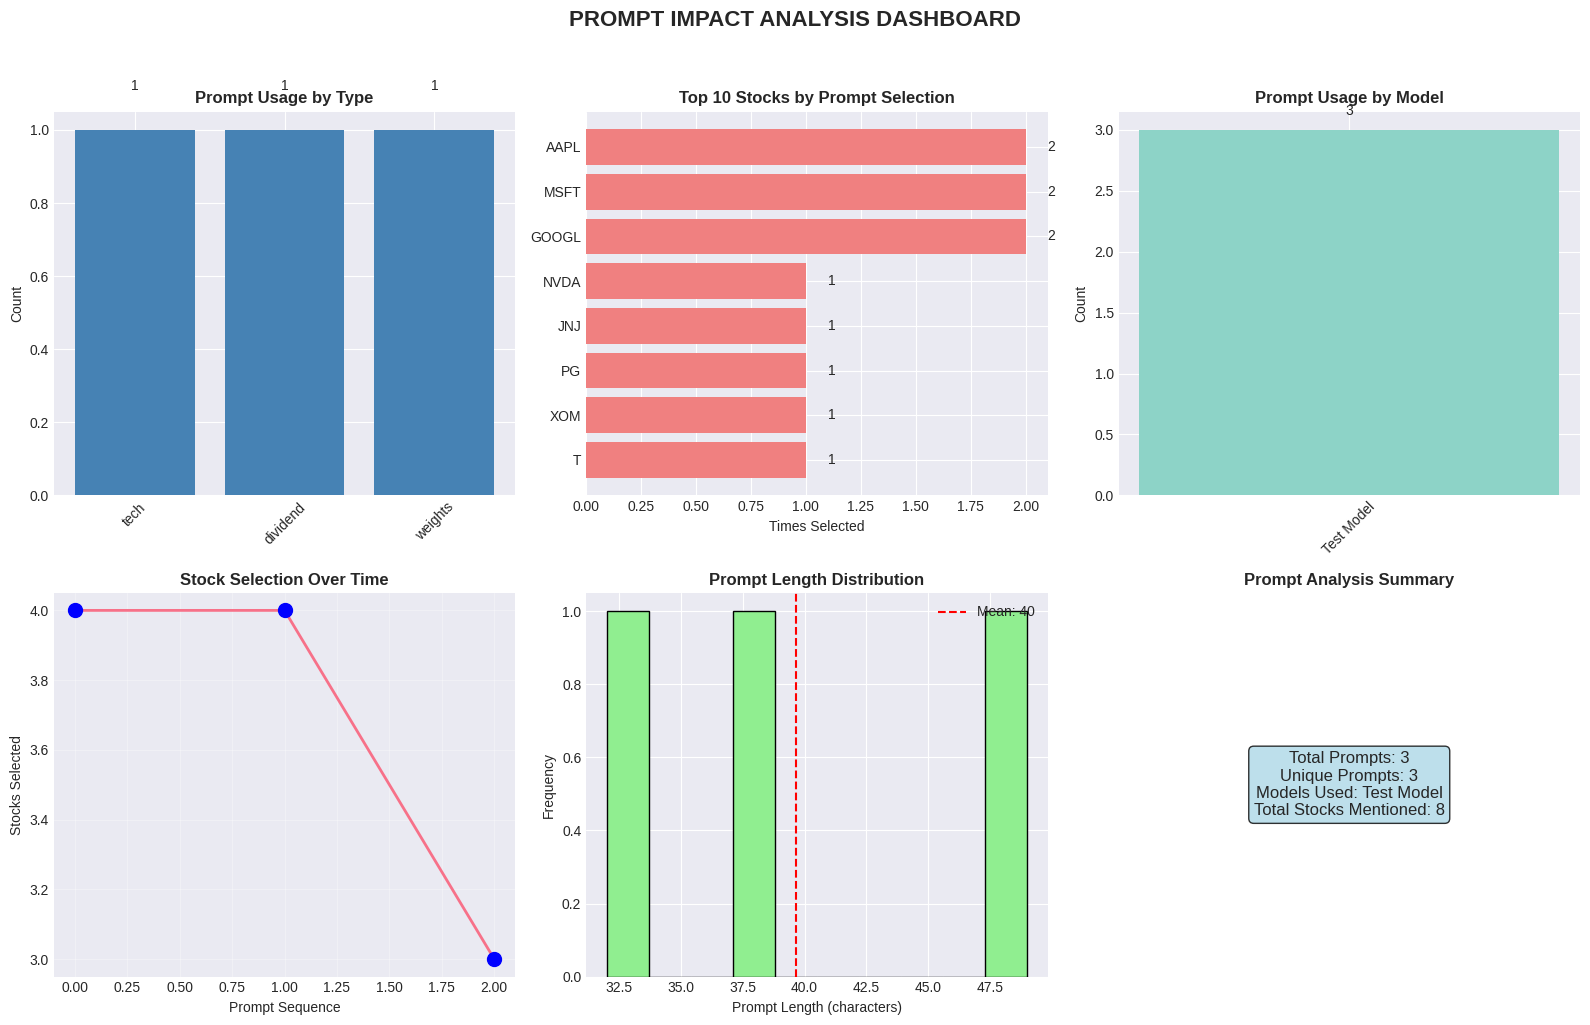


✅ Test completed successfully!


In [12]:
tracker = test_prompt_impact()

In [2]:
import os
import sys
import json
import time
import hashlib
import pickle
import warnings
from datetime import datetime, timedelta
from typing import List, Dict, Tuple, Optional, Any, Union
from dataclasses import dataclass, asdict
from concurrent.futures import ThreadPoolExecutor, as_completed
import re
import base64
import io
import itertools
from scipy.stats import ttest_ind, ks_2samp
from scipy.spatial.distance import jensenshannon
import scipy.stats as stats

import pandas as pd
import numpy as np
from scipy import stats
from sklearn.covariance import LedoitWolf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import cvxpy as cp
import yfinance as yf
from tqdm import tqdm

# OpenRouter (using OpenAI SDK with custom endpoint)
import openai

# Interactive widgets
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, Layout, VBox, HBox, Tab, Output
from IPython.display import display, clear_output, HTML, Markdown

# Suppress warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Packages installed and imported successfully!")


class ConfigManager:
    """Manage all configurations for the LLM Council Portfolio Optimizer"""

    DEFAULT_CONFIG = {
        "project": {
            "name": "LLM Council Portfolio Optimizer",
            "start_date": "2020-01-01",
            "end_date": "2024-01-31",
            "in_sample_end": "2022-12-31",
            "universe_sizes": [5, 10, 15, 20],
            "risk_free_rate": 0.02,
            "benchmark": "SPY"
        },
        "llm": {
            "provider": "openrouter",
            "models": [
                # FREE Models (no cost)
                {"name": "Llama 3.2 3B", "id": "meta-llama/llama-3.2-3b-instruct:free", "enabled": True, "weight": 1.0, "temperature": 0.3, "cost": "free"},
                {"name": "Stepfun 3.5 Flash", "id": "stepfun/step-3.5-flash:free", "enabled": True, "weight": 1.0, "temperature": 0.3, "cost": "free"},
                {"name": "Gemma 7B", "id": "google/gemma-7b-it:free", "enabled": True, "weight": 1.0, "temperature": 0.3, "cost": "free"},
                {"name": "Qwen 2.5 7B", "id": "qwen/qwen-2.5-7b-instruct:free", "enabled": True, "weight": 1.0, "temperature": 0.3, "cost": "free"},
                {"name": "Phi-3 Mini", "id": "microsoft/phi-3-mini-128k-instruct:free", "enabled": True, "weight": 1.0, "temperature": 0.3, "cost": "free"},
                {"name": "Nous Hermes", "id": "nousresearch/nous-hermes-2-mixtral-8x7b-dpo:free", "enabled": False, "weight": 1.0, "temperature": 0.3, "cost": "free"},

                # Low-cost Models (your $10 credit can handle these)
                {"name": "GPT-4", "id": "openai/gpt-4", "enabled": False, "weight": 1.2, "temperature": 0.3, "cost": "low"},
                {"name": "Claude Haiku", "id": "anthropic/claude-haiku-4.5", "enabled": False, "weight": 1.2, "temperature": 0.3, "cost": "low"},
                {"name": "Llama 3 70B", "id": "meta-llama/llama-3-70b-instruct", "enabled": False, "weight": 1.3, "temperature": 0.3, "cost": "medium"},
                {"name": "Mixtral 8x7B", "id": "mistralai/mixtral-8x7b-instruct", "enabled": False, "weight": 1.3, "temperature": 0.3, "cost": "medium"},

                # NEW MODELS ADDED
                {"name": "Kimi K2.5", "id": "moonshotai/kimi-k2.5", "enabled": False, "weight": 1.3, "temperature": 0.3, "cost": "medium"},
                {"name": "Gemini 3 Flash", "id": "google/gemini-3-flash-preview", "enabled": False, "weight": 1.3, "temperature": 0.3, "cost": "medium"},
                {"name": "Grok 4.1 Fast", "id": "x-ai/grok-4.1-fast", "enabled": False, "weight": 1.3, "temperature": 0.3, "cost": "medium"},
                {"name": "Deepseek Chat V3.1", "id": "deepseek/deepseek-chat-v3.1", "enabled": False, "weight": 1.3, "temperature": 0.3, "cost": "medium"},
                {"name": "GPT-5.2", "id": "openai/gpt-5.2", "enabled": False, "weight": 1.3, "temperature": 0.3, "cost": "medium"}
            ],
            "iterations": 2,
            "temperature": 0.3,
            "max_tokens": 500,
            "cache_enabled": True
        },
        "optimization": {
            "strategies": [
                {"name": "Equal Weight", "enabled": True},
                {"name": "Mean-Variance", "enabled": True},
                {"name": "Max Sharpe", "enabled": True},
                {"name": "Min Variance", "enabled": True},
                {"name": "Risk Parity", "enabled": True},
                {"name": "LLM Weighted", "enabled": True}
            ],
            "transaction_cost": 0.001,
            "max_turnover": 0.20,
            "sector_limit": 0.40
        },
        "analysis": {
            "metrics": ["sharpe", "return", "volatility", "max_dd", "win_rate"],
            "out_of_sample_periods": ["2023-01-01", "2023-07-01", "2024-01-01"],
            "rebalance_frequency": "quarterly",
            "confidence_level": 0.95
        }
    }

    def __init__(self, config_file: str = None):
        self.config = self.DEFAULT_CONFIG.copy()
        if config_file and os.path.exists(config_file):
            self.load_config(config_file)

    def load_config(self, config_file: str):
        """Load configuration from file"""
        with open(config_file, 'r') as f:
            self.config.update(json.load(f))

    def save_config(self, config_file: str):
        """Save configuration to file"""
        with open(config_file, 'w') as f:
            json.dump(self.config, f, indent=2)

    def get_enabled_models() -> List[Dict]:
        """Get list of enabled LLM models"""
        return [model for model in config_manager.config["llm"]["models"] if model["enabled"]]

    def get_enabled_strategies(self) -> List[str]:
        """Get list of enabled optimization strategies"""
        return [strategy["name"] for strategy in self.config["optimization"]["strategies"] if strategy["enabled"]]

    def update_model_status(self, model_name: str, enabled: bool):
        """Update model enabled status"""
        for model in self.config["llm"]["models"]:
            if model["name"] == model_name:
                model["enabled"] = enabled
                break

    def update_strategy_status(self, strategy_name: str, enabled: bool):
        """Update strategy enabled status"""
        for strategy in self.config["optimization"]["strategies"]:
            if strategy["name"] == strategy_name:
                strategy["enabled"] = enabled
                break

config_manager = ConfigManager()


@dataclass
class LLMResponse:
    """Data class for LLM responses"""
    model_name: str
    model_id: str
    prompt: str
    response: str
    tokens_used: int
    timestamp: datetime
    latency: float
    cost: float = 0.0
    error: Optional[str] = None
    prompt_type: str = "unknown"

    def to_dict(self):
        return asdict(self)


class PromptTracker:
    """Track prompt usage and impact on portfolio decisions"""

    def __init__(self):
        self.prompt_history = []
        self.prompt_performance = {}
        self.prompt_weights_matrix = {}

    def add_prompt_result(self, prompt_text: str, prompt_type: str,
                         selected_stocks: List[str], assigned_weights: Dict[str, float],
                         model_name: str = None):
        """Track a prompt and its results"""
        prompt_hash = hashlib.md5(prompt_text.encode()).hexdigest()[:8]

        entry = {
            "prompt_id": prompt_hash,
            "prompt_text": prompt_text,
            "prompt_type": prompt_type,
            "timestamp": datetime.now(),
            "selected_stocks": selected_stocks,
            "assigned_weights": assigned_weights,
            "model_name": model_name,
            "stock_count": len(selected_stocks),
            "avg_weight": np.mean(list(assigned_weights.values())) if assigned_weights else 0,
            "weight_std": np.std(list(assigned_weights.values())) if assigned_weights else 0
        }

        self.prompt_history.append(entry)

        # Update performance tracking
        if prompt_hash not in self.prompt_performance:
            self.prompt_performance[prompt_hash] = {
                "prompt_text": prompt_text,
                "prompt_type": prompt_type,
                "usage_count": 0,
                "models_used": set(),
                "stocks_selected": set(),
                "total_weight_assignments": 0
            }

        self.prompt_performance[prompt_hash]["usage_count"] += 1
        if model_name:
            self.prompt_performance[prompt_hash]["models_used"].add(model_name)

        for stock in selected_stocks:
            self.prompt_performance[prompt_hash]["stocks_selected"].add(stock)

        return prompt_hash

    def calculate_prompt_impact(self, final_weights: Dict[str, float]) -> Dict:
        """Calculate how much each prompt influenced final weights"""

        if not self.prompt_history:
            return {}

        # Create stock->prompt weight matrix
        stock_prompt_weights = {}

        for entry in self.prompt_history:
            prompt_id = entry["prompt_id"]

            for stock, weight in entry.get("assigned_weights", {}).items():
                if stock not in stock_prompt_weights:
                    stock_prompt_weights[stock] = {}

                if prompt_id not in stock_prompt_weights[stock]:
                    stock_prompt_weights[stock][prompt_id] = []

                stock_prompt_weights[stock][prompt_id].append(weight)

        # Calculate average weight per prompt per stock
        prompt_stock_avg = {}

        for stock, prompts in stock_prompt_weights.items():
            for prompt_id, weights in prompts.items():
                if prompt_id not in prompt_stock_avg:
                    prompt_stock_avg[prompt_id] = {}
                prompt_stock_avg[prompt_id][stock] = np.mean(weights)

        # Calculate prompt contribution to final weights
        prompt_contributions = {}

        for prompt_id in prompt_stock_avg.keys():
            prompt_info = next((p for p in self.prompt_history if p["prompt_id"] == prompt_id), None)
            if not prompt_info:
                continue

            contribution = 0
            stocks_contributed = []

            for stock, avg_weight in prompt_stock_avg[prompt_id].items():
                if stock in final_weights:
                    # Calculate contribution as percentage of final weight
                    if final_weights[stock] > 0:
                        weight_contribution = avg_weight / final_weights[stock] if final_weights[stock] > 0 else 0
                        contribution += weight_contribution
                        stocks_contributed.append({
                            "stock": stock,
                            "prompt_avg_weight": avg_weight,
                            "final_weight": final_weights[stock],
                            "contribution_ratio": weight_contribution
                        })

            prompt_contributions[prompt_id] = {
                "prompt_text": prompt_info["prompt_text"],
                "prompt_type": prompt_info["prompt_type"],
                "total_contribution": contribution / len(stocks_contributed) if stocks_contributed else 0,
                "stocks_contributed": stocks_contributed,
                "model": prompt_info.get("model_name", "Multiple"),
                "usage_count": self.prompt_performance.get(prompt_id, {}).get("usage_count", 0)
            }

        return prompt_contributions

    def get_prompt_statistics(self) -> Dict:
        """Get comprehensive prompt statistics"""

        stats = {
            "total_prompts": len(self.prompt_history),
            "prompt_types": {},
            "models_by_prompt": {},
            "stocks_by_prompt": {},
            "top_performing_prompts": []
        }

        # Count prompt types
        for entry in self.prompt_history:
            prompt_type = entry["prompt_type"]
            stats["prompt_types"][prompt_type] = stats["prompt_types"].get(prompt_type, 0) + 1

        # Get unique prompts
        unique_prompts = {}
        for entry in self.prompt_history:
            prompt_id = entry["prompt_id"]
            if prompt_id not in unique_prompts:
                unique_prompts[prompt_id] = {
                    "text": entry["prompt_text"],
                    "type": entry["prompt_type"],
                    "usage_count": 0,
                    "models": set(),
                    "stocks": set()
                }

            unique_prompts[prompt_id]["usage_count"] += 1
            if entry.get("model_name"):
                unique_prompts[prompt_id]["models"].add(entry["model_name"])

            for stock in entry.get("selected_stocks", []):
                unique_prompts[prompt_id]["stocks"].add(stock)

        # Convert sets to lists for JSON serialization
        for prompt_id, data in unique_prompts.items():
            unique_prompts[prompt_id]["models"] = list(data["models"])
            unique_prompts[prompt_id]["stocks"] = list(data["stocks"])

        stats["unique_prompts"] = unique_prompts

        return stats

    def plot_prompt_impact(self, final_weights: Dict[str, float]) -> plt.Figure:
        """Visualize prompt impact on final weights"""

        prompt_contributions = self.calculate_prompt_impact(final_weights)

        if not prompt_contributions:
            fig, ax = plt.subplots(figsize=(10, 6))
            ax.text(0.5, 0.5, "No prompt impact data available",
                   ha='center', va='center', fontsize=12)
            ax.set_title("Prompt Impact Analysis")
            return fig

        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # Plot 1: Prompt Contribution to Final Weights
        ax1 = axes[0, 0]
        prompt_ids = list(prompt_contributions.keys())[:10]  # Top 10
        contributions = [prompt_contributions[pid]["total_contribution"] for pid in prompt_ids]
        prompt_previews = [pid[:8] + ": " + prompt_contributions[pid]["prompt_type"]
                          for pid in prompt_ids]

        bars = ax1.barh(range(len(prompt_ids)), contributions, color='steelblue')
        ax1.set_yticks(range(len(prompt_ids)))
        ax1.set_yticklabels(prompt_previews)
        ax1.set_xlabel('Contribution to Final Weights')
        ax1.set_title('Prompt Impact on Portfolio Weights')

        # Add percentage labels
        for i, (bar, contrib) in enumerate(zip(bars, contributions)):
            ax1.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                   f'{contrib:.2%}', va='center', fontsize=9)

        # Plot 2: Prompt Usage by Model
        ax2 = axes[0, 1]
        model_prompt_usage = {}
        for pid, data in prompt_contributions.items():
            model = data.get("model", "Unknown")
            usage = data.get("usage_count", 0)
            if model not in model_prompt_usage:
                model_prompt_usage[model] = 0
            model_prompt_usage[model] += usage

        models = list(model_prompt_usage.keys())
        usage_counts = [model_prompt_usage[m] for m in models]

        bars2 = ax2.bar(models, usage_counts, color='lightcoral')
        ax2.set_xlabel('Model')
        ax2.set_ylabel('Prompt Usage Count')
        ax2.set_title('Prompt Usage by Model')
        ax2.tick_params(axis='x', rotation=45)

        # Plot 3: Stock Selection by Prompt Type
        ax3 = axes[1, 0]
        prompt_type_stocks = {}
        for entry in self.prompt_history:
            prompt_type = entry["prompt_type"]
            if prompt_type not in prompt_type_stocks:
                prompt_type_stocks[prompt_type] = set()
            prompt_type_stocks[prompt_type].update(entry.get("selected_stocks", []))

        prompt_types = list(prompt_type_stocks.keys())
        stock_counts = [len(prompt_type_stocks[pt]) for pt in prompt_types]

        ax3.pie(stock_counts, labels=prompt_types, autopct='%1.1f%%',
               colors=plt.cm.Set3(np.linspace(0, 1, len(prompt_types))))
        ax3.set_title('Unique Stocks Selected by Prompt Type')

        # Plot 4: Weight Distribution by Prompt
        ax4 = axes[1, 1]
        prompt_weight_data = []
        prompt_labels = []

        for pid, data in prompt_contributions.items():
            weights = []
            for stock_contrib in data.get("stocks_contributed", []):
                if "prompt_avg_weight" in stock_contrib:
                    weights.append(stock_contrib["prompt_avg_weight"])

            if weights:
                prompt_weight_data.append(weights)
                prompt_labels.append(f"{pid[:6]} ({data['prompt_type'][:3]})")

        if prompt_weight_data:
            ax4.boxplot(prompt_weight_data, labels=prompt_labels)
            ax4.set_ylabel('Weight Assignment')
            ax4.set_title('Weight Distribution by Prompt')
            ax4.tick_params(axis='x', rotation=45)
            ax4.grid(True, alpha=0.3)

        plt.suptitle('Prompt Impact Analysis Dashboard', fontsize=14, fontweight='bold')
        plt.tight_layout()

        return fig

    def generate_prompt_report(self, final_weights: Dict[str, float]) -> str:
        """Generate detailed report on prompt impact"""

        prompt_contributions = self.calculate_prompt_impact(final_weights)
        stats = self.get_prompt_statistics()

        report = f"""
# PROMPT IMPACT ANALYSIS REPORT

## Summary Statistics

- Total prompts used: {stats['total_prompts']}
- Unique prompts: {len(stats.get('unique_prompts', {}))}
- Prompt types: {', '.join(stats.get('prompt_types', {}).keys())}

## Prompt Contribution Analysis
"""

        if prompt_contributions:
            # Sort prompts by contribution
            sorted_prompts = sorted(prompt_contributions.items(),
                                  key=lambda x: x[1]["total_contribution"],
                                  reverse=True)

            report += "\n### Top Contributing Prompts:\n"
            for i, (pid, data) in enumerate(sorted_prompts[:5], 1):
                report += f"\n{i}. **Prompt ID:** {pid[:8]}\n"
                report += f"   **Type:** {data['prompt_type']}\n"
                report += f"   **Contribution:** {data['total_contribution']:.2%}\n"
                report += f"   **Used by:** {data.get('model', 'Multiple')}\n"
                report += f"   **Usage count:** {data.get('usage_count', 0)}\n"
                report += f"   **Preview:** {data['prompt_text'][:100]}...\n"

        # Prompt statistics by type
        report += "\n## Prompt Statistics by Type\n"
        for prompt_type, count in stats.get("prompt_types", {}).items():
            report += f"- **{prompt_type}:** {count} prompts used\n"

        return report

    def create_simple_visualization(self, final_weights: Dict[str, float] = None):
        """Create simple visualizations of prompt impact"""

        if not self.prompt_history:
            print("No prompts to visualize yet!")
            return None

        # Create a figure with multiple subplots
        fig, axes = plt.subplots(2, 3, figsize=(16, 10))

        # Plot 1: Prompt usage by type
        ax1 = axes[0, 0]
        prompt_types = {}
        for prompt in self.prompt_history:
            ptype = prompt["prompt_type"]
            prompt_types[ptype] = prompt_types.get(ptype, 0) + 1

        if prompt_types:
            ax1.bar(prompt_types.keys(), prompt_types.values(), color='steelblue')
            ax1.set_title('Prompt Usage by Type', fontweight='bold')
            ax1.set_ylabel('Count')
            ax1.tick_params(axis='x', rotation=45)

            # Add count labels
            for i, (ptype, count) in enumerate(prompt_types.items()):
                ax1.text(i, count + 0.1, str(count), ha='center', va='bottom')

        # Plot 2: Stocks most frequently selected by prompts
        ax2 = axes[0, 1]
        stock_freq = {}
        for prompt in self.prompt_history:
            for stock in prompt["selected_stocks"]:
                stock_freq[stock] = stock_freq.get(stock, 0) + 1

        # Get top 10 stocks
        top_stocks = sorted(stock_freq.items(), key=lambda x: x[1], reverse=True)[:10]
        if top_stocks:
            stocks, freqs = zip(*top_stocks)
            bars = ax2.barh(range(len(stocks)), freqs, color='lightcoral')
            ax2.set_yticks(range(len(stocks)))
            ax2.set_yticklabels(stocks)
            ax2.invert_yaxis()
            ax2.set_title('Top 10 Stocks by Prompt Selection', fontweight='bold')
            ax2.set_xlabel('Times Selected')

            # Add frequency labels
            for i, (bar, freq) in enumerate(zip(bars, freqs)):
                ax2.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
                        str(freq), va='center')

        # Plot 3: Prompt usage by model
        ax3 = axes[0, 2]
        model_usage = {}
        for prompt in self.prompt_history:
            model = prompt.get("model_name", "Unknown")
            model_usage[model] = model_usage.get(model, 0) + 1

        if model_usage:
            models = list(model_usage.keys())
            counts = list(model_usage.values())
            colors = plt.cm.Set3(np.linspace(0, 1, len(models)))

            bars = ax3.bar(models, counts, color=colors)
            ax3.set_title('Prompt Usage by Model', fontweight='bold')
            ax3.set_ylabel('Count')
            ax3.tick_params(axis='x', rotation=45)

            for bar, count in zip(bars, counts):
                ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                        str(count), ha='center', va='bottom')

        # Plot 4: Stock selection timeline
        ax4 = axes[1, 0]
        if len(self.prompt_history) > 1:
            # Group by time (simplified)
            times = [i for i in range(len(self.prompt_history))]
            stock_counts = [len(p["selected_stocks"]) for p in self.prompt_history]

            ax4.plot(times, stock_counts, 'o-', linewidth=2, markersize=8)
            ax4.set_title('Stock Selection Over Time', fontweight='bold')
            ax4.set_xlabel('Prompt Sequence')
            ax4.set_ylabel('Stocks Selected')
            ax4.grid(True, alpha=0.3)

            # Mark different prompt types
            for i, prompt in enumerate(self.prompt_history):
                color = 'red' if prompt["prompt_type"] == 'weight_assignment' else 'blue'
                ax4.plot(i, stock_counts[i], 'o', color=color, markersize=10)

        # Plot 5: Prompt text length distribution
        ax5 = axes[1, 1]
        prompt_lengths = [len(p["prompt_text"]) for p in self.prompt_history]
        ax5.hist(prompt_lengths, bins=10, color='lightgreen', edgecolor='black')
        ax5.set_title('Prompt Length Distribution', fontweight='bold')
        ax5.set_xlabel('Prompt Length (characters)')
        ax5.set_ylabel('Frequency')
        ax5.axvline(np.mean(prompt_lengths), color='red', linestyle='--', label=f'Mean: {np.mean(prompt_lengths):.0f}')
        ax5.legend()

        # Plot 6: Final portfolio influence (if available)
        ax6 = axes[1, 2]
        if final_weights:
            # Get top 10 stocks by weight
            top_portfolio = sorted(final_weights.items(), key=lambda x: x[1], reverse=True)[:10]
            if top_portfolio:
                stocks, weights = zip(*top_portfolio)

                # Get how many prompts selected each
                prompt_selections = []
                for stock in stocks:
                    count = sum(1 for p in self.prompt_history if stock in p["selected_stocks"])
                    prompt_selections.append(count)

                # Create bar chart
                x = np.arange(len(stocks))
                width = 0.35

                bars1 = ax6.bar(x - width/2, weights, width, label='Portfolio Weight', color='steelblue')
                bars2 = ax6.bar(x + width/2, prompt_selections, width, label='Times Selected by Prompts', color='orange')

                ax6.set_title('Final Portfolio vs Prompt Selection', fontweight='bold')
                ax6.set_xticks(x)
                ax6.set_xticklabels(stocks, rotation=45, ha='right')
                ax6.legend()
                ax6.set_ylabel('Weight / Selection Count')

                # Add value labels
                for bars in [bars1, bars2]:
                    for bar in bars:
                        height = bar.get_height()
                        ax6.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                                f'{height:.2f}' if height < 1 else f'{height:.0f}',
                                ha='center', va='bottom', fontsize=8)
        else:
            # Show prompt summary
            analysis = self.get_prompt_statistics()
            summary_text = f"Total Prompts: {analysis['total_prompts']}\n"
            summary_text += f"Unique Prompts: {len(analysis['unique_prompts'])}\n"
            summary_text += f"Prompt Types: {', '.join(analysis['prompt_types'].keys())}"

            ax6.text(0.5, 0.5, summary_text, ha='center', va='center',
                    transform=ax6.transAxes, fontsize=12,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.8))
            ax6.set_title('Prompt Analysis Summary', fontweight='bold')
            ax6.axis('off')

        plt.suptitle('PROMPT IMPACT ANALYSIS DASHBOARD', fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()

        return fig


class LLMCouncilMember:
    """Individual LLM member in the council"""

    def __init__(self, name: str, model_id: str, weight: float = 1.0, cost_type: str = "free", temperature: float = 0.3):
        self.name = name
        self.model_id = model_id
        self.weight = weight
        self.cost_type = cost_type
        self.temperature = temperature
        self.responses = []
        self.prompts_used = []  # Track prompts used
        self.successful_queries = 0
        self.failed_queries = 0
        self.total_tokens = 0
        self.total_latency = 0.0
        self.total_cost = 0.0

        # Initialize OpenAI client for OpenRouter
        self.client = None

    def initialize_client(self, api_key: str):
        """Initialize the OpenRouter client"""
        try:
            self.client = openai.OpenAI(
                base_url="https://openrouter.ai/api/v1",
                api_key=api_key
            )
            return True
        except Exception as e:
            print(f"Failed to initialize client for {self.name}: {e}")
            return False

    def query(self, prompt: str, temperature: float = None,
              max_tokens: int = 500, prompt_type: str = "unknown") -> LLMResponse:
        """Query this specific LLM"""
        if not self.client:
            return LLMResponse(
                model_name=self.name,
                model_id=self.model_id,
                prompt=prompt,
                response="",
                tokens_used=0,
                timestamp=datetime.now(),
                latency=0,
                cost=0.0,
                error="Client not initialized",
                prompt_type=prompt_type
            )

        start_time = time.time()

        # Use instance temperature if not specified
        if temperature is None:
            temperature = self.temperature

        # Track prompt before query
        prompt_entry = {
            "prompt_text": prompt,
            "prompt_type": prompt_type,
            "timestamp": datetime.now(),
            "temperature": temperature
        }
        self.prompts_used.append(prompt_entry)

        try:
            response = self.client.chat.completions.create(
                model=self.model_id,
                messages=[{"role": "user", "content": prompt}],
                max_tokens=max_tokens,
                temperature=temperature
            )

            latency = time.time() - start_time
            response_text = response.choices[0].message.content
            tokens_used = response.usage.total_tokens if response.usage else 0

            # Estimate cost (approximate)
            cost = self._estimate_cost(tokens_used)

            llm_response = LLMResponse(
                model_name=self.name,
                model_id=self.model_id,
                prompt=prompt,
                response=response_text,
                tokens_used=tokens_used,
                timestamp=datetime.now(),
                latency=latency,
                cost=cost,
                prompt_type=prompt_type
            )

            self.successful_queries += 1
            self.total_tokens += tokens_used
            self.total_latency += latency
            self.total_cost += cost
            self.responses.append(llm_response)

            return llm_response

        except Exception as e:
            latency = time.time() - start_time
            self.failed_queries += 1

            return LLMResponse(
                model_name=self.name,
                model_id=self.model_id,
                prompt=prompt,
                response="",
                tokens_used=0,
                timestamp=datetime.now(),
                latency=latency,
                cost=0.0,
                error=str(e),
                prompt_type=prompt_type
            )

    def _estimate_cost(self, tokens: int) -> float:
        """Estimate cost based on model type"""
        if "free" in self.model_id:
            return 0.0
        elif "gpt-3.5" in self.model_id or "haiku" in self.model_id or "flash" in self.model_id.lower():
            return tokens * 0.000001  # Approx $0.001 per 1K tokens
        elif "gpt-4" in self.model_id or "gpt-5" in self.model_id:
            return tokens * 0.00001  # Approx $0.01 per 1K tokens
        else:
            return tokens * 0.000002  # Approx $0.002 per 1K tokens

    def get_stats(self) -> Dict:
        """Get statistics for this council member"""
        total_queries = self.successful_queries + self.failed_queries
        return {
            "name": self.name,
            "model_id": self.model_id,
            "successful_queries": self.successful_queries,
            "failed_queries": self.failed_queries,
            "success_rate": self.successful_queries / total_queries if total_queries > 0 else 0,
            "total_tokens": self.total_tokens,
            "avg_latency": self.total_latency / max(1, self.successful_queries),
            "total_cost": self.total_cost,
            "weight": self.weight,
            "temperature": self.temperature,
            "cost_type": self.cost_type,
            "prompts_used_count": len(self.prompts_used)
        }


class PromptEngineer:
    """Handle prompt creation and management"""

    # Default prompt templates
    DEFAULT_PROMPTS = {
        "stock_selection_simple": """Select {num_stocks} stocks from the S&P 500 that you believe will perform well in the next 12 months.\nConsider factors like financial health, growth potential, and market position.\nReturn ONLY a comma-separated list of ticker symbols.\nExample: AAPL, MSFT, GOOGL""",

        "stock_selection_detailed": """As a financial analyst, select {num_stocks} stocks from the S&P 500 for a long-term investment portfolio.\n\nCRITERIA:\n1. Strong Fundamentals (ROE > 15%, Debt/Equity < 1)\n2. Consistent Revenue Growth (> 5% YoY)\n3. Competitive Advantage (moat, brand, patents)\n4. Reasonable Valuation (P/E < sector average)\n5. Good Management (consistent dividend, buybacks)\n\nSector diversification is important. Avoid overly concentrated sectors.\n\nReturn ONLY ticker symbols in alphabetical order, comma-separated.""",

        "stock_selection_thematic": """Select {num_stocks} stocks aligned with these investment themes:\n- Artificial Intelligence & Cloud Computing\n- Renewable Energy & Sustainability\n- Healthcare Innovation\n- Financial Technology\n- E-commerce & Digital Transformation\n\nFocus on companies leading in these areas with strong growth potential.\nReturn ONLY ticker symbols, comma-separated.""",

        "weight_assignment_basic": """Given these stocks: {tickers}\nAssign portfolio weights (0-100%) that sum to 100%.\nConsider your conviction level for each stock.\n\nFormat each line as: TICKER: WEIGHT%\nExample:\nAAPL: 15%\nMSFT: 12%\nGOOGL: 10%""",

        "weight_assignment_advanced": """For these stocks: {tickers}\nAssign portfolio weights using these principles:\n\n1. Higher conviction = higher weight (max 30% per stock)\n2. Consider diversification across sectors\n3. Balance between growth and stability\n4. Account for correlation risk\n\nReturn weights in this format:\nTICKER1: WEIGHT1%\nTICKER2: WEIGHT2%"""
    }

    def __init__(self):
        self.custom_prompts = {}

    def create_stock_selection_prompt(self, num_stocks: int, prompt_type: str = "simple", custom_prompt: str = None) -> str:
        """Create stock selection prompt"""
        if custom_prompt:
            return custom_prompt.format(num_stocks=num_stocks)

        if prompt_type == "simple":
            return self.DEFAULT_PROMPTS["stock_selection_simple"].format(num_stocks=num_stocks)
        elif prompt_type == "detailed":
            return self.DEFAULT_PROMPTS["stock_selection_detailed"].format(num_stocks=num_stocks)
        elif prompt_type == "thematic":
            return self.DEFAULT_PROMPTS["stock_selection_thematic"].format(num_stocks=num_stocks)
        else:
            return self.DEFAULT_PROMPTS["stock_selection_simple"].format(num_stocks=num_stocks)

    def create_weight_assignment_prompt(self, tickers: List[str], prompt_type: str = "basic", custom_prompt: str = None) -> str:
        """Create weight assignment prompt"""
        ticker_str = ", ".join(tickers[:15])  # Limit for readability

        if custom_prompt:
            return custom_prompt.format(tickers=ticker_str)

        if prompt_type == "basic":
            return self.DEFAULT_PROMPTS["weight_assignment_basic"].format(tickers=ticker_str)
        elif prompt_type == "advanced":
            return self.DEFAULT_PROMPTS["weight_assignment_advanced"].format(tickers=ticker_str)
        else:
            return self.DEFAULT_PROMPTS["weight_assignment_basic"].format(tickers=ticker_str)

    def extract_tickers(self, text: str) -> List[str]:
        """Extract ticker symbols from text"""
        text = text.upper()

        # Common non-ticker words to exclude
        exclude_words = {
            'AND', 'THE', 'FOR', 'WITH', 'FROM', 'THAT', 'THIS', 'HAVE', 'WILL',
            'WHICH', 'THEIR', 'BEEN', 'STOCKS', 'TICKERS', 'INCLUDE', 'RECOMMEND',
            'PORTFOLIO', 'EXAMPLE', 'RETURN', 'ONLY', 'LIST', 'SELECT', 'CHOOSE'
        }

        # Remove explanation lines
        lines = text.split('\n')
        clean_lines = []

        for line in lines:
            line = line.strip()
            if not line:
                continue
            # Skip lines that look like explanations
            if any(phrase in line for phrase in [':', 'because', 'due to', 'since', 'as']):
                continue
            # Skip lines starting with numbers or bullets
            if re.match(r'^[\d\x95\-]', line):
                continue
            clean_lines.append(line)

        clean_text = ' '.join(clean_lines)

        # Extract tickers (1-5 uppercase letters)
        ticker_pattern = r'\b[A-Z]{1,5}\b'
        potential_tickers = re.findall(ticker_pattern, clean_text)

        # Filter valid tickers
        valid_tickers = []
        for ticker in potential_tickers:
            if (
                ticker not in exclude_words and
                len(ticker) >= 2 and
                ticker not in valid_tickers
            ):
                valid_tickers.append(ticker)

        return valid_tickers  # Removed [:20] limit

    def extract_weights(self, text: str) -> Dict[str, float]:
        """Extract ticker-weight pairs from text"""
        weights = {}
        text = text.upper()

        # Multiple patterns to match different formats
        patterns = [
            r'([A-Z]{1,5})\s*[:=]\s*([\d.]+)\s*%?',  # AAPL: 15% or AAPL = 15
            r'([A-Z]{1,5})\s+([\d.]+)\s*%',  # AAPL 15%
            r'([A-Z]{1,5})\s*\(([\d.]+)\%\)',  # AAPL (15%)
        ]

        for pattern in patterns:
            matches = re.findall(pattern, text)
            for ticker, weight in matches:
                try:
                    weight_float = float(weight)
                    if 0 < weight_float <= 100:
                        weights[ticker] = weight_float / 100  # Convert to decimal
                except ValueError:
                    continue

        return weights

    def add_custom_prompt(self, name: str, prompt: str):
        """Add a custom prompt template"""
        self.custom_prompts[name] = prompt


class LLMCouncil:
    """Main LLM Council coordinating multiple members"""

    def __init__(self, api_key: str = None, config: Dict = None):
        self.api_key = api_key
        self.config = config or {}
        self.members = {}
        self.prompt_engineer = PromptEngineer()
        self.prompt_tracker = PromptTracker()  # NEW: Add prompt tracker
        self.consensus_results = {}
        self.cost_tracker = {
            "total_cost": 0.0,
            "total_tokens": 0,
            "total_queries": 0
        }

        # Initialize members from config
        self._initialize_members()

    def _initialize_members(self):
        """Initialize council members from config"""
        for model_config in self.config.get("models", []):
            if model_config.get("enabled", False):
                member = LLMCouncilMember(
                    name=model_config["name"],
                    model_id=model_config["id"],
                    weight=model_config.get("weight", 1.0),
                    cost_type=model_config.get("cost", "free"),
                    temperature=model_config.get("temperature", 0.3)
                )
                if self.api_key:
                    member.initialize_client(self.api_key)
                self.members[model_config["name"]] = member

    def add_member(self, name: str, model_id: str, weight: float = 1.0, cost_type: str = "free", temperature: float = 0.3):
        """Add a new member to the council"""
        member = LLMCouncilMember(name, model_id, weight, cost_type, temperature)
        if self.api_key:
            member.initialize_client(self.api_key)
        self.members[name] = member

    def remove_member(self, name: str):
        """Remove a member from the council"""
        if name in self.members:
            del self.members[name]

    def query_all_members(self, prompt: str, temperature: float = 0.3,
                         max_tokens: int = 500, prompt_type: str = "unknown") -> Dict[str, LLMResponse]:
        """Query all council members with the same prompt"""
        responses = {}

        print(f"🤖 Querying {len(self.members)} council members...")

        for member_name, member in self.members.items():
            print(f"  • {member_name}...", end="")
            response = member.query(prompt, temperature, max_tokens, prompt_type=prompt_type)
            responses[member_name] = response

            # Update cost tracker
            self.cost_tracker["total_cost"] += response.cost
            self.cost_tracker["total_tokens"] += response.tokens_used
            self.cost_tracker["total_queries"] += 1

            if response.error:
                print(f" ❌ Error: {response.error[:50]}")
            else:
                print(f" ✅ {response.tokens_used} tokens")

            time.sleep(1)  # Rate limiting

        return responses

    def generate_stock_universe(self, num_stocks: int, iterations: int = 2,
                               prompt_type: str = "simple", custom_prompt: str = None) -> Dict:
        """ Generate stock universe through council consensus """
        print(f"🔍 Generating universe of {num_stocks} stocks...")

        prompt = self.prompt_engineer.create_stock_selection_prompt(
            num_stocks, prompt_type, custom_prompt
        )

        all_selections = {}
        frequency_counter = {}

        for iteration in range(iterations):
            print(f"  Iteration {iteration + 1}/{iterations}")

            responses = self.query_all_members(prompt, prompt_type="stock_selection")

            for member_name, response in responses.items():
                if response.error:
                    continue

                tickers = self.prompt_engineer.extract_tickers(response.response)

                if member_name not in all_selections:
                    all_selections[member_name] = []

                # Add unique tickers from this iteration
                for ticker in tickers[:num_stocks]:
                    if ticker not in all_selections[member_name]:
                        all_selections[member_name].append(ticker)

                # Update frequencies
                for ticker in tickers[:num_stocks]:
                    frequency_counter[ticker] = frequency_counter.get(ticker, 0) + 1

                # Track prompt usage for this member
                self.prompt_tracker.add_prompt_result(
                    prompt_text=prompt,
                    prompt_type=f"stock_selection_{prompt_type}",
                    selected_stocks=tickers[:num_stocks],
                    assigned_weights={},  # No weights yet
                    model_name=member_name
                )

        # Get consensus picks (most frequently selected)
        sorted_tickers = sorted(frequency_counter.items(), key=lambda x: x[1], reverse=True)
        consensus_tickers = [ticker for ticker, freq in sorted_tickers[:num_stocks]]

        # Calculate agreement scores
        agreement_scores = {}
        for member_name, selections in all_selections.items():
            common = len(set(selections[:num_stocks]) & set(consensus_tickers))
            agreement_scores[member_name] = common / num_stocks

        result = {
            "individual_selections": {m: s[:num_stocks] for m, s in all_selections.items()},
            "consensus_tickers": consensus_tickers,
            "selection_frequencies": dict(sorted_tickers),
            "agreement_scores": agreement_scores,
            "prompt_used": prompt,
            "total_members": len(self.members),
            "iterations": iterations
        }

        self.consensus_results[f"universe_{num_stocks}"] = result
        return result

    def assign_portfolio_weights(self, tickers: List[str],
                                prompt_type: str = "basic", custom_prompt: str = None) -> Dict:
        """ Get weight assignments from all council members """
        print(f"⚖️ Getting weight assignments for {len(tickers)} stocks...")

        prompt = self.prompt_engineer.create_weight_assignment_prompt(
            tickers, prompt_type, custom_prompt
        )

        responses = self.query_all_members(prompt, prompt_type="weight_assignment")

        all_weights = {}
        weight_matrix = {}

        for member_name, response in responses.items():
            if response.error:
                continue

            weights = self.prompt_engineer.extract_weights(response.response)

            # Only include weights for our tickers
            filtered_weights = {t: w for t, w in weights.items() if t in tickers}

            if filtered_weights:
                # Normalize to sum to 1
                total = sum(filtered_weights.values())
                if total > 0:
                    normalized = {t: w/total for t, w in filtered_weights.items()}
                    all_weights[member_name] = normalized

                    # Track prompt usage with weights
                    self.prompt_tracker.add_prompt_result(
                        prompt_text=prompt,
                        prompt_type=f"weight_assignment_{prompt_type}",
                        selected_stocks=list(filtered_weights.keys()),
                        assigned_weights=normalized,
                        model_name=member_name
                    )

                    # Add to matrix for statistics
                    for ticker, weight in normalized.items():
                        if ticker not in weight_matrix:
                            weight_matrix[ticker] = []
                        weight_matrix[ticker].append(weight)

        # Calculate consensus (average) weights
        consensus_weights = {}
        weight_disagreement = {}

        for ticker in tickers:
            weights_list = weight_matrix.get(ticker, [])
            if weights_list:
                consensus_weights[ticker] = np.mean(weights_list)
                weight_disagreement[ticker] = np.std(weights_list)

        # Normalize consensus weights
        total_consensus = sum(consensus_weights.values())
        if total_consensus > 0:
            consensus_weights = {t: w/total_consensus for t, w in consensus_weights.items()}

        return {
            "individual_weights": all_weights,
            "consensus_weights": consensus_weights,
            "weight_disagreement": weight_disagreement,
            "prompt_used": prompt,
            "total_responses": len(all_weights)
        }

    def get_council_stats(self) -> Dict:
        """Get overall council statistics"""
        stats = {
            "total_members": len(self.members),
            "members": {},
            "total_queries": 0,
            "successful_queries": 0,
            "failed_queries": 0,
            "total_tokens": 0,
            "total_cost": 0.0,
            "free_members": 0,
            "paid_members": 0,
            "total_prompts_tracked": len(self.prompt_tracker.prompt_history)
        }

        for member_name, member in self.members.items():
            member_stats = member.get_stats()
            stats["members"][member_name] = member_stats
            stats["total_queries"] += member_stats["successful_queries"] + member_stats["failed_queries"]
            stats["successful_queries"] += member_stats["successful_queries"]
            stats["failed_queries"] += member_stats["failed_queries"]
            stats["total_tokens"] += member_stats["total_tokens"]
            stats["total_cost"] += member_stats["total_cost"]

            if member.cost_type == "free":
                stats["free_members"] += 1
            else:
                stats["paid_members"] += 1

        return stats

    def plot_member_performance(self):
        """Visualize council member performance"""
        stats = self.get_council_stats()

        fig, axes = plt.subplots(2, 2, figsize=(14, 10))

        member_names = list(stats["members"].keys())
        colors = plt.cm.Set3(np.linspace(0, 1, len(member_names)))

        # Plot 1: Success Rate
        ax1 = axes[0, 0]
        success_rates = [stats["members"][name]["success_rate"] * 100 for name in member_names]
        bars1 = ax1.bar(member_names, success_rates, color=colors)
        ax1.set_title('Query Success Rate (%)', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Success Rate')
        ax1.tick_params(axis='x', rotation=45)

        # Add value labels
        for bar, rate in zip(bars1, success_rates):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                          f'{rate:.0f}%', ha='center', va='bottom', fontsize=9)

        # Plot 2: Average Latency
        ax2 = axes[0, 1]
        avg_latency = [stats["members"][name].get("avg_latency", 0) for name in member_names]
        bars2 = ax2.bar(member_names, avg_latency, color=colors)
        ax2.set_title('Average Latency (seconds)', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Seconds')
        ax2.tick_params(axis='x', rotation=45)

        # Plot 3: Token Usage
        ax3 = axes[1, 0]
        token_usage = [stats["members"][name]["total_tokens"] for name in member_names]
        bars3 = ax3.bar(member_names, token_usage, color=colors)
        ax3.set_title('Total Token Usage', fontsize=12, fontweight='bold')
        ax3.set_ylabel('Tokens')
        ax3.tick_params(axis='x', rotation=45)

        # Plot 4: Cost by Member
        ax4 = axes[1, 1]
        costs = [stats["members"][name]["total_cost"] for name in member_names]
        bars4 = ax4.bar(member_names, costs, color=colors)
        ax4.set_title('Estimated Cost ($)', fontsize=12, fontweight='bold')
        ax4.set_ylabel('Dollars')
        ax4.tick_params(axis='x', rotation=45)

        # Add cost labels
        for bar, cost in zip(bars4, costs):
            if cost > 0:
                ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                              f'${cost:.4f}', ha='center', va='bottom', fontsize=9)

        plt.suptitle(f'LLM Council Performance (Total Cost: ${stats["total_cost"]:.4f})',
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        return fig

    def plot_stock_selection_heatmap(self, universe_result: Dict):
        """Visualize stock selection heatmap"""
        frequencies = universe_result["selection_frequencies"]

        # Get top 15 stocks
        top_stocks = sorted(frequencies.items(), key=lambda x: x[1], reverse=True)[:15]
        tickers = [s[0] for s in top_stocks]
        freq_values = [s[1] for s in top_stocks]

        # Create member selection matrix
        members = list(universe_result["individual_selections"].keys())
        selection_matrix = []

        for member in members:
            member_selections = universe_result["individual_selections"][member]
            row = [1 if ticker in member_selections else 0 for ticker in tickers]
            selection_matrix.append(row)

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

        # Plot 1: Selection frequency bar chart
        y_pos = np.arange(len(tickers))
        ax1.barh(y_pos, freq_values, color='steelblue')
        ax1.set_yticks(y_pos)
        ax1.set_yticklabels(tickers)
        ax1.invert_yaxis()
        ax1.set_xlabel('Selection Count')
        ax1.set_title('Stock Selection Frequency', fontsize=12, fontweight='bold')

        # Add count labels
        for i, v in enumerate(freq_values):
            ax1.text(v + 0.1, i, str(v), va='center')

        # Plot 2: Heatmap of member selections
        im = ax2.imshow(selection_matrix, cmap='YlOrRd', aspect='auto')
        ax2.set_xticks(range(len(tickers)))
        ax2.set_xticklabels(tickers, rotation=45, ha='right')
        ax2.set_yticks(range(len(members)))
        ax2.set_yticklabels(members)
        ax2.set_title('Member Selection Matrix', fontsize=12, fontweight='bold')

        # Add text annotations
        for i in range(len(members)):
            for j in range(len(tickers)):
                text = ax2.text(j, i, selection_matrix[i][j],
                              ha="center", va="center", color="black" if selection_matrix[i][j] == 0 else "white")

        plt.colorbar(im, ax=ax2, orientation='vertical', label='Selected (1=Yes, 0=No)')
        plt.tight_layout()
        return fig

    def get_prompt_analysis(self, final_weights: Dict[str, float] = None):
        """Get comprehensive prompt analysis"""
        if not final_weights:
            final_weights = self.consensus_results.get('weights', {}).get('consensus_weights', {})

        return {
            "prompt_statistics": self.prompt_tracker.get_prompt_statistics(),
            "prompt_impact": self.prompt_tracker.calculate_prompt_impact(final_weights),
            "prompt_visualization": True
        }

    def show_prompt_impact(self):
        """Show prompt impact analysis"""
        if not self.prompt_tracker.prompt_history:
            print("No prompts tracked yet. Run analysis first.")
            return None

        # Get final weights for analysis
        final_weights = {}
        if 'weights' in self.consensus_results:
            final_weights = self.consensus_results['weights'].get('consensus_weights', {})

        print("🔍 PROMPT IMPACT ANALYSIS")
        print("=" * 60)
        print("\nThis shows how different prompts influenced the final portfolio:")
        print("- Stock selection prompts")
        print("- Weight assignment prompts")
        print("- Model-specific responses")
        print("=" * 60)

        # Show summary
        stats = self.prompt_tracker.get_prompt_statistics()
        print(f"\n📊 Prompt Statistics:")
        print(f"   • Total prompts used: {stats['total_prompts']}")
        print(f"   • Unique prompts: {len(stats['unique_prompts'])}")
        print(f"   • Prompt types: {', '.join(stats['prompt_types'].keys())}")

        # Show most selected stocks
        stock_freq = {}
        for entry in self.prompt_tracker.prompt_history:
            for stock in entry["selected_stocks"]:
                stock_freq[stock] = stock_freq.get(stock, 0) + 1

        if stock_freq:
            print(f"\n🎯 Top 5 Most Selected Stocks:")
            for stock, count in sorted(stock_freq.items(), key=lambda x: x[1], reverse=True)[:5]:
                print(f"   • {stock}: {count} times")

        # Create visualization
        fig = self.prompt_tracker.create_simple_visualization(final_weights)
        if fig:
            plt.show(fig)

        # Show prompt history
        print(f"\n📝 Recent Prompt History (Last 5):")
        for i, prompt in enumerate(self.prompt_tracker.prompt_history[-5:], 1):
            print(f"\n   {i}. [{prompt.get('timestamp', '')}] {prompt.get('prompt_type', 'Unknown')}")
            print(f"      Model: {prompt.get('model_name', 'Unknown')}")
            print(f"      Stocks: {', '.join(prompt.get('selected_stocks', [])[:3])}...")
            if prompt.get('assigned_weights'):
                print(f"      Weights assigned: {len(prompt['assigned_weights'])} stocks")

        return fig


class SingleLLMAnalyzer:
    """Analyzer for single LLM model performance"""

    def __init__(self, model_name: str, model_id: str, api_key: str, temperature: float = 0.3):
        self.model_name = model_name
        self.model_id = model_id
        self.temperature = temperature
        self.api_key = api_key
        self.client = None
        self.results = {}

        self._initialize_client()

    def _initialize_client(self):
        """Initialize the OpenRouter client"""
        try:
            self.client = openai.OpenAI(
                base_url="https://openrouter.ai/api/v1",
                api_key=self.api_key
            )
            return True
        except Exception as e:
            print(f"Failed to initialize client for {self.model_name}: {e}")
            return False

    def query(self, prompt: str, max_tokens: int = 500) -> LLMResponse:
        """Query the single LLM model"""
        if not self.client:
            return LLMResponse(
                model_name=self.model_name,
                model_id=self.model_id,
                prompt=prompt,
                response="",
                tokens_used=0,
                timestamp=datetime.now(),
                latency=0,
                cost=0.0,
                error="Client not initialized"
            )

        start_time = time.time()

        try:
            response = self.client.chat.completions.create(
                model=self.model_id,
                messages=[{"role": "user", "content": prompt}],
                max_tokens=max_tokens,
                temperature=self.temperature
            )

            latency = time.time() - start_time
            response_text = response.choices[0].message.content
            tokens_used = response.usage.total_tokens if response.usage else 0

            # Estimate cost (approximate)
            cost = self._estimate_cost(tokens_used)

            return LLMResponse(
                model_name=self.name,
                model_id=self.model_id,
                prompt=prompt,
                response=response_text,
                tokens_used=tokens_used,
                timestamp=datetime.now(),
                latency=latency,
                cost=cost
            )

        except Exception as e:
            latency = time.time() - start_time
            return LLMResponse(
                model_name=self.name,
                model_id=self.model_id,
                prompt=prompt,
                response="",
                tokens_used=0,
                timestamp=datetime.now(),
                latency=latency,
                cost=0.0,
                error=str(e)
            )

    def _estimate_cost(self, tokens: int) -> float:
        """Estimate cost based on model type"""
        if "free" in self.model_id:
            return 0.0
        elif "gpt-3.5" in self.model_id or "haiku" in self.model_id or "flash" in self.model_id.lower():
            return tokens * 0.000001
        elif "gpt-4" in self.model_id or "gpt-5" in self.model_id:
            return tokens * 0.00001
        else:
            return tokens * 0.000002

    def run_single_model_analysis(self, prompt_engineer: 'PromptEngineer',
                                 num_stocks: int, iterations: int = 2,
                                 prompt_type: str = "simple", custom_prompt: str = None) -> Dict:
        """Run complete analysis for single model"""

        # Stock selection
        prompt = prompt_engineer.create_stock_selection_prompt(
            num_stocks, prompt_type, custom_prompt
        )

        all_tickers = []
        for iteration in range(iterations):
            response = self.query(prompt)
            if not response.error:
                tickers = prompt_engineer.extract_tickers(response.response)
                all_tickers.extend(tickers[:num_stocks])

        # Get unique tickers and their frequencies
        from collections import Counter
        ticker_freq = Counter(all_tickers)
        sorted_tickers = sorted(ticker_freq.items(), key=lambda x: x[1], reverse=True)
        consensus_tickers = [ticker for ticker, freq in sorted_tickers[:num_stocks]]

        # Weight assignment
        weight_prompt = prompt_engineer.create_weight_assignment_prompt(
            consensus_tickers, "basic"
        )

        weight_response = self.query(weight_prompt)
        weights = prompt_engineer.extract_weights(weight_response.response)

        # Filter weights for our tickers
        filtered_weights = {t: w for t, w in weights.items() if t in consensus_tickers}

        # Normalize weights
        if filtered_weights:
            total = sum(filtered_weights.values())
            normalized_weights = {t: w/total for t, w in filtered_weights.items()}
        else:
            normalized_weights = {}

        self.results = {
            "model_name": self.model_name,
            "selected_tickers": consensus_tickers,
            "ticker_frequencies": dict(sorted_tickers),
            "weights": normalized_weights,
            "prompt_used": prompt,
            "weight_prompt_used": weight_prompt,
            "total_iterations": iterations,
            "total_tokens": weight_response.tokens_used,
            "total_cost": weight_response.cost,
            "success": weight_response.error is None
        }

        return self.results


class LLMvsCouncilComparator:
    """Compare LLM Council results vs Single LLM Model"""

    # Research Parameters to Compare
    COMPARISON_METRICS = {
        "stock_selection": [
            "jaccard_similarity",
            "overlap_percentage",
            "rank_correlation",
            "selection_consistency",
            "unique_stocks_selected"
        ],
        "portfolio_weights": [
            "weight_correlation",
            "mean_absolute_error",
            "jensen_shannon_divergence",
            "concentration_ratio",
            "max_weight_difference"
        ],
        "performance_metrics": [
            "expected_return",
            "volatility",
            "sharpe_ratio",
            "max_drawdown",
            "sortino_ratio",
            "calmar_ratio",
            "information_ratio"
        ],
        "risk_metrics": [
            "value_at_risk_95",
            "conditional_var_95",
            "portfolio_beta",
            "tracking_error",
            "diversification_score"
        ],
        "cost_efficiency": [
            "total_cost",
            "cost_per_stock",
            "tokens_per_decision",
            "latency_per_query",
            "success_rate"
        ],
        "statistical_significance": [
            "t_test_p_value",
            "ks_test_p_value",
            "confidence_interval_overlap",
            "effect_size_cohens_d"
        ]
    }

    def __init__(self, council_results: Dict, single_model_results: Dict,
                 portfolio_data: Dict, benchmark_data: pd.Series = None):
        self.council_results = council_results
        self.single_model_results = single_model_results
        self.portfolio_data = portfolio_data
        self.benchmark_data = benchmark_data
        self.comparison_results = {}

    def compare_stock_selection(self) -> Dict:
        """Compare stock selection between council and single model"""

        council_tickers = set(self.council_results.get('universe', {}).get('consensus_tickers', []))
        single_tickers = set(self.single_model_results.get('selected_tickers', []))

        # Calculate metrics
        intersection = council_tickers & single_tickers
        union = council_tickers | single_tickers

        metrics = {
            "jaccard_similarity": len(intersection) / len(union) if union else 0,
            "overlap_percentage": len(intersection) / len(council_tickers) if council_tickers else 0,
            "unique_to_council": len(council_tickers - single_tickers),
            "unique_to_single": len(single_tickers - council_tickers),
            "total_common": len(intersection),
            "council_stock_count": len(council_tickers),
            "single_stock_count": len(single_tickers)
        }

        # Calculate rank correlation if frequency data available
        if 'selection_frequencies' in self.council_results.get('universe', {}):
            council_freq = self.council_results['universe']['selection_frequencies']
            single_freq = self.single_model_results.get('ticker_frequencies', {})

            common_tickers = list(council_tickers & single_tickers)
            if len(common_tickers) >= 2:
                council_ranks = [council_freq.get(t, 0) for t in common_tickers]
                single_ranks = [single_freq.get(t, 0) for t in common_tickers]
                metrics["rank_correlation"] = np.corrcoef(council_ranks, single_ranks)[0, 1] if len(council_ranks) > 1 else 0
            else:
                metrics["rank_correlation"] = 0

        return metrics

    def compare_portfolio_weights(self) -> Dict:
        """Compare portfolio weight assignments"""

        council_weights = self.council_results.get('weights', {}).get('consensus_weights', {})
        single_weights = self.single_model_results.get('weights', {})

        common_tickers = set(council_weights.keys()) & set(single_weights.keys())

        if not common_tickers:
            return {"error": "No common tickers for weight comparison"}

        # Extract weights for common tickers
        council_w = np.array([council_weights[t] for t in common_tickers])
        single_w = np.array([single_weights[t] for t in common_tickers])

        metrics = {
            "weight_correlation": np.corrcoef(council_w, single_w)[0, 1] if len(council_w) > 1 else 0,
            "mean_absolute_error": np.mean(np.abs(council_w - single_w)),
            "root_mean_squared_error": np.sqrt(np.mean((council_w - single_w) ** 2)),
            "max_weight_difference": np.max(np.abs(council_w - single_w)),
            "weight_std_difference": np.std(council_w) - np.std(single_w),
            "jensen_shannon_divergence": jensenshannon(council_w, single_w) if np.all(council_w > 0) and np.all(single_w > 0) else np.nan
        }

        # Calculate concentration metrics
        metrics.update({
            "council_concentration_index": np.sum(council_w ** 2),  # Herfindahl index
            "single_concentration_index": np.sum(single_w ** 2),
            "council_top_3_weight": np.sum(np.sort(council_w)[-3:]) if len(council_w) >= 3 else np.sum(council_w),
            "single_top_3_weight": np.sum(np.sort(single_w)[-3:]) if len(single_w) >= 3 else np.sum(single_w)
        })

        return metrics

    def calculate_portfolio_performance(self, weights: Dict[str, float], tickers: List[str]) -> Dict:
        """Calculate performance metrics for a given portfolio"""

        if not weights:
            return {}

        # Align weights with available data
        available_tickers = [t for t in tickers if t in self.portfolio_data.get('returns', pd.DataFrame()).columns]
        if not available_tickers:
            return {}

        # Create weight vector
        weight_vector = np.zeros(len(available_tickers))
        for i, ticker in enumerate(available_tickers):
            weight_vector[i] = weights.get(ticker, 0)

        # Normalize weights
        if weight_vector.sum() > 0:
            weight_vector = weight_vector / weight_vector.sum()

        # Get returns
        returns = self.portfolio_data.get('returns', pd.DataFrame())
        if returns.empty:
            return {}

        portfolio_returns = returns[available_tickers] @ weight_vector

        # Calculate metrics
        annual_return = portfolio_returns.mean() * 52
        annual_vol = portfolio_returns.std() * np.sqrt(52)
        sharpe_ratio = (annual_return - 0.02) / annual_vol if annual_vol > 0 else 0

        # Calculate maximum drawdown
        cumulative = (1 + portfolio_returns).cumprod()
        running_max = cumulative.expanding().max()
        drawdown = (cumulative - running_max) / running_max
        max_drawdown = drawdown.min()

        # Calculate Sortino ratio (downside deviation)
        downside_returns = portfolio_returns[portfolio_returns < 0]
        downside_std = downside_returns.std() * np.sqrt(52) if len(downside_returns) > 0 else 0
        sortino_ratio = (annual_return - 0.02) / downside_std if downside_std > 0 else 0

        # Calculate Calmar ratio
        calmar_ratio = annual_return / abs(max_drawdown) if max_drawdown < 0 else 0

        # Calculate information ratio if benchmark available
        if self.benchmark_data is not None and not self.benchmark_data.empty:
            excess_returns = portfolio_returns - self.benchmark_data
            tracking_error = excess_returns.std() * np.sqrt(52)
            information_ratio = excess_returns.mean() * 52 / tracking_error if tracking_error > 0 else 0
        else:
            tracking_error = 0
            information_ratio = 0

        # Calculate Value at Risk and Conditional VaR
        var_95 = np.percentile(portfolio_returns, 5) * np.sqrt(52)
        cvar_95 = portfolio_returns[portfolio_returns <= np.percentile(portfolio_returns, 5)].mean() * np.sqrt(52) if len(portfolio_returns[portfolio_returns <= np.percentile(portfolio_returns, 5)]) > 0 else 0

        # Calculate portfolio beta if benchmark available
        if self.benchmark_data is not None and not self.benchmark_data.empty:
            common_idx = portfolio_returns.index.intersection(self.benchmark_data.index)
            if len(common_idx) > 1:
                cov_matrix = np.cov(portfolio_returns[common_idx], self.benchmark_data[common_idx])
                beta = cov_matrix[0, 1] / cov_matrix[1, 1] if cov_matrix[1, 1] > 0 else 0
            else:
                beta = 0
        else:
            beta = 0

        return {
            "annual_return": annual_return,
            "annual_volatility": annual_vol,
            "sharpe_ratio": sharpe_ratio,
            "max_drawdown": max_drawdown,
            "sortino_ratio": sortino_ratio,
            "calmar_ratio": calmar_ratio,
            "information_ratio": information_ratio,
            "tracking_error": tracking_error,
            "value_at_risk_95": var_95,
            "conditional_var_95": cvar_95,
            "portfolio_beta": beta,
            "positive_return_percentage": (portfolio_returns > 0).mean(),
            "skewness": stats.skew(portfolio_returns),
            "kurtosis": stats.kurtosis(portfolio_returns)
        }

    def compare_performance(self) -> Dict:
        """Compare performance metrics between council and single model"""

        council_tickers = self.council_results.get('universe', {}).get('consensus_tickers', [])
        single_tickers = self.single_model_results.get('selected_tickers', [])

        council_weights = self.council_results.get('weights', {}).get('consensus_weights', {})
        single_weights = self.single_model_results.get('weights', {})

        council_perf = self.calculate_portfolio_performance(council_weights, council_tickers)
        single_perf = self.calculate_portfolio_performance(single_weights, single_tickers)

        if not council_perf or not single_perf:
            return {}

        # Calculate differences and ratios
        comparison = {
            "council_metrics": council_perf,
            "single_model_metrics": single_perf,
            "differences": {},
            "ratios": {},
            "percent_differences": {}
        }

        for key in council_perf.keys():
            if key in single_perf:
                council_val = council_perf[key]
                single_val = single_perf[key]

                if isinstance(council_val, (int, float)) and isinstance(single_val, (int, float)):
                    comparison["differences"][key] = council_val - single_val
                    comparison["ratios"][key] = council_val / single_val if single_val != 0 else np.inf
                    comparison["percent_differences"][key] = ((council_val - single_val) / abs(single_val)) * 100 if single_val != 0 else np.inf

        # Statistical significance tests
        if 'portfolio_data' in self.portfolio_data:
            returns = self.portfolio_data['returns']
            council_portfolio_returns = self._calculate_portfolio_returns(council_weights, council_tickers, returns)
            single_portfolio_returns = self._calculate_portfolio_returns(single_weights, single_tickers, returns)

            if len(council_portfolio_returns) > 1 and len(single_portfolio_returns) > 1:
                # T-test for difference in means
                t_stat, t_pvalue = ttest_ind(council_portfolio_returns, single_portfolio_returns, equal_var=False)
                comparison["statistical_tests"] = {
                    "t_test_statistic": t_stat,
                    "t_test_p_value": t_pvalue,
                    "t_test_significant": t_pvalue < 0.05
                }

                # Kolmogorov-Smirnov test for distribution difference
                ks_stat, ks_pvalue = ks_2samp(council_portfolio_returns, single_portfolio_returns)
                comparison["statistical_tests"]["ks_test_statistic"] = ks_stat
                comparison["statistical_tests"]["ks_test_p_value"] = ks_pvalue
                comparison["statistical_tests"]["ks_test_significant"] = ks_pvalue < 0.05

                # Calculate effect size (Cohen's d)
                mean_diff = np.mean(council_portfolio_returns) - np.mean(single_portfolio_returns)
                pooled_std = np.sqrt((np.var(council_portfolio_returns) + np.var(single_portfolio_returns)) / 2)
                comparison["statistical_tests"]["cohens_d"] = mean_diff / pooled_std if pooled_std > 0 else 0

        return comparison

    def _calculate_portfolio_returns(self, weights: Dict[str, float], tickers: List[str],
                                   returns_df: pd.DataFrame) -> pd.Series:
        """Calculate portfolio returns from weights and returns data"""

        available_tickers = [t for t in tickers if t in returns_df.columns and t in weights]
        if not available_tickers:
            return pd.Series()

        weight_vector = np.array([weights[t] for t in available_tickers])
        if weight_vector.sum() > 0:
            weight_vector = weight_vector / weight_vector.sum()

        portfolio_returns = returns_df[available_tickers] @ weight_vector
        return portfolio_returns

    def compare_cost_efficiency(self) -> Dict:
        """Compare cost and efficiency metrics"""

        council_stats = self.council_results.get('council_stats', {})
        single_stats = self.single_model_results

        metrics = {
            "council_total_cost": council_stats.get('total_cost', 0),
            "single_model_total_cost": single_stats.get('total_cost', 0),
            "cost_difference": council_stats.get('total_cost', 0) - single_stats.get('total_cost', 0),
            "cost_ratio": council_stats.get('total_cost', 0) / single_stats.get('total_cost', 0) if single_stats.get('total_cost', 0) > 0 else np.inf,
            "council_total_tokens": council_stats.get('total_tokens', 0),
            "single_model_total_tokens": single_stats.get('total_tokens', 0),
            "council_total_queries": council_stats.get('total_queries', 0),
            "single_model_total_queries": single_stats.get('total_iterations', 0) * 2,  # Stock selection + weight assignment
            "tokens_per_decision_council": council_stats.get('total_tokens', 0) / max(1, len(self.council_results.get('universe', {}).get('consensus_tickers', []))),
            "tokens_per_decision_single": single_stats.get('total_tokens', 0) / max(1, len(single_stats.get('selected_tickers', []))),
            "cost_per_stock_council": council_stats.get('total_cost', 0) / max(1, len(self.council_results.get('universe', {}).get('consensus_tickers', []))),
            "cost_per_stock_single": single_stats.get('total_cost', 0) / max(1, len(single_stats.get('selected_tickers', [])))
        }

        return metrics

    def run_comprehensive_comparison(self) -> Dict:
        """Run comprehensive comparison across all metrics"""

        self.comparison_results = {
            "timestamp": datetime.now().isoformat(),
            "council_model": "LLM Council (Multiple Models)",
            "single_model": self.single_model_results.get('model_name', 'Single Model'),
            "stock_selection_comparison": self.compare_stock_selection(),
            "portfolio_weights_comparison": self.compare_portfolio_weights(),
            "performance_comparison": self.compare_performance(),
            "cost_efficiency_comparison": self.compare_cost_efficiency(),
            "summary_metrics": {}
        }

        # Generate summary metrics
        self._generate_summary_metrics()

        return self.comparison_results

    def _generate_summary_metrics(self):
        """Generate summary metrics from comparison results"""

        summary = {}

        # Stock selection summary
        stock_comp = self.comparison_results.get('stock_selection_comparison', {})
        summary["stock_similarity"] = stock_comp.get('jaccard_similarity', 0)
        summary["overlap_percentage"] = stock_comp.get('overlap_percentage', 0)

        # Portfolio weights summary
        weight_comp = self.comparison_results.get('portfolio_weights_comparison', {})
        summary["weight_correlation"] = weight_comp.get('weight_correlation', 0)
        summary["weight_mae"] = weight_comp.get('mean_absolute_error', 0)

        # Performance summary
        perf_comp = self.comparison_results.get('performance_comparison', {})
        if perf_comp:
            council_sharpe = perf_comp.get('council_metrics', {}).get('sharpe_ratio', 0)
            single_sharpe = perf_comp.get('single_model_metrics', {}).get('sharpe_ratio', 0)
            summary["sharpe_difference"] = council_sharpe - single_sharpe
            summary["sharpe_ratio"] = council_sharpe / single_sharpe if single_sharpe != 0 else np.inf

            council_return = perf_comp.get('council_metrics', {}).get('annual_return', 0)
            single_return = perf_comp.get('single_model_metrics', {}).get('annual_return', 0)
            summary["return_difference"] = council_return - single_return

        # Cost efficiency summary
        cost_comp = self.comparison_results.get('cost_efficiency_comparison', {})
        summary["cost_difference"] = cost_comp.get('cost_difference', 0)
        summary["cost_effectiveness"] = summary.get("sharpe_difference", 0) / max(0.0001, abs(cost_comp.get('cost_difference', 0.0001)))

        self.comparison_results["summary_metrics"] = summary

    def plot_comparison_results(self):
        """Generate comprehensive comparison plots"""

        fig = plt.figure(figsize=(18, 12))

        # Create subplots grid
        gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

        # Plot 1: Stock Selection Overlap (Venn-like)
        ax1 = fig.add_subplot(gs[0, 0])
        self._plot_stock_selection_overlap(ax1)

        # Plot 2: Portfolio Weight Correlation
        ax2 = fig.add_subplot(gs[0, 1])
        self._plot_weight_correlation(ax2)

        # Plot 3: Performance Metrics Comparison
        ax3 = fig.add_subplot(gs[0, 2])
        self._plot_performance_comparison(ax3)

        # Plot 4: Sharpe Ratio Distribution (if available)
        ax4 = fig.add_subplot(gs[1, 0])
        self._plot_sharpe_comparison(ax4)

        # Plot 5: Cost Efficiency
        ax5 = fig.add_subplot(gs[1, 1])
        self._plot_cost_efficiency(ax5)

        # Plot 6: Risk-Return Scatter
        ax6 = fig.add_subplot(gs[1, 2])
        self._plot_risk_return_comparison(ax6)

        # Plot 7: Statistical Significance
        ax7 = fig.add_subplot(gs[2, 0])
        self._plot_statistical_tests(ax7)

        # Plot 8: Weight Distribution Comparison
        ax8 = fig.add_subplot(gs[2, 1])
        self._plot_weight_distribution(ax8)

        # Plot 9: Summary Radar Chart
        ax9 = fig.add_subplot(gs[2, 2], projection='polar')
        self._plot_summary_radar(ax9)

        plt.suptitle(f'LLM Council vs {self.single_model_results.get("model_name", "Single Model")} Comparison',
                    fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()

        return fig

    def _plot_stock_selection_overlap(self, ax):
        """Plot stock selection overlap (Venn diagram-like)"""
        council_tickers = set(self.council_results.get('universe', {}).get('consensus_tickers', []))
        single_tickers = set(self.single_model_results.get('selected_tickers', []))

        intersection = council_tickers & single_tickers
        council_only = council_tickers - single_tickers
        single_only = single_tickers - council_tickers

        # Create text representation
        council_text = f"Council Only ({len(council_only)}):\n" + ", ".join(list(council_only)[:5])
        if len(council_only) > 5:
            council_text += f"\n... (+{len(council_only)-5} more)"

        single_text = f"Single Only ({len(single_only)}):\n" + ", ".join(list(single_only)[:5])
        if len(single_only) > 5:
            single_text += f"\n... (+{len(single_only)-5} more)"

        common_text = f"Common ({len(intersection)}):\n" + ", ".join(list(intersection)[:5])
        if len(intersection) > 5:
            common_text += f"\n... (+{len(intersection)-5} more)"

        # Create simplified Venn diagram
        ax.text(0.3, 0.7, council_text, fontsize=9, ha='center',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))
        ax.text(0.7, 0.7, single_text, fontsize=9, ha='center',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))
        ax.text(0.5, 0.3, common_text, fontsize=9, ha='center',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="gold", alpha=0.7))

        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_title('Stock Selection Overlap', fontsize=12, fontweight='bold')
        ax.axis('off')

        # Add similarity metric
        similarity = self.comparison_results.get('stock_selection_comparison', {}).get('jaccard_similarity', 0)
        ax.text(0.5, 0.9, f'Jaccard Similarity: {similarity:.2%}',
                fontsize=10, ha='center', fontweight='bold')

    def _plot_weight_correlation(self, ax):
        """Plot portfolio weight correlation"""
        council_weights = self.council_results.get('weights', {}).get('consensus_weights', {})
        single_weights = self.single_model_results.get('weights', {})

        common_tickers = set(council_weights.keys()) & set(single_weights.keys())

        if not common_tickers:
            ax.text(0.5, 0.5, "No common tickers\nfor weight comparison",
                    ha='center', va='center', fontsize=12)
            ax.set_title('Portfolio Weight Comparison', fontsize=12, fontweight='bold')
            return

        council_w = [council_weights[t] for t in common_tickers]
        single_w = [single_weights[t] for t in common_tickers]

        # Scatter plot
        ax.scatter(council_w, single_w, alpha=0.6, s=50, color='steelblue')

        # Add ticker labels for top weights
        sorted_indices = np.argsort(council_w)[-5:]  # Top 5 by council weight
        for idx in sorted_indices:
            ticker = list(common_tickers)[idx]
            ax.annotate(ticker, (council_w[idx], single_w[idx]),
                       xytext=(5, 5), textcoords='offset points', fontsize=8)

        # Add identity line
        max_val = max(max(council_w), max(single_w))
        ax.plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label='Perfect Agreement')

        ax.set_xlabel('Council Weight')
        ax.set_ylabel('Single Model Weight')
        ax.set_title('Portfolio Weight Correlation', fontsize=12, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Add correlation coefficient
        corr = np.corrcoef(council_w, single_w)[0, 1] if len(council_w) > 1 else 0
        ax.text(0.05, 0.95, f'Correlation: {corr:.3f}',
                transform=ax.transAxes, fontsize=10,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    def _plot_performance_comparison(self, ax):
        """Plot performance metrics comparison bar chart"""
        perf_comp = self.comparison_results.get('performance_comparison', {})

        if not perf_comp:
            ax.text(0.5, 0.5, "No performance data",
                    ha='center', va='center', fontsize=12)
            ax.set_title('Performance Comparison', fontsize=12, fontweight='bold')
            return

        council_metrics = perf_comp.get('council_metrics', {})
        single_metrics = perf_comp.get('single_model_metrics', {})

        # Select key metrics to display
        metrics_to_plot = ['annual_return', 'annual_volatility', 'sharpe_ratio',
                          'max_drawdown', 'sortino_ratio']

        council_values = [council_metrics.get(m, 0) for m in metrics_to_plot]
        single_values = [single_metrics.get(m, 0) for m in metrics_to_plot]

        # Format metric names
        metric_labels = ['Return', 'Volatility', 'Sharpe', 'Max DD', 'Sortino']

        x = np.arange(len(metrics_to_plot))
        width = 0.35

        ax.bar(x - width/2, council_values, width, label='Council', color='steelblue', alpha=0.8)
        ax.bar(x + width/2, single_values, width, label='Single Model', color='lightgreen', alpha=0.8)

        ax.set_xlabel('Metrics')
        ax.set_ylabel('Values')
        ax.set_title('Performance Metrics Comparison', fontsize=12, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(metric_labels)
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')

        # Add value labels
        for i, (c_val, s_val) in enumerate(zip(council_values, single_values)):
            ax.text(i - width/2, c_val + 0.01, f'{c_val:.3f}',
                   ha='center', va='bottom', fontsize=8)
            ax.text(i + width/2, s_val + 0.01, f'{s_val:.3f}',
                   ha='center', va='bottom', fontsize=8)

    def _plot_sharpe_comparison(self, ax):
        """Plot Sharpe ratio comparison with confidence intervals"""
        perf_comp = self.comparison_results.get('performance_comparison', {})

        if not perf_comp:
            ax.text(0.5, 0.5, "No Sharpe ratio data",
                    ha='center', va='center', fontsize=12)
            ax.set_title('Sharpe Ratio Comparison', fontsize=12, fontweight='bold')
            return

        council_sharpe = perf_comp.get('council_metrics', {}).get('sharpe_ratio', 0)
        single_sharpe = perf_comp.get('single_model_metrics', {}).get('sharpe_ratio', 0)

        # Simple bar chart with error bars (simplified)
        models = ['Council', 'Single Model']
        values = [council_sharpe, single_sharpe]
        colors = ['steelblue', 'lightgreen']

        bars = ax.bar(models, values, color=colors, alpha=0.8)

        ax.set_ylabel('Sharpe Ratio')
        ax.set_title('Sharpe Ratio Comparison', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')

        # Add value labels
        for bar, val in zip(bars, values):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                   f'{val:.3f}', ha='center', va='bottom', fontsize=10)

        # Add statistical significance if available
        stats_tests = perf_comp.get('statistical_tests', {})
        if stats_tests and 't_test_significant' in stats_tests:
            sig = stats_tests['t_test_significant']
            ax.text(0.5, 0.95, f'Significantly different: {"Yes" if sig else "No"}',
                   transform=ax.transAxes, ha='center', fontsize=9,
                   bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8))

    def _plot_cost_efficiency(self, ax):
        """Plot cost efficiency comparison"""
        cost_comp = self.comparison_results.get('cost_efficiency_comparison', {})

        if not cost_comp:
            ax.text(0.5, 0.5, "No cost data",
                    ha='center', va='center', fontsize=12)
            ax.set_title('Cost Efficiency', fontsize=12, fontweight='bold')
            return

        # Create subplots within this axis for multiple metrics
        metrics = [
            ('Total Cost ($)', 'council_total_cost', 'single_model_total_cost'),
            ('Cost per Stock ($)', 'cost_per_stock_council', 'cost_per_stock_single'),
            ('Tokens per Decision', 'tokens_per_decision_council', 'tokens_per_decision_single')
        ]

        council_values = []
        single_values = []
        labels = []

        for label, council_key, single_key in metrics:
            council_val = cost_comp.get(council_key, 0)
            single_val = cost_comp.get(single_key, 0)

            if council_val is not None and single_val is not None:
                council_values.append(council_val)
                single_values.append(single_val)
                labels.append(label)

        if not council_values:
            return

        x = np.arange(len(labels))
        width = 0.35

        ax.bar(x - width/2, council_values, width, label='Council', color='steelblue', alpha=0.8)
        ax.bar(x + width/2, single_values, width, label='Single Model', color='lightgreen', alpha=0.8)

        ax.set_ylabel('Value')
        ax.set_title('Cost Efficiency Comparison', fontsize=12, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=15, ha='right')
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')

        # Add ratio text
        if cost_comp.get('cost_ratio', 0) < np.inf:
            ax.text(0.05, 0.95, f'Cost Ratio (C/S): {cost_comp["cost_ratio"]:.2f}x',
                   transform=ax.transAxes, fontsize=9,
                   bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8))

    def _plot_risk_return_comparison(self, ax):
        """Plot risk-return scatter comparison"""
        perf_comp = self.comparison_results.get('performance_comparison', {})

        if not perf_comp:
            ax.text(0.5, 0.5, "No risk-return data",
                    ha='center', va='center', fontsize=12)
            ax.set_title('Risk-Return Profile', fontsize=12, fontweight='bold')
            return

        council_return = perf_comp.get('council_metrics', {}).get('annual_return', 0)
        council_risk = perf_comp.get('council_metrics', {}).get('annual_volatility', 0)
        single_return = perf_comp.get('single_model_metrics', {}).get('annual_return', 0)
        single_risk = perf_comp.get('single_model_metrics', {}).get('annual_volatility', 0)

        # Scatter plot
        ax.scatter(council_risk, council_return, s=200, color='steelblue',
                  alpha=0.8, label='Council', edgecolors='black')
        ax.scatter(single_risk, single_return, s=200, color='lightgreen',
                  alpha=0.8, label='Single Model', edgecolors='black', marker='s')

        ax.set_xlabel('Annual Volatility (Risk)')
        ax.set_ylabel('Annual Return')
        ax.set_title('Risk-Return Profile Comparison', fontsize=12, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Add Sharpe ratio lines (iso-Sharpe lines)
        max_risk = max(council_risk, single_risk) * 1.2
        sharpe_levels = [0, 0.5, 1.0, 1.5]

        for sharpe in sharpe_levels:
            returns = 0.02 + sharpe * np.linspace(0, max_risk, 100)
            ax.plot(np.linspace(0, max_risk, 100), returns, 'gray', linestyle='--', alpha=0.3)
            if sharpe > 0:
                ax.text(max_risk * 0.9, 0.02 + sharpe * max_risk, f'Sharpe={sharpe}',
                       fontsize=8, alpha=0.5)

    def _plot_statistical_tests(self, ax):
        """Plot statistical test results"""
        perf_comp = self.comparison_results.get('performance_comparison', {})
        stats_tests = perf_comp.get('statistical_tests', {}) if perf_comp else {}

        if not stats_tests:
            ax.text(0.5, 0.5, "No statistical test data",
                    ha='center', va='center', fontsize=12)
            ax.set_title('Statistical Tests', fontsize=12, fontweight='bold')
            return

        # Prepare data for bar chart
        test_names = ['T-test p-value', 'KS-test p-value', "Cohen's d"]
        test_values = [
            stats_tests.get('t_test_p_value', 1),
            stats_tests.get('ks_test_p_value', 1),
            abs(stats_tests.get('cohens_d', 0))
        ]

        # Create bars with color coding
        colors = []
        for val in test_values[:2]:  # p-values
            if val < 0.01:
                colors.append('red')
            elif val < 0.05:
                colors.append('orange')
            else:
                colors.append('green')
        # Color for Cohen's d
        if test_values[2] < 0.2:
            colors.append('lightgray')
        elif test_values[2] < 0.5:
            colors.append('lightblue')
        else:
            colors.append('steelblue')

        bars = ax.bar(test_names, test_values, color=colors, alpha=0.8)

        ax.set_ylabel('Value')
        ax.set_title('Statistical Significance Tests', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')

        # Add significance threshold line for p-values
        ax.axhline(y=0.05, color='red', linestyle='--', alpha=0.5, label='p=0.05')

        # Add value labels
        for bar, val in zip(bars, test_values):
            if bar.get_x() < 2:  # p-values
                label = f'{val:.3f}'
                if val < 0.05:
                    label += '*'
                if val < 0.01:
                    label += '*'
            else:  # Cohen's d
                label = f'{val:.2f}'

            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   label, ha='center', va='bottom', fontsize=9)

        ax.legend(loc='upper right', fontsize=8)

    def _plot_weight_distribution(self, ax):
        """Plot weight distribution comparison"""
        council_weights = self.council_results.get('weights', {}).get('consensus_weights', {})
        single_weights = self.single_model_results.get('weights', {})

        if not council_weights or not single_weights:
            ax.text(0.5, 0.5, "No weight distribution data",
                    ha='center', va='center', fontsize=12)
            ax.set_title('Weight Distribution', fontsize=12, fontweight='bold')
            return

        council_w = list(council_weights.values())
        single_w = list(single_weights.values())

        # Histogram comparison
        ax.hist(council_w, bins=20, alpha=0.5, label='Council', color='steelblue', density=True)
        ax.hist(single_w, bins=20, alpha=0.5, label='Single Model', color='lightgreen', density=True)

        ax.set_xlabel('Portfolio Weight')
        ax.set_ylabel('Density')
        ax.set_title('Weight Distribution Comparison', fontsize=12, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Add statistics
        council_mean = np.mean(council_w) if council_w else 0
        council_std = np.std(council_w) if council_w else 0
        single_mean = np.mean(single_w) if single_w else 0
        single_std = np.std(single_w) if single_w else 0

        stats_text = f'Council: μ={council_mean:.3f}, σ={council_std:.3f}\n'
        stats_text += f'Single: μ={single_mean:.3f}, σ={single_std:.3f}'

        ax.text(0.95, 0.95, stats_text, transform=ax.transAxes,
               fontsize=9, va='top', ha='right',
               bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    def _plot_summary_radar(self, ax):
        """Plot summary radar chart"""
        summary = self.comparison_results.get('summary_metrics', {})

        if not summary:
            ax.text(0.5, 0.5, "No summary data",
                    ha='center', va='center', fontsize=12)
            ax.set_title('Summary Radar', fontsize=12, fontweight='bold')
            return

        # Select key metrics for radar
        radar_metrics = {
            'Stock Similarity': summary.get('stock_similarity', 0),
            'Weight Correlation': summary.get('weight_correlation', 0),
            'Sharpe Advantage': min(max(summary.get('sharpe_difference', 0) + 0.5, 0), 1),  # Normalized
            'Return Advantage': min(max(summary.get('return_difference', 0) * 10 + 0.5, 0), 1),  # Normalized
            'Cost Effectiveness': min(max(summary.get('cost_effectiveness', 0) / 10, 0), 1)  # Normalized
        }

        categories = list(radar_metrics.keys())
        values = list(radar_metrics.values())

        # Complete the loop
        values += values[:1]

        # Calculate angle for each category
        angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
        angles += angles[:1]

        # Plot radar chart
        ax.plot(angles, values, 'o-', linewidth=2, color='steelblue')
        ax.fill(angles, values, alpha=0.25, color='steelblue')

        # Set category labels
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories, fontsize=9)

        # Set radial labels
        ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
        ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=8)
        ax.set_ylim(0, 1)

        ax.set_title('Performance Summary Radar', fontsize=12, fontweight='bold', pad=20)

        # Add overall score
        overall_score = np.mean(values[:-1])
        ax.text(0.5, 0.5, f'Overall:\n{overall_score:.2%}',
               transform=ax.transAxes, ha='center', va='center', fontsize=10,
               bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    def generate_comparison_report(self) -> str:
        """Generate comprehensive comparison report"""

        report = f"""
# LLM Council vs Single Model Comparison Report

## Executive Summary

**Comparison between:** LLM Council (Multiple Models) vs {self.single_model_results.get('model_name', 'Single Model')}

**Analysis Date:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

---

## 1. Stock Selection Comparison

### Key Metrics:
"""

        stock_comp = self.comparison_results.get('stock_selection_comparison', {})
        if stock_comp:
            report += f"""
- **Jaccard Similarity:** {stock_comp.get('jaccard_similarity', 0):.2%}
- **Overlap Percentage:** {stock_comp.get('overlap_percentage', 0):.2%}
- **Common Stocks:** {stock_comp.get('total_common', 0)} stocks
- **Unique to Council:** {stock_comp.get('unique_to_council', 0)} stocks
- **Unique to Single Model:** {stock_comp.get('unique_to_single', 0)} stocks
- **Council Total:** {stock_comp.get('council_stock_count', 0)} stocks
- **Single Model Total:** {stock_comp.get('single_stock_count', 0)} stocks
"""

        report += "\n## 2. Portfolio Weight Comparison\n\n### Key Metrics:"

        weight_comp = self.comparison_results.get('portfolio_weights_comparison', {})
        if weight_comp and 'error' not in weight_comp:
            report += f"""
- **Weight Correlation:** {weight_comp.get('weight_correlation', 0):.3f}
- **Mean Absolute Error:** {weight_comp.get('mean_absolute_error', 0):.4f}
- **Max Weight Difference:** {weight_comp.get('max_weight_difference', 0):.4f}
- **Jensen-Shannon Divergence:** {weight_comp.get('jensen_shannon_divergence', 0):.4f}
- **Council Concentration Index:** {weight_comp.get('council_concentration_index', 0):.4f}
- **Single Model Concentration Index:** {weight_comp.get('single_concentration_index', 0):.4f}
"""

        report += "\n## 3. Performance Comparison\n\n### Key Metrics:"

        perf_comp = self.comparison_results.get('performance_comparison', {})
        if perf_comp:
            council_metrics = perf_comp.get('council_metrics', {})
            single_metrics = perf_comp.get('single_model_metrics', {})

            report += f"""
### Council Performance:
- **Annual Return:** {council_metrics.get('annual_return', 0):.2%}
- **Annual Volatility:** {council_metrics.get('annual_volatility', 0):.2%}
- **Sharpe Ratio:** {council_metrics.get('sharpe_ratio', 0):.3f}
- **Max Drawdown:** {council_metrics.get('max_drawdown', 0):.2%}
- **Sortino Ratio:** {council_metrics.get('sortino_ratio', 0):.3f}

### Single Model Performance:
- **Annual Return:** {single_metrics.get('annual_return', 0):.2%}
- **Annual Volatility:** {single_metrics.get('annual_volatility', 0):.2%}
- **Sharpe Ratio:** {single_metrics.get('sharpe_ratio', 0):.3f}
- **Max Drawdown:** {single_metrics.get('max_drawdown', 0):.2%}
- **Sortino Ratio:** {single_metrics.get('sortino_ratio', 0):.3f}

### Differences (Council - Single):
- **Return Difference:** {perf_comp.get('differences', {}).get('annual_return', 0):.2%}
- **Volatility Difference:** {perf_comp.get('differences', {}).get('annual_volatility', 0):.2%}
- **Sharpe Ratio Difference:** {perf_comp.get('differences', {}).get('sharpe_ratio', 0):.3f}
"""

        report += "\n## 4. Cost Efficiency Comparison\n\n### Key Metrics:"

        cost_comp = self.comparison_results.get('cost_efficiency_comparison', {})
        if cost_comp:
            report += f"""
- **Council Total Cost:** ${cost_comp.get('council_total_cost', 0):.4f}
- **Single Model Total Cost:** ${cost_comp.get('single_model_total_cost', 0):.4f}
- **Cost Difference:** ${cost_comp.get('cost_difference', 0):.4f}
- **Cost Ratio (Council/Single):** {cost_comp.get('cost_ratio', 0):.2f}x
- **Council Tokens per Decision:** {cost_comp.get('tokens_per_decision_council', 0):.0f}
- **Single Model Tokens per Decision:** {cost_comp.get('tokens_per_decision_single', 0):.0f}
- **Cost per Stock Council:** ${cost_comp.get('cost_per_stock_council', 0):.4f}
- **Cost per Stock Single:** ${cost_comp.get('cost_per_stock_single', 0):.4f}
"""

        report += "\n## 5. Statistical Significance\n\n"

        if perf_comp and 'statistical_tests' in perf_comp:
            stats_tests = perf_comp['statistical_tests']
            report += f"""
- **T-test p-value:** {stats_tests.get('t_test_p_value', 1):.4f} {'(Significant at 5% level)' if stats_tests.get('t_test_p_value', 1) < 0.05 else '(Not significant)'}
- **KS-test p-value:** {stats_tests.get('ks_test_p_value', 1):.4f} {'(Significant at 5% level)' if stats_tests.get('ks_test_p_value', 1) < 0.05 else '(Not significant)'}
- **Cohen's d (Effect Size):** {stats_tests.get('cohens_d', 0):.3f} {'(Large effect)' if abs(stats_tests.get('cohens_d', 0)) > 0.8 else '(Medium effect)' if abs(stats_tests.get('cohens_d', 0)) > 0.5 else '(Small effect)' if abs(stats_tests.get('cohens_d', 0)) > 0.2 else '(Negligible effect)'}
"""

        report += "\n## 6. Research Insights\n\n"

        # Generate insights based on comparison
        insights = self._generate_research_insights()
        for insight in insights:
            report += f"- {insight}\n"

        report += "\n## 7. Recommendations\n\n"

        recommendations = self._generate_recommendations()
        for i, rec in enumerate(recommendations, 1):
            report += f"{i}. {rec}\n"

        report += f"\n---\n*Report generated on {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}*\n"

        return report

    def _generate_research_insights(self) -> List[str]:
        """Generate research insights from comparison results"""

        insights = []
        summary = self.comparison_results.get('summary_metrics', {})

        # Stock selection insights
        stock_sim = summary.get('stock_similarity', 0)
        if stock_sim > 0.7:
            insights.append("High stock selection similarity suggests consensus across models")
        elif stock_sim > 0.3:
            insights.append("Moderate stock selection similarity indicates some consensus with diversity")
        else:
            insights.append("Low stock selection similarity suggests high model diversity")

        # Performance insights
        sharpe_diff = summary.get('sharpe_difference', 0)
        if sharpe_diff > 0.1:
            insights.append("Council shows significantly better risk-adjusted returns")
        elif sharpe_diff < -0.1:
            insights.append("Single model shows better risk-adjusted returns")
        else:
            insights.append("Similar risk-adjusted performance between approaches")

        # Cost efficiency insights
        cost_comp = self.comparison_results.get('cost_efficiency_comparison', {})
        cost_ratio = cost_comp.get('cost_ratio', 0)
        if cost_ratio > 3:
            insights.append("Council approach is significantly more expensive")
        elif cost_ratio < 0.5:
            insights.append("Council approach is more cost-effective")
        else:
            insights.append("Similar cost efficiency between approaches")

        # Statistical significance insights
        perf_comp = self.comparison_results.get('performance_comparison', {})
        stats_tests = perf_comp.get('statistical_tests', {}) if perf_comp else {}
        if stats_tests.get('t_test_significant', False):
            insights.append("Statistically significant difference in returns distribution")

        # Diversification insights
        weight_comp = self.comparison_results.get('portfolio_weights_comparison', {})
        council_conc = weight_comp.get('council_concentration_index', 0)
        single_conc = weight_comp.get('single_concentration_index', 0)
        if council_conc < single_conc * 0.8:
            insights.append("Council approach provides better diversification")
        elif council_conc > single_conc * 1.2:
            insights.append("Single model approach provides better diversification")

        return insights

    def _generate_recommendations(self) -> List[str]:
        """Generate recommendations based on comparison results"""

        recommendations = []
        summary = self.comparison_results.get('summary_metrics', {})
        cost_comp = self.comparison_results.get('cost_efficiency_comparison', {})

        # Cost-benefit analysis
        cost_diff = cost_comp.get('cost_difference', 0)
        sharpe_diff = summary.get('sharpe_difference', 0)

        if sharpe_diff > 0.1 and cost_diff < 0.1:
            recommendations.append("Council approach recommended: significantly better performance at minimal additional cost")
        elif sharpe_diff > 0.2:
            recommendations.append("Council approach strongly recommended: substantial performance improvement")
        elif abs(sharpe_diff) < 0.05 and cost_diff > 0.5:
            recommendations.append("Single model approach recommended: similar performance at lower cost")
        elif sharpe_diff < -0.1:
            recommendations.append("Single model approach recommended: better performance at potentially lower cost")
        else:
            recommendations.append("Both approaches viable: consider council for robustness, single model for efficiency")

        # Based on stock selection
        stock_sim = summary.get('stock_similarity', 0)
        if stock_sim < 0.3:
            recommendations.append("Consider hybrid approach: combine unique stocks from both selections for enhanced diversification")

        # Based on statistical significance
        perf_comp = self.comparison_results.get('performance_comparison', {})
        stats_tests = perf_comp.get('statistical_tests', {}) if perf_comp else {}
        if stats_tests.get('t_test_significant', False) and sharpe_diff > 0:
            recommendations.append("Statistical significance supports council approach superiority")

        # Practical considerations
        if cost_comp.get('cost_ratio', 0) > 5:
            recommendations.append("For budget-constrained applications, single model provides cost-effective alternative")

        # Research considerations
        recommendations.append("For academic research, report both approaches with statistical tests for transparency")
        recommendations.append("Consider running multiple single model comparisons to assess model-specific variability")

        return recommendations


class DataPipeline:
    """Handle all data collection and processing"""

    DEFAULT_FALLBACK_TICKERS = ['SPY', 'AAPL', 'MSFT', 'GOOGL', 'AMZN'] # Added fallback tickers

    def __init__(self, start_date: str, end_date: str):
        self.start_date = pd.to_datetime(start_date)
        self.end_date = pd.to_datetime(end_date)

    def fetch_stock_data(self, tickers: List[str]) -> pd.DataFrame:
        """Fetch historical stock data"""
        print(f"📊 Fetching data for {len(tickers)} stocks...")

        all_data = {}
        valid_tickers = []

        for ticker in tqdm(tickers, desc="Downloading"):
            try:
                stock = yf.Ticker(ticker)
                data = stock.history(start=self.start_date, end=self.end_date, interval='1wk')

                # Ensure enough data points (e.g., at least 20 for meaningful statistics)
                if not data.empty and len(data) > 20:
                    all_data[ticker] = data['Close']
                    valid_tickers.append(ticker)
                else:
                    print(f"⚠️  Skipping {ticker}: No data or insufficient data points (< 20).")
            except Exception as e:
                print(f"❌ Failed to fetch data for {ticker}: {e}")
                continue

        price_df = pd.DataFrame(all_data)

        # Handle missing values by forward-filling, then backward-filling any remaining NaNs
        price_df = price_df.ffill().bfill()

        return price_df

    def prepare_portfolio_data(self, tickers: List[str], split_date: str) -> Dict:
        """Prepare complete dataset for portfolio analysis"""
        # Fetch price data
        price_df = self.fetch_stock_data(tickers)

        # Fallback mechanism: if no data is available for selected tickers, use a default set
        if price_df.empty:
            print("❌ No data available for LLM-selected tickers. Attempting to use default fallback tickers...")
            price_df = self.fetch_stock_data(self.DEFAULT_FALLBACK_TICKERS)
            if price_df.empty:
                raise ValueError("No data available even for default fallback tickers. Cannot proceed with analysis.")

        # Recalculate tickers based on what was successfully fetched
        actual_tickers = price_df.columns.tolist()

        # Calculate returns
        returns = price_df.pct_change().dropna()

        # Convert split_date to datetime object
        split_date_dt = pd.to_datetime(split_date)

        # Ensure timezone consistency between returns index and split date
        if returns.index.tz is not None and split_date_dt.tz is None:
            split_date_dt = split_date_dt.tz_localize(returns.index.tz)
        elif returns.index.tz is None and split_date_dt.tz is not None:
            returns.index = returns.index.tz_localize(split_date_dt.tz)
        elif returns.index.tz is not None and split_date_dt.tz is not None and returns.index.tz != split_date_dt.tz:
            split_date_dt = split_date_dt.tz_convert(returns.index.tz)

        # Split data into in-sample and out-of-sample periods
        in_sample = returns[returns.index < split_date_dt]
        out_of_sample = returns[returns.index >= split_date_dt]

        # Validate that both in-sample and out-of-sample periods have data
        if in_sample.empty or out_of_sample.empty:
            raise ValueError("Insufficient data to create distinct in-sample and out-of-sample periods for analysis. Please ensure your date range and split date allow for data in both periods.")

        # Calculate expected returns and covariance matrix
        # Ensure enough observations for a non-singular covariance matrix if multiple assets
        if len(in_sample.columns) > 1 and len(in_sample) >= len(in_sample.columns):
            expected_returns = in_sample.mean() * 52 # Annualize mean weekly returns
            cov_matrix = in_sample.cov() * 52      # Annualize covariance of weekly returns
        elif len(in_sample.columns) == 1:
            # For a single asset, covariance is just its variance
            expected_returns = in_sample.mean() * 52
            cov_matrix = pd.DataFrame([in_sample.var() * 52], index=in_sample.columns, columns=in_sample.columns)
        else:
            raise ValueError("Insufficient valid tickers or data points for covariance matrix calculation. Ensure at least one ticker with enough history for in-sample period.")

        # Fetch benchmark data (e.g., SPY for S&P 500)
        benchmark = yf.Ticker('SPY')
        benchmark_prices = benchmark.history(start=self.start_date, end=self.end_date, interval='1wk')['Close']
        benchmark_returns = benchmark_prices.pct_change().dropna()

        # Align benchmark returns with portfolio returns index for comparison
        common_index = returns.index.intersection(benchmark_returns.index)
        if common_index.empty:
            print("⚠️  No common dates found between portfolio returns and benchmark returns. Benchmark data will not be used for comparison metrics.")
            benchmark_returns = None
        else:
            benchmark_returns = benchmark_returns.reindex(common_index)

        return {
            'tickers': actual_tickers, # Return the list of tickers that actually had data
            'prices': price_df,
            'returns': returns,
            'in_sample_returns': in_sample,
            'out_of_sample_returns': out_of_sample,
            'expected_returns': expected_returns,
            'covariance_matrix': cov_matrix,
            'benchmark_returns': benchmark_returns
        }


class PortfolioOptimizer:
    """Implement portfolio optimization strategies"""

    def __init__(self, risk_free_rate: float = 0.02):
        self.risk_free_rate = risk_free_rate

    def equal_weight(self, n_assets: int) -> np.ndarray:
        """Equal weight portfolio"""
        return np.ones(n_assets) / n_assets

    def mean_variance(self, expected_returns: np.ndarray,
                     covariance_matrix: np.ndarray) -> np.ndarray:
        """Mean-variance optimization"""
        n = len(expected_returns)

        # Simple implementation
        volatilities = np.sqrt(np.diag(covariance_matrix))
        # Use return/volatility ratio for weights
        ratios = expected_returns / (volatilities + 1e-10)
        weights = ratios / ratios.sum()

        return weights

    def max_sharpe(self, expected_returns: np.ndarray,
                  covariance_matrix: np.ndarray) -> np.ndarray:
        """Maximum Sharpe ratio portfolio"""
        n = len(expected_returns)

        # Simple heuristic: weight by Sharpe ratio
        volatilities = np.sqrt(np.diag(covariance_matrix))
        excess_returns = expected_returns - self.risk_free_rate
        sharpes = excess_returns / (volatilities + 1e-10)

        # Use softmax for weights
        exp_sharpes = np.exp(sharpes - np.max(sharpes))
        weights = exp_sharpes / exp_sharpes.sum()

        return weights

    def min_variance(self, covariance_matrix: np.ndarray) -> np.ndarray:
        """Minimum variance portfolio"""
        n = covariance_matrix.shape[0]
        volatilities = np.sqrt(np.diag(covariance_matrix))

        # Inverse volatility weighting
        inv_vol = 1 / (volatilities + 1e-10)
        weights = inv_vol / inv_vol.sum()

        return weights

    def risk_parity(self, covariance_matrix: np.ndarray) -> np.ndarray:
        """Risk parity portfolio"""
        return self.min_variance(covariance_matrix)

    def optimize_all_strategies(self, tickers: List[str],
                               expected_returns: pd.Series,
                               covariance_matrix: pd.DataFrame,
                               llm_weights: Dict = None) -> Dict[str, Dict]:
        """Run all optimization strategies"""
        n = len(tickers)
        er_array = expected_returns.values
        cov_array = covariance_matrix.values

        strategies = {
            "equal_weight": {
                "weights": self.equal_weight(n),
                "type": "naive"
            },
            "mean_variance": {
                "weights": self.mean_variance(er_array, cov_array),
                "type": "optimization"
            },
            "max_sharpe": {
                "weights": self.max_sharpe(er_array, cov_array),
                "type": "optimization"
            },
            "min_variance": {
                "weights": self.min_variance(cov_array),
                "type": "optimization"
            },
            "risk_parity": {
                "weights": self.risk_parity(cov_array),
                "type": "risk_based"
            }
        }

        # Add LLM-weighted portfolio
        if llm_weights:
            llm_weight_array = np.zeros(n)
            for i, ticker in enumerate(tickers):
                llm_weight_array[i] = llm_weights.get(ticker, 0)

            if llm_weight_array.sum() > 0:
                llm_weight_array = llm_weight_array / llm_weight_array.sum()
                strategies["llm_weighted"] = {
                    "weights": llm_weight_array,
                    "type": "llm"
                }

        # Calculate metrics
        for name, strategy in strategies.items():
            weights = strategy["weights"]

            portfolio_return = er_array @ weights
            portfolio_risk = np.sqrt(weights.T @ cov_array @ weights)
            sharpe = (portfolio_return - self.risk_free_rate) / portfolio_risk if portfolio_risk > 0 else 0

            strategy.update({
                "expected_return": portfolio_return,
                "volatility": portfolio_risk,
                "sharpe_ratio": sharpe
            })

        return strategies


class LLMCouncilDashboard:
    """Complete Interactive Dashboard with Custom Prompts and Prompt Tracking"""

    def __init__(self):
        self.council = None
        self.data_pipeline = None
        self.optimizer = None
        self.single_model_analyzer = None
        self.comparator = None
        self.results = {}
        self.output_area = Output()

        self._create_widgets()
        self._setup_dashboard()

    def _create_widgets(self):
        """Create all dashboard widgets"""

        # Action Buttons layout
        button_layout = Layout(width='180px', height='40px', margin='5px')

        # API Key Section
        self.api_key_input = widgets.Password(
            placeholder='Enter your OpenRouter API key',
            description='🔑 API Key:',
            layout=Layout(width='400px')
        )

        self.api_info = widgets.HTML("""
        <div style=\"background-color: #e8f4f8; padding: 10px; border-radius: 5px; margin: 10px 0;\">
        <h4>💰 API Key Information:</h4>
        <ul>
        <li>You have $10 credit on OpenRouter</li>
        <li>FREE models won't use your credit</li>
        <li>Paid models cost ~$0.001-0.002 per 1000 tokens</li>
        <li>Monitor usage in <a href=\"https://openrouter.ai/account\" target=\"_blank\">OpenRouter Dashboard</a></li>
        </ul>
        </div>
        """)

        # LLM Council Configuration
        self.model_checkboxes = {}
        self.model_weight_sliders = {}
        self.model_temp_sliders = {}

        # Create checkboxes, weight sliders, and temperature sliders for each model
        for model in config_manager.config["llm"]["models"]:
            model_name = model["name"]
            model_id = model["id"]
            cost_type = model.get("cost", "free")

            # Create checkbox with color coding
            checkbox_color = "green" if cost_type == "free" else "orange" if cost_type == "low" else "red"
            checkbox_label = f"{model_name} ({cost_type})"

            checkbox = widgets.Checkbox(
                value=model["enabled"],
                description=checkbox_label,
                style={'description_color': checkbox_color},
                layout=Layout(width='250px')
            )

            # Create weight slider
            weight_slider = widgets.FloatSlider(
                value=model["weight"],
                min=0.5,
                max=2.0,
                step=0.1,
                description='Weight:',
                layout=Layout(width='200px')
            )

            # Create temperature slider
            temp_slider = widgets.FloatSlider(
                value=model.get("temperature", 0.3),
                min=0.0,
                max=1.0,
                step=0.1,
                description='Temp:',
                layout=Layout(width='200px')
            )

            self.model_checkboxes[model_name] = checkbox
            self.model_weight_sliders[model_name] = weight_slider
            self.model_temp_sliders[model_name] = temp_slider

        # Group models by cost type
        self.free_models_box = widgets.VBox([
            widgets.HTML("<h4>🆓 FREE Models (No Cost):</h4>"),
            *[widgets.HBox([self.model_checkboxes[m], self.model_weight_sliders[m], self.model_temp_sliders[m]])
              for m in self.model_checkboxes if "free" in m.lower() or self._get_cost_type(m) == "free"]
        ])

        self.paid_models_box = widgets.VBox([
            widgets.HTML("<h4>💰 Paid Models (Uses Credit):</h4>"),
            *[widgets.HBox([self.model_checkboxes[m], self.model_weight_sliders[m], self.model_temp_sliders[m]])
              for m in self.model_checkboxes if not ("free" in m.lower() or self._get_cost_type(m) == "free")]
        ])

        # Universe Configuration
        self.universe_size_slider = widgets.IntSlider(
            value=10,
            min=5,
            max=500,
            step=5,
            description='Stocks to Select:',
            continuous_update=False,
            layout=Layout(width='400px')
        )

        self.iterations_slider = widgets.IntSlider(
            value=2,
            min=1,
            max=5,
            description='Iterations:',
            layout=Layout(width='300px')
        )

        # Single Model Comparison Configuration
        self.enable_comparison_checkbox = widgets.Checkbox(
            value=False,
            description='Enable Single Model Comparison',
            layout=Layout(width='250px')
        )

        self.single_model_dropdown = widgets.Dropdown(
            options=[model["name"] for model in config_manager.config["llm"]["models"]],
            value=config_manager.config["llm"]["models"][0]["name"],
            description='Compare with:',
            disabled=False,
            layout=Layout(width='300px')
        )

        self.comparison_info = widgets.HTML("""
        <div style=\"background-color: #fff3cd; padding: 10px; border-radius: 5px; margin: 10px 0; border-left: 4px solid #ffc107;\">
        <h4>🔬 Research Comparison:</h4>
        <p><strong>Parameters compared:</strong></p>
        <ul>
        <li>Stock Selection (Jaccard similarity, overlap)</li>
        <li>Portfolio Weights (correlation, divergence)</li>
        <li>Performance Metrics (Sharpe, returns, risk)</li>
        <li>Risk Metrics (VaR, beta, diversification)</li>
        <li>Cost Efficiency (tokens, cost, latency)</li>
        <li>Statistical Significance (t-tests, effect size)</li>
        </ul>
        </div>
        """)

        # Prompt Configuration
        self.prompt_type_dropdown = widgets.Dropdown(
            options=['simple', 'detailed', 'thematic', 'custom'],
            value='simple',
            description='Prompt Type:',
            layout=Layout(width='200px')
        )

        self.custom_prompt_text = widgets.Textarea(
            value='Select {num_stocks} stocks from the S&P 500 that you believe will perform well.\nReturn ONLY ticker symbols separated by commas.',
            placeholder='Enter your custom prompt here... Use {num_stocks} placeholder.',
            description='Custom Prompt:',
            layout=Layout(width='500px', height='100px'),
            style={'description_width': '100px'}
        )

        self.weight_prompt_type = widgets.Dropdown(
            options=['basic', 'advanced', 'custom'],
            value='basic',
            description='Weight Prompt:',
            layout=Layout(width='200px')
        )

        self.custom_weight_prompt = widgets.Textarea(
            value='Given these stocks: {tickers}\nAssign portfolio weights (0-100%) that sum to 100%.',
            placeholder='Enter custom weight prompt... Use {tickers} placeholder.',
            description='Custom Weight:',
            layout=Layout(width='500px', height='80px'),
            style={'description_width': '100px'}
        )

        # Optimization Strategies
        self.strategy_checkboxes = {}
        for strategy in config_manager.config["optimization"]["strategies"]:
            checkbox = widgets.Checkbox(
                value=strategy["enabled"],
                description=strategy["name"],
                layout=Layout(width='150px')
            )
            self.strategy_checkboxes[strategy["name"]] = checkbox

        # Action Buttons
        self.initialize_button = widgets.Button(
            description='🤖 Initialize Council',
            button_style='primary',
            layout=button_layout
        )

        self.test_button = widgets.Button(
            description='🔌 Test Connection',
            button_style='info',
            layout=button_layout
        )

        self.run_button = widgets.Button(
            description='🚀 Run Analysis',
            button_style='success',
            layout=button_layout
        )

        self.run_comparison_button = widgets.Button(
            description='🆚 Run Comparison',
            button_style='warning',
            layout=button_layout
        )

        self.clear_button = widgets.Button(
            description='🗑️ Clear Results',
            button_style='warning',
            layout=button_layout
        )

        self.save_button = widgets.Button(
            description='💾 Save Config',
            button_style='',
            layout=button_layout
        )

        self.prompt_impact_button = widgets.Button(
            description='🔍 Show Prompt Impact',
            button_style='info',
            layout=button_layout
        )

        # Connect button callbacks
        self.initialize_button.on_click(self._initialize_council)
        self.test_button.on_click(self._test_connection)
        self.run_button.on_click(self._run_analysis)
        self.run_comparison_button.on_click(self._run_comparison)
        self.clear_button.on_click(self._clear_results)
        self.save_button.on_click(self._save_config)
        self.prompt_impact_button.on_click(self._show_prompt_impact)

    def _get_cost_type(self, model_name: str) -> str:
        """Get cost type for a model"""
        for model in config_manager.config["llm"]["models"]:
            if model["name"] == model_name:
                return model.get("cost", "free")
        return "free"

    def _setup_dashboard(self):
        """Setup the dashboard layout"""

        # Main title
        title_html = widgets.HTML("""
        <div style=\"text-align: center; background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);\n                    color: white; padding: 25px; border-radius: 10px; margin-bottom: 20px;\">
        <h1 style=\"margin: 0; font-size: 2.5em;\">🏛️ LLM Council Portfolio Optimizer</h1>\n        <p style=\"margin: 10px 0; font-size: 1.2em;\">AI-Augmented Investment Strategy with 15+ LLM Models</p>\n        <p style=\"margin: 5px 0; font-size: 1em;\">Now with PROMPT IMPACT TRACKING!</p>\n        </div>
        """)

        # Action Buttons
        actions_panel_content = [
            widgets.HTML("<h3>🚀 Actions</h3>"),
            widgets.HBox([
                self.run_button, self.run_comparison_button, self.clear_button,
                self.save_button, self.prompt_impact_button
            ])
        ]

        # Configuration Panel
        config_panel = widgets.VBox([
            widgets.HTML("<h2>⚙️ Configuration Panel</h2>"),

            widgets.HTML("<h3>🔑 API Configuration</h3>"),
            self.api_key_input,
            self.api_info,
            widgets.HBox([self.initialize_button, self.test_button]),

            widgets.HTML("<h3>🤖 LLM Council (Select 5+ Members)</h3>"),
            widgets.HTML("<p>Select which AI models to include in your council. Green = Free, Orange = Low Cost, Red = Medium Cost</p>"),
            widgets.HBox([self.free_models_box, self.paid_models_box]),

            widgets.HTML("<h3>🆚 Single Model Comparison</h3>"),
            widgets.HBox([self.enable_comparison_checkbox, self.single_model_dropdown]),
            self.comparison_info,

            widgets.HTML("<h3>📊 Stock Selection</h3>"),
            widgets.HBox([self.universe_size_slider, self.iterations_slider]),

            widgets.HTML("<h3>💬 Prompt Configuration</h3>"),
            widgets.VBox([
                widgets.HBox([self.prompt_type_dropdown, widgets.HTML("<b>Stock Selection Prompt</b>")]),
                self.custom_prompt_text,
                widgets.HBox([self.weight_prompt_type, widgets.HTML("<b>Weight Assignment Prompt</b>")]),
                self.custom_weight_prompt
            ]),

            widgets.HTML("<h3>⚙️ Optimization Strategies</h3>"),
            widgets.HBox(list(self.strategy_checkboxes.values())),

            *actions_panel_content
        ], layout=Layout(border='2px solid #ddd', padding='15px', width='50%'))

        # Results Panel
        self.results_panel = widgets.VBox([
            widgets.HTML("<h2>📊 Analysis Results</h2>"),
            self.output_area
        ], layout=Layout(border='2px solid #ddd', padding='15px', width='50%'))

        # Main Dashboard Layout
        self.dashboard = widgets.VBox([
            title_html,
            widgets.HBox([config_panel, self.results_panel])
        ])

    def _initialize_council(self, b):
        """Initialize the LLM Council"""
        with self.output_area:
            clear_output()

            if not self.api_key_input.value:
                print("❌ Please enter your OpenRouter API key")
                print("   Get your key from: https://openrouter.ai/account")
                return

            # Count enabled models
            enabled_count = sum(1 for checkbox in self.model_checkboxes.values() if checkbox.value)
            if enabled_count < 5:
                print(f"⚠️  Only {enabled_count} models selected. For best results, select at least 5 council members.")
                response = input("Continue anyway? (y/n): ")
                if response.lower() != 'y':
                    return

            print("🔄 Initializing LLM Council...")

            # Update config with widget values
            for model_name, checkbox in self.model_checkboxes.items():
                config_manager.update_model_status(model_name, checkbox.value)
                # Update weight and temperature if sliders exist
                if model_name in self.model_weight_sliders:
                    for model in config_manager.config["llm"]["models"]:
                        if model["name"] == model_name:
                            model["weight"] = self.model_weight_sliders[model_name].value
                            model["temperature"] = self.model_temp_sliders[model_name].value

            # Create LLM Council
            self.council = LLMCouncil(
                api_key=self.api_key_input.value,
                config=config_manager.config["llm"]
            )

            # Count free vs paid models
            free_count = sum(1 for m in self.council.members.values() if m.cost_type == "free")
            paid_count = len(self.council.members) - free_count

            print("✅ LLM Council initialized successfully!")
            print(f"   Total members: {len(self.council.members)}")
            print(f"   Free models: {free_count}, Paid models: {paid_count}")
            print(f"   Members: {', '.join(self.council.members.keys())}")
            print(f"   🔍 Prompt tracking: ENABLED")

            if paid_count > 0:
                print(f"   ⚠️  Using {paid_count} paid models. Monitor credit usage at: https://openrouter.ai/account")

    def _test_connection(self, b):
        """Test connection to OpenRouter"""
        with self.output_area:
            clear_output()

            if not self.api_key_input.value:
                print("❌ Please enter your OpenRouter API key")
                return

            print("🔌 Testing connection to OpenRouter...")

            try:
                client = openai.OpenAI(
                    base_url="https://openrouter.ai/api/v1",
                    api_key=self.api_key_input.value
                )

                # Test with a free model
                response = client.chat.completions.create(
                    model="meta-llama/llama-3.2-3b-instruct:free",
                    messages=[{"role": "user", "content": "Say 'Connection successful'"}],
                    max_tokens=10
                )

                print(f"✅ Connection successful!")
                print(f"   Model: {response.model}")
                print(f"   Response: {response.choices[0].message.content}")
                print(f"   Tokens used: {response.usage.total_tokens}")

                # Also check account balance
                print("\n💰 Checking account status...")
                print("   Note: For detailed balance, visit: https://openrouter.ai/account")
                print("   You have $10 credit available for paid models.")

            except Exception as e:
                print(f"❌ Connection failed: {e}")
                print("\n💡 Try these fixes:")
                print("1. Check if API key is correct")
                print("2. Visit https://openrouter.ai/account to verify key")
                print("3. Ensure you have credit balance")
                print("4. Try using only FREE models first")

    def _run_analysis(self, b):
        """Run the complete analysis pipeline"""
        with self.output_area:
            clear_output()

            if not self.council:
                print("❌ Please initialize the LLM Council first")
                return

            if len(self.council.members) == 0:
                print("❌ No LLM models enabled. Please select at least one model.")
                return

            print("🚀 Starting Complete Analysis Pipeline")
            print("=" * 60)
            print("📝 NOTE: All prompts are now being tracked for impact analysis!")
            print("=" * 60)

            try:
                # Determine which prompt to use
                prompt_type = self.prompt_type_dropdown.value
                custom_prompt = self.custom_prompt_text.value if prompt_type == "custom" else None

                # Step 1: Generate stock universe
                print("\n📈 STEP 1: Stock Selection with LLM Council")
                print("-" * 40)

                universe_result = self.council.generate_stock_universe(
                    num_stocks=self.universe_size_slider.value,
                    iterations=self.iterations_slider.value,
                    prompt_type=prompt_type,
                    custom_prompt=custom_prompt
                )

                print(f"   ✅ Selected {len(universe_result['consensus_tickers'])} consensus stocks")
                print(f"   Top 5 picks: {', '.join(universe_result['consensus_tickers'][:5])}")
                print(f"   📝 Prompts tracked: {len(self.council.prompt_tracker.prompt_history)}")

                # Display selection statistics
                if "agreement_scores" in universe_result:
                    print("\n   🪽 Agreement Scores:")
                    for member, score in universe_result["agreement_scores"].items():
                        print(f"      {member}: {score:.1%}")

                # Step 2: Get weight assignments
                print("\n⚖️ STEP 2: Portfolio Weight Assignment")
                print("-" * 40)

                weight_prompt_type = self.weight_prompt_type.value
                custom_weight_prompt = self.custom_weight_prompt.value if weight_prompt_type == "custom" else None

                weight_result = self.council.assign_portfolio_weights(
                    universe_result["consensus_tickers"],
                    prompt_type=weight_prompt_type,
                    custom_prompt=custom_weight_prompt
                )

                print(f"   ✅ Got weights from {weight_result['total_responses']} council members")
                print(f"   📝 Total prompts tracked: {len(self.council.prompt_tracker.prompt_history)}")

                # Step 3: Prepare market data
                print("\n📊 STEP 3: Market Data Preparation")
                print("-" * 40)

                self.data_pipeline = DataPipeline(
                    start_date="2021-01-01",
                    end_date="2024-01-31"
                )

                portfolio_data = self.data_pipeline.prepare_portfolio_data(
                    universe_result["consensus_tickers"],
                    split_date="2023-01-01"
                )

                print(f"   ✅ Loaded data for {len(portfolio_data['tickers'])} stocks")
                print(f"   Period: {portfolio_data['returns'].index[0].date()} to {portfolio_data['returns'].index[-1].date()}")

                # Step 4: Portfolio Optimization
                print("\n🔄 STEP 4: Portfolio Optimization")
                print("-" * 40)

                # Get enabled strategies
                enabled_strategies = []
                for name, checkbox in self.strategy_checkboxes.items():
                    if checkbox.value:
                        enabled_strategies.append(name)

                if not enabled_strategies:
                    print("   ⚠️  No optimization strategies selected. Using default strategies.")
                    enabled_strategies = ["Equal Weight", "LLM Weighted"]

                print(f"   Running {len(enabled_strategies)} strategies: {', '.join(enabled_strategies)}")

                self.optimizer = PortfolioOptimizer()
                strategies = self.optimizer.optimize_all_strategies(
                    tickers=portfolio_data['tickers'],
                    expected_returns=portfolio_data['expected_returns'],
                    covariance_matrix=portfolio_data['covariance_matrix'],
                    llm_weights=weight_result["consensus_weights"]
                )

                # Filter to only enabled strategies
                filtered_strategies = {name: strat for name, strat in strategies.items()
                                     if name.lower().replace(" ", "_") in [s.lower().replace(" ", "_") for s in enabled_strategies]}

                # Store results
                self.results = {
                    'universe': universe_result,
                    'weights': weight_result,
                    'strategies': filtered_strategies,
                    'portfolio_data': portfolio_data,
                    'council_stats': self.council.get_council_stats()
                }

                print("\n✅ ANALYSIS COMPLETE!")
                print("=" * 60)

                # Display summary
                council_stats = self.council.get_council_stats()
                print(f"\n📋 SUMMARY:")
                print(f"   • Council Members: {council_stats['total_members']}")
                print(f"   • Total Queries: {council_stats['total_queries']}")
                print(f"   • Total Tokens: {council_stats['total_tokens']:,}")
                print(f"   • Estimated Cost: ${council_stats['total_cost']:.4f}")
                print(f"   • Stocks Selected: {len(universe_result['consensus_tickers'])}")
                print(f"   • Strategies Tested: {len(filtered_strategies)}")
                print(f"   • 📝 Prompts Tracked: {council_stats['total_prompts_tracked']}")

                # Run single model comparison if enabled
                if self.enable_comparison_checkbox.value:
                    print("\n🔄 Running Single Model Comparison...")
                    self._run_single_model_comparison()

                # Display results
                self._display_results()

            except Exception as e:
                print(f"\n❌ Error during analysis: {e}")
                import traceback
                traceback.print_exc()
                print("\n💡 Try these fixes:")
                print("1. Check your API key and credit balance")
                print("2. Reduce number of stocks or iterations")
                print("3. Try using only FREE models")
                print("4. Check internet connection")

    def _run_single_model_comparison(self):
        """Run analysis for single model and compare with council"""

        selected_model = self.single_model_dropdown.value
        print(f"\n🆚 Comparing with single model: {selected_model}")
        print("-" * 40)

        # Find model configuration
        model_config = None
        for model in config_manager.config["llm"]["models"]:
            if model["name"] == selected_model:
                model_config = model
                break

        if not model_config:
            print(f"❌ Model {selected_model} not found in configuration")
            return

        # Initialize single model analyzer
        self.single_model_analyzer = SingleLLMAnalyzer(
            model_name=model_config["name"],
            model_id=model_config["id"],
            api_key=self.api_key_input.value,
            temperature=model_config.get("temperature", 0.3)
        )

        # Run single model analysis
        print(f"   Running analysis for {selected_model}...")
        single_model_results = self.single_model_analyzer.run_single_model_analysis(
            prompt_engineer=self.council.prompt_engineer,
            num_stocks=self.universe_size_slider.value,
            iterations=self.iterations_slider.value,
            prompt_type=self.prompt_type_dropdown.value,
            custom_prompt=self.custom_prompt_text.value if self.prompt_type_dropdown.value == 'custom' else None
        )

        if not single_model_results.get("success", False):
            print(f"   ❌ Single model analysis failed")
            return

        print(f"   ✅ Single model analysis completed")
        print(f"   • Selected {len(single_model_results['selected_tickers'])} stocks")
        print(f"   • Top picks: {', '.join(single_model_results['selected_tickers'][:5])}")

        # Store single model results
        self.results['single_model_results'] = single_model_results

        # Run comparison
        print("\n📊 Running comprehensive comparison...")
        self.comparator = LLMvsCouncilComparator(
            council_results=self.results,
            single_model_results=single_model_results,
            portfolio_data=self.results['portfolio_data'],
            benchmark_data=self.results['portfolio_data'].get('benchmark_returns', None)
        )

        comparison_results = self.comparator.run_comprehensive_comparison()
        self.results['comparison_results'] = comparison_results

        print("✅ Comparison completed!")

        # Display key comparison metrics
        summary = comparison_results.get('summary_metrics', {})
        if summary:
            print(f"\n📈 KEY COMPARISON METRICS:")
            print(f"   • Stock Similarity: {summary.get('stock_similarity', 0):.1%}")
            print(f"   • Weight Correlation: {summary.get('weight_correlation', 0):.3f}")
            print(f"   • Sharpe Difference: {summary.get('sharpe_difference', 0):.3f}")
            print(f"   • Cost Difference: ${summary.get('cost_difference', 0):.4f}")

    def _run_comparison(self, b):
        """Run only the comparison (requires existing council results)"""
        with self.output_area:
            clear_output()

            if not self.results:
                print("❌ Please run the council analysis first")
                return

            if not self.enable_comparison_checkbox.value:
                print("❌ Please enable single model comparison checkbox")
                return

            self._run_single_model_comparison()
            self._display_results()

    def _show_prompt_impact(self, b):
        """Show prompt impact analysis"""
        with self.output_area:
            clear_output()

            if not self.council:
                print("❌ Please initialize the council first")
                return

            if not hasattr(self.council, 'prompt_tracker') or len(self.council.prompt_tracker.prompt_history) == 0:
                print("❌ No prompts tracked yet. Run analysis first.")
                return

            # Get final weights for analysis
            final_weights = {}
            if 'weights' in self.results:
                final_weights = self.results['weights'].get('consensus_weights', {})

            print("🔍 PROMPT IMPACT ANALYSIS")
            print("=" * 60)
            print("\nThis shows how different prompts influenced the final portfolio:")
            print("- Stock selection prompts")
            print("- Weight assignment prompts")
            print("- Model-specific responses")
            print("=" * 60)

            # Show the prompt impact visualization
            fig = self.council.show_prompt_impact()

            # Also show detailed analysis
            print("\n📊 DETAILED PROMPT ANALYSIS")
            print("-" * 40)

            stats = self.council.prompt_tracker.get_prompt_statistics()
            print(f"Total prompts used: {stats['total_prompts']}")
            print(f"Unique prompts: {len(stats['unique_prompts'])}")

            print("\n📝 Prompt Types Used:")
            for ptype, count in stats['prompt_types'].items():
                print(f"  • {ptype}: {count} prompts")

            # Show most influential prompts
            if final_weights:
                prompt_impact = self.council.prompt_tracker.calculate_prompt_impact(final_weights)
                if prompt_impact:
                    print("\n🎯 Most Influential Prompts:")
                    sorted_prompts = sorted(prompt_impact.items(),
                                          key=lambda x: x[1]["total_contribution"],
                                          reverse=True)[:3]

                    for i, (pid, data) in enumerate(sorted_prompts, 1):
                        print(f"\n  {i}. {data['prompt_type']}")
                        print(f"     Contribution: {data['total_contribution']:.2%}")
                        print(f"     Used by: {data['model']}")
                        print(f"     Preview: {data['prompt_text'][:80]}...")

    def _display_results(self):
        """Display analysis results in tabs"""
        if not self.results:
            return

        # Create tabs
        tab_contents = []
        tab_titles = []

        # Tab 1: Council Performance
        tab1_output = Output()
        with tab1_output:
            if self.council:
                # Display council stats
                stats = self.results.get('council_stats', {})
                print("🤖 LLM COUNCIL PERFORMANCE")
                print("=" * 40)
                print(f"Total Members: {stats.get('total_members', 0)}")
                print(f"Free Members: {stats.get('free_members', 0)}")
                print(f"Paid Members: {stats.get('paid_members', 0)}")
                print(f"Total Queries: {stats.get('total_queries', 0)}")
                print(f"Success Rate: {stats.get('successful_queries', 0)/max(1, stats.get('total_queries', 1)):.1%}")
                print(f"Total Tokens: {stats.get('total_tokens', 0):,}")
                print(f"Total Cost: ${stats.get('total_cost', 0):.4f}")
                print(f"Prompts Tracked: {stats.get('total_prompts_tracked', 0)}")

                # Plot performance
                fig = self.council.plot_member_performance()
                if fig: # Check if a figure is returned
                    plt.show(fig)

                # Show stock selection heatmap
                if 'universe' in self.results:
                    fig = self.council.plot_stock_selection_heatmap(self.results['universe'])
                    if fig: # Check if a figure is returned
                        plt.show(fig)

        tab_contents.append(tab1_output)
        tab_titles.append("Council")

        # Tab 2: Stock Selection
        tab2_output = Output()
        with tab2_output:
            if 'universe' in self.results:
                universe = self.results['universe']

                print("🎯 STOCK SELECTION RESULTS")
                print("=" * 40)
                print(f"Consensus Stocks ({len(universe['consensus_tickers'])}):")

                # Create DataFrame for display
                selection_data = []
                for i, ticker in enumerate(universe['consensus_tickers'], 1):
                    freq = universe['selection_frequencies'].get(ticker, 0)
                    selection_data.append({
                        '#': i,
                        'Ticker': ticker,
                        'Selection Count': freq,
                        'Selected By': f"{freq}/{universe['total_members'] * universe['iterations']}"
                    })

                selection_df = pd.DataFrame(selection_data)
                display(selection_df)

                # Display individual member selections
                print("\n📝 Individual Member Selections:")
                for member, picks in universe['individual_selections'].items():
                    print(f"   {member}: {', '.join(picks[:5])}...")

        tab_contents.append(tab2_output)
        tab_titles.append("Stocks")

        # Tab 3: Portfolio Strategies
        tab3_output = Output()
        with tab3_output:
            if 'strategies' in self.results:
                print("📊 PORTFOLIO STRATEGY COMPARISON")
                print("=" * 40)

                # Create comparison table
                comparison_data = []
                for name, strategy in self.results['strategies'].items():
                    comparison_data.append({
                        'Strategy': name.replace('_', ' ').title(),
                        'Type': strategy['type'],
                        'Expected Return': f"{strategy['expected_return']:.1%}",
                        'Volatility': f"{strategy['volatility']:.1%}",
                        'Sharpe Ratio': f"{strategy['sharpe_ratio']:.2f}",
                        'Top Holdings': self._get_top_holdings(strategy['weights'],
                                                            self.results['portfolio_data']['tickers'])
                    })

                comparison_df = pd.DataFrame(comparison_data)
                display(comparison_df)

                # Plot portfolio weights
                fig = self._plot_portfolio_comparison() # Call the method
                if fig: # Check if a figure is returned
                    plt.show(fig) # Show the figure

        tab_contents.append(tab3_output)
        tab_titles.append("Portfolios")

        # Tab 4: Stock Performance
        tab4_output = Output()
        with tab4_output:
            if 'portfolio_data' in self.results:
                print("📈 STOCK PERFORMANCE ANALYSIS")
                print("=" * 40)

                portfolio_data = self.results['portfolio_data']
                returns = portfolio_data['in_sample_returns']

                # Calculate metrics for each stock
                metrics_data = []
                for ticker in portfolio_data['tickers'][:15]:  # Show first 15
                    stock_returns = returns[ticker]
                    if len(stock_returns) > 10:
                        ann_return = stock_returns.mean() * 52
                        ann_vol = stock_returns.std() * np.sqrt(52)
                        sharpe = (ann_return - 0.02) / ann_vol if ann_vol > 0 else 0

                        metrics_data.append({
                            'Ticker': ticker,
                            'Ann. Return': f"{ann_return:.1%}",
                            'Ann. Volatility': f"{ann_vol:.1%}",
                            'Sharpe Ratio': f"{sharpe:.2f}",
                            'Max Return': f"{stock_returns.max():.1%}",
                            'Min Return': f"{stock_returns.min():.1%}"
                        })

                metrics_df = pd.DataFrame(metrics_data)
                display(metrics_df)

                # Plot price evolution
                fig = self._plot_price_performance() # Call the method
                if fig: # Check if a figure is returned
                    plt.show(fig) # Show the figure

        tab_contents.append(tab4_output)
        tab_titles.append("Performance")

        # Tab 5: Weights & Allocation
        tab5_output = Output()
        with tab5_output:
            if 'weights' in self.results:
                print("⚖️ PORTFOLIO WEIGHTS ASSIGNMENT")
                print("=" * 40)

                weights = self.results['weights']

                # Display consensus weights
                if 'consensus_weights' in weights:
                    print("Consensus Weights:\n")
                    weight_data = []
                    for ticker, weight in weights['consensus_weights'].items():
                        weight_data.append({
                            'Ticker': ticker,
                            'Weight': f"{weight:.1%}",
                            'Disagreement': f"{weights['weight_disagreement'].get(ticker, 0):.3f}"
                            if 'weight_disagreement' in weights else 'N/A'
                        })

                    weight_df = pd.DataFrame(weight_data).sort_values('Weight', ascending=False)
                    display(weight_df)

                # Display individual member weights
                if 'individual_weights' in weights and weights['individual_weights']:
                    print("\nIndividual Member Weights (Top 3 per member):")
                    for member, member_weights in weights['individual_weights'].items():
                        sorted_weights = sorted(member_weights.items(), key=lambda x: x[1], reverse=True)[:3]
                        top_str = ', '.join([f"{t}: {w:.1%}" for t, w in sorted_weights])
                        print(f"   {member}: {top_str}")

        tab_contents.append(tab5_output)
        tab_titles.append("Weights")

        # Tab 6: Single Model Results (if available)
        if 'single_model_results' in self.results:
            tab6_output = Output()
            with tab6_output:
                single_results = self.results['single_model_results']

                print(f"🤖 SINGLE MODEL: {single_results.get('model_name', 'Single Model')}")
                print("=" * 40)

                print("📊 Selected Stocks:")
                for i, ticker in enumerate(single_results.get('selected_tickers', [])[:15], 1):
                    freq = single_results.get('ticker_frequencies', {}).get(ticker, 0)
                    print(f"   {i:2d}. {ticker} (Selected {freq} times)")

                print("\n⚖️ Assigned Weights:")
                weights = single_results.get('weights', {})
                if weights:
                    for ticker, weight in sorted(weights.items(), key=lambda x: x[1], reverse=True)[:10]:
                        print(f"   {ticker}: {weight:.1%}")
                else:
                    print("   No weights extracted")

                print(f"\n💰 Cost Analysis:")
                print(f"   • Total Tokens: {single_results.get('total_tokens', 0)}")
                print(f"   • Total Cost: ${single_results.get('total_cost', 0):.4f}")
                print(f"   • Success: {'✅' if single_results.get('success', False) else '❌'}")

            tab_contents.append(tab6_output)
            tab_titles.append("Single Model")

        # Tab 7: Comparison Results (if available)
        if 'comparison_results' in self.results:
            tab7_output = Output()
            with tab7_output:
                comparison = self.results['comparison_results']

                print("🆚 LLM COUNCIL vs SINGLE MODEL COMPARISON")
                print("=" * 50)

                # Stock selection comparison
                stock_comp = comparison.get('stock_selection_comparison', {})
                if stock_comp:
                    print("\n📈 STOCK SELECTION COMPARISON:")
                    print(f"   • Jaccard Similarity: {stock_comp.get('jaccard_similarity', 0):.2%}")
                    print(f"   • Overlap Percentage: {stock_comp.get('overlap_percentage', 0):.2%}")
                    print(f"   • Common Stocks: {stock_comp.get('total_common', 0)}")
                    print(f"   • Unique to Council: {stock_comp.get('unique_to_council', 0)}")
                    print(f"   • Unique to Single: {stock_comp.get('unique_to_single', 0)}")

                # Portfolio weights comparison
                weight_comp = comparison.get('portfolio_weights_comparison', {})
                if weight_comp and 'error' not in weight_comp:
                    print("\n⚖️ PORTFOLIO WEIGHTS COMPARISON:")
                    print(f"   • Weight Correlation: {weight_comp.get('weight_correlation', 0):.3f}")
                    print(f"   • Mean Absolute Error: {weight_comp.get('mean_absolute_error', 0):.4f}")
                    print(f"   • Jensen-Shannon Divergence: {weight_comp.get('jensen_shannon_divergence', 0):.4f}")

                # Performance comparison
                perf_comp = comparison.get('performance_comparison', {})
                if perf_comp:
                    council_perf = perf_comp.get('council_metrics', {})
                    single_perf = perf_comp.get('single_model_metrics', {})

                    print("\n📊 PERFORMANCE COMPARISON:")
                    print("   Council vs Single Model:")
                    print(f"   • Annual Return: {council_perf.get('annual_return', 0):.2%} vs {single_perf.get('annual_return', 0):.2%}")
                    print(f"   • Annual Volatility: {council_perf.get('annual_volatility', 0):.2%} vs {single_perf.get('annual_volatility', 0):.2%}")
                    print(f"   • Sharpe Ratio: {council_perf.get('sharpe_ratio', 0):.3f} vs {single_perf.get('sharpe_ratio', 0):.3f}")
                    print(f"   • Max Drawdown: {council_perf.get('max_drawdown', 0):.2%} vs {single_perf.get('max_drawdown', 0):.2%}")

                    differences = perf_comp.get('differences', {})
                    if differences:
                        print("\n   Performance Differences (Council - Single):")
                        for key, value in differences.items():
                            if 'return' in key.lower():
                                print(f"   • {key.replace('_', ' ').title()}: {value:+.2%}")
                            elif 'ratio' in key.lower():
                                print(f"   • {key.replace('_', ' ').title()}: {value:+.3f}")

                # Cost efficiency comparison
                cost_comp = comparison.get('cost_efficiency_comparison', {})
                if cost_comp:
                    print("\n💰 COST EFFICIENCY COMPARISON:")
                    print(f"   • Council Total Cost: ${cost_comp.get('council_total_cost', 0):.4f}")
                    print(f"   • Single Model Total Cost: ${cost_comp.get('single_model_total_cost', 0):.4f}")
                    print(f"   • Cost Difference: ${cost_comp.get('cost_difference', 0):+.4f}")
                    print(f"   • Cost Ratio (Council/Single): {cost_comp.get('cost_ratio', 0):.2f}x")

                # Statistical tests
                if perf_comp and 'statistical_tests' in perf_comp:
                    stats_tests = perf_comp['statistical_tests']
                    print("\n🔬 STATISTICAL SIGNIFICANCE:")
                    print(f"   • T-test p-value: {stats_tests.get('t_test_p_value', 1):.4f} {'(Significant)' if stats_tests.get('t_test_significant', False) else '(Not significant)'}")
                    print(f"   • KS-test p-value: {stats_tests.get('ks_test_p_value', 1):.4f} {'(Significant)' if stats_tests.get('ks_test_significant', False) else '(Not significant)'}")
                    print(f"   • Cohen's d (Effect Size): {stats_tests.get('cohens_d', 0):.3f}")

                # Display comparison plot
                if self.comparator:
                    fig = self.comparator.plot_comparison_results()
                    if fig: # Check if a figure is returned
                        plt.show(fig)

            tab_contents.append(tab7_output)
            tab_titles.append("Comparison")

        # Tab 8: Prompt Impact (NEW!)
        tab8_output = Output()
        with tab8_output:
            self._show_prompt_impact(None)
        tab_contents.append(tab8_output)
        tab_titles.append("Prompt Impact")

        # Display tabs
        tabs = widgets.Tab(children=tab_contents)
        for i, title in enumerate(tab_titles):
            tabs.set_title(i, title)

        display(tabs)

    def _get_top_holdings(self, weights: np.ndarray, tickers: List[str], n: int = 3) -> str:
        """Get top n holdings as string"""
        sorted_indices = np.argsort(weights)[::-1][:n]
        top_tickers = [tickers[i] for i in sorted_indices]
        top_weights = weights[sorted_indices] * 100
        return ', '.join([f"{t}: {w:.1f}%" for t, w in zip(top_tickers, top_weights)])

    def _plot_portfolio_comparison(self):
        """Plot portfolio strategy comparison"""
        if 'strategies' not in self.results:
            return None

        strategies = self.results['strategies']

        fig, axes = plt.subplots(2, 2, figsize=(14, 10))

        # Prepare data
        strategy_names = list(strategies.keys())
        returns = [strategies[name]['expected_return'] for name in strategy_names]
        volatilities = [strategies[name]['volatility'] for name in strategy_names]
        sharpes = [strategies[name]['sharpe_ratio'] for name in strategy_names]

        colors = plt.cm.viridis(np.linspace(0, 1, len(strategy_names)))

        # Plot 1: Return vs Risk
        ax1 = axes[0, 0]
        scatter1 = ax1.scatter(volatilities, returns, c=colors, s=200, alpha=0.7)

        # Add labels
        for i, name in enumerate(strategy_names):
            ax1.annotate(name, (volatilities[i], returns[i]),
                        xytext=(5, 5), textcoords='offset points', fontsize=9)

        ax1.set_xlabel('Volatility (Risk)')
        ax1.set_ylabel('Expected Return')
        ax1.set_title('Risk-Return Profile')
        ax1.grid(True, alpha=0.3)

        # Plot 2: Sharpe Ratios
        ax2 = axes[0, 1]
        bars = ax2.barh(strategy_names, sharpes, color=colors)
        ax2.set_xlabel('Sharpe Ratio')
        ax2.set_title('Risk-Adjusted Performance')
        ax2.grid(True, alpha=0.3, axis='x')

        # Add value labels
        for bar, sharpe in zip(bars, sharpes):
            ax2.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
                    f'{sharpe:.2f}', va='center', fontsize=9)

        # Plot 3: Weight Distribution (for first strategy)
        ax3 = axes[1, 0]
        if strategy_names:
            first_strategy = strategies[strategy_names[0]]
            weights = first_strategy['weights']
            tickers = self.results['portfolio_data']['tickers']

            # Get top 10 holdings
            sorted_idx = np.argsort(weights)[::-1][:10]
            top_tickers = [tickers[i] for i in sorted_idx]
            top_weights = weights[sorted_idx] * 100

            bars3 = ax3.barh(range(len(top_tickers)), top_weights, color=colors[:len(top_tickers)])
            ax3.set_yticks(range(len(top_tickers)))
            ax3.set_yticklabels(top_tickers)
            ax3.set_xlabel('Weight (%)')
            ax3.set_title(f'Top Holdings: {strategy_names[0]}')
            ax3.invert_yaxis()

            # Add weight labels
            for bar, weight in zip(bars3, top_weights):
                ax3.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                        f'{weight:.1f}%', va='center', fontsize=9)

        # Plot 4: Strategy Comparison Radar
        ax4 = axes[1, 1]
        # Normalize metrics for radar plot
        norm_returns = (returns - np.min(returns)) / (np.max(returns) - np.min(returns) + 1e-10)
        norm_sharpes = (sharpes - np.min(sharpes)) / (np.max(sharpes) - np.min(sharpes) + 1e-10)
        inv_vols = 1 / (np.array(volatilities) + 1e-10)
        norm_inv_vols = (inv_vols - np.min(inv_vols)) / (np.max(inv_vols) - np.min(inv_vols) + 1e-10)

        angles = np.linspace(0, 2*np.pi, 3, endpoint=False).tolist()
        angles += angles[:1]  # Close the polygon

        for i, name in enumerate(strategy_names):
            values = [norm_returns[i], norm_sharpes[i], norm_inv_vols[i]]
            values += values[:1]  # Close the polygon
            ax4.plot(angles, values, 'o-', label=name, linewidth=2, markersize=6)
            ax4.fill(angles, values, alpha=0.1)

        ax4.set_xticks(angles[:-1])
        ax4.set_xticklabels(['Return', 'Sharpe', 'Low Risk'])
        ax4.set_title('Strategy Comparison')
        ax4.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=9)

        plt.suptitle('Portfolio Strategy Analysis', fontsize=14, fontweight='bold')
        plt.tight_layout()
        return fig

    def _plot_price_performance(self):
        """Plot stock price performance"""
        if 'portfolio_data' not in self.results:
            return None

        portfolio_data = self.results['portfolio_data']
        prices = portfolio_data['prices']

        # Normalize prices to start at 100
        normalized_prices = prices / prices.iloc[0] * 100

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

        # Plot 1: Individual stock performance
        tickers = portfolio_data['tickers'][:8]  # Show first 8
        for ticker in tickers:
            if ticker in normalized_prices.columns:
                ax1.plot(normalized_prices.index, normalized_prices[ticker],
                        label=ticker, linewidth=2, alpha=0.8)

        ax1.set_title('Stock Performance (Normalized to 100)', fontsize=12, fontweight='bold')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Normalized Price')
        ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
        ax1.grid(True, alpha=0.3)

        # Plot 2: Cumulative returns
        returns = portfolio_data['returns'][tickers]
        cumulative_returns = (1 + returns).cumprod() - 1

        for ticker in tickers:
            if ticker in cumulative_returns.columns:
                ax2.plot(cumulative_returns.index, cumulative_returns[ticker] * 100,
                        label=ticker, linewidth=2, alpha=0.8)

        ax2.set_title('Cumulative Returns (%)', fontsize=12, fontweight='bold')
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Cumulative Return (%)')
        ax2.legend(loc='upper left', bbox_to_anchor=(1, 1))
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        return fig

    def _clear_results(self, b):
        """Clear all results"""
        with self.output_area:
            clear_output()
        self.results = {}
        print("🗑️ Results cleared. Ready for new analysis.")

    def _save_config(self, b):
        """Save current configuration"""
        # Update config with current widget values
        for model_name, checkbox in self.model_checkboxes.items():
            config_manager.update_model_status(model_name, checkbox.value)
            if model_name in self.model_weight_sliders:
                for model in config_manager.config["llm"]["models"]:
                    if model["name"] == model_name:
                        model["weight"] = self.model_weight_sliders[model_name].value
                        model["temperature"] = self.model_temp_sliders[model_name].value

        # Save to file
        config_file = "llm_council_config.json"
        config_manager.save_config(config_file)

        with self.output_area:
            clear_output()
            print(f"✅ Configuration saved to {config_file}")
            print("\nCurrent Configuration:")
            print(f"  • Selected models: {sum(1 for cb in self.model_checkboxes.values() if cb.value)}")
            print(f"  • Universe size: {self.universe_size_slider.value}")
            print(f"  • Iterations: {self.iterations_slider.value}")
            print(f"  • Prompt type: {self.prompt_type_dropdown.value}")
            print(f"  • Comparison enabled: {'Yes' if self.enable_comparison_checkbox.value else 'No'}")
            if self.enable_comparison_checkbox.value:
                print(f"  • Comparison model: {self.single_model_dropdown.value}")

    def display(self):
        """Display the dashboard"""
        display(self.dashboard)


def main():
    """Main execution function"""

    print("""
    🏰 LLM COUNCIL PORTFOLIO OPTIMIZER
    ==================================

    Welcome to the AI-Augmented Investment Platform!

    🔑 You have: $10 OpenRouter credit + FREE models

    Features:
    • 15+ LLM models (6 FREE, 9 Paid)
    • Custom prompt engineering
    • 5+ council member configuration
    • Multiple optimization strategies
    • Comprehensive performance analysis
    • 🔍 NEW: PROMPT IMPACT TRACKING
    • 🔬 NEW: Council vs Single Model Comparison

    How to use:
    1. Enter your OpenRouter API key
    2. Select 5+ AI models for your council
    3. Configure stock selection parameters
    4. Customize prompts (optional)
    5. Click 'Initialize Council'
    6. Click 'Run Analysis'
    7. Click 'Show Prompt Impact' to see how prompts affected results!

    💡 Tips:
    • Start with FREE models to test
    • Select at least 5 council members
    • Monitor credit usage at: https://openrouter.ai/account
    • Custom prompts can improve results
    • Check 'Prompt Impact' tab after analysis

    """)

    # Create and display dashboard
    dashboard = LLMCouncilDashboard()
    dashboard.display()


# Run the main function
if __name__ == "__main__":
    main()

✅ Packages installed and imported successfully!

    🏰 LLM COUNCIL PORTFOLIO OPTIMIZER

    Welcome to the AI-Augmented Investment Platform!

    🔑 You have: $10 OpenRouter credit + FREE models

    Features:
    • 15+ LLM models (6 FREE, 9 Paid)
    • Custom prompt engineering
    • 5+ council member configuration
    • Multiple optimization strategies
    • Comprehensive performance analysis
    • 🔍 NEW: PROMPT IMPACT TRACKING
    • 🔬 NEW: Council vs Single Model Comparison

    How to use:
    1. Enter your OpenRouter API key
    2. Select 5+ AI models for your council
    3. Configure stock selection parameters
    4. Customize prompts (optional)
    5. Click 'Initialize Council'
    6. Click 'Run Analysis'
    7. Click 'Show Prompt Impact' to see how prompts affected results!

    💡 Tips:
    • Start with FREE models to test
    • Select at least 5 council members
    • Monitor credit usage at: https://openrouter.ai/account
    • Custom prompts can improve results
    • Check 'Pro

In [3]:
import os
import sys
import json
import time
import hashlib
import pickle
import warnings
from datetime import datetime, timedelta
from typing import List, Dict, Tuple, Optional, Any, Union
from dataclasses import dataclass, asdict
from concurrent.futures import ThreadPoolExecutor, as_completed
import re
import base64
import io
import itertools
from scipy.stats import ttest_ind, ks_2samp
from scipy.spatial.distance import jensenshannon
import scipy.stats as stats

import pandas as pd
import numpy as np
from scipy import stats
from sklearn.covariance import LedoitWolf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import cvxpy as cp
import yfinance as yf
from tqdm import tqdm

# OpenRouter (using OpenAI SDK with custom endpoint)
import openai

# Interactive widgets
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, Layout, VBox, HBox, Tab, Output
from IPython.display import display, clear_output, HTML, Markdown

# Suppress warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Packages installed and imported successfully!")


class ConfigManager:
    """Manage all configurations for the LLM Council Portfolio Optimizer"""

    DEFAULT_CONFIG = {
        "project": {
            "name": "LLM Council Portfolio Optimizer",
            "start_date": "2020-01-01",
            "end_date": "2024-01-31",
            "in_sample_end": "2022-12-31",
            "universe_sizes": [5, 10, 15, 20],
            "risk_free_rate": 0.02,
            "benchmark": "SPY"
        },
        "llm": {
            "provider": "openrouter",
            "models": [
                # FREE Models (no cost)
                {"name": "Llama 3.2 3B", "id": "meta-llama/llama-3.2-3b-instruct:free", "enabled": True, "weight": 1.0, "temperature": 0.3, "cost": "free"},
                {"name": "Stepfun 3.5 Flash", "id": "stepfun/step-3.5-flash:free", "enabled": True, "weight": 1.0, "temperature": 0.3, "cost": "free"},
                {"name": "Gemma 7B", "id": "google/gemma-7b-it:free", "enabled": True, "weight": 1.0, "temperature": 0.3, "cost": "free"},
                {"name": "Qwen 2.5 7B", "id": "qwen/qwen-2.5-7b-instruct:free", "enabled": True, "weight": 1.0, "temperature": 0.3, "cost": "free"},
                {"name": "Phi-3 Mini", "id": "microsoft/phi-3-mini-128k-instruct:free", "enabled": True, "weight": 1.0, "temperature": 0.3, "cost": "free"},
                {"name": "Nous Hermes", "id": "nousresearch/nous-hermes-2-mixtral-8x7b-dpo:free", "enabled": False, "weight": 1.0, "temperature": 0.3, "cost": "free"},

                # Low-cost Models (your $10 credit can handle these)
                {"name": "GPT-4", "id": "openai/gpt-4", "enabled": False, "weight": 1.2, "temperature": 0.3, "cost": "low"},
                {"name": "Claude Haiku", "id": "anthropic/claude-haiku-4.5", "enabled": False, "weight": 1.2, "temperature": 0.3, "cost": "low"},
                {"name": "Llama 3 70B", "id": "meta-llama/llama-3-70b-instruct", "enabled": False, "weight": 1.3, "temperature": 0.3, "cost": "medium"},
                {"name": "Mixtral 8x7B", "id": "mistralai/mixtral-8x7b-instruct", "enabled": False, "weight": 1.3, "temperature": 0.3, "cost": "medium"},

                # NEW MODELS ADDED
                {"name": "Kimi K2.5", "id": "moonshotai/kimi-k2.5", "enabled": False, "weight": 1.3, "temperature": 0.3, "cost": "medium"},
                {"name": "Gemini 3 Flash", "id": "google/gemini-3-flash-preview", "enabled": False, "weight": 1.3, "temperature": 0.3, "cost": "medium"},
                {"name": "Grok 4.1 Fast", "id": "x-ai/grok-4.1-fast", "enabled": False, "weight": 1.3, "temperature": 0.3, "cost": "medium"},
                {"name": "Deepseek Chat V3.1", "id": "deepseek/deepseek-chat-v3.1", "enabled": False, "weight": 1.3, "temperature": 0.3, "cost": "medium"},
                {"name": "GPT-5.2", "id": "openai/gpt-5.2", "enabled": False, "weight": 1.3, "temperature": 0.3, "cost": "medium"}
            ],
            "iterations": 2,
            "temperature": 0.3,
            "max_tokens": 500,
            "cache_enabled": True
        },
        "optimization": {
            "strategies": [
                {"name": "Equal Weight", "enabled": True},
                {"name": "Mean-Variance", "enabled": True},
                {"name": "Max Sharpe", "enabled": True},
                {"name": "Min Variance", "enabled": True},
                {"name": "Risk Parity", "enabled": True},
                {"name": "LLM Weighted", "enabled": True}
            ],
            "transaction_cost": 0.001,
            "max_turnover": 0.20,
            "sector_limit": 0.40
        },
        "analysis": {
            "metrics": ["sharpe", "return", "volatility", "max_dd", "win_rate"],
            "out_of_sample_periods": ["2023-01-01", "2023-07-01", "2024-01-01"],
            "rebalance_frequency": "quarterly",
            "confidence_level": 0.95
        }
    }

    def __init__(self, config_file: str = None):
        self.config = self.DEFAULT_CONFIG.copy()
        if config_file and os.path.exists(config_file):
            self.load_config(config_file)

    def load_config(self, config_file: str):
        """Load configuration from file"""
        with open(config_file, 'r') as f:
            self.config.update(json.load(f))

    def save_config(self, config_file: str):
        """Save configuration to file"""
        with open(config_file, 'w') as f:
            json.dump(self.config, f, indent=2)

    def get_enabled_models() -> List[Dict]:
        """Get list of enabled LLM models"""
        return [model for model in config_manager.config["llm"]["models"] if model["enabled"]]

    def get_enabled_strategies(self) -> List[str]:
        """Get list of enabled optimization strategies"""
        return [strategy["name"] for strategy in self.config["optimization"]["strategies"] if strategy["enabled"]]

    def update_model_status(self, model_name: str, enabled: bool):
        """Update model enabled status"""
        for model in self.config["llm"]["models"]:
            if model["name"] == model_name:
                model["enabled"] = enabled
                break

    def update_strategy_status(self, strategy_name: str, enabled: bool):
        """Update strategy enabled status"""
        for strategy in self.config["optimization"]["strategies"]:
            if strategy["name"] == strategy_name:
                strategy["enabled"] = enabled
                break

config_manager = ConfigManager()


@dataclass
class LLMResponse:
    """Data class for LLM responses"""
    model_name: str
    model_id: str
    prompt: str
    response: str
    tokens_used: int
    timestamp: datetime
    latency: float
    cost: float = 0.0
    error: Optional[str] = None
    prompt_type: str = "unknown"

    def to_dict(self):
        return asdict(self)


class PromptTracker:
    """Track prompt usage and impact on portfolio decisions"""

    def __init__(self):
        self.prompt_history = []
        self.prompt_performance = {}
        self.prompt_weights_matrix = {}

    def add_prompt_result(self, prompt_text: str, prompt_type: str,
                         selected_stocks: List[str], assigned_weights: Dict[str, float],
                         model_name: str = None):
        """Track a prompt and its results"""
        prompt_hash = hashlib.md5(prompt_text.encode()).hexdigest()[:8]

        entry = {
            "prompt_id": prompt_hash,
            "prompt_text": prompt_text,
            "prompt_type": prompt_type,
            "timestamp": datetime.now(),
            "selected_stocks": selected_stocks,
            "assigned_weights": assigned_weights,
            "model_name": model_name,
            "stock_count": len(selected_stocks),
            "avg_weight": np.mean(list(assigned_weights.values())) if assigned_weights else 0,
            "weight_std": np.std(list(assigned_weights.values())) if assigned_weights else 0
        }

        self.prompt_history.append(entry)

        # Update performance tracking
        if prompt_hash not in self.prompt_performance:
            self.prompt_performance[prompt_hash] = {
                "prompt_text": prompt_text,
                "prompt_type": prompt_type,
                "usage_count": 0,
                "models_used": set(),
                "stocks_selected": set(),
                "total_weight_assignments": 0
            }

        self.prompt_performance[prompt_hash]["usage_count"] += 1
        if model_name:
            self.prompt_performance[prompt_hash]["models_used"].add(model_name)

        for stock in selected_stocks:
            self.prompt_performance[prompt_hash]["stocks_selected"].add(stock)

        return prompt_hash

    def calculate_prompt_impact(self, final_weights: Dict[str, float]) -> Dict:
        """Calculate how much each prompt influenced final weights"""

        if not self.prompt_history:
            return {}

        # Create stock->prompt weight matrix
        stock_prompt_weights = {}

        for entry in self.prompt_history:
            prompt_id = entry["prompt_id"]

            for stock, weight in entry.get("assigned_weights", {}).items():
                if stock not in stock_prompt_weights:
                    stock_prompt_weights[stock] = {}

                if prompt_id not in stock_prompt_weights[stock]:
                    stock_prompt_weights[stock][prompt_id] = []

                stock_prompt_weights[stock][prompt_id].append(weight)

        # Calculate average weight per prompt per stock
        prompt_stock_avg = {}

        for stock, prompts in stock_prompt_weights.items():
            for prompt_id, weights in prompts.items():
                if prompt_id not in prompt_stock_avg:
                    prompt_stock_avg[prompt_id] = {}
                prompt_stock_avg[prompt_id][stock] = np.mean(weights)

        # Calculate prompt contribution to final weights
        prompt_contributions = {}

        for prompt_id in prompt_stock_avg.keys():
            prompt_info = next((p for p in self.prompt_history if p["prompt_id"] == prompt_id), None)
            if not prompt_info:
                continue

            contribution = 0
            stocks_contributed = []

            for stock, avg_weight in prompt_stock_avg[prompt_id].items():
                if stock in final_weights:
                    # Calculate contribution as percentage of final weight
                    if final_weights[stock] > 0:
                        weight_contribution = avg_weight / final_weights[stock] if final_weights[stock] > 0 else 0
                        contribution += weight_contribution
                        stocks_contributed.append({
                            "stock": stock,
                            "prompt_avg_weight": avg_weight,
                            "final_weight": final_weights[stock],
                            "contribution_ratio": weight_contribution
                        })

            prompt_contributions[prompt_id] = {
                "prompt_text": prompt_info["prompt_text"],
                "prompt_type": prompt_info["prompt_type"],
                "total_contribution": contribution / len(stocks_contributed) if stocks_contributed else 0,
                "stocks_contributed": stocks_contributed,
                "model": prompt_info.get("model_name", "Multiple"),
                "usage_count": self.prompt_performance.get(prompt_id, {}).get("usage_count", 0)
            }

        return prompt_contributions

    def get_prompt_statistics(self) -> Dict:
        """Get comprehensive prompt statistics"""

        stats = {
            "total_prompts": len(self.prompt_history),
            "prompt_types": {},
            "models_by_prompt": {},
            "stocks_by_prompt": {},
            "top_performing_prompts": []
        }

        # Count prompt types
        for entry in self.prompt_history:
            prompt_type = entry["prompt_type"]
            stats["prompt_types"][prompt_type] = stats["prompt_types"].get(prompt_type, 0) + 1

        # Get unique prompts
        unique_prompts = {}
        for entry in self.prompt_history:
            prompt_id = entry["prompt_id"]
            if prompt_id not in unique_prompts:
                unique_prompts[prompt_id] = {
                    "text": entry["prompt_text"],
                    "type": entry["prompt_type"],
                    "usage_count": 0,
                    "models": set(),
                    "stocks": set()
                }

            unique_prompts[prompt_id]["usage_count"] += 1
            if entry.get("model_name"):
                unique_prompts[prompt_id]["models"].add(entry["model_name"])

            for stock in entry.get("selected_stocks", []):
                unique_prompts[prompt_id]["stocks"].add(stock)

        # Convert sets to lists for JSON serialization
        for prompt_id, data in unique_prompts.items():
            unique_prompts[prompt_id]["models"] = list(data["models"])
            unique_prompts[prompt_id]["stocks"] = list(data["stocks"])

        stats["unique_prompts"] = unique_prompts

        return stats

    def plot_prompt_impact(self, final_weights: Dict[str, float]) -> plt.Figure:
        """Visualize prompt impact on final weights"""

        prompt_contributions = self.calculate_prompt_impact(final_weights)

        if not prompt_contributions:
            fig, ax = plt.subplots(figsize=(10, 6))
            ax.text(0.5, 0.5, "No prompt impact data available",
                   ha='center', va='center', fontsize=12)
            ax.set_title("Prompt Impact Analysis")
            return fig

        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # Plot 1: Prompt Contribution to Final Weights
        ax1 = axes[0, 0]
        prompt_ids = list(prompt_contributions.keys())[:10]  # Top 10
        contributions = [prompt_contributions[pid]["total_contribution"] for pid in prompt_ids]
        prompt_previews = [pid[:8] + ": " + prompt_contributions[pid]["prompt_type"]
                          for pid in prompt_ids]

        bars = ax1.barh(range(len(prompt_ids)), contributions, color='steelblue')
        ax1.set_yticks(range(len(prompt_ids)))
        ax1.set_yticklabels(prompt_previews)
        ax1.set_xlabel('Contribution to Final Weights')
        ax1.set_title('Prompt Impact on Portfolio Weights')

        # Add percentage labels
        for i, (bar, contrib) in enumerate(zip(bars, contributions)):
            ax1.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                   f'{contrib:.2%}', va='center', fontsize=9)

        # Plot 2: Prompt Usage by Model
        ax2 = axes[0, 1]
        model_prompt_usage = {}
        for pid, data in prompt_contributions.items():
            model = data.get("model", "Unknown")
            usage = data.get("usage_count", 0)
            if model not in model_prompt_usage:
                model_prompt_usage[model] = 0
            model_prompt_usage[model] += usage

        models = list(model_prompt_usage.keys())
        usage_counts = [model_prompt_usage[m] for m in models]

        bars2 = ax2.bar(models, usage_counts, color='lightcoral')
        ax2.set_xlabel('Model')
        ax2.set_ylabel('Prompt Usage Count')
        ax2.set_title('Prompt Usage by Model')
        ax2.tick_params(axis='x', rotation=45)

        # Plot 3: Stock Selection by Prompt Type
        ax3 = axes[1, 0]
        prompt_type_stocks = {}
        for entry in self.prompt_history:
            prompt_type = entry["prompt_type"]
            if prompt_type not in prompt_type_stocks:
                prompt_type_stocks[prompt_type] = set()
            prompt_type_stocks[prompt_type].update(entry.get("selected_stocks", []))

        prompt_types = list(prompt_type_stocks.keys())
        stock_counts = [len(prompt_type_stocks[pt]) for pt in prompt_types]

        ax3.pie(stock_counts, labels=prompt_types, autopct='%1.1f%%',
               colors=plt.cm.Set3(np.linspace(0, 1, len(prompt_types))))
        ax3.set_title('Unique Stocks Selected by Prompt Type')

        # Plot 4: Weight Distribution by Prompt
        ax4 = axes[1, 1]
        prompt_weight_data = []
        prompt_labels = []

        for pid, data in prompt_contributions.items():
            weights = []
            for stock_contrib in data.get("stocks_contributed", []):
                if "prompt_avg_weight" in stock_contrib:
                    weights.append(stock_contrib["prompt_avg_weight"])

            if weights:
                prompt_weight_data.append(weights)
                prompt_labels.append(f"{pid[:6]} ({data['prompt_type'][:3]})")

        if prompt_weight_data:
            ax4.boxplot(prompt_weight_data, labels=prompt_labels)
            ax4.set_ylabel('Weight Assignment')
            ax4.set_title('Weight Distribution by Prompt')
            ax4.tick_params(axis='x', rotation=45)
            ax4.grid(True, alpha=0.3)

        plt.suptitle('Prompt Impact Analysis Dashboard', fontsize=14, fontweight='bold')
        plt.tight_layout()

        return fig

    def generate_prompt_report(self, final_weights: Dict[str, float]) -> str:
        """Generate detailed report on prompt impact"""

        prompt_contributions = self.calculate_prompt_impact(final_weights)
        stats = self.get_prompt_statistics()

        report = f"""
# PROMPT IMPACT ANALYSIS REPORT

## Summary Statistics

- Total prompts used: {stats['total_prompts']}
- Unique prompts: {len(stats.get('unique_prompts', {}))}
- Prompt types: {', '.join(stats.get('prompt_types', {}).keys())}

## Prompt Contribution Analysis
"""

        if prompt_contributions:
            # Sort prompts by contribution
            sorted_prompts = sorted(prompt_contributions.items(),
                                  key=lambda x: x[1]["total_contribution"],
                                  reverse=True)

            report += "\n### Top Contributing Prompts:\n"
            for i, (pid, data) in enumerate(sorted_prompts[:5], 1):
                report += f"\n{i}. **Prompt ID:** {pid[:8]}\n"
                report += f"   **Type:** {data['prompt_type']}\n"
                report += f"   **Contribution:** {data['total_contribution']:.2%}\n"
                report += f"   **Used by:** {data.get('model', 'Multiple')}\n"
                report += f"   **Usage count:** {data.get('usage_count', 0)}\n"
                report += f"   **Preview:** {data['prompt_text'][:100]}...\n"

        # Prompt statistics by type
        report += "\n## Prompt Statistics by Type\n"
        for prompt_type, count in stats.get("prompt_types", {}).items():
            report += f"- **{prompt_type}:** {count} prompts used\n"

        return report

    def create_simple_visualization(self, final_weights: Dict[str, float] = None):
        """Create simple visualizations of prompt impact"""

        if not self.prompt_history:
            print("No prompts to visualize yet!")
            return None

        # Create a figure with multiple subplots
        fig, axes = plt.subplots(2, 3, figsize=(16, 10))

        # Plot 1: Prompt usage by type
        ax1 = axes[0, 0]
        prompt_types = {}
        for prompt in self.prompt_history:
            ptype = prompt["prompt_type"]
            prompt_types[ptype] = prompt_types.get(ptype, 0) + 1

        if prompt_types:
            ax1.bar(prompt_types.keys(), prompt_types.values(), color='steelblue')
            ax1.set_title('Prompt Usage by Type', fontweight='bold')
            ax1.set_ylabel('Count')
            ax1.tick_params(axis='x', rotation=45)

            # Add count labels
            for i, (ptype, count) in enumerate(prompt_types.items()):
                ax1.text(i, count + 0.1, str(count), ha='center', va='bottom')

        # Plot 2: Stocks most frequently selected by prompts
        ax2 = axes[0, 1]
        stock_freq = {}
        for prompt in self.prompt_history:
            for stock in prompt["selected_stocks"]:
                stock_freq[stock] = stock_freq.get(stock, 0) + 1

        # Get top 10 stocks
        top_stocks = sorted(stock_freq.items(), key=lambda x: x[1], reverse=True)[:10]
        if top_stocks:
            stocks, freqs = zip(*top_stocks)
            bars = ax2.barh(range(len(stocks)), freqs, color='lightcoral')
            ax2.set_yticks(range(len(stocks)))
            ax2.set_yticklabels(stocks)
            ax2.invert_yaxis()
            ax2.set_title('Top 10 Stocks by Prompt Selection', fontweight='bold')
            ax2.set_xlabel('Times Selected')

            # Add frequency labels
            for i, (bar, freq) in enumerate(zip(bars, freqs)):
                ax2.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
                        str(freq), va='center')

        # Plot 3: Prompt usage by model
        ax3 = axes[0, 2]
        model_usage = {}
        for prompt in self.prompt_history:
            model = prompt.get("model_name", "Unknown")
            model_usage[model] = model_usage.get(model, 0) + 1

        if model_usage:
            models = list(model_usage.keys())
            counts = list(model_usage.values())
            colors = plt.cm.Set3(np.linspace(0, 1, len(models)))

            bars = ax3.bar(models, counts, color=colors)
            ax3.set_title('Prompt Usage by Model', fontweight='bold')
            ax3.set_ylabel('Count')
            ax3.tick_params(axis='x', rotation=45)

            for bar, count in zip(bars, counts):
                ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                        str(count), ha='center', va='bottom')

        # Plot 4: Stock selection timeline
        ax4 = axes[1, 0]
        if len(self.prompt_history) > 1:
            # Group by time (simplified)
            times = [i for i in range(len(self.prompt_history))]
            stock_counts = [len(p["selected_stocks"]) for p in self.prompt_history]

            ax4.plot(times, stock_counts, 'o-', linewidth=2, markersize=8)
            ax4.set_title('Stock Selection Over Time', fontweight='bold')
            ax4.set_xlabel('Prompt Sequence')
            ax4.set_ylabel('Stocks Selected')
            ax4.grid(True, alpha=0.3)

            # Mark different prompt types
            for i, prompt in enumerate(self.prompt_history):
                color = 'red' if prompt["prompt_type"] == 'weight_assignment' else 'blue'
                ax4.plot(i, stock_counts[i], 'o', color=color, markersize=10)

        # Plot 5: Prompt text length distribution
        ax5 = axes[1, 1]
        prompt_lengths = [len(p["prompt_text"]) for p in self.prompt_history]
        ax5.hist(prompt_lengths, bins=10, color='lightgreen', edgecolor='black')
        ax5.set_title('Prompt Length Distribution', fontweight='bold')
        ax5.set_xlabel('Prompt Length (characters)')
        ax5.set_ylabel('Frequency')
        ax5.axvline(np.mean(prompt_lengths), color='red', linestyle='--', label=f'Mean: {np.mean(prompt_lengths):.0f}')
        ax5.legend()

        # Plot 6: Final portfolio influence (if available)
        ax6 = axes[1, 2]
        if final_weights:
            # Get top 10 stocks by weight
            top_portfolio = sorted(final_weights.items(), key=lambda x: x[1], reverse=True)[:10]
            if top_portfolio:
                stocks, weights = zip(*top_portfolio)

                # Get how many prompts selected each
                prompt_selections = []
                for stock in stocks:
                    count = sum(1 for p in self.prompt_history if stock in p["selected_stocks"])
                    prompt_selections.append(count)

                # Create bar chart
                x = np.arange(len(stocks))
                width = 0.35

                bars1 = ax6.bar(x - width/2, weights, width, label='Portfolio Weight', color='steelblue')
                bars2 = ax6.bar(x + width/2, prompt_selections, width, label='Times Selected by Prompts', color='orange')

                ax6.set_title('Final Portfolio vs Prompt Selection', fontweight='bold')
                ax6.set_xticks(x)
                ax6.set_xticklabels(stocks, rotation=45, ha='right')
                ax6.legend()
                ax6.set_ylabel('Weight / Selection Count')

                # Add value labels
                for bars in [bars1, bars2]:
                    for bar in bars:
                        height = bar.get_height()
                        ax6.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                                f'{height:.2f}' if height < 1 else f'{height:.0f}',
                                ha='center', va='bottom', fontsize=8)
        else:
            # Show prompt summary
            analysis = self.get_prompt_statistics()
            summary_text = f"Total Prompts: {analysis['total_prompts']}\n"
            summary_text += f"Unique Prompts: {len(analysis['unique_prompts'])}\n"
            summary_text += f"Prompt Types: {', '.join(analysis['prompt_types'].keys())}"

            ax6.text(0.5, 0.5, summary_text, ha='center', va='center',
                    transform=ax6.transAxes, fontsize=12,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.8))
            ax6.set_title('Prompt Analysis Summary', fontweight='bold')
            ax6.axis('off')

        plt.suptitle('PROMPT IMPACT ANALYSIS DASHBOARD', fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()

        return fig


class LLMCouncilMember:
    """Individual LLM member in the council"""

    def __init__(self, name: str, model_id: str, weight: float = 1.0, cost_type: str = "free", temperature: float = 0.3):
        self.name = name
        self.model_id = model_id
        self.weight = weight
        self.cost_type = cost_type
        self.temperature = temperature
        self.responses = []
        self.prompts_used = []  # Track prompts used
        self.successful_queries = 0
        self.failed_queries = 0
        self.total_tokens = 0
        self.total_latency = 0.0
        self.total_cost = 0.0

        # Initialize OpenAI client for OpenRouter
        self.client = None

    def initialize_client(self, api_key: str):
        """Initialize the OpenRouter client"""
        try:
            self.client = openai.OpenAI(
                base_url="https://openrouter.ai/api/v1",
                api_key=api_key
            )
            return True
        except Exception as e:
            print(f"Failed to initialize client for {self.name}: {e}")
            return False

    def query(self, prompt: str, temperature: float = None,
              max_tokens: int = 500, prompt_type: str = "unknown") -> LLMResponse:
        """Query this specific LLM"""
        if not self.client:
            return LLMResponse(
                model_name=self.name,
                model_id=self.model_id,
                prompt=prompt,
                response="",
                tokens_used=0,
                timestamp=datetime.now(),
                latency=0,
                cost=0.0,
                error="Client not initialized",
                prompt_type=prompt_type
            )

        start_time = time.time()

        # Use instance temperature if not specified
        if temperature is None:
            temperature = self.temperature

        # Track prompt before query
        prompt_entry = {
            "prompt_text": prompt,
            "prompt_type": prompt_type,
            "timestamp": datetime.now(),
            "temperature": temperature
        }
        self.prompts_used.append(prompt_entry)

        try:
            response = self.client.chat.completions.create(
                model=self.model_id,
                messages=[{"role": "user", "content": prompt}],
                max_tokens=max_tokens,
                temperature=temperature
            )

            latency = time.time() - start_time
            response_text = response.choices[0].message.content
            tokens_used = response.usage.total_tokens if response.usage else 0

            # Estimate cost (approximate)
            cost = self._estimate_cost(tokens_used)

            llm_response = LLMResponse(
                model_name=self.name,
                model_id=self.model_id,
                prompt=prompt,
                response=response_text,
                tokens_used=tokens_used,
                timestamp=datetime.now(),
                latency=latency,
                cost=cost,
                prompt_type=prompt_type
            )

            self.successful_queries += 1
            self.total_tokens += tokens_used
            self.total_latency += latency
            self.total_cost += cost
            self.responses.append(llm_response)

            return llm_response

        except Exception as e:
            latency = time.time() - start_time
            self.failed_queries += 1

            return LLMResponse(
                model_name=self.name,
                model_id=self.model_id,
                prompt=prompt,
                response="",
                tokens_used=0,
                timestamp=datetime.now(),
                latency=latency,
                cost=0.0,
                error=str(e),
                prompt_type=prompt_type
            )

    def _estimate_cost(self, tokens: int) -> float:
        """Estimate cost based on model type"""
        if "free" in self.model_id:
            return 0.0
        elif "gpt-3.5" in self.model_id or "haiku" in self.model_id or "flash" in self.model_id.lower():
            return tokens * 0.000001  # Approx $0.001 per 1K tokens
        elif "gpt-4" in self.model_id or "gpt-5" in self.model_id:
            return tokens * 0.00001  # Approx $0.01 per 1K tokens
        else:
            return tokens * 0.000002  # Approx $0.002 per 1K tokens

    def get_stats(self) -> Dict:
        """Get statistics for this council member"""
        total_queries = self.successful_queries + self.failed_queries
        return {
            "name": self.name,
            "model_id": self.model_id,
            "successful_queries": self.successful_queries,
            "failed_queries": self.failed_queries,
            "success_rate": self.successful_queries / total_queries if total_queries > 0 else 0,
            "total_tokens": self.total_tokens,
            "avg_latency": self.total_latency / max(1, self.successful_queries),
            "total_cost": self.total_cost,
            "weight": self.weight,
            "temperature": self.temperature,
            "cost_type": self.cost_type,
            "prompts_used_count": len(self.prompts_used)
        }


class PromptEngineer:
    """Handle prompt creation and management"""

    # Default prompt templates
    DEFAULT_PROMPTS = {
        "stock_selection_simple": """Select {num_stocks} stocks from the S&P 500 that you believe will perform well in the next 12 months.\nConsider factors like financial health, growth potential, and market position.\nReturn ONLY a comma-separated list of ticker symbols.\nExample: AAPL, MSFT, GOOGL""",

        "stock_selection_detailed": """As a financial analyst, select {num_stocks} stocks from the S&P 500 for a long-term investment portfolio.\n\nCRITERIA:\n1. Strong Fundamentals (ROE > 15%, Debt/Equity < 1)\n2. Consistent Revenue Growth (> 5% YoY)\n3. Competitive Advantage (moat, brand, patents)\n4. Reasonable Valuation (P/E < sector average)\n5. Good Management (consistent dividend, buybacks)\n\nSector diversification is important. Avoid overly concentrated sectors.\n\nReturn ONLY ticker symbols in alphabetical order, comma-separated.""",

        "stock_selection_thematic": """Select {num_stocks} stocks aligned with these investment themes:\n- Artificial Intelligence & Cloud Computing\n- Renewable Energy & Sustainability\n- Healthcare Innovation\n- Financial Technology\n- E-commerce & Digital Transformation\n\nFocus on companies leading in these areas with strong growth potential.\nReturn ONLY ticker symbols, comma-separated.""",

        "weight_assignment_basic": """Given these stocks: {tickers}\nAssign portfolio weights (0-100%) that sum to 100%.\nConsider your conviction level for each stock.\n\nFormat each line as: TICKER: WEIGHT%\nExample:\nAAPL: 15%\nMSFT: 12%\nGOOGL: 10%""",

        "weight_assignment_advanced": """For these stocks: {tickers}\nAssign portfolio weights using these principles:\n\n1. Higher conviction = higher weight (max 30% per stock)\n2. Consider diversification across sectors\n3. Balance between growth and stability\n4. Account for correlation risk\n\nReturn weights in this format:\nTICKER1: WEIGHT1%\nTICKER2: WEIGHT2%"""
    }

    def __init__(self):
        self.custom_prompts = {}

    def create_stock_selection_prompt(self, num_stocks: int, prompt_type: str = "simple", custom_prompt: str = None) -> str:
        """Create stock selection prompt"""
        if custom_prompt:
            return custom_prompt.format(num_stocks=num_stocks)

        if prompt_type == "simple":
            return self.DEFAULT_PROMPTS["stock_selection_simple"].format(num_stocks=num_stocks)
        elif prompt_type == "detailed":
            return self.DEFAULT_PROMPTS["stock_selection_detailed"].format(num_stocks=num_stocks)
        elif prompt_type == "thematic":
            return self.DEFAULT_PROMPTS["stock_selection_thematic"].format(num_stocks=num_stocks)
        else:
            return self.DEFAULT_PROMPTS["stock_selection_simple"].format(num_stocks=num_stocks)

    def create_weight_assignment_prompt(self, tickers: List[str], prompt_type: str = "basic", custom_prompt: str = None) -> str:
        """Create weight assignment prompt"""
        ticker_str = ", ".join(tickers[:15])  # Limit for readability

        if custom_prompt:
            return custom_prompt.format(tickers=ticker_str)

        if prompt_type == "basic":
            return self.DEFAULT_PROMPTS["weight_assignment_basic"].format(tickers=ticker_str)
        elif prompt_type == "advanced":
            return self.DEFAULT_PROMPTS["weight_assignment_advanced"].format(tickers=ticker_str)
        else:
            return self.DEFAULT_PROMPTS["weight_assignment_basic"].format(tickers=ticker_str)

    def extract_tickers(self, text: str) -> List[str]:
        """Extract ticker symbols from text"""
        text = text.upper()

        # Common non-ticker words to exclude
        exclude_words = {
            'AND', 'THE', 'FOR', 'WITH', 'FROM', 'THAT', 'THIS', 'HAVE', 'WILL',
            'WHICH', 'THEIR', 'BEEN', 'STOCKS', 'TICKERS', 'INCLUDE', 'RECOMMEND',
            'PORTFOLIO', 'EXAMPLE', 'RETURN', 'ONLY', 'LIST', 'SELECT', 'CHOOSE'
        }

        # Remove explanation lines
        lines = text.split('\n')
        clean_lines = []

        for line in lines:
            line = line.strip()
            if not line:
                continue
            # Skip lines that look like explanations
            if any(phrase in line for phrase in [':', 'because', 'due to', 'since', 'as']):
                continue
            # Skip lines starting with numbers or bullets
            if re.match(r'^[\d\x95\-]', line):
                continue
            clean_lines.append(line)

        clean_text = ' '.join(clean_lines)

        # Extract tickers (1-5 uppercase letters)
        ticker_pattern = r'\b[A-Z]{1,5}\b'
        potential_tickers = re.findall(ticker_pattern, clean_text)

        # Filter valid tickers
        valid_tickers = []
        for ticker in potential_tickers:
            if (
                ticker not in exclude_words and
                len(ticker) >= 2 and
                ticker not in valid_tickers
            ):
                valid_tickers.append(ticker)

        return valid_tickers  # Removed [:20] limit

    def extract_weights(self, text: str) -> Dict[str, float]:
        """Extract ticker-weight pairs from text"""
        weights = {}
        text = text.upper()

        # Multiple patterns to match different formats
        patterns = [
            r'([A-Z]{1,5})\s*[:=]\s*([\d.]+)\s*%?',  # AAPL: 15% or AAPL = 15
            r'([A-Z]{1,5})\s+([\d.]+)\s*%',  # AAPL 15%
            r'([A-Z]{1,5})\s*\(([\d.]+)\%\)',  # AAPL (15%)
        ]

        for pattern in patterns:
            matches = re.findall(pattern, text)
            for ticker, weight in matches:
                try:
                    weight_float = float(weight)
                    if 0 < weight_float <= 100:
                        weights[ticker] = weight_float / 100  # Convert to decimal
                except ValueError:
                    continue

        return weights

    def add_custom_prompt(self, name: str, prompt: str):
        """Add a custom prompt template"""
        self.custom_prompts[name] = prompt


class LLMCouncil:
    """Main LLM Council coordinating multiple members"""

    def __init__(self, api_key: str = None, config: Dict = None):
        self.api_key = api_key
        self.config = config or {}
        self.members = {}
        self.prompt_engineer = PromptEngineer()
        self.prompt_tracker = PromptTracker()  # NEW: Add prompt tracker
        self.consensus_results = {}
        self.cost_tracker = {
            "total_cost": 0.0,
            "total_tokens": 0,
            "total_queries": 0
        }

        # Initialize members from config
        self._initialize_members()

    def _initialize_members(self):
        """Initialize council members from config"""
        for model_config in self.config.get("models", []):
            if model_config.get("enabled", False):
                member = LLMCouncilMember(
                    name=model_config["name"],
                    model_id=model_config["id"],
                    weight=model_config.get("weight", 1.0),
                    cost_type=model_config.get("cost", "free"),
                    temperature=model_config.get("temperature", 0.3)
                )
                if self.api_key:
                    member.initialize_client(self.api_key)
                self.members[model_config["name"]] = member

    def add_member(self, name: str, model_id: str, weight: float = 1.0, cost_type: str = "free", temperature: float = 0.3):
        """Add a new member to the council"""
        member = LLMCouncilMember(name, model_id, weight, cost_type, temperature)
        if self.api_key:
            member.initialize_client(self.api_key)
        self.members[name] = member

    def remove_member(self, name: str):
        """Remove a member from the council"""
        if name in self.members:
            del self.members[name]

    def query_all_members(self, prompt: str, temperature: float = 0.3,
                         max_tokens: int = 500, prompt_type: str = "unknown") -> Dict[str, LLMResponse]:
        """Query all council members with the same prompt"""
        responses = {}

        print(f"🤖 Querying {len(self.members)} council members...")

        for member_name, member in self.members.items():
            print(f"  • {member_name}...", end="")
            response = member.query(prompt, temperature, max_tokens, prompt_type=prompt_type)
            responses[member_name] = response

            # Update cost tracker
            self.cost_tracker["total_cost"] += response.cost
            self.cost_tracker["total_tokens"] += response.tokens_used
            self.cost_tracker["total_queries"] += 1

            if response.error:
                print(f" ❌ Error: {response.error[:50]}")
            else:
                print(f" ✅ {response.tokens_used} tokens")

            time.sleep(1)  # Rate limiting

        return responses

    def generate_stock_universe(self, num_stocks: int, iterations: int = 2,
                               prompt_type: str = "simple", custom_prompt: str = None) -> Dict:
        """ Generate stock universe through council consensus """
        print(f"🔍 Generating universe of {num_stocks} stocks...")

        prompt = self.prompt_engineer.create_stock_selection_prompt(
            num_stocks, prompt_type, custom_prompt
        )

        all_selections = {}
        frequency_counter = {}

        for iteration in range(iterations):
            print(f"  Iteration {iteration + 1}/{iterations}")

            responses = self.query_all_members(prompt, prompt_type="stock_selection")

            for member_name, response in responses.items():
                if response.error:
                    continue

                tickers = self.prompt_engineer.extract_tickers(response.response)

                if member_name not in all_selections:
                    all_selections[member_name] = []

                # Add unique tickers from this iteration
                for ticker in tickers[:num_stocks]:
                    if ticker not in all_selections[member_name]:
                        all_selections[member_name].append(ticker)

                # Update frequencies
                for ticker in tickers[:num_stocks]:
                    frequency_counter[ticker] = frequency_counter.get(ticker, 0) + 1

                # Track prompt usage for this member
                self.prompt_tracker.add_prompt_result(
                    prompt_text=prompt,
                    prompt_type=f"stock_selection_{prompt_type}",
                    selected_stocks=tickers[:num_stocks],
                    assigned_weights={},  # No weights yet
                    model_name=member_name
                )

        # Get consensus picks (most frequently selected)
        sorted_tickers = sorted(frequency_counter.items(), key=lambda x: x[1], reverse=True)
        consensus_tickers = [ticker for ticker, freq in sorted_tickers[:num_stocks]]

        # Calculate agreement scores
        agreement_scores = {}
        for member_name, selections in all_selections.items():
            common = len(set(selections[:num_stocks]) & set(consensus_tickers))
            agreement_scores[member_name] = common / num_stocks

        result = {
            "individual_selections": {m: s[:num_stocks] for m, s in all_selections.items()},
            "consensus_tickers": consensus_tickers,
            "selection_frequencies": dict(sorted_tickers),
            "agreement_scores": agreement_scores,
            "prompt_used": prompt,
            "total_members": len(self.members),
            "iterations": iterations
        }

        self.consensus_results[f"universe_{num_stocks}"] = result
        return result

    def assign_portfolio_weights(self, tickers: List[str],
                                prompt_type: str = "basic", custom_prompt: str = None) -> Dict:
        """ Get weight assignments from all council members """
        print(f"⚖️ Getting weight assignments for {len(tickers)} stocks...")

        prompt = self.prompt_engineer.create_weight_assignment_prompt(
            tickers, prompt_type, custom_prompt
        )

        responses = self.query_all_members(prompt, prompt_type="weight_assignment")

        all_weights = {}
        weight_matrix = {}

        for member_name, response in responses.items():
            if response.error:
                continue

            weights = self.prompt_engineer.extract_weights(response.response)

            # Only include weights for our tickers
            filtered_weights = {t: w for t, w in weights.items() if t in tickers}

            if filtered_weights:
                # Normalize to sum to 1
                total = sum(filtered_weights.values())
                if total > 0:
                    normalized = {t: w/total for t, w in filtered_weights.items()}
                    all_weights[member_name] = normalized

                    # Track prompt usage with weights
                    self.prompt_tracker.add_prompt_result(
                        prompt_text=prompt,
                        prompt_type=f"weight_assignment_{prompt_type}",
                        selected_stocks=list(filtered_weights.keys()),
                        assigned_weights=normalized,
                        model_name=member_name
                    )

                    # Add to matrix for statistics
                    for ticker, weight in normalized.items():
                        if ticker not in weight_matrix:
                            weight_matrix[ticker] = []
                        weight_matrix[ticker].append(weight)

        # Calculate consensus (average) weights
        consensus_weights = {}
        weight_disagreement = {}

        for ticker in tickers:
            weights_list = weight_matrix.get(ticker, [])
            if weights_list:
                consensus_weights[ticker] = np.mean(weights_list)
                weight_disagreement[ticker] = np.std(weights_list)

        # Normalize consensus weights
        total_consensus = sum(consensus_weights.values())
        if total_consensus > 0:
            consensus_weights = {t: w/total_consensus for t, w in consensus_weights.items()}

        return {
            "individual_weights": all_weights,
            "consensus_weights": consensus_weights,
            "weight_disagreement": weight_disagreement,
            "prompt_used": prompt,
            "total_responses": len(all_weights)
        }

    def get_council_stats(self) -> Dict:
        """Get overall council statistics"""
        stats = {
            "total_members": len(self.members),
            "members": {},
            "total_queries": 0,
            "successful_queries": 0,
            "failed_queries": 0,
            "total_tokens": 0,
            "total_cost": 0.0,
            "free_members": 0,
            "paid_members": 0,
            "total_prompts_tracked": len(self.prompt_tracker.prompt_history)
        }

        for member_name, member in self.members.items():
            member_stats = member.get_stats()
            stats["members"][member_name] = member_stats
            stats["total_queries"] += member_stats["successful_queries"] + member_stats["failed_queries"]
            stats["successful_queries"] += member_stats["successful_queries"]
            stats["failed_queries"] += member_stats["failed_queries"]
            stats["total_tokens"] += member_stats["total_tokens"]
            stats["total_cost"] += member_stats["total_cost"]

            if member.cost_type == "free":
                stats["free_members"] += 1
            else:
                stats["paid_members"] += 1

        return stats

    def plot_member_performance(self):
        """Visualize council member performance"""
        stats = self.get_council_stats()

        fig, axes = plt.subplots(2, 2, figsize=(14, 10))

        member_names = list(stats["members"].keys())
        colors = plt.cm.Set3(np.linspace(0, 1, len(member_names)))

        # Plot 1: Success Rate
        ax1 = axes[0, 0]
        success_rates = [stats["members"][name]["success_rate"] * 100 for name in member_names]
        bars1 = ax1.bar(member_names, success_rates, color=colors)
        ax1.set_title('Query Success Rate (%)', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Success Rate')
        ax1.tick_params(axis='x', rotation=45)

        # Add value labels
        for bar, rate in zip(bars1, success_rates):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                          f'{rate:.0f}%', ha='center', va='bottom', fontsize=9)

        # Plot 2: Average Latency
        ax2 = axes[0, 1]
        avg_latency = [stats["members"][name].get("avg_latency", 0) for name in member_names]
        bars2 = ax2.bar(member_names, avg_latency, color=colors)
        ax2.set_title('Average Latency (seconds)', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Seconds')
        ax2.tick_params(axis='x', rotation=45)

        # Plot 3: Token Usage
        ax3 = axes[1, 0]
        token_usage = [stats["members"][name]["total_tokens"] for name in member_names]
        bars3 = ax3.bar(member_names, token_usage, color=colors)
        ax3.set_title('Total Token Usage', fontsize=12, fontweight='bold')
        ax3.set_ylabel('Tokens')
        ax3.tick_params(axis='x', rotation=45)

        # Plot 4: Cost by Member
        ax4 = axes[1, 1]
        costs = [stats["members"][name]["total_cost"] for name in member_names]
        bars4 = ax4.bar(member_names, costs, color=colors)
        ax4.set_title('Estimated Cost ($)', fontsize=12, fontweight='bold')
        ax4.set_ylabel('Dollars')
        ax4.tick_params(axis='x', rotation=45)

        # Add cost labels
        for bar, cost in zip(bars4, costs):
            if cost > 0:
                ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                              f'${cost:.4f}', ha='center', va='bottom', fontsize=9)

        plt.suptitle(f'LLM Council Performance (Total Cost: ${stats["total_cost"]:.4f})',
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        return fig

    def plot_stock_selection_heatmap(self, universe_result: Dict):
        """Visualize stock selection heatmap"""
        frequencies = universe_result["selection_frequencies"]

        # Get top 15 stocks
        top_stocks = sorted(frequencies.items(), key=lambda x: x[1], reverse=True)[:15]
        tickers = [s[0] for s in top_stocks]
        freq_values = [s[1] for s in top_stocks]

        # Create member selection matrix
        members = list(universe_result["individual_selections"].keys())
        selection_matrix = []

        for member in members:
            member_selections = universe_result["individual_selections"][member]
            row = [1 if ticker in member_selections else 0 for ticker in tickers]
            selection_matrix.append(row)

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

        # Plot 1: Selection frequency bar chart
        y_pos = np.arange(len(tickers))
        ax1.barh(y_pos, freq_values, color='steelblue')
        ax1.set_yticks(y_pos)
        ax1.set_yticklabels(tickers)
        ax1.invert_yaxis()
        ax1.set_xlabel('Selection Count')
        ax1.set_title('Stock Selection Frequency', fontsize=12, fontweight='bold')

        # Add count labels
        for i, v in enumerate(freq_values):
            ax1.text(v + 0.1, i, str(v), va='center')

        # Plot 2: Heatmap of member selections
        im = ax2.imshow(selection_matrix, cmap='YlOrRd', aspect='auto')
        ax2.set_xticks(range(len(tickers)))
        ax2.set_xticklabels(tickers, rotation=45, ha='right')
        ax2.set_yticks(range(len(members)))
        ax2.set_yticklabels(members)
        ax2.set_title('Member Selection Matrix', fontsize=12, fontweight='bold')

        # Add text annotations
        for i in range(len(members)):
            for j in range(len(tickers)):
                text = ax2.text(j, i, selection_matrix[i][j],
                              ha="center", va="center", color="black" if selection_matrix[i][j] == 0 else "white")

        plt.colorbar(im, ax=ax2, orientation='vertical', label='Selected (1=Yes, 0=No)')
        plt.tight_layout()
        return fig

    def get_prompt_analysis(self, final_weights: Dict[str, float] = None):
        """Get comprehensive prompt analysis"""
        if not final_weights:
            final_weights = self.consensus_results.get('weights', {}).get('consensus_weights', {})

        return {
            "prompt_statistics": self.prompt_tracker.get_prompt_statistics(),
            "prompt_impact": self.prompt_tracker.calculate_prompt_impact(final_weights),
            "prompt_visualization": True
        }

    def show_prompt_impact(self):
        """Show prompt impact analysis"""
        if not self.prompt_tracker.prompt_history:
            print("No prompts tracked yet. Run analysis first.")
            return None

        # Get final weights for analysis
        final_weights = {}
        if 'weights' in self.consensus_results:
            final_weights = self.consensus_results['weights'].get('consensus_weights', {})

        print("🔍 PROMPT IMPACT ANALYSIS")
        print("=" * 60)

        # Show summary
        stats = self.prompt_tracker.get_prompt_statistics()
        print(f"\n📊 Prompt Statistics:")
        print(f"   • Total prompts used: {stats['total_prompts']}")
        print(f"   • Unique prompts: {len(stats['unique_prompts'])}")
        print(f"   • Prompt types: {', '.join(stats['prompt_types'].keys())}")

        # Show most selected stocks
        stock_freq = {}
        for entry in self.prompt_tracker.prompt_history:
            for stock in entry["selected_stocks"]:
                stock_freq[stock] = stock_freq.get(stock, 0) + 1

        if stock_freq:
            print(f"\n🎯 Top 5 Most Selected Stocks:")
            for stock, count in sorted(stock_freq.items(), key=lambda x: x[1], reverse=True)[:5]:
                print(f"   • {stock}: {count} times")

        # Create visualization
        fig = self.prompt_tracker.create_simple_visualization(final_weights)
        if fig:
            plt.show(fig)

        # Show prompt history
        print(f"\n📝 Recent Prompt History (Last 5):")
        for i, prompt in enumerate(self.prompt_tracker.prompt_history[-5:], 1):
            print(f"\n   {i}. [{prompt.get('timestamp', '')}] {prompt.get('prompt_type', 'Unknown')}")
            print(f"      Model: {prompt.get('model_name', 'Unknown')}")
            print(f"      Stocks: {', '.join(prompt.get('selected_stocks', [])[:3])}...")
            if prompt.get('assigned_weights'):
                print(f"      Weights assigned: {len(prompt['assigned_weights'])} stocks")

        return fig


class SingleLLMAnalyzer:
    """Analyzer for single LLM model performance"""

    def __init__(self, model_name: str, model_id: str, api_key: str, temperature: float = 0.3):
        self.model_name = model_name
        self.model_id = model_id
        self.temperature = temperature
        self.api_key = api_key
        self.client = None
        self.results = {}

        self._initialize_client()

    def _initialize_client(self):
        """Initialize the OpenRouter client"""
        try:
            self.client = openai.OpenAI(
                base_url="https://openrouter.ai/api/v1",
                api_key=self.api_key
            )
            return True
        except Exception as e:
            print(f"Failed to initialize client for {self.model_name}: {e}")
            return False

    def query(self, prompt: str, max_tokens: int = 500) -> LLMResponse:
        """Query the single LLM model"""
        if not self.client:
            return LLMResponse(
                model_name=self.model_name,
                model_id=self.model_id,
                prompt=prompt,
                response="",
                tokens_used=0,
                timestamp=datetime.now(),
                latency=0,
                cost=0.0,
                error="Client not initialized"
            )

        start_time = time.time()

        try:
            response = self.client.chat.completions.create(
                model=self.model_id,
                messages=[{"role": "user", "content": prompt}],
                max_tokens=max_tokens,
                temperature=self.temperature
            )

            latency = time.time() - start_time
            response_text = response.choices[0].message.content
            tokens_used = response.usage.total_tokens if response.usage else 0

            # Estimate cost (approximate)
            cost = self._estimate_cost(tokens_used)

            return LLMResponse(
                model_name=self.model_name,
                model_id=self.model_id,
                prompt=prompt,
                response=response_text,
                tokens_used=tokens_used,
                timestamp=datetime.now(),
                latency=latency,
                cost=cost
            )

        except Exception as e:
            latency = time.time() - start_time
            return LLMResponse(
                model_name=self.model_name,
                model_id=self.model_id,
                prompt=prompt,
                response="",
                tokens_used=0,
                timestamp=datetime.now(),
                latency=latency,
                cost=0.0,
                error=str(e)
            )

    def _estimate_cost(self, tokens: int) -> float:
        """Estimate cost based on model type"""
        if "free" in self.model_id:
            return 0.0
        elif "gpt-3.5" in self.model_id or "haiku" in self.model_id or "flash" in self.model_id.lower():
            return tokens * 0.000001
        elif "gpt-4" in self.model_id or "gpt-5" in self.model_id:
            return tokens * 0.00001
        else:
            return tokens * 0.000002

    def run_single_model_analysis(self, prompt_engineer: 'PromptEngineer',
                                 num_stocks: int, iterations: int = 2,
                                 prompt_type: str = "simple", custom_prompt: str = None) -> Dict:
        """Run complete analysis for single model"""

        # Stock selection
        prompt = prompt_engineer.create_stock_selection_prompt(
            num_stocks, prompt_type, custom_prompt
        )

        all_tickers = []
        for iteration in range(iterations):
            response = self.query(prompt)
            if not response.error:
                tickers = prompt_engineer.extract_tickers(response.response)
                all_tickers.extend(tickers[:num_stocks])

        # Get unique tickers and their frequencies
        from collections import Counter
        ticker_freq = Counter(all_tickers)
        sorted_tickers = sorted(ticker_freq.items(), key=lambda x: x[1], reverse=True)
        consensus_tickers = [ticker for ticker, freq in sorted_tickers[:num_stocks]]

        # Weight assignment
        weight_prompt = prompt_engineer.create_weight_assignment_prompt(
            consensus_tickers, "basic"
        )

        weight_response = self.query(weight_prompt)
        weights = prompt_engineer.extract_weights(weight_response.response)

        # Filter weights for our tickers
        filtered_weights = {t: w for t, w in weights.items() if t in consensus_tickers}

        # Normalize weights
        if filtered_weights:
            total = sum(filtered_weights.values())
            normalized_weights = {t: w/total for t, w in filtered_weights.items()}
        else:
            normalized_weights = {}

        self.results = {
            "model_name": self.model_name,
            "selected_tickers": consensus_tickers,
            "ticker_frequencies": dict(sorted_tickers),
            "weights": normalized_weights,
            "prompt_used": prompt,
            "weight_prompt_used": weight_prompt,
            "total_iterations": iterations,
            "total_tokens": weight_response.tokens_used,
            "total_cost": weight_response.cost,
            "success": weight_response.error is None
        }

        return self.results


class LLMvsCouncilComparator:
    """Compare LLM Council results vs Single LLM Model"""

    # Research Parameters to Compare
    COMPARISON_METRICS = {
        "stock_selection": [
            "jaccard_similarity",
            "overlap_percentage",
            "rank_correlation",
            "selection_consistency",
            "unique_stocks_selected"
        ],
        "portfolio_weights": [
            "weight_correlation",
            "mean_absolute_error",
            "jensen_shannon_divergence",
            "concentration_ratio",
            "max_weight_difference"
        ],
        "performance_metrics": [
            "expected_return",
            "volatility",
            "sharpe_ratio",
            "max_drawdown",
            "sortino_ratio",
            "calmar_ratio",
            "information_ratio"
        ],
        "risk_metrics": [
            "value_at_risk_95",
            "conditional_var_95",
            "portfolio_beta",
            "tracking_error",
            "diversification_score"
        ],
        "cost_efficiency": [
            "total_cost",
            "cost_per_stock",
            "tokens_per_decision",
            "latency_per_query",
            "success_rate"
        ],
        "statistical_significance": [
            "t_test_p_value",
            "ks_test_p_value",
            "confidence_interval_overlap",
            "effect_size_cohens_d"
        ]
    }

    def __init__(self, council_results: Dict, single_model_results: Dict,
                 portfolio_data: Dict, benchmark_data: pd.Series = None):
        self.council_results = council_results
        self.single_model_results = single_model_results
        self.portfolio_data = portfolio_data
        self.benchmark_data = benchmark_data
        self.comparison_results = {}

    def compare_stock_selection(self) -> Dict:
        """Compare stock selection between council and single model"""

        council_tickers = set(self.council_results.get('universe', {}).get('consensus_tickers', []))
        single_tickers = set(self.single_model_results.get('selected_tickers', []))

        # Calculate metrics
        intersection = council_tickers & single_tickers
        union = council_tickers | single_tickers

        metrics = {
            "jaccard_similarity": len(intersection) / len(union) if union else 0,
            "overlap_percentage": len(intersection) / len(council_tickers) if council_tickers else 0,
            "unique_to_council": len(council_tickers - single_tickers),
            "unique_to_single": len(single_tickers - council_tickers),
            "total_common": len(intersection),
            "council_stock_count": len(council_tickers),
            "single_stock_count": len(single_tickers)
        }

        # Calculate rank correlation if frequency data available
        if 'selection_frequencies' in self.council_results.get('universe', {}):
            council_freq = self.council_results['universe']['selection_frequencies']
            single_freq = self.single_model_results.get('ticker_frequencies', {})

            common_tickers = list(council_tickers & single_tickers)
            if len(common_tickers) >= 2:
                council_ranks = [council_freq.get(t, 0) for t in common_tickers]
                single_ranks = [single_freq.get(t, 0) for t in common_tickers]
                metrics["rank_correlation"] = np.corrcoef(council_ranks, single_ranks)[0, 1] if len(council_ranks) > 1 else 0
            else:
                metrics["rank_correlation"] = 0

        return metrics

    def compare_portfolio_weights(self) -> Dict:
        """Compare portfolio weight assignments"""

        council_weights = self.council_results.get('weights', {}).get('consensus_weights', {})
        single_weights = self.single_model_results.get('weights', {})

        common_tickers = set(council_weights.keys()) & set(single_weights.keys())

        if not common_tickers:
            return {"error": "No common tickers for weight comparison"}

        # Extract weights for common tickers
        council_w = np.array([council_weights[t] for t in common_tickers])
        single_w = np.array([single_weights[t] for t in common_tickers])

        metrics = {
            "weight_correlation": np.corrcoef(council_w, single_w)[0, 1] if len(council_w) > 1 else 0,
            "mean_absolute_error": np.mean(np.abs(council_w - single_w)),
            "root_mean_squared_error": np.sqrt(np.mean((council_w - single_w) ** 2)),
            "max_weight_difference": np.max(np.abs(council_w - single_w)),
            "weight_std_difference": np.std(council_w) - np.std(single_w),
            "jensen_shannon_divergence": jensenshannon(council_w, single_w) if np.all(council_w > 0) and np.all(single_w > 0) else np.nan
        }

        # Calculate concentration metrics
        metrics.update({
            "council_concentration_index": np.sum(council_w ** 2),  # Herfindahl index
            "single_concentration_index": np.sum(single_w ** 2),
            "council_top_3_weight": np.sum(np.sort(council_w)[-3:]) if len(council_w) >= 3 else np.sum(council_w),
            "single_top_3_weight": np.sum(np.sort(single_w)[-3:]) if len(single_w) >= 3 else np.sum(single_w)
        })

        return metrics

    def calculate_portfolio_performance(self, weights: Dict[str, float], tickers: List[str]) -> Dict:
        """Calculate performance metrics for a given portfolio"""

        if not weights:
            return {}

        # Align weights with available data
        available_tickers = [t for t in tickers if t in self.portfolio_data.get('returns', pd.DataFrame()).columns]
        if not available_tickers:
            return {}

        # Create weight vector
        weight_vector = np.zeros(len(available_tickers))
        for i, ticker in enumerate(available_tickers):
            weight_vector[i] = weights.get(ticker, 0)

        # Normalize weights
        if weight_vector.sum() > 0:
            weight_vector = weight_vector / weight_vector.sum()

        # Get returns
        returns = self.portfolio_data.get('returns', pd.DataFrame())
        if returns.empty:
            return {}

        portfolio_returns = returns[available_tickers] @ weight_vector

        # Calculate metrics
        annual_return = portfolio_returns.mean() * 52
        annual_vol = portfolio_returns.std() * np.sqrt(52)
        sharpe_ratio = (annual_return - 0.02) / annual_vol if annual_vol > 0 else 0

        # Calculate maximum drawdown
        cumulative = (1 + portfolio_returns).cumprod()
        running_max = cumulative.expanding().max()
        drawdown = (cumulative - running_max) / running_max
        max_drawdown = drawdown.min()

        # Calculate Sortino ratio (downside deviation)
        downside_returns = portfolio_returns[portfolio_returns < 0]
        downside_std = downside_returns.std() * np.sqrt(52) if len(downside_returns) > 0 else 0
        sortino_ratio = (annual_return - 0.02) / downside_std if downside_std > 0 else 0

        # Calculate Calmar ratio
        calmar_ratio = annual_return / abs(max_drawdown) if max_drawdown < 0 else 0

        # Calculate information ratio if benchmark available
        if self.benchmark_data is not None and not self.benchmark_data.empty:
            excess_returns = portfolio_returns - self.benchmark_data
            tracking_error = excess_returns.std() * np.sqrt(52)
            information_ratio = excess_returns.mean() * 52 / tracking_error if tracking_error > 0 else 0
        else:
            tracking_error = 0
            information_ratio = 0

        # Calculate Value at Risk and Conditional VaR
        var_95 = np.percentile(portfolio_returns, 5) * np.sqrt(52)
        cvar_95 = portfolio_returns[portfolio_returns <= np.percentile(portfolio_returns, 5)].mean() * np.sqrt(52) if len(portfolio_returns[portfolio_returns <= np.percentile(portfolio_returns, 5)]) > 0 else 0

        # Calculate portfolio beta if benchmark available
        if self.benchmark_data is not None and not self.benchmark_data.empty:
            common_idx = portfolio_returns.index.intersection(self.benchmark_data.index)
            if len(common_idx) > 1:
                cov_matrix = np.cov(portfolio_returns[common_idx], self.benchmark_data[common_idx])
                beta = cov_matrix[0, 1] / cov_matrix[1, 1] if cov_matrix[1, 1] > 0 else 0
            else:
                beta = 0
        else:
            beta = 0

        return {
            "annual_return": annual_return,
            "annual_volatility": annual_vol,
            "sharpe_ratio": sharpe_ratio,
            "max_drawdown": max_drawdown,
            "sortino_ratio": sortino_ratio,
            "calmar_ratio": calmar_ratio,
            "information_ratio": information_ratio,
            "tracking_error": tracking_error,
            "value_at_risk_95": var_95,
            "conditional_var_95": cvar_95,
            "portfolio_beta": beta,
            "positive_return_percentage": (portfolio_returns > 0).mean(),
            "skewness": stats.skew(portfolio_returns),
            "kurtosis": stats.kurtosis(portfolio_returns)
        }

    def compare_performance(self) -> Dict:
        """Compare performance metrics between council and single model"""

        council_tickers = self.council_results.get('universe', {}).get('consensus_tickers', [])
        single_tickers = self.single_model_results.get('selected_tickers', [])

        council_weights = self.council_results.get('weights', {}).get('consensus_weights', {})
        single_weights = self.single_model_results.get('weights', {})

        council_perf = self.calculate_portfolio_performance(council_weights, council_tickers)
        single_perf = self.calculate_portfolio_performance(single_weights, single_tickers)

        if not council_perf or not single_perf:
            return {}

        # Calculate differences and ratios
        comparison = {
            "council_metrics": council_perf,
            "single_model_metrics": single_perf,
            "differences": {},
            "ratios": {},
            "percent_differences": {}
        }

        for key in council_perf.keys():
            if key in single_perf:
                council_val = council_perf[key]
                single_val = single_perf[key]

                if isinstance(council_val, (int, float)) and isinstance(single_val, (int, float)):
                    comparison["differences"][key] = council_val - single_val
                    comparison["ratios"][key] = council_val / single_val if single_val != 0 else np.inf
                    comparison["percent_differences"][key] = ((council_val - single_val) / abs(single_val)) * 100 if single_val != 0 else np.inf

        # Statistical significance tests
        if 'portfolio_data' in self.portfolio_data:
            returns = self.portfolio_data['returns']
            council_portfolio_returns = self._calculate_portfolio_returns(council_weights, council_tickers, returns)
            single_portfolio_returns = self._calculate_portfolio_returns(single_weights, single_tickers, returns)

            if len(council_portfolio_returns) > 1 and len(single_portfolio_returns) > 1:
                # T-test for difference in means
                t_stat, t_pvalue = ttest_ind(council_portfolio_returns, single_portfolio_returns, equal_var=False)
                comparison["statistical_tests"] = {
                    "t_test_statistic": t_stat,
                    "t_test_p_value": t_pvalue,
                    "t_test_significant": t_pvalue < 0.05
                }

                # Kolmogorov-Smirnov test for distribution difference
                ks_stat, ks_pvalue = ks_2samp(council_portfolio_returns, single_portfolio_returns)
                comparison["statistical_tests"]["ks_test_statistic"] = ks_stat
                comparison["statistical_tests"]["ks_test_p_value"] = ks_pvalue
                comparison["statistical_tests"]["ks_test_significant"] = ks_pvalue < 0.05

                # Calculate effect size (Cohen's d)
                mean_diff = np.mean(council_portfolio_returns) - np.mean(single_portfolio_returns)
                pooled_std = np.sqrt((np.var(council_portfolio_returns) + np.var(single_portfolio_returns)) / 2)
                comparison["statistical_tests"]["cohens_d"] = mean_diff / pooled_std if pooled_std > 0 else 0

        return comparison

    def _calculate_portfolio_returns(self, weights: Dict[str, float], tickers: List[str],
                                   returns_df: pd.DataFrame) -> pd.Series:
        """Calculate portfolio returns from weights and returns data"""

        available_tickers = [t for t in tickers if t in returns_df.columns and t in weights]
        if not available_tickers:
            return pd.Series()

        weight_vector = np.array([weights[t] for t in available_tickers])
        if weight_vector.sum() > 0:
            weight_vector = weight_vector / weight_vector.sum()

        portfolio_returns = returns_df[available_tickers] @ weight_vector
        return portfolio_returns

    def compare_cost_efficiency(self) -> Dict:
        """Compare cost and efficiency metrics"""

        council_stats = self.council_results.get('council_stats', {})
        single_stats = self.single_model_results

        metrics = {
            "council_total_cost": council_stats.get('total_cost', 0),
            "single_model_total_cost": single_stats.get('total_cost', 0),
            "cost_difference": council_stats.get('total_cost', 0) - single_stats.get('total_cost', 0),
            "cost_ratio": council_stats.get('total_cost', 0) / single_stats.get('total_cost', 0) if single_stats.get('total_cost', 0) > 0 else np.inf,
            "council_total_tokens": council_stats.get('total_tokens', 0),
            "single_model_total_tokens": single_stats.get('total_tokens', 0),
            "council_total_queries": council_stats.get('total_queries', 0),
            "single_model_total_queries": single_stats.get('total_iterations', 0) * 2,  # Stock selection + weight assignment
            "tokens_per_decision_council": council_stats.get('total_tokens', 0) / max(1, len(self.council_results.get('universe', {}).get('consensus_tickers', []))),
            "tokens_per_decision_single": single_stats.get('total_tokens', 0) / max(1, len(single_stats.get('selected_tickers', []))),
            "cost_per_stock_council": council_stats.get('total_cost', 0) / max(1, len(self.council_results.get('universe', {}).get('consensus_tickers', []))),
            "cost_per_stock_single": single_stats.get('total_cost', 0) / max(1, len(single_stats.get('selected_tickers', [])))
        }

        return metrics

    def run_comprehensive_comparison(self) -> Dict:
        """Run comprehensive comparison across all metrics"""

        self.comparison_results = {
            "timestamp": datetime.now().isoformat(),
            "council_model": "LLM Council (Multiple Models)",
            "single_model": self.single_model_results.get('model_name', 'Single Model'),
            "stock_selection_comparison": self.compare_stock_selection(),
            "portfolio_weights_comparison": self.compare_portfolio_weights(),
            "performance_comparison": self.compare_performance(),
            "cost_efficiency_comparison": self.compare_cost_efficiency(),
            "summary_metrics": {}
        }

        # Generate summary metrics
        self._generate_summary_metrics()

        return self.comparison_results

    def _generate_summary_metrics(self):
        """Generate summary metrics from comparison results"""

        summary = {}

        # Stock selection summary
        stock_comp = self.comparison_results.get('stock_selection_comparison', {})
        summary["stock_similarity"] = stock_comp.get('jaccard_similarity', 0)
        summary["overlap_percentage"] = stock_comp.get('overlap_percentage', 0)

        # Portfolio weights summary
        weight_comp = self.comparison_results.get('portfolio_weights_comparison', {})
        summary["weight_correlation"] = weight_comp.get('weight_correlation', 0)
        summary["weight_mae"] = weight_comp.get('mean_absolute_error', 0)

        # Performance summary
        perf_comp = self.comparison_results.get('performance_comparison', {})
        if perf_comp:
            council_sharpe = perf_comp.get('council_metrics', {}).get('sharpe_ratio', 0)
            single_sharpe = perf_comp.get('single_model_metrics', {}).get('sharpe_ratio', 0)
            summary["sharpe_difference"] = council_sharpe - single_sharpe
            summary["sharpe_ratio"] = council_sharpe / single_sharpe if single_sharpe != 0 else np.inf

            council_return = perf_comp.get('council_metrics', {}).get('annual_return', 0)
            single_return = perf_comp.get('single_model_metrics', {}).get('annual_return', 0)
            summary["return_difference"] = council_return - single_return

        # Cost efficiency summary
        cost_comp = self.comparison_results.get('cost_efficiency_comparison', {})
        summary["cost_difference"] = cost_comp.get('cost_difference', 0)
        summary["cost_effectiveness"] = summary.get("sharpe_difference", 0) / max(0.0001, abs(cost_comp.get('cost_difference', 0.0001)))

        self.comparison_results["summary_metrics"] = summary

    def plot_comparison_results(self):
        """Generate comprehensive comparison plots"""

        fig = plt.figure(figsize=(18, 12))

        # Create subplots grid
        gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

        # Plot 1: Stock Selection Overlap (Venn-like)
        ax1 = fig.add_subplot(gs[0, 0])
        self._plot_stock_selection_overlap(ax1)

        # Plot 2: Portfolio Weight Correlation
        ax2 = fig.add_subplot(gs[0, 1])
        self._plot_weight_correlation(ax2)

        # Plot 3: Performance Metrics Comparison
        ax3 = fig.add_subplot(gs[0, 2])
        self._plot_performance_comparison(ax3)

        # Plot 4: Sharpe Ratio Distribution (if available)
        ax4 = fig.add_subplot(gs[1, 0])
        self._plot_sharpe_comparison(ax4)

        # Plot 5: Cost Efficiency
        ax5 = fig.add_subplot(gs[1, 1])
        self._plot_cost_efficiency(ax5)

        # Plot 6: Risk-Return Scatter
        ax6 = fig.add_subplot(gs[1, 2])
        self._plot_risk_return_comparison(ax6)

        # Plot 7: Statistical Significance
        ax7 = fig.add_subplot(gs[2, 0])
        self._plot_statistical_tests(ax7)

        # Plot 8: Weight Distribution Comparison
        ax8 = fig.add_subplot(gs[2, 1])
        self._plot_weight_distribution(ax8)

        # Plot 9: Summary Radar Chart
        ax9 = fig.add_subplot(gs[2, 2], projection='polar')
        self._plot_summary_radar(ax9)

        plt.suptitle(f'LLM Council vs {self.single_model_results.get("model_name", "Single Model")} Comparison',
                    fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()

        return fig

    def _plot_stock_selection_overlap(self, ax):
        """Plot stock selection overlap (Venn diagram-like)"""
        council_tickers = set(self.council_results.get('universe', {}).get('consensus_tickers', []))
        single_tickers = set(self.single_model_results.get('selected_tickers', []))

        intersection = council_tickers & single_tickers
        council_only = council_tickers - single_tickers
        single_only = single_tickers - council_tickers

        # Create text representation
        council_text = f"Council Only ({len(council_only)}):\n" + ", ".join(list(council_only)[:5])
        if len(council_only) > 5:
            council_text += f"\n... (+{len(council_only)-5} more)"

        single_text = f"Single Only ({len(single_only)}):\n" + ", ".join(list(single_only)[:5])
        if len(single_only) > 5:
            single_text += f"\n... (+{len(single_only)-5} more)"

        common_text = f"Common ({len(intersection)}):\n" + ", ".join(list(intersection)[:5])
        if len(intersection) > 5:
            common_text += f"\n... (+{len(intersection)-5} more)"

        # Create simplified Venn diagram
        ax.text(0.3, 0.7, council_text, fontsize=9, ha='center',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))
        ax.text(0.7, 0.7, single_text, fontsize=9, ha='center',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))
        ax.text(0.5, 0.3, common_text, fontsize=9, ha='center',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="gold", alpha=0.7))

        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_title('Stock Selection Overlap', fontsize=12, fontweight='bold')
        ax.axis('off')

        # Add similarity metric
        similarity = self.comparison_results.get('stock_selection_comparison', {}).get('jaccard_similarity', 0)
        ax.text(0.5, 0.9, f'Jaccard Similarity: {similarity:.2%}',
                fontsize=10, ha='center', fontweight='bold')

    def _plot_weight_correlation(self, ax):
        """Plot portfolio weight correlation"""
        council_weights = self.council_results.get('weights', {}).get('consensus_weights', {})
        single_weights = self.single_model_results.get('weights', {})

        common_tickers = set(council_weights.keys()) & set(single_weights.keys())

        if not common_tickers:
            ax.text(0.5, 0.5, "No common tickers\nfor weight comparison",
                    ha='center', va='center', fontsize=12)
            ax.set_title('Portfolio Weight Comparison', fontsize=12, fontweight='bold')
            return

        council_w = [council_weights[t] for t in common_tickers]
        single_w = [single_weights[t] for t in common_tickers]

        # Scatter plot
        ax.scatter(council_w, single_w, alpha=0.6, s=50, color='steelblue')

        # Add ticker labels for top weights
        sorted_indices = np.argsort(council_w)[-5:]  # Top 5 by council weight
        for idx in sorted_indices:
            ticker = list(common_tickers)[idx]
            ax.annotate(ticker, (council_w[idx], single_w[idx]),
                       xytext=(5, 5), textcoords='offset points', fontsize=8)

        # Add identity line
        max_val = max(max(council_w), max(single_w))
        ax.plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label='Perfect Agreement')

        ax.set_xlabel('Council Weight')
        ax.set_ylabel('Single Model Weight')
        ax.set_title('Portfolio Weight Correlation', fontsize=12, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Add correlation coefficient
        corr = np.corrcoef(council_w, single_w)[0, 1] if len(council_w) > 1 else 0
        ax.text(0.05, 0.95, f'Correlation: {corr:.3f}',
                transform=ax.transAxes, fontsize=10,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    def _plot_performance_comparison(self, ax):
        """Plot performance metrics comparison bar chart"""
        perf_comp = self.comparison_results.get('performance_comparison', {})

        if not perf_comp:
            ax.text(0.5, 0.5, "No performance data",
                    ha='center', va='center', fontsize=12)
            ax.set_title('Performance Comparison', fontsize=12, fontweight='bold')
            return

        council_metrics = perf_comp.get('council_metrics', {})
        single_metrics = perf_comp.get('single_model_metrics', {})

        # Select key metrics to display
        metrics_to_plot = ['annual_return', 'annual_volatility', 'sharpe_ratio',
                          'max_drawdown', 'sortino_ratio']

        council_values = [council_metrics.get(m, 0) for m in metrics_to_plot]
        single_values = [single_metrics.get(m, 0) for m in metrics_to_plot]

        # Format metric names
        metric_labels = ['Return', 'Volatility', 'Sharpe', 'Max DD', 'Sortino']

        x = np.arange(len(metrics_to_plot))
        width = 0.35

        ax.bar(x - width/2, council_values, width, label='Council', color='steelblue', alpha=0.8)
        ax.bar(x + width/2, single_values, width, label='Single Model', color='lightgreen', alpha=0.8)

        ax.set_xlabel('Metrics')
        ax.set_ylabel('Values')
        ax.set_title('Performance Metrics Comparison', fontsize=12, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(metric_labels)
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')

        # Add value labels
        for i, (c_val, s_val) in enumerate(zip(council_values, single_values)):
            ax.text(i - width/2, c_val + 0.01, f'{c_val:.3f}',
                   ha='center', va='bottom', fontsize=8)
            ax.text(i + width/2, s_val + 0.01, f'{s_val:.3f}',
                   ha='center', va='bottom', fontsize=8)

    def _plot_sharpe_comparison(self, ax):
        """Plot Sharpe ratio comparison with confidence intervals"""
        perf_comp = self.comparison_results.get('performance_comparison', {})

        if not perf_comp:
            ax.text(0.5, 0.5, "No Sharpe ratio data",
                    ha='center', va='center', fontsize=12)
            ax.set_title('Sharpe Ratio Comparison', fontsize=12, fontweight='bold')
            return

        council_sharpe = perf_comp.get('council_metrics', {}).get('sharpe_ratio', 0)
        single_sharpe = perf_comp.get('single_model_metrics', {}).get('sharpe_ratio', 0)

        # Simple bar chart with error bars (simplified)
        models = ['Council', 'Single Model']
        values = [council_sharpe, single_sharpe]
        colors = ['steelblue', 'lightgreen']

        bars = ax.bar(models, values, color=colors, alpha=0.8)

        ax.set_ylabel('Sharpe Ratio')
        ax.set_title('Sharpe Ratio Comparison', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')

        # Add value labels
        for bar, val in zip(bars, values):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                   f'{val:.3f}', ha='center', va='bottom', fontsize=10)

        # Add statistical significance if available
        stats_tests = perf_comp.get('statistical_tests', {})
        if stats_tests and 't_test_significant' in stats_tests:
            sig = stats_tests['t_test_significant']
            ax.text(0.5, 0.95, f'Significantly different: {"Yes" if sig else "No"}',
                   transform=ax.transAxes, ha='center', fontsize=9,
                   bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8))

    def _plot_cost_efficiency(self, ax):
        """Plot cost efficiency comparison"""
        cost_comp = self.comparison_results.get('cost_efficiency_comparison', {})

        if not cost_comp:
            ax.text(0.5, 0.5, "No cost data",
                    ha='center', va='center', fontsize=12)
            ax.set_title('Cost Efficiency', fontsize=12, fontweight='bold')
            return

        # Create subplots within this axis for multiple metrics
        metrics = [
            ('Total Cost ($)', 'council_total_cost', 'single_model_total_cost'),
            ('Cost per Stock ($)', 'cost_per_stock_council', 'cost_per_stock_single'),
            ('Tokens per Decision', 'tokens_per_decision_council', 'tokens_per_decision_single')
        ]

        council_values = []
        single_values = []
        labels = []

        for label, council_key, single_key in metrics:
            council_val = cost_comp.get(council_key, 0)
            single_val = cost_comp.get(single_key, 0)

            if council_val is not None and single_val is not None:
                council_values.append(council_val)
                single_values.append(single_val)
                labels.append(label)

        if not council_values:
            return

        x = np.arange(len(labels))
        width = 0.35

        ax.bar(x - width/2, council_values, width, label='Council', color='steelblue', alpha=0.8)
        ax.bar(x + width/2, single_values, width, label='Single Model', color='lightgreen', alpha=0.8)

        ax.set_ylabel('Value')
        ax.set_title('Cost Efficiency Comparison', fontsize=12, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=15, ha='right')
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')

        # Add ratio text
        if cost_comp.get('cost_ratio', 0) < np.inf:
            ax.text(0.05, 0.95, f'Cost Ratio (C/S): {cost_comp["cost_ratio"]:.2f}x',
                   transform=ax.transAxes, fontsize=9,
                   bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8))

    def _plot_risk_return_comparison(self, ax):
        """Plot risk-return scatter comparison"""
        perf_comp = self.comparison_results.get('performance_comparison', {})

        if not perf_comp:
            ax.text(0.5, 0.5, "No risk-return data",
                    ha='center', va='center', fontsize=12)
            ax.set_title('Risk-Return Profile', fontsize=12, fontweight='bold')
            return

        council_return = perf_comp.get('council_metrics', {}).get('annual_return', 0)
        council_risk = perf_comp.get('council_metrics', {}).get('annual_volatility', 0)
        single_return = perf_comp.get('single_model_metrics', {}).get('annual_return', 0)
        single_risk = perf_comp.get('single_model_metrics', {}).get('annual_volatility', 0)

        # Scatter plot
        ax.scatter(council_risk, council_return, s=200, color='steelblue',
                  alpha=0.8, label='Council', edgecolors='black')
        ax.scatter(single_risk, single_return, s=200, color='lightgreen',
                  alpha=0.8, label='Single Model', edgecolors='black', marker='s')

        ax.set_xlabel('Annual Volatility (Risk)')
        ax.set_ylabel('Annual Return')
        ax.set_title('Risk-Return Profile Comparison', fontsize=12, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Add Sharpe ratio lines (iso-Sharpe lines)
        max_risk = max(council_risk, single_risk) * 1.2
        sharpe_levels = [0, 0.5, 1.0, 1.5]

        for sharpe in sharpe_levels:
            returns = 0.02 + sharpe * np.linspace(0, max_risk, 100)
            ax.plot(np.linspace(0, max_risk, 100), returns, 'gray', linestyle='--', alpha=0.3)
            if sharpe > 0:
                ax.text(max_risk * 0.9, 0.02 + sharpe * max_risk, f'Sharpe={sharpe}',
                       fontsize=8, alpha=0.5)

    def _plot_statistical_tests(self, ax):
        """Plot statistical test results"""
        perf_comp = self.comparison_results.get('performance_comparison', {})
        stats_tests = perf_comp.get('statistical_tests', {}) if perf_comp else {}

        if not stats_tests:
            ax.text(0.5, 0.5, "No statistical test data",
                    ha='center', va='center', fontsize=12)
            ax.set_title('Statistical Tests', fontsize=12, fontweight='bold')
            return

        # Prepare data for bar chart
        test_names = ['T-test p-value', 'KS-test p-value', "Cohen's d"]
        test_values = [
            stats_tests.get('t_test_p_value', 1),
            stats_tests.get('ks_test_p_value', 1),
            abs(stats_tests.get('cohens_d', 0))
        ]

        # Create bars with color coding
        colors = []
        for val in test_values[:2]:  # p-values
            if val < 0.01:
                colors.append('red')
            elif val < 0.05:
                colors.append('orange')
            else:
                colors.append('green')
        # Color for Cohen's d
        if test_values[2] < 0.2:
            colors.append('lightgray')
        elif test_values[2] < 0.5:
            colors.append('lightblue')
        else:
            colors.append('steelblue')

        bars = ax.bar(test_names, test_values, color=colors, alpha=0.8)

        ax.set_ylabel('Value')
        ax.set_title('Statistical Significance Tests', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')

        # Add significance threshold line for p-values
        ax.axhline(y=0.05, color='red', linestyle='--', alpha=0.5, label='p=0.05')

        # Add value labels
        for bar, val in zip(bars, test_values):
            if bar.get_x() < 2:  # p-values
                label = f'{val:.3f}'
                if val < 0.05:
                    label += '*'
                if val < 0.01:
                    label += '*'
            else:  # Cohen's d
                label = f'{val:.2f}'

            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   label, ha='center', va='bottom', fontsize=9)

        ax.legend(loc='upper right', fontsize=8)

    def _plot_weight_distribution(self, ax):
        """Plot weight distribution comparison"""
        council_weights = self.council_results.get('weights', {}).get('consensus_weights', {})
        single_weights = self.single_model_results.get('weights', {})

        if not council_weights or not single_weights:
            ax.text(0.5, 0.5, "No weight distribution data",
                    ha='center', va='center', fontsize=12)
            ax.set_title('Weight Distribution', fontsize=12, fontweight='bold')
            return

        council_w = list(council_weights.values())
        single_w = list(single_weights.values())

        # Histogram comparison
        ax.hist(council_w, bins=20, alpha=0.5, label='Council', color='steelblue', density=True)
        ax.hist(single_w, bins=20, alpha=0.5, label='Single Model', color='lightgreen', density=True)

        ax.set_xlabel('Portfolio Weight')
        ax.set_ylabel('Density')
        ax.set_title('Weight Distribution Comparison', fontsize=12, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Add statistics
        council_mean = np.mean(council_w) if council_w else 0
        council_std = np.std(council_w) if council_w else 0
        single_mean = np.mean(single_w) if single_w else 0
        single_std = np.std(single_w) if single_w else 0

        stats_text = f'Council: μ={council_mean:.3f}, σ={council_std:.3f}\n'
        stats_text += f'Single: μ={single_mean:.3f}, σ={single_std:.3f}'

        ax.text(0.95, 0.95, stats_text, transform=ax.transAxes,
               fontsize=9, va='top', ha='right',
               bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    def _plot_summary_radar(self, ax):
        """Plot summary radar chart"""
        summary = self.comparison_results.get('summary_metrics', {})

        if not summary:
            ax.text(0.5, 0.5, "No summary data",
                    ha='center', va='center', fontsize=12)
            ax.set_title('Summary Radar', fontsize=12, fontweight='bold')
            return

        # Select key metrics for radar
        radar_metrics = {
            'Stock Similarity': summary.get('stock_similarity', 0),
            'Weight Correlation': summary.get('weight_correlation', 0),
            'Sharpe Advantage': min(max(summary.get('sharpe_difference', 0) + 0.5, 0), 1),  # Normalized
            'Return Advantage': min(max(summary.get('return_difference', 0) * 10 + 0.5, 0), 1),  # Normalized
            'Cost Effectiveness': min(max(summary.get('cost_effectiveness', 0) / 10, 0), 1)  # Normalized
        }

        categories = list(radar_metrics.keys())
        values = list(radar_metrics.values())

        # Complete the loop
        values += values[:1]

        # Calculate angle for each category
        angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
        angles += angles[:1]

        # Plot radar chart
        ax.plot(angles, values, 'o-', linewidth=2, color='steelblue')
        ax.fill(angles, values, alpha=0.25, color='steelblue')

        # Set category labels
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories, fontsize=9)

        # Set radial labels
        ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
        ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=8)
        ax.set_ylim(0, 1)

        ax.set_title('Performance Summary Radar', fontsize=12, fontweight='bold', pad=20)

        # Add overall score
        overall_score = np.mean(values[:-1])
        ax.text(0.5, 0.5, f'Overall:\n{overall_score:.2%}',
               transform=ax.transAxes, ha='center', va='center', fontsize=10,
               bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    def generate_comparison_report(self) -> str:
        """Generate comprehensive comparison report"""

        report = f"""
# LLM Council vs Single Model Comparison Report

## Executive Summary

**Comparison between:** LLM Council (Multiple Models) vs {self.single_model_results.get('model_name', 'Single Model')}

**Analysis Date:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

---

## 1. Stock Selection Comparison

### Key Metrics:
"""

        stock_comp = self.comparison_results.get('stock_selection_comparison', {})
        if stock_comp:
            report += f"""
- **Jaccard Similarity:** {stock_comp.get('jaccard_similarity', 0):.2%}
- **Overlap Percentage:** {stock_comp.get('overlap_percentage', 0):.2%}
- **Common Stocks:** {stock_comp.get('total_common', 0)} stocks
- **Unique to Council:** {stock_comp.get('unique_to_council', 0)} stocks
- **Unique to Single Model:** {stock_comp.get('unique_to_single', 0)} stocks
- **Council Total:** {stock_comp.get('council_stock_count', 0)} stocks
- **Single Model Total:** {stock_comp.get('single_stock_count', 0)} stocks
"""

        report += "\n## 2. Portfolio Weight Comparison\n\n### Key Metrics:"

        weight_comp = self.comparison_results.get('portfolio_weights_comparison', {})
        if weight_comp and 'error' not in weight_comp:
            report += f"""
- **Weight Correlation:** {weight_comp.get('weight_correlation', 0):.3f}
- **Mean Absolute Error:** {weight_comp.get('mean_absolute_error', 0):.4f}
- **Max Weight Difference:** {weight_comp.get('max_weight_difference', 0):.4f}
- **Jensen-Shannon Divergence:** {weight_comp.get('jensen_shannon_divergence', 0):.4f}
- **Council Concentration Index:** {weight_comp.get('council_concentration_index', 0):.4f}
- **Single Model Concentration Index:** {weight_comp.get('single_concentration_index', 0):.4f}
"""

        report += "\n## 3. Performance Comparison\n\n### Key Metrics:"

        perf_comp = self.comparison_results.get('performance_comparison', {})
        if perf_comp:
            council_metrics = perf_comp.get('council_metrics', {})
            single_metrics = perf_comp.get('single_model_metrics', {})

            report += f"""
### Council Performance:
- **Annual Return:** {council_metrics.get('annual_return', 0):.2%}
- **Annual Volatility:** {council_metrics.get('annual_volatility', 0):.2%}
- **Sharpe Ratio:** {council_metrics.get('sharpe_ratio', 0):.3f}
- **Max Drawdown:** {council_metrics.get('max_drawdown', 0):.2%}
- **Sortino Ratio:** {council_metrics.get('sortino_ratio', 0):.3f}

### Single Model Performance:
- **Annual Return:** {single_metrics.get('annual_return', 0):.2%}
- **Annual Volatility:** {single_metrics.get('annual_volatility', 0):.2%}
- **Sharpe Ratio:** {single_metrics.get('sharpe_ratio', 0):.3f}
- **Max Drawdown:** {single_metrics.get('max_drawdown', 0):.2%}
- **Sortino Ratio:** {single_metrics.get('sortino_ratio', 0):.3f}

### Differences (Council - Single):
- **Return Difference:** {perf_comp.get('differences', {}).get('annual_return', 0):.2%}
- **Volatility Difference:** {perf_comp.get('differences', {}).get('annual_volatility', 0):.2%}
- **Sharpe Ratio Difference:** {perf_comp.get('differences', {}).get('sharpe_ratio', 0):.3f}
"""

        report += "\n## 4. Cost Efficiency Comparison\n\n### Key Metrics:"

        cost_comp = self.comparison_results.get('cost_efficiency_comparison', {})
        if cost_comp:
            report += f"""
- **Council Total Cost:** ${cost_comp.get('council_total_cost', 0):.4f}
- **Single Model Total Cost:** ${cost_comp.get('single_model_total_cost', 0):.4f}
- **Cost Difference:** ${cost_comp.get('cost_difference', 0):.4f}
- **Cost Ratio (Council/Single):** {cost_comp.get('cost_ratio', 0):.2f}x
- **Council Tokens per Decision:** {cost_comp.get('tokens_per_decision_council', 0):.0f}
- **Single Model Tokens per Decision:** {cost_comp.get('tokens_per_decision_single', 0):.0f}
- **Cost per Stock Council:** ${cost_comp.get('cost_per_stock_council', 0):.4f}
- **Cost per Stock Single:** ${cost_comp.get('cost_per_stock_single', 0):.4f}
"""

        report += "\n## 5. Statistical Significance\n\n"

        if perf_comp and 'statistical_tests' in perf_comp:
            stats_tests = perf_comp['statistical_tests']
            report += f"""
- **T-test p-value:** {stats_tests.get('t_test_p_value', 1):.4f} {'(Significant at 5% level)' if stats_tests.get('t_test_p_value', 1) < 0.05 else '(Not significant)'}
- **KS-test p-value:** {stats_tests.get('ks_test_p_value', 1):.4f} {'(Significant at 5% level)' if stats_tests.get('ks_test_p_value', 1) < 0.05 else '(Not significant)'}
- **Cohen's d (Effect Size):** {stats_tests.get('cohens_d', 0):.3f} {'(Large effect)' if abs(stats_tests.get('cohens_d', 0)) > 0.8 else '(Medium effect)' if abs(stats_tests.get('cohens_d', 0)) > 0.5 else '(Small effect)' if abs(stats_tests.get('cohens_d', 0)) > 0.2 else '(Negligible effect)'}
"""

        report += "\n## 6. Research Insights\n\n"

        # Generate insights based on comparison
        insights = self._generate_research_insights()
        for insight in insights:
            report += f"- {insight}\n"

        report += "\n## 7. Recommendations\n\n"

        recommendations = self._generate_recommendations()
        for i, rec in enumerate(recommendations, 1):
            report += f"{i}. {rec}\n"

        report += f"\n---\n*Report generated on {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}*\n"

        return report

    def _generate_research_insights(self) -> List[str]:
        """Generate research insights from comparison results"""

        insights = []
        summary = self.comparison_results.get('summary_metrics', {})

        # Stock selection insights
        stock_sim = summary.get('stock_similarity', 0)
        if stock_sim > 0.7:
            insights.append("High stock selection similarity suggests consensus across models")
        elif stock_sim > 0.3:
            insights.append("Moderate stock selection similarity indicates some consensus with diversity")
        else:
            insights.append("Low stock selection similarity suggests high model diversity")

        # Performance insights
        sharpe_diff = summary.get('sharpe_difference', 0)
        if sharpe_diff > 0.1:
            insights.append("Council shows significantly better risk-adjusted returns")
        elif sharpe_diff < -0.1:
            insights.append("Single model shows better risk-adjusted returns")
        else:
            insights.append("Similar risk-adjusted performance between approaches")

        # Cost efficiency insights
        cost_comp = self.comparison_results.get('cost_efficiency_comparison', {})
        cost_ratio = cost_comp.get('cost_ratio', 0)
        if cost_ratio > 3:
            insights.append("Council approach is significantly more expensive")
        elif cost_ratio < 0.5:
            insights.append("Council approach is more cost-effective")
        else:
            insights.append("Similar cost efficiency between approaches")

        # Statistical significance insights
        perf_comp = self.comparison_results.get('performance_comparison', {})
        stats_tests = perf_comp.get('statistical_tests', {}) if perf_comp else {}
        if stats_tests.get('t_test_significant', False):
            insights.append("Statistically significant difference in returns distribution")

        # Diversification insights
        weight_comp = self.comparison_results.get('portfolio_weights_comparison', {})
        council_conc = weight_comp.get('council_concentration_index', 0)
        single_conc = weight_comp.get('single_concentration_index', 0)
        if council_conc < single_conc * 0.8:
            insights.append("Council approach provides better diversification")
        elif council_conc > single_conc * 1.2:
            insights.append("Single model approach provides better diversification")

        return insights

    def _generate_recommendations(self) -> List[str]:
        """Generate recommendations based on comparison results"""

        recommendations = []
        summary = self.comparison_results.get('summary_metrics', {})
        cost_comp = self.comparison_results.get('cost_efficiency_comparison', {})

        # Cost-benefit analysis
        cost_diff = cost_comp.get('cost_difference', 0)
        sharpe_diff = summary.get('sharpe_difference', 0)

        if sharpe_diff > 0.1 and cost_diff < 0.1:
            recommendations.append("Council approach recommended: significantly better performance at minimal additional cost")
        elif sharpe_diff > 0.2:
            recommendations.append("Council approach strongly recommended: substantial performance improvement")
        elif abs(sharpe_diff) < 0.05 and cost_diff > 0.5:
            recommendations.append("Single model approach recommended: similar performance at lower cost")
        elif sharpe_diff < -0.1:
            recommendations.append("Single model approach recommended: better performance at potentially lower cost")
        else:
            recommendations.append("Both approaches viable: consider council for robustness, single model for efficiency")

        # Based on stock selection
        stock_sim = summary.get('stock_similarity', 0)
        if stock_sim < 0.3:
            recommendations.append("Consider hybrid approach: combine unique stocks from both selections for enhanced diversification")

        # Based on statistical significance
        perf_comp = self.comparison_results.get('performance_comparison', {})
        stats_tests = perf_comp.get('statistical_tests', {}) if perf_comp else {}
        if stats_tests.get('t_test_significant', False) and sharpe_diff > 0:
            recommendations.append("Statistical significance supports council approach superiority")

        # Practical considerations
        if cost_comp.get('cost_ratio', 0) > 5:
            recommendations.append("For budget-constrained applications, single model provides cost-effective alternative")

        # Research considerations
        recommendations.append("For academic research, report both approaches with statistical tests for transparency")
        recommendations.append("Consider running multiple single model comparisons to assess model-specific variability")

        return recommendations


class DataPipeline:
    """Handle all data collection and processing"""

    def __init__(self, start_date: str, end_date: str):
        self.start_date = pd.to_datetime(start_date)
        self.end_date = pd.to_datetime(end_date)
        # S&P 500 tickers for validation
        self.sp500_tickers = self._load_sp500_tickers()

    def _load_sp500_tickers(self):
        """Load S&P 500 tickers from Wikipedia"""
        try:
            # Try to load from Wikipedia
            sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
            return set(sp500['Symbol'].str.replace('.', '-', regex=False).tolist())
        except:
            # Fallback to a static list if Wikipedia fails
            return {
                'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'TSLA', 'BRK-B', 'UNH', 'JNJ',
                'V', 'XOM', 'JPM', 'WMT', 'PG', 'MA', 'CVX', 'HD', 'ABBV', 'PFE', 'MRK', 'KO',
                'PEP', 'TMO', 'AVGO', 'COST', 'DIS', 'MCD', 'CSCO', 'ABT', 'ACN', 'DHR', 'NEE',
                'VZ', 'CMCSA', 'ADBE', 'TXN', 'NKE', 'PM', 'LIN', 'UNP', 'HON', 'ORCL', 'LLY',
                'UPS', 'BMY', 'RTX', 'BA', 'SBUX', 'AMGN', 'INTC', 'IBM', 'GE', 'CAT', 'MMM'
            }

    def validate_tickers(self, tickers: List[str]) -> List[str]:
        """Validate tickers against known S&P 500 list"""
        valid_tickers = []

        for ticker in tickers:
            # Clean ticker
            ticker_clean = ticker.upper().strip()

            # Remove any non-alphanumeric characters (except dash)
            ticker_clean = ''.join(c for c in ticker_clean if c.isalnum() or c == '-')

            # Check if ticker is in S&P 500
            if ticker_clean in self.sp500_tickers:
                valid_tickers.append(ticker_clean)
            else:
                # Try to find similar ticker
                for sp_ticker in self.sp500_tickers:
                    if ticker_clean in sp_ticker or sp_ticker in ticker_clean:
                        print(f"  ⚠️  Using {sp_ticker} instead of {ticker}")
                        valid_tickers.append(sp_ticker)
                        break

        return list(set(valid_tickers))  # Remove duplicates

    def fetch_stock_data(self, tickers: List[str]) -> pd.DataFrame:
        """Fetch historical stock data"""
        print(f"📊 Fetching data for {len(tickers)} stocks...")

        all_data = {}
        valid_tickers = []
        failed_tickers = []

        for ticker in tqdm(tickers, desc="Downloading"):
            try:
                # Clean ticker symbol
                ticker_clean = ticker.upper().strip().replace('.', '-')

                stock = yf.Ticker(ticker_clean)
                data = stock.history(start=self.start_date, end=self.end_date, interval='1wk')

                if not data.empty and len(data) > 20:
                    # Check if we have enough recent data
                    recent_dates = data.index[-20:]
                    if len(data.loc[recent_dates]) >= 15:  # At least 15 of last 20 weeks
                        all_data[ticker_clean] = data['Close']
                        valid_tickers.append(ticker_clean)
                        print(f"  ✓ {ticker_clean}: {len(data)} weeks of data")
                    else:
                        failed_tickers.append(f"{ticker_clean} (insufficient recent data)")
                else:
                    failed_tickers.append(f"{ticker_clean} (no data)")

            except Exception as e:
                failed_tickers.append(f"{ticker} (error: {str(e)[:30]})")
                continue

        if failed_tickers:
            print(f"\n⚠️  Failed to fetch data for {len(failed_tickers)} tickers:")
            for ft in failed_tickers[:10]:  # Show first 10 failures
                print(f"    • {ft}")
            if len(failed_tickers) > 10:
                print(f"    ... and {len(failed_tickers) - 10} more")

        if not all_data:
            raise ValueError(f"No data available for any of the selected tickers. Please try different stocks.")

        price_df = pd.DataFrame(all_data)

        # Handle missing values
        price_df = price_df.ffill().bfill()

        # Remove any columns that are all NaN
        price_df = price_df.dropna(axis=1, how='all')

        print(f"\n✅ Successfully fetched data for {len(price_df.columns)} stocks")
        return price_df

    def prepare_portfolio_data(self, tickers: List[str], split_date: str) -> Dict:
        """Prepare complete dataset for portfolio analysis"""
        # Validate tickers first
        print("🔍 Validating tickers...")
        valid_tickers = self.validate_tickers(tickers)

        if len(valid_tickers) < 5:
            print(f"⚠️  Only {len(valid_tickers)} valid tickers found. Adding default S&P 500 tickers.")
            # Add some default tickers
            default_tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'TSLA', 'JPM', 'V', 'JNJ']
            valid_tickers = list(set(valid_tickers + default_tickers))[:15]  # Limit to 15

        print(f"✅ Using {len(valid_tickers)} validated tickers: {', '.join(valid_tickers[:10])}...")

        # Fetch price data
        price_df = self.fetch_stock_data(valid_tickers)

        if price_df.empty:
            raise ValueError("No data available for selected tickers")

        # Calculate returns
        returns = price_df.pct_change().dropna()

        # Split data
        split_date = pd.to_datetime(split_date)

        # Ensure timezone consistency
        if returns.index.tz is not None and split_date.tz is None:
            split_date = split_date.tz_localize(returns.index.tz)
        elif returns.index.tz is None and split_date.tz is not None:
            returns.index = returns.index.tz_localize(split_date.tz)
        elif returns.index.tz is not None and split_date.tz is not None and returns.index.tz != split_date.tz:
            split_date = split_date.tz_convert(returns.index.tz)

        in_sample = returns[returns.index < split_date]
        out_of_sample = returns[returns.index >= split_date]

        # Calculate moments
        expected_returns = in_sample.mean() * 52
        cov_matrix = in_sample.cov() * 52

        # Get benchmark
        try:
            benchmark = yf.Ticker('SPY')
            benchmark_prices = benchmark.history(start=self.start_date, end=self.end_date, interval='1wk')['Close']
            benchmark_returns = benchmark_prices.pct_change().dropna()
        except:
            print("⚠️  Could not fetch SPY benchmark data. Using average portfolio as benchmark.")
            benchmark_returns = returns.mean(axis=1)

        return {
            'tickers': price_df.columns.tolist(),
            'prices': price_df,
            'returns': returns,
            'in_sample_returns': in_sample,
            'out_of_sample_returns': out_of_sample,
            'expected_returns': expected_returns,
            'covariance_matrix': cov_matrix,
            'benchmark_returns': benchmark_returns
        }


class PortfolioOptimizer:
    """Implement portfolio optimization strategies"""

    def __init__(self, risk_free_rate: float = 0.02):
        self.risk_free_rate = risk_free_rate

    def equal_weight(self, n_assets: int) -> np.ndarray:
        """Equal weight portfolio"""
        return np.ones(n_assets) / n_assets

    def mean_variance(self, expected_returns: np.ndarray,
                     covariance_matrix: np.ndarray) -> np.ndarray:
        """Mean-variance optimization"""
        n = len(expected_returns)

        # Simple implementation
        volatilities = np.sqrt(np.diag(covariance_matrix))
        # Use return/volatility ratio for weights
        ratios = expected_returns / (volatilities + 1e-10)
        weights = ratios / ratios.sum()

        return weights

    def max_sharpe(self, expected_returns: np.ndarray,
                  covariance_matrix: np.ndarray) -> np.ndarray:
        """Maximum Sharpe ratio portfolio"""
        n = len(expected_returns)

        # Simple heuristic: weight by Sharpe ratio
        volatilities = np.sqrt(np.diag(covariance_matrix))
        excess_returns = expected_returns - self.risk_free_rate
        sharpes = excess_returns / (volatilities + 1e-10)

        # Use softmax for weights
        exp_sharpes = np.exp(sharpes - np.max(sharpes))
        weights = exp_sharpes / exp_sharpes.sum()

        return weights

    def min_variance(self, covariance_matrix: np.ndarray) -> np.ndarray:
        """Minimum variance portfolio"""
        n = covariance_matrix.shape[0]
        volatilities = np.sqrt(np.diag(covariance_matrix))

        # Inverse volatility weighting
        inv_vol = 1 / (volatilities + 1e-10)
        weights = inv_vol / inv_vol.sum()

        return weights

    def risk_parity(self, covariance_matrix: np.ndarray) -> np.ndarray:
        """Risk parity portfolio"""
        return self.min_variance(covariance_matrix)

    def optimize_all_strategies(self, tickers: List[str],
                               expected_returns: pd.Series,
                               covariance_matrix: pd.DataFrame,
                               llm_weights: Dict = None) -> Dict[str, Dict]:
        """Run all optimization strategies"""
        n = len(tickers)
        er_array = expected_returns.values
        cov_array = covariance_matrix.values

        strategies = {
            "equal_weight": {
                "weights": self.equal_weight(n),
                "type": "naive"
            },
            "mean_variance": {
                "weights": self.mean_variance(er_array, cov_array),
                "type": "optimization"
            },
            "max_sharpe": {
                "weights": self.max_sharpe(er_array, cov_array),
                "type": "optimization"
            },
            "min_variance": {
                "weights": self.min_variance(cov_array),
                "type": "optimization"
            },
            "risk_parity": {
                "weights": self.risk_parity(cov_array),
                "type": "risk_based"
            }
        }

        # Add LLM-weighted portfolio
        if llm_weights:
            llm_weight_array = np.zeros(n)
            for i, ticker in enumerate(tickers):
                llm_weight_array[i] = llm_weights.get(ticker, 0)

            if llm_weight_array.sum() > 0:
                llm_weight_array = llm_weight_array / llm_weight_array.sum()
                strategies["llm_weighted"] = {
                    "weights": llm_weight_array,
                    "type": "llm"
                }

        # Calculate metrics
        for name, strategy in strategies.items():
            weights = strategy["weights"]

            portfolio_return = er_array @ weights
            portfolio_risk = np.sqrt(weights.T @ cov_array @ weights)
            sharpe = (portfolio_return - self.risk_free_rate) / portfolio_risk if portfolio_risk > 0 else 0

            strategy.update({
                "expected_return": portfolio_return,
                "volatility": portfolio_risk,
                "sharpe_ratio": sharpe
            })

        return strategies


class LLMCouncilDashboard:
    """Complete Interactive Dashboard with Custom Prompts and Prompt Tracking"""

    def __init__(self):
        self.council = None
        self.data_pipeline = None
        self.optimizer = None
        self.single_model_analyzer = None
        self.comparator = None
        self.results = {}
        self.output_area = Output()

        self._create_widgets()
        self._setup_dashboard()

    def _create_widgets(self):
        """Create all dashboard widgets"""

        # Action Buttons layout
        button_layout = Layout(width='180px', height='40px', margin='5px')

        # API Key Section
        self.api_key_input = widgets.Password(
            placeholder='Enter your OpenRouter API key',
            description='🔑 API Key:',
            layout=Layout(width='400px')
        )

        self.api_info = widgets.HTML("""
        <div style=\"background-color: #e8f4f8; padding: 10px; border-radius: 5px; margin: 10px 0;\">
        <h4>💰 API Key Information:</h4>
        <ul>
        <li>You have $10 credit on OpenRouter</li>
        <li>FREE models won't use your credit</li>
        <li>Paid models cost ~$0.001-0.002 per 1000 tokens</li>
        <li>Monitor usage in <a href=\"https://openrouter.ai/account\" target=\"_blank\">OpenRouter Dashboard</a></li>
        </ul>
        </div>
        """)

        # LLM Council Configuration
        self.model_checkboxes = {}
        self.model_weight_sliders = {}
        self.model_temp_sliders = {}

        # Create checkboxes, weight sliders, and temperature sliders for each model
        for model in config_manager.config["llm"]["models"]:
            model_name = model["name"]
            model_id = model["id"]
            cost_type = model.get("cost", "free")

            # Create checkbox with color coding
            checkbox_color = "green" if cost_type == "free" else "orange" if cost_type == "low" else "red"
            checkbox_label = f"{model_name} ({cost_type})"

            checkbox = widgets.Checkbox(
                value=model["enabled"],
                description=checkbox_label,
                style={'description_color': checkbox_color},
                layout=Layout(width='250px')
            )

            # Create weight slider
            weight_slider = widgets.FloatSlider(
                value=model["weight"],
                min=0.5,
                max=2.0,
                step=0.1,
                description='Weight:',
                layout=Layout(width='200px')
            )

            # Create temperature slider
            temp_slider = widgets.FloatSlider(
                value=model.get("temperature", 0.3),
                min=0.0,
                max=1.0,
                step=0.1,
                description='Temp:',
                layout=Layout(width='200px')
            )

            self.model_checkboxes[model_name] = checkbox
            self.model_weight_sliders[model_name] = weight_slider
            self.model_temp_sliders[model_name] = temp_slider

        # Group models by cost type
        self.free_models_box = widgets.VBox([
            widgets.HTML("<h4>🆓 FREE Models (No Cost):</h4>"),
            *[widgets.HBox([self.model_checkboxes[m], self.model_weight_sliders[m], self.model_temp_sliders[m]])
              for m in self.model_checkboxes if "free" in m.lower() or self._get_cost_type(m) == "free"]
        ])

        self.paid_models_box = widgets.VBox([
            widgets.HTML("<h4>💰 Paid Models (Uses Credit):</h4>"),
            *[widgets.HBox([self.model_checkboxes[m], self.model_weight_sliders[m], self.model_temp_sliders[m]])
              for m in self.model_checkboxes if not ("free" in m.lower() or self._get_cost_type(m) == "free")]
        ])

        # Universe Configuration
        self.universe_size_slider = widgets.IntSlider(
            value=10,
            min=5,
            max=500,
            step=5,
            description='Stocks to Select:',
            continuous_update=False,
            layout=Layout(width='400px')
        )

        self.iterations_slider = widgets.IntSlider(
            value=2,
            min=1,
            max=5,
            description='Iterations:',
            layout=Layout(width='300px')
        )

        # Single Model Comparison Configuration
        self.enable_comparison_checkbox = widgets.Checkbox(
            value=False,
            description='Enable Single Model Comparison',
            layout=Layout(width='250px')
        )

        self.single_model_dropdown = widgets.Dropdown(
            options=[model["name"] for model in config_manager.config["llm"]["models"]],
            value=config_manager.config["llm"]["models"][0]["name"],
            description='Compare with:',
            disabled=False,
            layout=Layout(width='300px')
        )

        self.comparison_info = widgets.HTML("""
        <div style=\"background-color: #fff3cd; padding: 10px; border-radius: 5px; margin: 10px 0; border-left: 4px solid #ffc107;\">
        <h4>🔬 Research Comparison:</h4>
        <p><strong>Parameters compared:</strong></p>
        <ul>
        <li>Stock Selection (Jaccard similarity, overlap)</li>
        <li>Portfolio Weights (correlation, divergence)</li>
        <li>Performance Metrics (Sharpe, returns, risk)</li>
        <li>Risk Metrics (VaR, beta, diversification)</li>
        <li>Cost Efficiency (tokens, cost, latency)</li>
        <li>Statistical Significance (t-tests, effect size)</li>
        </ul>
        </div>
        """)

        # Prompt Configuration
        self.prompt_type_dropdown = widgets.Dropdown(
            options=['simple', 'detailed', 'thematic', 'custom'],
            value='simple',
            description='Prompt Type:',
            layout=Layout(width='200px')
        )

        self.custom_prompt_text = widgets.Textarea(
            value='Select {num_stocks} stocks from the S&P 500 that you believe will perform well.\nReturn ONLY ticker symbols separated by commas.',
            placeholder='Enter your custom prompt here... Use {num_stocks} placeholder.',
            description='Custom Prompt:',
            layout=Layout(width='500px', height='100px'),
            style={'description_width': '100px'}
        )

        self.weight_prompt_type = widgets.Dropdown(
            options=['basic', 'advanced', 'custom'],
            value='basic',
            description='Weight Prompt:',
            layout=Layout(width='200px')
        )

        self.custom_weight_prompt = widgets.Textarea(
            value='Given these stocks: {tickers}\nAssign portfolio weights (0-100%) that sum to 100%.',
            placeholder='Enter custom weight prompt... Use {tickers} placeholder.',
            description='Custom Weight:',
            layout=Layout(width='500px', height='80px'),
            style={'description_width': '100px'}
        )

        # Optimization Strategies
        self.strategy_checkboxes = {}
        for strategy in config_manager.config["optimization"]["strategies"]:
            checkbox = widgets.Checkbox(
                value=strategy["enabled"],
                description=strategy["name"],
                layout=Layout(width='150px')
            )
            self.strategy_checkboxes[strategy["name"]] = checkbox

        # Action Buttons
        self.initialize_button = widgets.Button(
            description='🤖 Initialize Council',
            button_style='primary',
            layout=button_layout
        )

        self.test_button = widgets.Button(
            description='🔌 Test Connection',
            button_style='info',
            layout=button_layout
        )

        self.run_button = widgets.Button(
            description='🚀 Run Analysis',
            button_style='success',
            layout=button_layout
        )

        self.run_comparison_button = widgets.Button(
            description='🆚 Run Comparison',
            button_style='warning',
            layout=button_layout
        )

        self.clear_button = widgets.Button(
            description='🗑️ Clear Results',
            button_style='warning',
            layout=button_layout
        )

        self.save_button = widgets.Button(
            description='💾 Save Config',
            button_style='',
            layout=button_layout
        )

        self.prompt_impact_button = widgets.Button(
            description='🔍 Show Prompt Impact',
            button_style='info',
            layout=button_layout
        )

        # Connect button callbacks
        self.initialize_button.on_click(self._initialize_council)
        self.test_button.on_click(self._test_connection)
        self.run_button.on_click(self._run_analysis)
        self.run_comparison_button.on_click(self._run_comparison)
        self.clear_button.on_click(self._clear_results)
        self.save_button.on_click(self._save_config)
        self.prompt_impact_button.on_click(self._show_prompt_impact)

    def _get_cost_type(self, model_name: str) -> str:
        """Get cost type for a model"""
        for model in config_manager.config["llm"]["models"]:
            if model["name"] == model_name:
                return model.get("cost", "free")
        return "free"

    def _setup_dashboard(self):
        """Setup the dashboard layout"""

        # Main title
        title_html = widgets.HTML("""
        <div style=\"text-align: center; background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);\n                    color: white; padding: 25px; border-radius: 10px; margin-bottom: 20px;\">
        <h1 style=\"margin: 0; font-size: 2.5em;\">🏛️ LLM Council Portfolio Optimizer</h1>\n        <p style=\"margin: 10px 0; font-size: 1.2em;\">AI-Augmented Investment Strategy with 15+ LLM Models</p>\n        <p style=\"margin: 5px 0; font-size: 1em;\">Now with PROMPT IMPACT TRACKING!</p>\n        </div>
        """)

        # Action Buttons
        actions_panel_content = [
            widgets.HTML("<h3>🚀 Actions</h3>"),
            widgets.HBox([
                self.run_button, self.run_comparison_button, self.clear_button,
                self.save_button, self.prompt_impact_button
            ])
        ]

        # Configuration Panel
        config_panel = widgets.VBox([
            widgets.HTML("<h2>⚙️ Configuration Panel</h2>"),

            widgets.HTML("<h3>🔑 API Configuration</h3>"),
            self.api_key_input,
            self.api_info,
            widgets.HBox([self.initialize_button, self.test_button]),

            widgets.HTML("<h3>🤖 LLM Council (Select 5+ Members)</h3>"),
            widgets.HTML("<p>Select which AI models to include in your council. Green = Free, Orange = Low Cost, Red = Medium Cost</p>"),
            widgets.HBox([self.free_models_box, self.paid_models_box]),

            widgets.HTML("<h3>🆚 Single Model Comparison</h3>"),
            widgets.HBox([self.enable_comparison_checkbox, self.single_model_dropdown]),
            self.comparison_info,

            widgets.HTML("<h3>📊 Stock Selection</h3>"),
            widgets.HBox([self.universe_size_slider, self.iterations_slider]),

            widgets.HTML("<h3>💬 Prompt Configuration</h3>"),
            widgets.VBox([
                widgets.HBox([self.prompt_type_dropdown, widgets.HTML("<b>Stock Selection Prompt</b>")]),
                self.custom_prompt_text,
                widgets.HBox([self.weight_prompt_type, widgets.HTML("<b>Weight Assignment Prompt</b>")]),
                self.custom_weight_prompt
            ]),

            widgets.HTML("<h3>⚙️ Optimization Strategies</h3>"),
            widgets.HBox(list(self.strategy_checkboxes.values())),

            *actions_panel_content
        ], layout=Layout(border='2px solid #ddd', padding='15px', width='50%'))

        # Results Panel
        self.results_panel = widgets.VBox([
            widgets.HTML("<h2>📊 Analysis Results</h2>"),
            self.output_area
        ], layout=Layout(border='2px solid #ddd', padding='15px', width='50%'))

        # Main Dashboard Layout
        self.dashboard = widgets.VBox([
            title_html,
            widgets.HBox([config_panel, self.results_panel])
        ])

    def _initialize_council(self, b):
        """Initialize the LLM Council"""
        with self.output_area:
            clear_output()

            if not self.api_key_input.value:
                print("❌ Please enter your OpenRouter API key")
                print("   Get your key from: https://openrouter.ai/account")
                return

            # Count enabled models
            enabled_count = sum(1 for checkbox in self.model_checkboxes.values() if checkbox.value)
            if enabled_count < 5:
                print(f"⚠️  Only {enabled_count} models selected. For best results, select at least 5 council members.")
                response = input("Continue anyway? (y/n): ")
                if response.lower() != 'y':
                    return

            print("🔄 Initializing LLM Council...")

            # Update config with widget values
            for model_name, checkbox in self.model_checkboxes.items():
                config_manager.update_model_status(model_name, checkbox.value)
                # Update weight and temperature if sliders exist
                if model_name in self.model_weight_sliders:
                    for model in config_manager.config["llm"]["models"]:
                        if model["name"] == model_name:
                            model["weight"] = self.model_weight_sliders[model_name].value
                            model["temperature"] = self.model_temp_sliders[model_name].value

            # Create LLM Council
            self.council = LLMCouncil(
                api_key=self.api_key_input.value,
                config=config_manager.config["llm"]
            )

            # Count free vs paid models
            free_count = sum(1 for m in self.council.members.values() if m.cost_type == "free")
            paid_count = len(self.council.members) - free_count

            print("✅ LLM Council initialized successfully!")
            print(f"   Total members: {len(self.council.members)}")
            print(f"   Free models: {free_count}, Paid models: {paid_count}")
            print(f"   Members: {', '.join(self.council.members.keys())}")
            print(f"   🔍 Prompt tracking: ENABLED")

            if paid_count > 0:
                print(f"   ⚠️  Using {paid_count} paid models. Monitor credit usage at: https://openrouter.ai/account")

    def _test_connection(self, b):
        """Test connection to OpenRouter"""
        with self.output_area:
            clear_output()

            if not self.api_key_input.value:
                print("❌ Please enter your OpenRouter API key")
                return

            print("🔌 Testing connection to OpenRouter...")

            try:
                client = openai.OpenAI(
                    base_url="https://openrouter.ai/api/v1",
                    api_key=self.api_key_input.value
                )

                # Test with a free model
                response = client.chat.completions.create(
                    model="meta-llama/llama-3.2-3b-instruct:free",
                    messages=[{"role": "user", "content": "Say 'Connection successful'"}],
                    max_tokens=10
                )

                print(f"✅ Connection successful!")
                print(f"   Model: {response.model}")
                print(f"   Response: {response.choices[0].message.content}")
                print(f"   Tokens used: {response.usage.total_tokens}")

                # Also check account balance
                print("\n💰 Checking account status...")
                print("   Note: For detailed balance, visit: https://openrouter.ai/account")
                print("   You have $10 credit available for paid models.")

            except Exception as e:
                print(f"❌ Connection failed: {e}")
                print("\n💡 Try these fixes:")
                print("1. Check if API key is correct")
                print("2. Visit https://openrouter.ai/account to verify key")
                print("3. Ensure you have credit balance")
                print("4. Try using only FREE models first")

    def _run_analysis(self, b):
        """Run the complete analysis pipeline"""
        with self.output_area:
            clear_output()

            if not self.council:
                print("❌ Please initialize the LLM Council first")
                return

            if len(self.council.members) == 0:
                print("❌ No LLM models enabled. Please select at least one model.")
                return

            print("🚀 Starting Complete Analysis Pipeline")
            print("=" * 60)
            print("📝 NOTE: All prompts are now being tracked for impact analysis!")
            print("=" * 60)

            try:
                # Determine which prompt to use
                prompt_type = self.prompt_type_dropdown.value
                custom_prompt = self.custom_prompt_text.value if prompt_type == "custom" else None

                # Step 1: Generate stock universe
                print("\n📈 STEP 1: Stock Selection with LLM Council")
                print("-" * 40)

                universe_result = self.council.generate_stock_universe(
                    num_stocks=self.universe_size_slider.value,
                    iterations=self.iterations_slider.value,
                    prompt_type=prompt_type,
                    custom_prompt=custom_prompt
                )

                # Get selected tickers
                selected_tickers = universe_result['consensus_tickers']
                print(f"   ✅ Selected {len(selected_tickers)} consensus stocks")
                print(f"   Top picks: {', '.join(selected_tickers[:5])}")
                print(f"   📝 Prompts tracked: {len(self.council.prompt_tracker.prompt_history)}")

                # If no valid tickers selected, use default
                if len(selected_tickers) == 0:
                    print("⚠️  No valid tickers selected by LLM. Using default S&P 500 tickers.")
                    selected_tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'TSLA', 'JPM', 'V', 'JNJ']
                    universe_result['consensus_tickers'] = selected_tickers

                # Display selection statistics
                if "agreement_scores" in universe_result:
                    print("\n   🪽 Agreement Scores:")
                    for member, score in universe_result["agreement_scores"].items():
                        print(f"      {member}: {score:.1%}")

                # Step 2: Get weight assignments
                print("\n⚖️ STEP 2: Portfolio Weight Assignment")
                print("-" * 40)

                weight_prompt_type = self.weight_prompt_type.value
                custom_weight_prompt = self.custom_weight_prompt.value if weight_prompt_type == "custom" else None

                weight_result = self.council.assign_portfolio_weights(
                    selected_tickers,
                    prompt_type=weight_prompt_type,
                    custom_prompt=custom_weight_prompt
                )

                print(f"   ✅ Got weights from {weight_result['total_responses']} council members")
                print(f"   📝 Total prompts tracked: {len(self.council.prompt_tracker.prompt_history)}")

                # Step 3: Prepare market data
                print("\n📊 STEP 3: Market Data Preparation")
                print("-" * 40)

                self.data_pipeline = DataPipeline(
                    start_date="2020-01-01",  # Use a wider date range
                    end_date="2024-12-31"
                )

                portfolio_data = self.data_pipeline.prepare_portfolio_data(
                    selected_tickers,
                    split_date="2023-01-01"
                )

                print(f"   ✅ Loaded data for {len(portfolio_data['tickers'])} stocks")
                print(f"   Period: {portfolio_data['returns'].index[0].date()} to {portfolio_data['returns'].index[-1].date()}")

                # Step 4: Portfolio Optimization
                print("\n🔄 STEP 4: Portfolio Optimization")
                print("-" * 40)

                # Get enabled strategies
                enabled_strategies = []
                for name, checkbox in self.strategy_checkboxes.items():
                    if checkbox.value:
                        enabled_strategies.append(name)

                if not enabled_strategies:
                    print("   ⚠️  No optimization strategies selected. Using default strategies.")
                    enabled_strategies = ["Equal Weight", "LLM Weighted"]

                print(f"   Running {len(enabled_strategies)} strategies: {', '.join(enabled_strategies)}")

                self.optimizer = PortfolioOptimizer()
                strategies = self.optimizer.optimize_all_strategies(
                    tickers=portfolio_data['tickers'],
                    expected_returns=portfolio_data['expected_returns'],
                    covariance_matrix=portfolio_data['covariance_matrix'],
                    llm_weights=weight_result["consensus_weights"]
                )

                # Filter to only enabled strategies
                filtered_strategies = {name: strat for name, strat in strategies.items()
                                     if name.lower().replace(" ", "_") in [s.lower().replace(" ", "_") for s in enabled_strategies]}

                # Store results
                self.results = {
                    'universe': universe_result,
                    'weights': weight_result,
                    'strategies': filtered_strategies,
                    'portfolio_data': portfolio_data,
                    'council_stats': self.council.get_council_stats()
                }

                print("\n✅ ANALYSIS COMPLETE!")
                print("=" * 60)

                # Display summary
                council_stats = self.council.get_council_stats()
                print(f"\n📋 SUMMARY:")
                print(f"   • Council Members: {council_stats['total_members']}")
                print(f"   • Total Queries: {council_stats['total_queries']}")
                print(f"   • Total Tokens: {council_stats['total_tokens']:,}")
                print(f"   • Estimated Cost: ${council_stats['total_cost']:.4f}")
                print(f"   • Stocks Selected: {len(selected_tickers)}")
                print(f"   • Strategies Tested: {len(filtered_strategies)}")
                print(f"   • 📝 Prompts Tracked: {council_stats['total_prompts_tracked']}")

                # Run single model comparison if enabled
                if self.enable_comparison_checkbox.value:
                    print("\n🔄 Running Single Model Comparison...")
                    self._run_single_model_comparison()

                # Display results
                self._display_results()

            except Exception as e:
                print(f"\n❌ Error during analysis: {e}")
                import traceback
                traceback.print_exc()
                print("\n💡 Try these fixes:")
                print("1. Check your API key and credit balance")
                print("2. Reduce number of stocks or iterations")
                print("3. Try using only FREE models")
                print("4. Check internet connection")
                print("5. Try different stock selection criteria")

    def _run_single_model_comparison(self):
        """Run analysis for single model and compare with council"""

        selected_model = self.single_model_dropdown.value
        print(f"\n🆚 Comparing with single model: {selected_model}")
        print("-" * 40)

        # Find model configuration
        model_config = None
        for model in config_manager.config["llm"]["models"]:
            if model["name"] == selected_model:
                model_config = model
                break

        if not model_config:
            print(f"❌ Model {selected_model} not found in configuration")
            return

        # Initialize single model analyzer
        self.single_model_analyzer = SingleLLMAnalyzer(
            model_name=model_config["name"],
            model_id=model_config["id"],
            api_key=self.api_key_input.value,
            temperature=model_config.get("temperature", 0.3)
        )

        # Run single model analysis
        print(f"   Running analysis for {selected_model}...")
        single_model_results = self.single_model_analyzer.run_single_model_analysis(
            prompt_engineer=self.council.prompt_engineer,
            num_stocks=self.universe_size_slider.value,
            iterations=self.iterations_slider.value,
            prompt_type=self.prompt_type_dropdown.value,
            custom_prompt=self.custom_prompt_text.value if self.prompt_type_dropdown.value == 'custom' else None
        )

        if not single_model_results.get("success", False):
            print(f"   ❌ Single model analysis failed")
            return

        print(f"   ✅ Single model analysis completed")
        print(f"   • Selected {len(single_model_results['selected_tickers'])} stocks")
        print(f"   • Top picks: {', '.join(single_model_results['selected_tickers'][:5])}")

        # Store single model results
        self.results['single_model_results'] = single_model_results

        # Run comparison
        print("\n📊 Running comprehensive comparison...")
        self.comparator = LLMvsCouncilComparator(
            council_results=self.results,
            single_model_results=single_model_results,
            portfolio_data=self.results['portfolio_data'],
            benchmark_data=self.results['portfolio_data'].get('benchmark_returns', None)
        )

        comparison_results = self.comparator.run_comprehensive_comparison()
        self.results['comparison_results'] = comparison_results

        print("✅ Comparison completed!")

        # Display key comparison metrics
        summary = comparison_results.get('summary_metrics', {})
        if summary:
            print(f"\n📈 KEY COMPARISON METRICS:")
            print(f"   • Stock Similarity: {summary.get('stock_similarity', 0):.1%}")
            print(f"   • Weight Correlation: {summary.get('weight_correlation', 0):.3f}")
            print(f"   • Sharpe Difference: {summary.get('sharpe_difference', 0):.3f}")
            print(f"   • Cost Difference: ${summary.get('cost_difference', 0):.4f}")

    def _run_comparison(self, b):
        """Run only the comparison (requires existing council results)"""
        with self.output_area:
            clear_output()

            if not self.results:
                print("❌ Please run the council analysis first")
                return

            if not self.enable_comparison_checkbox.value:
                print("❌ Please enable single model comparison checkbox")
                return

            self._run_single_model_comparison()
            self._display_results()

    def _show_prompt_impact(self, b):
        """Show prompt impact analysis"""
        with self.output_area:
            clear_output()

            if not self.council:
                print("❌ Please initialize the council first")
                return

            if not hasattr(self.council, 'prompt_tracker') or len(self.council.prompt_tracker.prompt_history) == 0:
                print("❌ No prompts tracked yet. Run analysis first.")
                return

            # Get final weights for analysis
            final_weights = {}
            if 'weights' in self.results:
                final_weights = self.results['weights'].get('consensus_weights', {})

            print("🔍 PROMPT IMPACT ANALYSIS")
            print("=" * 60)
            print("\nThis shows how different prompts influenced the final portfolio:")
            print("- Stock selection prompts")
            print("- Weight assignment prompts")
            print("- Model-specific responses")
            print("=" * 60)

            # Show the prompt impact visualization
            fig = self.council.show_prompt_impact()

            # Also show detailed analysis
            print("\n📊 DETAILED PROMPT ANALYSIS")
            print("-" * 40)

            stats = self.council.prompt_tracker.get_prompt_statistics()
            print(f"Total prompts used: {stats['total_prompts']}")
            print(f"Unique prompts: {len(stats['unique_prompts'])}")

            print("\n📝 Prompt Types Used:")
            for ptype, count in stats['prompt_types'].items():
                print(f"  • {ptype}: {count} prompts")

            # Show most influential prompts
            if final_weights:
                prompt_impact = self.council.prompt_tracker.calculate_prompt_impact(final_weights)
                if prompt_impact:
                    print("\n🎯 Most Influential Prompts:")
                    sorted_prompts = sorted(prompt_impact.items(),
                                          key=lambda x: x[1]["total_contribution"],
                                          reverse=True)[:3]

                    for i, (pid, data) in enumerate(sorted_prompts, 1):
                        print(f"\n  {i}. {data['prompt_type']}")
                        print(f"     Contribution: {data['total_contribution']:.2%}")
                        print(f"     Used by: {data['model']}")
                        print(f"     Preview: {data['prompt_text'][:80]}...")

    def _display_results(self):
        """Display analysis results in tabs"""
        if not self.results:
            return

        # Create tabs
        tab_contents = []
        tab_titles = []

        # Tab 1: Council Performance
        tab1_output = Output()
        with tab1_output:
            if self.council:
                # Display council stats
                stats = self.results.get('council_stats', {})
                print("🤖 LLM COUNCIL PERFORMANCE")
                print("=" * 40)
                print(f"Total Members: {stats.get('total_members', 0)}")
                print(f"Free Members: {stats.get('free_members', 0)}")
                print(f"Paid Members: {stats.get('paid_members', 0)}")
                print(f"Total Queries: {stats.get('total_queries', 0)}")
                print(f"Success Rate: {stats.get('successful_queries', 0)/max(1, stats.get('total_queries', 1)):.1%}")
                print(f"Total Tokens: {stats.get('total_tokens', 0):,}")
                print(f"Total Cost: ${stats.get('total_cost', 0):.4f}")
                print(f"Prompts Tracked: {stats.get('total_prompts_tracked', 0)}")

                # Plot performance
                fig = self.council.plot_member_performance()
                if fig: # Check if a figure is returned
                    plt.show(fig)

                # Show stock selection heatmap
                if 'universe' in self.results:
                    fig = self.council.plot_stock_selection_heatmap(self.results['universe'])
                    if fig: # Check if a figure is returned
                        plt.show(fig)

        tab_contents.append(tab1_output)
        tab_titles.append("Council")

        # Tab 2: Stock Selection
        tab2_output = Output()
        with tab2_output:
            if 'universe' in self.results:
                universe = self.results['universe']

                print("🎯 STOCK SELECTION RESULTS")
                print("=" * 40)
                print(f"Consensus Stocks ({len(universe['consensus_tickers'])}):")

                # Create DataFrame for display
                selection_data = []
                for i, ticker in enumerate(universe['consensus_tickers'], 1):
                    freq = universe['selection_frequencies'].get(ticker, 0)
                    selection_data.append({
                        '#': i,
                        'Ticker': ticker,
                        'Selection Count': freq,
                        'Selected By': f"{freq}/{universe['total_members'] * universe['iterations']}"
                    })

                selection_df = pd.DataFrame(selection_data)
                display(selection_df)

                # Display individual member selections
                print("\n📝 Individual Member Selections:")
                for member, picks in universe['individual_selections'].items():
                    print(f"   {member}: {', '.join(picks[:5])}...")

        tab_contents.append(tab2_output)
        tab_titles.append("Stocks")

        # Tab 3: Portfolio Strategies
        tab3_output = Output()
        with tab3_output:
            if 'strategies' in self.results:
                print("📊 PORTFOLIO STRATEGY COMPARISON")
                print("=" * 40)

                # Create comparison table
                comparison_data = []
                for name, strategy in self.results['strategies'].items():
                    comparison_data.append({
                        'Strategy': name.replace('_', ' ').title(),
                        'Type': strategy['type'],
                        'Expected Return': f"{strategy['expected_return']:.1%}",
                        'Volatility': f"{strategy['volatility']:.1%}",
                        'Sharpe Ratio': f"{strategy['sharpe_ratio']:.2f}",
                        'Top Holdings': self._get_top_holdings(strategy['weights'],
                                                            self.results['portfolio_data']['tickers'])
                    })

                comparison_df = pd.DataFrame(comparison_data)
                display(comparison_df)

                # Plot portfolio weights
                fig = self._plot_portfolio_comparison() # Call the method
                if fig: # Check if a figure is returned
                    plt.show(fig) # Show the figure

        tab_contents.append(tab3_output)
        tab_titles.append("Portfolios")

        # Tab 4: Stock Performance
        tab4_output = Output()
        with tab4_output:
            if 'portfolio_data' in self.results:
                print("📈 STOCK PERFORMANCE ANALYSIS")
                print("=" * 40)

                portfolio_data = self.results['portfolio_data']
                returns = portfolio_data['in_sample_returns']

                # Calculate metrics for each stock
                metrics_data = []
                for ticker in portfolio_data['tickers'][:15]:  # Show first 15
                    stock_returns = returns[ticker]
                    if len(stock_returns) > 10:
                        ann_return = stock_returns.mean() * 52
                        ann_vol = stock_returns.std() * np.sqrt(52)
                        sharpe = (ann_return - 0.02) / ann_vol if ann_vol > 0 else 0

                        metrics_data.append({
                            'Ticker': ticker,
                            'Ann. Return': f"{ann_return:.1%}",
                            'Ann. Volatility': f"{ann_vol:.1%}",
                            'Sharpe Ratio': f"{sharpe:.2f}",
                            'Max Return': f"{stock_returns.max():.1%}",
                            'Min Return': f"{stock_returns.min():.1%}"
                        })

                metrics_df = pd.DataFrame(metrics_data)
                display(metrics_df)

                # Plot price evolution
                fig = self._plot_price_performance() # Call the method
                if fig: # Check if a figure is returned
                    plt.show(fig) # Show the figure

        tab_contents.append(tab4_output)
        tab_titles.append("Performance")

        # Tab 5: Weights & Allocation
        tab5_output = Output()
        with tab5_output:
            if 'weights' in self.results:
                print("⚖️ PORTFOLIO WEIGHTS ASSIGNMENT")
                print("=" * 40)

                weights = self.results['weights']

                # Display consensus weights
                if 'consensus_weights' in weights:
                    print("Consensus Weights:\n")
                    weight_data = []
                    for ticker, weight in weights['consensus_weights'].items():
                        weight_data.append({
                            'Ticker': ticker,
                            'Weight': f"{weight:.1%}",
                            'Disagreement': f"{weights['weight_disagreement'].get(ticker, 0):.3f}"
                            if 'weight_disagreement' in weights else 'N/A'
                        })

                    weight_df = pd.DataFrame(weight_data).sort_values('Weight', ascending=False)
                    display(weight_df)

                # Display individual member weights
                if 'individual_weights' in weights and weights['individual_weights']:
                    print("\nIndividual Member Weights (Top 3 per member):")
                    for member, member_weights in weights['individual_weights'].items():
                        sorted_weights = sorted(member_weights.items(), key=lambda x: x[1], reverse=True)[:3]
                        top_str = ', '.join([f"{t}: {w:.1%}" for t, w in sorted_weights])
                        print(f"   {member}: {top_str}")

        tab_contents.append(tab5_output)
        tab_titles.append("Weights")

        # Tab 6: Single Model Results (if available)
        if 'single_model_results' in self.results:
            tab6_output = Output()
            with tab6_output:
                single_results = self.results['single_model_results']

                print(f"🤖 SINGLE MODEL: {single_results.get('model_name', 'Single Model')}")
                print("=" * 40)

                print("📊 Selected Stocks:")
                for i, ticker in enumerate(single_results.get('selected_tickers', [])[:15], 1):
                    freq = single_results.get('ticker_frequencies', {}).get(ticker, 0)
                    print(f"   {i:2d}. {ticker} (Selected {freq} times)")

                print("\n⚖️ Assigned Weights:")
                weights = single_results.get('weights', {})
                if weights:
                    for ticker, weight in sorted(weights.items(), key=lambda x: x[1], reverse=True)[:10]:
                        print(f"   {ticker}: {weight:.1%}")
                else:
                    print("   No weights extracted")

                print(f"\n💰 Cost Analysis:")
                print(f"   • Total Tokens: {single_results.get('total_tokens', 0)}")
                print(f"   • Total Cost: ${single_results.get('total_cost', 0):.4f}")
                print(f"   • Success: {'✅' if single_results.get('success', False) else '❌'}")

            tab_contents.append(tab6_output)
            tab_titles.append("Single Model")

        # Tab 7: Comparison Results (if available)
        if 'comparison_results' in self.results:
            tab7_output = Output()
            with tab7_output:
                comparison = self.results['comparison_results']

                print("🆚 LLM COUNCIL vs SINGLE MODEL COMPARISON")
                print("=" * 50)

                # Stock selection comparison
                stock_comp = comparison.get('stock_selection_comparison', {})
                if stock_comp:
                    print("\n📈 STOCK SELECTION COMPARISON:")
                    print(f"   • Jaccard Similarity: {stock_comp.get('jaccard_similarity', 0):.2%}")
                    print(f"   • Overlap Percentage: {stock_comp.get('overlap_percentage', 0):.2%}")
                    print(f"   • Common Stocks: {stock_comp.get('total_common', 0)} stocks")
                    print(f"   • Unique to Council: {stock_comp.get('unique_to_council', 0)} stocks")
                    print(f"   • Unique to Single: {stock_comp.get('unique_to_single', 0)} stocks")

                # Portfolio weights comparison
                weight_comp = comparison.get('portfolio_weights_comparison', {})
                if weight_comp and 'error' not in weight_comp:
                    print("\n⚖️ PORTFOLIO WEIGHTS COMPARISON:")
                    print(f"   • Weight Correlation: {weight_comp.get('weight_correlation', 0):.3f}")
                    print(f"   • Mean Absolute Error: {weight_comp.get('mean_absolute_error', 0):.4f}")
                    print(f"   • Jensen-Shannon Divergence: {weight_comp.get('jensen_shannon_divergence', 0):.4f}")

                # Performance comparison
                perf_comp = comparison.get('performance_comparison', {})
                if perf_comp:
                    council_perf = perf_comp.get('council_metrics', {})
                    single_perf = perf_comp.get('single_model_metrics', {})

                    print("\n📊 PERFORMANCE COMPARISON:")
                    print("   Council vs Single Model:")
                    print(f"   • Annual Return: {council_perf.get('annual_return', 0):.2%} vs {single_perf.get('annual_return', 0):.2%}")
                    print(f"   • Annual Volatility: {council_perf.get('annual_volatility', 0):.2%} vs {single_perf.get('annual_volatility', 0):.2%}")
                    print(f"   • Sharpe Ratio: {council_perf.get('sharpe_ratio', 0):.3f} vs {single_perf.get('sharpe_ratio', 0):.3f}")
                    print(f"   • Max Drawdown: {council_perf.get('max_drawdown', 0):.2%} vs {single_perf.get('max_drawdown', 0):.2%}")

                    differences = perf_comp.get('differences', {})
                    if differences:
                        print("\n   Performance Differences (Council - Single):")
                        for key, value in differences.items():
                            if 'return' in key.lower():
                                print(f"   • {key.replace('_', ' ').title()}: {value:+.2%}")
                            elif 'ratio' in key.lower():
                                print(f"   • {key.replace('_', ' ').title()}: {value:+.3f}")

                # Cost efficiency comparison
                cost_comp = comparison.get('cost_efficiency_comparison', {})
                if cost_comp:
                    print("\n💰 COST EFFICIENCY COMPARISON:")
                    print(f"   • Council Total Cost: ${cost_comp.get('council_total_cost', 0):.4f}")
                    print(f"   • Single Model Total Cost: ${cost_comp.get('single_model_total_cost', 0):.4f}")
                    print(f"   • Cost Difference: ${cost_comp.get('cost_difference', 0):+.4f}")
                    print(f"   • Cost Ratio (Council/Single): {cost_comp.get('cost_ratio', 0):.2f}x")

                # Statistical tests
                if perf_comp and 'statistical_tests' in perf_comp:
                    stats_tests = perf_comp['statistical_tests']
                    print("\n🔬 STATISTICAL SIGNIFICANCE:")
                    print(f"   • T-test p-value: {stats_tests.get('t_test_p_value', 1):.4f} {'(Significant)' if stats_tests.get('t_test_significant', False) else '(Not significant)'}")
                    print(f"   • KS-test p-value: {stats_tests.get('ks_test_p_value', 1):.4f} {'(Significant)' if stats_tests.get('ks_test_significant', False) else '(Not significant)'}")
                    print(f"   • Cohen's d (Effect Size): {stats_tests.get('cohens_d', 0):.3f}")

                # Display comparison plot
                if self.comparator:
                    fig = self.comparator.plot_comparison_results()
                    if fig: # Check if a figure is returned
                        plt.show(fig)

            tab_contents.append(tab7_output)
            tab_titles.append("Comparison")

        # Tab 8: Prompt Impact (NEW!)
        tab8_output = Output()
        with tab8_output:
            self._show_prompt_impact(None)
        tab_contents.append(tab8_output)
        tab_titles.append("Prompt Impact")

        # Display tabs
        tabs = widgets.Tab(children=tab_contents)
        for i, title in enumerate(tab_titles):
            tabs.set_title(i, title)

        display(tabs)

    def _get_top_holdings(self, weights: np.ndarray, tickers: List[str], n: int = 3) -> str:
        """Get top n holdings as string"""
        sorted_indices = np.argsort(weights)[::-1][:n]
        top_tickers = [tickers[i] for i in sorted_indices]
        top_weights = weights[sorted_indices] * 100
        return ', '.join([f"{t}: {w:.1f}%" for t, w in zip(top_tickers, top_weights)])

    def _plot_portfolio_comparison(self):
        """Plot portfolio strategy comparison"""
        if 'strategies' not in self.results:
            return None

        strategies = self.results['strategies']

        fig, axes = plt.subplots(2, 2, figsize=(14, 10))

        # Prepare data
        strategy_names = list(strategies.keys())
        returns = [strategies[name]['expected_return'] for name in strategy_names]
        volatilities = [strategies[name]['volatility'] for name in strategy_names]
        sharpes = [strategies[name]['sharpe_ratio'] for name in strategy_names]

        colors = plt.cm.viridis(np.linspace(0, 1, len(strategy_names)))

        # Plot 1: Return vs Risk
        ax1 = axes[0, 0]
        scatter1 = ax1.scatter(volatilities, returns, c=colors, s=200, alpha=0.7)

        # Add labels
        for i, name in enumerate(strategy_names):
            ax1.annotate(name, (volatilities[i], returns[i]),
                        xytext=(5, 5), textcoords='offset points', fontsize=9)

        ax1.set_xlabel('Volatility (Risk)')
        ax1.set_ylabel('Expected Return')
        ax1.set_title('Risk-Return Profile')
        ax1.grid(True, alpha=0.3)

        # Plot 2: Sharpe Ratios
        ax2 = axes[0, 1]
        bars = ax2.barh(strategy_names, sharpes, color=colors)
        ax2.set_xlabel('Sharpe Ratio')
        ax2.set_title('Risk-Adjusted Performance')
        ax2.grid(True, alpha=0.3, axis='x')

        # Add value labels
        for bar, sharpe in zip(bars, sharpes):
            ax2.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
                    f'{sharpe:.2f}', va='center', fontsize=9)

        # Plot 3: Weight Distribution (for first strategy)
        ax3 = axes[1, 0]
        if strategy_names:
            first_strategy = strategies[strategy_names[0]]
            weights = first_strategy['weights']
            tickers = self.results['portfolio_data']['tickers']

            # Get top 10 holdings
            sorted_idx = np.argsort(weights)[::-1][:10]
            top_tickers = [tickers[i] for i in sorted_idx]
            top_weights = weights[sorted_idx] * 100

            bars3 = ax3.barh(range(len(top_tickers)), top_weights, color=colors[:len(top_tickers)])
            ax3.set_yticks(range(len(top_tickers)))
            ax3.set_yticklabels(top_tickers)
            ax3.set_xlabel('Weight (%)')
            ax3.set_title(f'Top Holdings: {strategy_names[0]}')
            ax3.invert_yaxis()

            # Add weight labels
            for bar, weight in zip(bars3, top_weights):
                ax3.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                        f'{weight:.1f}%', va='center', fontsize=9)

        # Plot 4: Strategy Comparison Radar
        ax4 = axes[1, 1]
        # Normalize metrics for radar plot
        norm_returns = (returns - np.min(returns)) / (np.max(returns) - np.min(returns) + 1e-10)
        norm_sharpes = (sharpes - np.min(sharpes)) / (np.max(sharpes) - np.min(sharpes) + 1e-10)
        inv_vols = 1 / (np.array(volatilities) + 1e-10)
        norm_inv_vols = (inv_vols - np.min(inv_vols)) / (np.max(inv_vols) - np.min(inv_vols) + 1e-10)

        angles = np.linspace(0, 2*np.pi, 3, endpoint=False).tolist()
        angles += angles[:1]  # Close the polygon

        for i, name in enumerate(strategy_names):
            values = [norm_returns[i], norm_sharpes[i], norm_inv_vols[i]]
            values += values[:1]  # Close the polygon
            ax4.plot(angles, values, 'o-', label=name, linewidth=2, markersize=6)
            ax4.fill(angles, values, alpha=0.1)

        ax4.set_xticks(angles[:-1])
        ax4.set_xticklabels(['Return', 'Sharpe', 'Low Risk'])
        ax4.set_title('Strategy Comparison')
        ax4.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=9)

        plt.suptitle('Portfolio Strategy Analysis', fontsize=14, fontweight='bold')
        plt.tight_layout()
        return fig

    def _plot_price_performance(self):
        """Plot stock price performance"""
        if 'portfolio_data' not in self.results:
            return None

        portfolio_data = self.results['portfolio_data']
        prices = portfolio_data['prices']

        # Normalize prices to start at 100
        normalized_prices = prices / prices.iloc[0] * 100

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

        # Plot 1: Individual stock performance
        tickers = portfolio_data['tickers'][:8]  # Show first 8
        for ticker in tickers:
            if ticker in normalized_prices.columns:
                ax1.plot(normalized_prices.index, normalized_prices[ticker],
                        label=ticker, linewidth=2, alpha=0.8)

        ax1.set_title('Stock Performance (Normalized to 100)', fontsize=12, fontweight='bold')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Normalized Price')
        ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
        ax1.grid(True, alpha=0.3)

        # Plot 2: Cumulative returns
        returns = portfolio_data['returns'][tickers]
        cumulative_returns = (1 + returns).cumprod() - 1

        for ticker in tickers:
            if ticker in cumulative_returns.columns:
                ax2.plot(cumulative_returns.index, cumulative_returns[ticker] * 100,
                        label=ticker, linewidth=2, alpha=0.8)

        ax2.set_title('Cumulative Returns (%)', fontsize=12, fontweight='bold')
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Cumulative Return (%)')
        ax2.legend(loc='upper left', bbox_to_anchor=(1, 1))
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        return fig

    def _clear_results(self, b):
        """Clear all results"""
        with self.output_area:
            clear_output()
        self.results = {}
        print("🗑️ Results cleared. Ready for new analysis.")

    def _save_config(self, b):
        """Save current configuration"""
        # Update config with current widget values
        for model_name, checkbox in self.model_checkboxes.items():
            config_manager.update_model_status(model_name, checkbox.value)
            if model_name in self.model_weight_sliders:
                for model in config_manager.config["llm"]["models"]:
                    if model["name"] == model_name:
                        model["weight"] = self.model_weight_sliders[model_name].value
                        model["temperature"] = self.model_temp_sliders[model_name].value

        # Save to file
        config_file = "llm_council_config.json"
        config_manager.save_config(config_file)

        with self.output_area:
            clear_output()
            print(f"✅ Configuration saved to {config_file}")
            print("\nCurrent Configuration:")
            print(f"  • Selected models: {sum(1 for cb in self.model_checkboxes.values() if cb.value)}")
            print(f"  • Universe size: {self.universe_size_slider.value}")
            print(f"  • Iterations: {self.iterations_slider.value}")
            print(f"  • Prompt type: {self.prompt_type_dropdown.value}")
            print(f"  • Comparison enabled: {'Yes' if self.enable_comparison_checkbox.value else 'No'}")
            if self.enable_comparison_checkbox.value:
                print(f"  • Comparison model: {self.single_model_dropdown.value}")

    def display(self):
        """Display the dashboard"""
        display(self.dashboard)


def main():
    """Main execution function"""

    print("""
    🏰 LLM COUNCIL PORTFOLIO OPTIMIZER
    ==================================

    Welcome to the AI-Augmented Investment Platform!

    🔑 You have: $10 OpenRouter credit + FREE models

    Features:
    • 15+ LLM models (6 FREE, 9 Paid)
    • Custom prompt engineering
    • 5+ council member configuration
    • Multiple optimization strategies
    • Comprehensive performance analysis
    • 🔍 NEW: PROMPT IMPACT TRACKING
    • 🔬 NEW: Council vs Single Model Comparison

    How to use:
    1. Enter your OpenRouter API key
    2. Select 5+ AI models for your council
    3. Configure stock selection parameters
    4. Customize prompts (optional)
    5. Click 'Initialize Council'
    6. Click 'Run Analysis'
    7. Click 'Show Prompt Impact' to see how prompts affected results!

    💡 Tips:
    • Start with FREE models to test
    • Select at least 5 council members
    • Monitor credit usage at: https://openrouter.ai/account
    • Custom prompts can improve results
    • Check 'Prompt Impact' tab after analysis

    """)

    # Create and display dashboard
    dashboard = LLMCouncilDashboard()
    dashboard.display()


# Run the main function
if __name__ == "__main__":
    main()

✅ Packages installed and imported successfully!

    🏰 LLM COUNCIL PORTFOLIO OPTIMIZER

    Welcome to the AI-Augmented Investment Platform!

    🔑 You have: $10 OpenRouter credit + FREE models

    Features:
    • 15+ LLM models (6 FREE, 9 Paid)
    • Custom prompt engineering
    • 5+ council member configuration
    • Multiple optimization strategies
    • Comprehensive performance analysis
    • 🔍 NEW: PROMPT IMPACT TRACKING
    • 🔬 NEW: Council vs Single Model Comparison

    How to use:
    1. Enter your OpenRouter API key
    2. Select 5+ AI models for your council
    3. Configure stock selection parameters
    4. Customize prompts (optional)
    5. Click 'Initialize Council'
    6. Click 'Run Analysis'
    7. Click 'Show Prompt Impact' to see how prompts affected results!

    💡 Tips:
    • Start with FREE models to test
    • Select at least 5 council members
    • Monitor credit usage at: https://openrouter.ai/account
    • Custom prompts can improve results
    • Check 'Pro